# Andreev Retroreflection
## Viktor Könye

In [1]:
# imports
%pylab inline
from scipy.sparse import coo_matrix
import scipy as sc
from scipy.special import jv
from ipywidgets import *
from JSAnimation import IPython_display
from matplotlib import animation

Populating the interactive namespace from numpy and matplotlib


### Kernel Polynomial Method (KPM)

Suppose $x\in[-1,1]$, the exponential function can be expanded using the Chebyshev polynomials the following way:

\begin{equation}
\mathrm{e}^{-itx} = J_0(t)+2\sum\limits_{m=1}^\infty (-i)^mJ_m(t)T_m(x)~,
\end{equation}

where $J_m$ are the Bessel functions of the first kind, and $T_m$ are the Chebyshev polynomials of the first kind. The Chebyshev polynomials can be constructed using the following recurrence relation:

\begin{align}
T_{m+1}(x)+T_{m-1}(x)&=2xT_m(x) \\
T_0(x)&=1\\
T_1(x)&=x
\end{align}

The time evolution of an arbitrary $\mid\psi(0)\rangle$ state can be calculated as:
\begin{equation}
\mid\psi(t)\rangle=\mathrm{e}^{-itH} \mid\psi(0)\rangle
\end{equation}

Using a normalized Hamiltonian, where the energy spectra lies in the range [-1,1], the above expansion can be used the following way:

\begin{equation}
\mid\psi(t)\rangle = J_0(t)\mid\psi(0)\rangle+2\sum\limits_{m=1}^\infty (-i)^mJ_m(t)T_m(H)\mid\psi(0)\rangle~,
\end{equation}

where $T_m(H)\mid\psi(0)$ can be calculated using:
\begin{align}
T_0(H)\mid\psi(0)\rangle&=\mid\psi(0)\rangle\\
T_1(H)\mid\psi(0)\rangle&=H\mid\psi(0)\rangle \\
T_{m+1}(H)\mid\psi(0)\rangle&=2HT_m(H)\mid\psi(0)\rangle-T_{m-1}(H)\mid\psi(0)\rangle
\end{align}

If t is sufficently small, than the sum converges quickly numerically, because of the Bessel functions. By repedately applying small timesteps we can evolve the quantum state to arbitrary times.

Below we can see a function doing the infinitesimal timesteps.

In [2]:
# Infinitesimal timesteps
def infinitesimal_timestep(H,vo,dt):
    prevPrev=vo
    prev=H*vo
    v = jv(0,dt) * prevPrev + 2 * (-1j) * jv(1,dt) * prev
    m = 2
    while (jv(m,dt) > 1e-16):
        now = 2 * H * prev - prevPrev
        v = v + 2 * (-1j)**m * jv(m,dt) * now
        prevPrev = prev
        prev = now
        m += 1
    return v    

### 1D Wire

Let's first look at the case of an infinite chain.

In [21]:
def hamiltonian_1d(M,epsilon,delta,a,b,k,sigma,xo): # M legyen páros
    gamma = 0.5
    eps = array(range(int(M/2)-a,int(M/2)+b))  
    He = (coo_matrix((epsilon * ones(a+b),(eps,eps)), shape=(2*M,2*M)) - 
        coo_matrix((gamma * ones(M-1),(array(range(M-1)),array(range(1,M)))), shape=(2*M,2*M)) - 
        coo_matrix((gamma * ones(M-1),(array(range(1,M)),array(range(M-1)))), shape=(2*M,2*M)))
    Hh = (coo_matrix((-epsilon * ones(a+b),(M+eps,M+eps)), shape=(2*M,2*M)) + 
        coo_matrix((gamma * ones(M-1),(M+array(range(M-1)),M+array(range(1,M)))), shape=(2*M,2*M)) + 
        coo_matrix((gamma * ones(M-1),(M+array(range(1,M)),M+array(range(M-1)))), shape=(2*M,2*M)))

    D =  coo_matrix((delta * ones(a+b),(M+eps,eps)), shape=(2*M,2*M))
    Dh = coo_matrix((delta * ones(a+b),(eps,M+eps)), shape=(2*M,2*M)) 
 
    H = He + Hh + D + Dh
    
    vo = coo_matrix((exp(1j * k * arange(M) - (arange(M)-xo)**2/(2*sigma**2)),(arange(M),arange(M)*0)),shape=(2*M,1))
    vo = vo/sc.sparse.linalg.norm(vo)

    potential = zeros(M)
    potential[eps]=epsilon
    sup = zeros(M)
    sup[eps]=delta            

    #print(H.toarray())
    #print(vo.toarray())
    return H, vo, potential, sup

#hamiltonian_1d(4,0,1,1,1,0,10,0);

In [ ]:
#H0 = sparse(1:M,1:M,epsilon,M,M) - sparse(1:M-1,2:M,vargamma,M,M) - sparse(2:M,1:M-1,vargamma,M,M);
#H1 = sparse(1:M,1:M,-vargamma,M,M);

def hamiltonian_2d(M,epsilon,delta,a,b,k,sigma,xo): # M legyen páros
    gamma = 0.25
    eps = array(range(a*M,b*M))  
    He = (coo_matrix((epsilon * ones((b-a)*M),(eps,eps)), shape=(2*M*M,2*M*M)) - 
        coo_matrix((gamma * ones(M*M-1),(array(range(M*M-1)),array(range(1,M*M)))), shape=(2*M*M,2*M*M)) - 
        coo_matrix((gamma * ones(M-1),(array(range(1,M)),array(range(M-1)))), shape=(2*M*M,2*M*M)))
    Hh = (coo_matrix((-epsilon * ones(a+b),(M+eps,M+eps)), shape=(2*M*M,2*M*M)) + 
        coo_matrix((gamma * ones(M-1),(M+array(range(M-1)),M+array(range(1,M)))), shape=(2*M*M,2*M*M)) + 
        coo_matrix((gamma * ones(M-1),(M+array(range(1,M)),M+array(range(M-1)))), shape=(2*M*M,2*M*M)))

    D =  coo_matrix((delta * ones(a+b),(M*M+eps,eps)), shape=(2*M*M,2*M*M))
    Dh = coo_matrix((delta * ones(a+b),(eps,M*M+eps)), shape=(2*M*M,2*M*M)) 
 
    H = He + Hh + D + Dh
    
    y = arange(M*M) % M
    x = floor(arange(M*M)/M)
    vo = coo_matrix((exp(1j * (k[0] * x + k[1] * y) - ((x-xo[0])**2+(y-xo[1])**2)/(2*sigma**2)),(arange(M*M),arange(M*M)*0)),shape=(2*M*M,1))
    vo = vo/sc.sparse.linalg.norm(vo)

    potential = zeros(M)
    potential[eps]=epsilon
    sup = zeros(M)
    sup[eps]=delta            

    #print(H.toarray())
    #print(vo.toarray())
    return H, vo, potential, sup

#hamiltonian_1d(4,0,1,1,1,0,10,0);

In [22]:
# Time evolution
def time_evolution(H,vo,dt,tMax):
    t = arange(0,tMax+dt,dt)
    numberOfIter = int(tMax/dt)
    x = linspace(-1,1,int(vo.shape[0]/2))
    vt = zeros((vo.shape[0],numberOfIter+1))*1j
    vt[:,0] = vo.toarray()[:,0]
    v = vo
    
    progress = FloatProgress(min=0, max=numberOfIter); display(progress) # progress bar
    for i in range(numberOfIter):
        v = infinitesimal_timestep(H,v,dt)
        sc.sparse.linalg.norm(v)
        v = v/sc.sparse.linalg.norm(v) # norm regularization
        vt[:,i+1] = v.toarray()[:,0]
        progress.value = i
    progress.value = numberOfIter
        
    return int(numberOfIter+1), x, vt

### 2D Normal - Superconducting 

#### Bogoljubov-de Gennes Model

In [23]:
def plotter():
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1.5*max(abs(vo.toarray())**2)[0], 1.5*max(abs(vo.toarray())**2)[0]])
    ax.axis('off')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', right='off', left='off', labelleft='off')
    line, = ax.plot(x,abs(vt[0:int(vt.shape[0]/2),0])**2, lw=1, c='blue')
    linh, = ax.plot(x,-abs(vt[int(vt.shape[0]/2):vt.shape[0],0])**2, lw=1, c='blue')
    pot, = ax.plot(x,potential*0.5*max(abs(vo.toarray())**2), lw=1, c='green')
    supe, = ax.plot(x,sup*0.5*max(abs(vo.toarray())**2), lw=1, c='red')

    
    return fig,ax,line,linh,

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x,abs(vt[0:int(vt.shape[0]/2),i])**2)
    linh.set_data(x,-abs(vt[int(vt.shape[0]/2):vt.shape[0],i])**2)
    return line, linh,


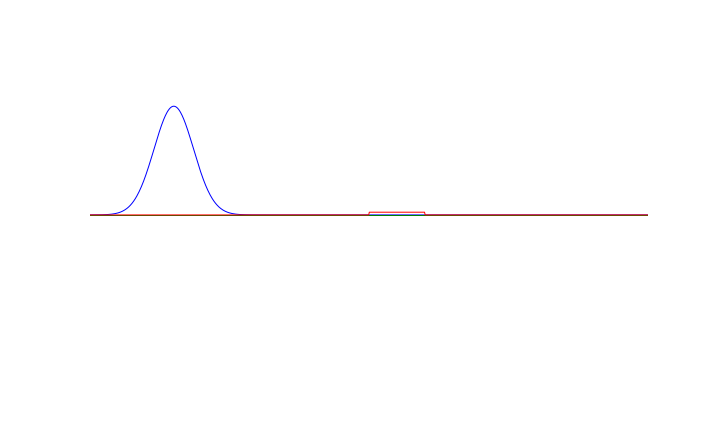
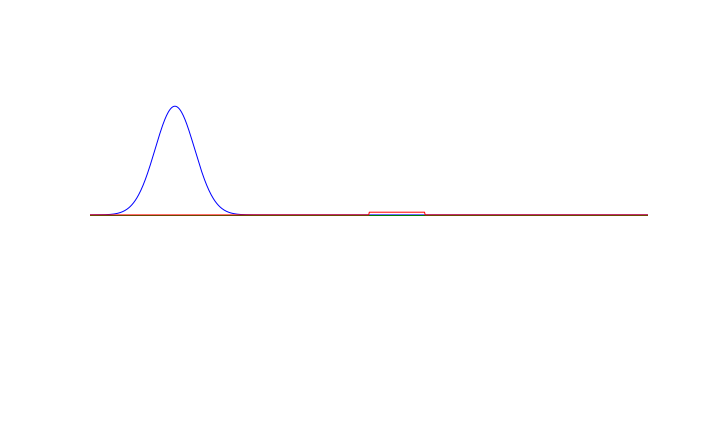
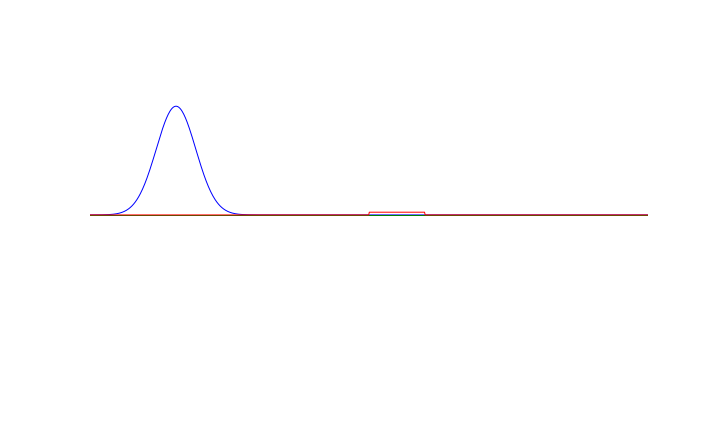
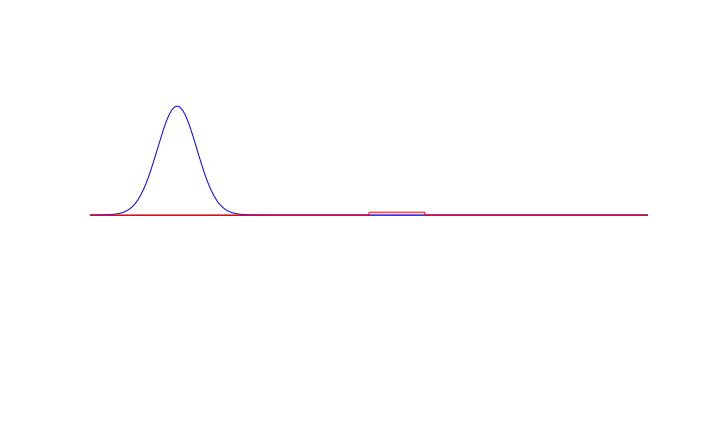
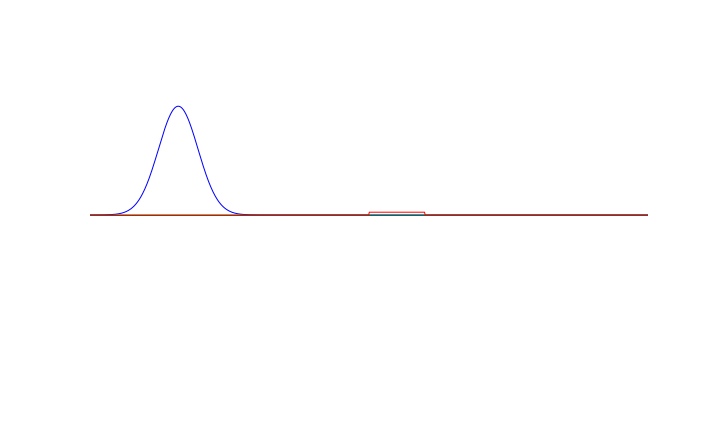
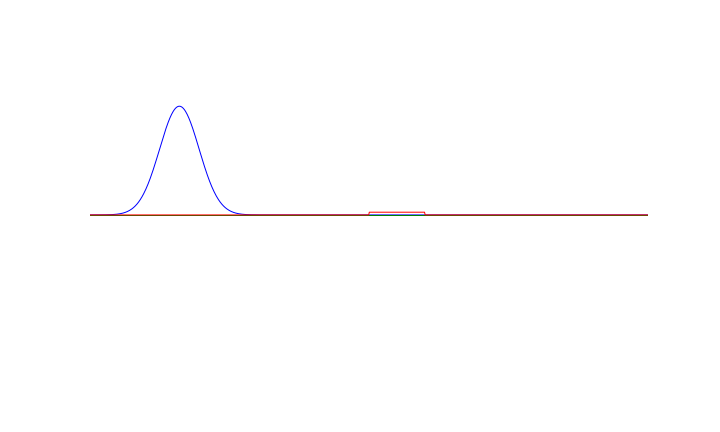
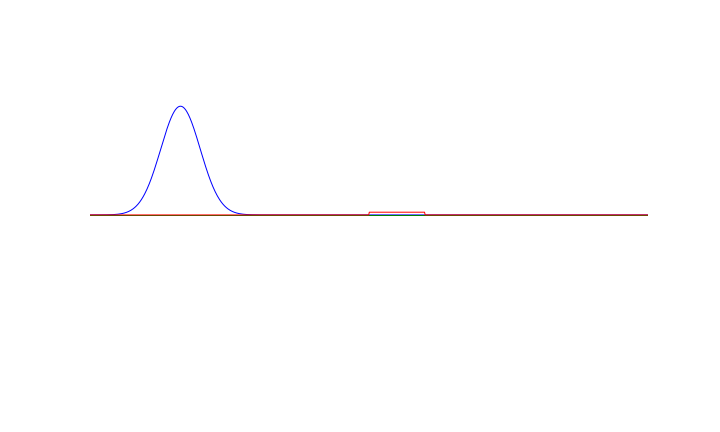
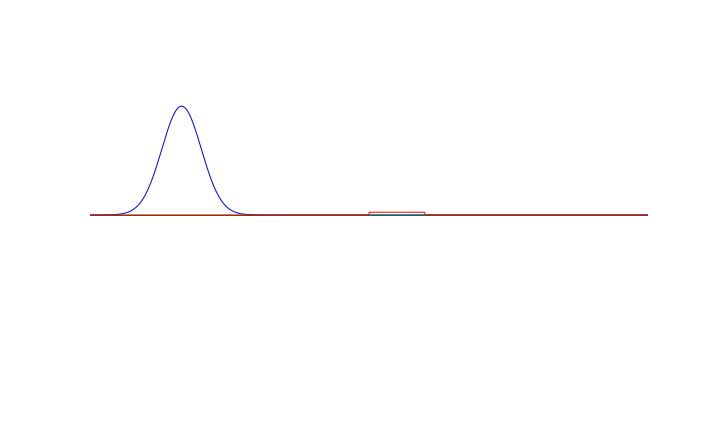
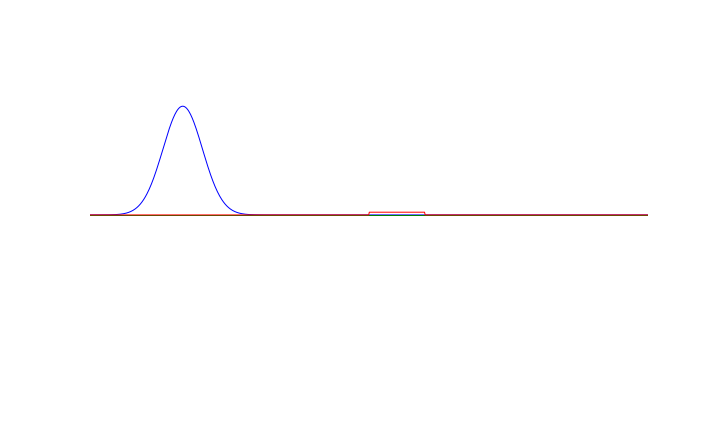
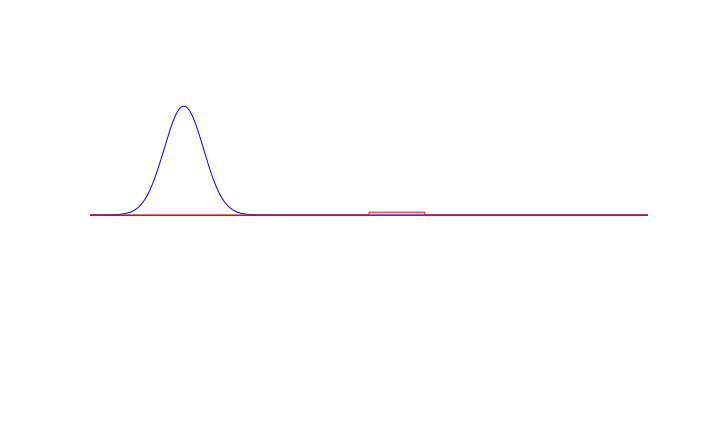
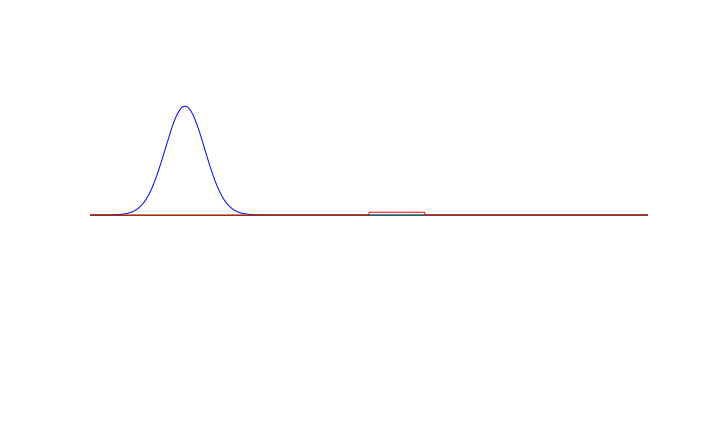
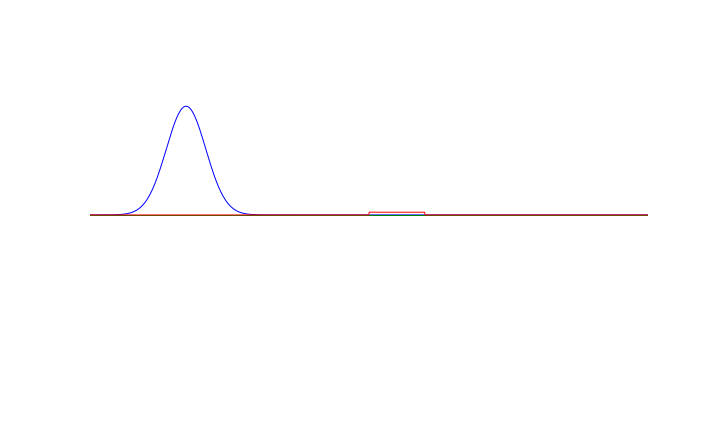
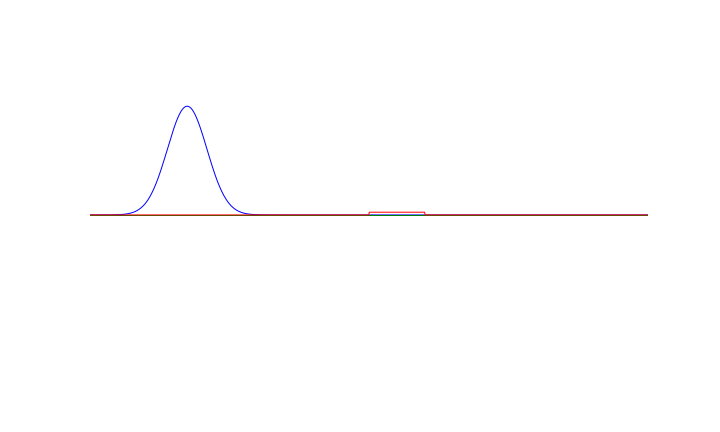
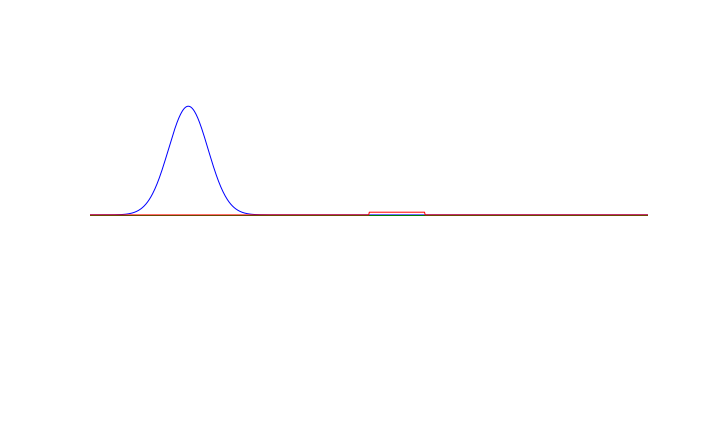
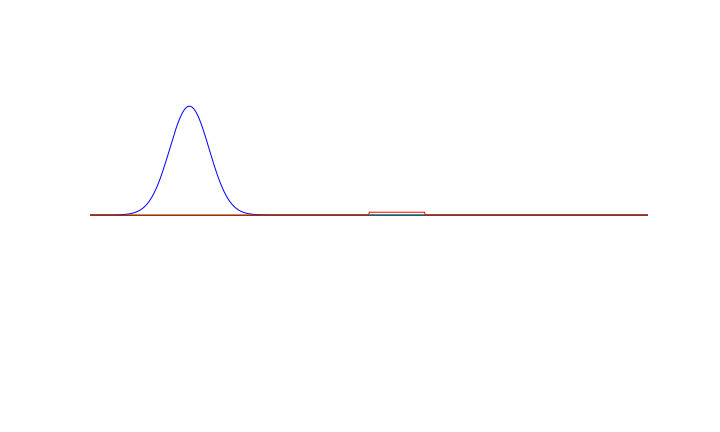
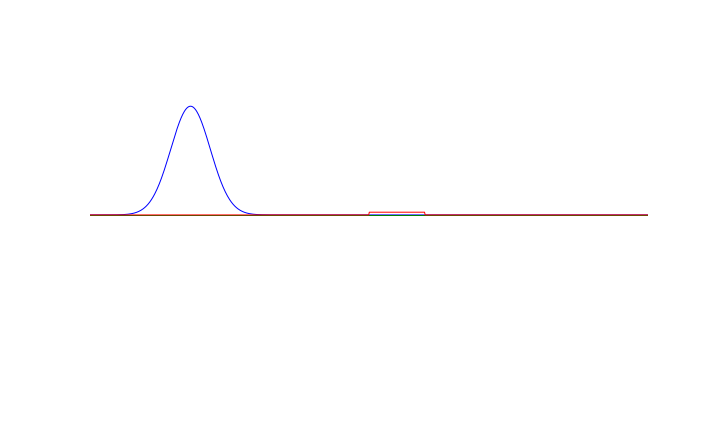
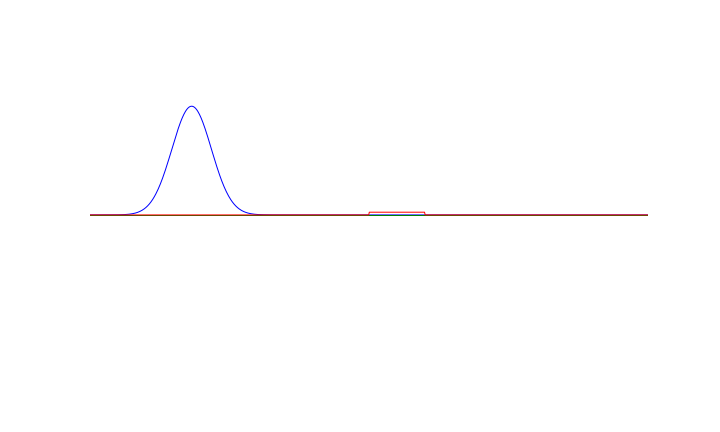
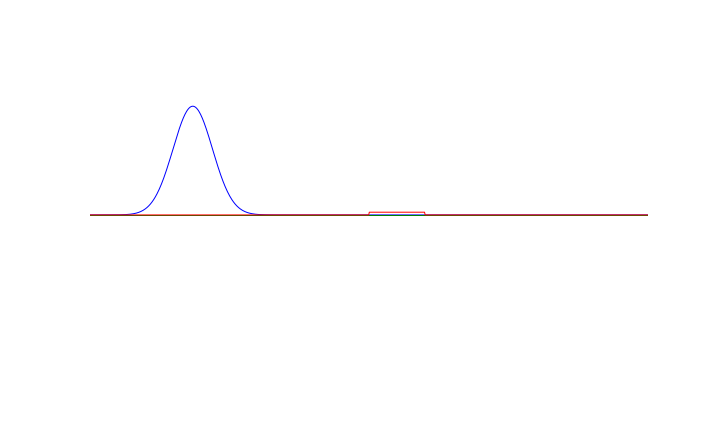
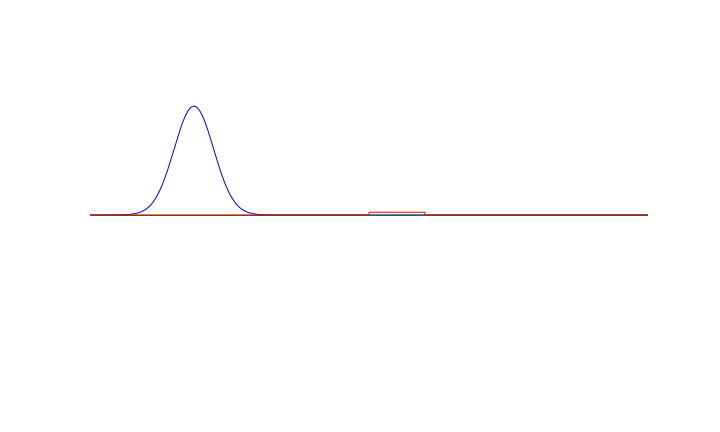
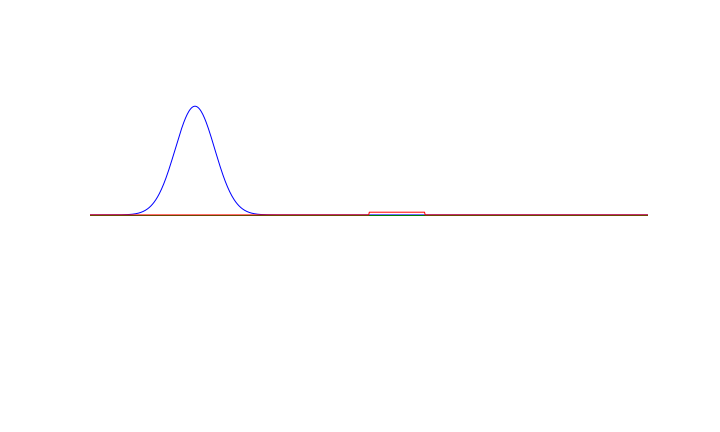
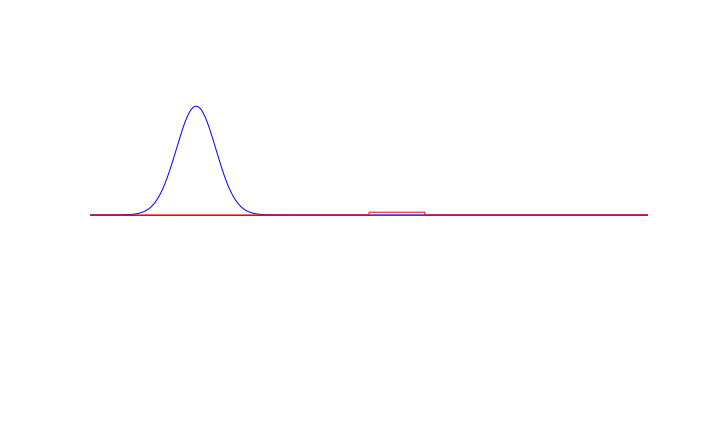
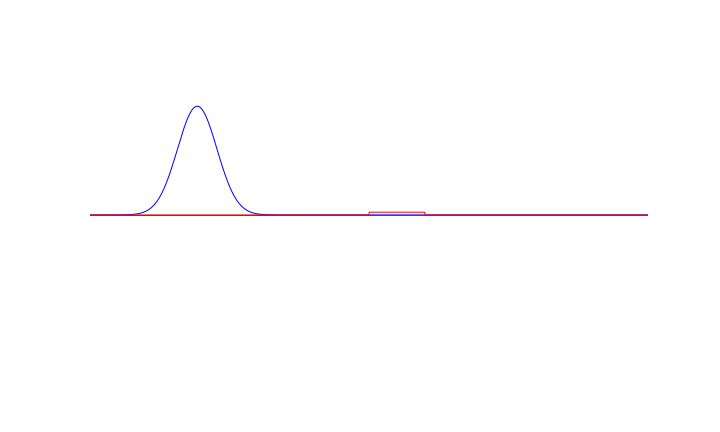
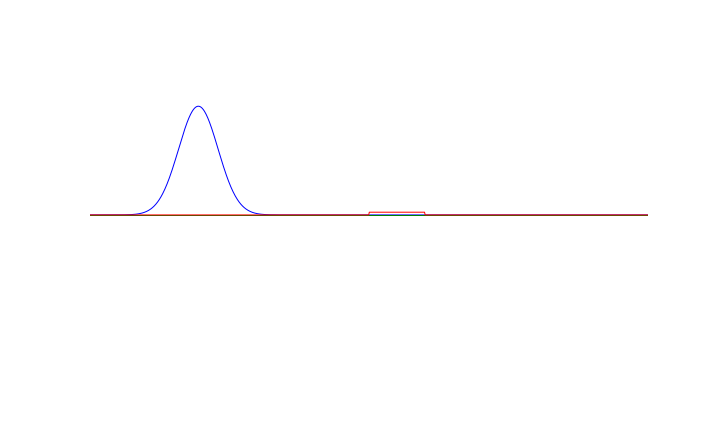
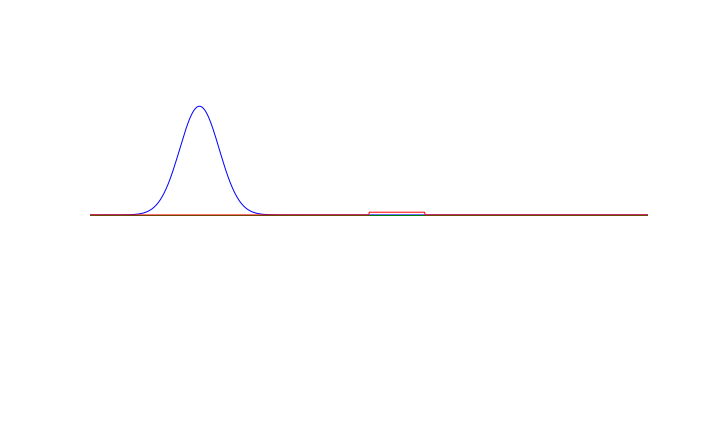
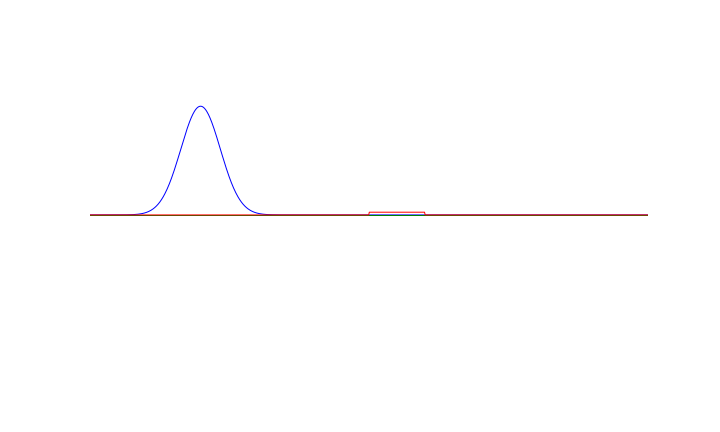
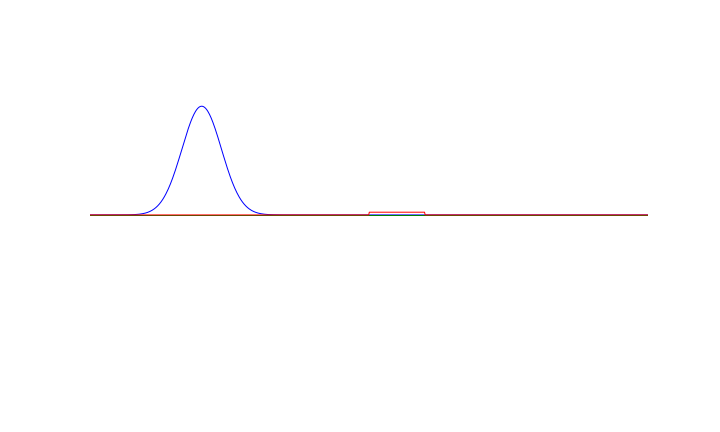
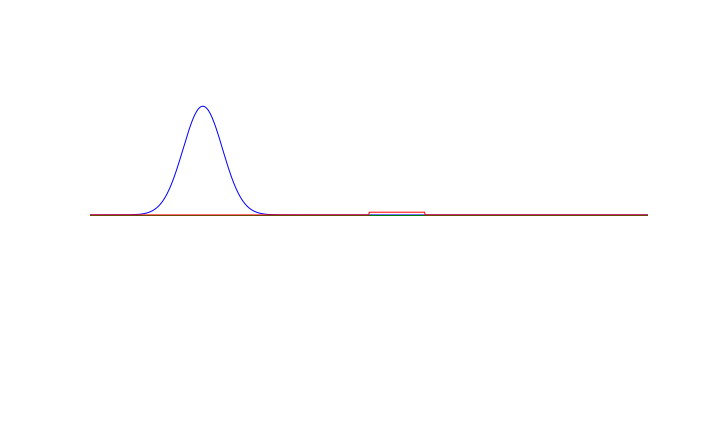
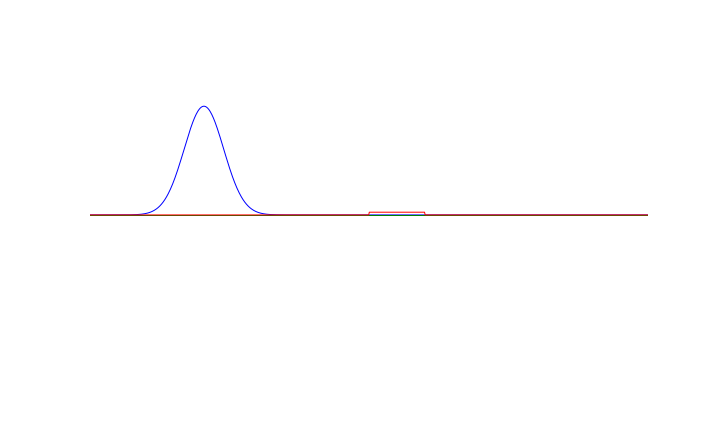
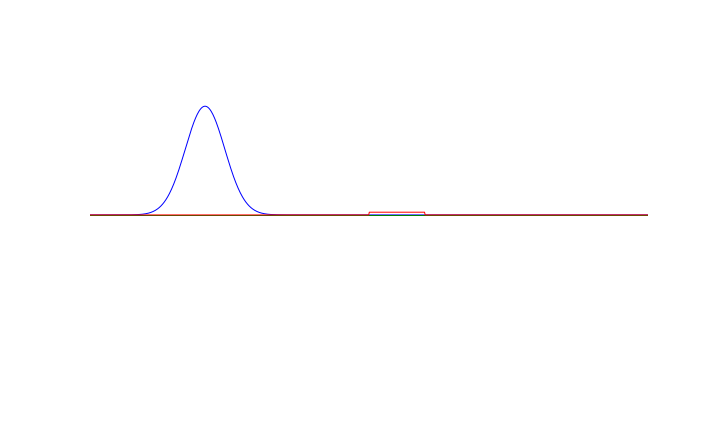
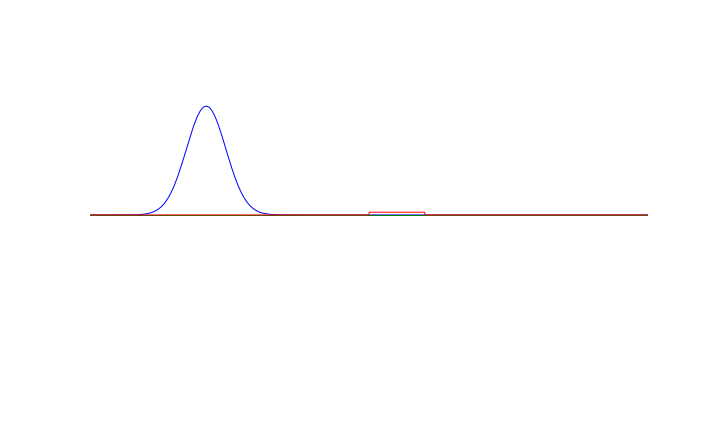
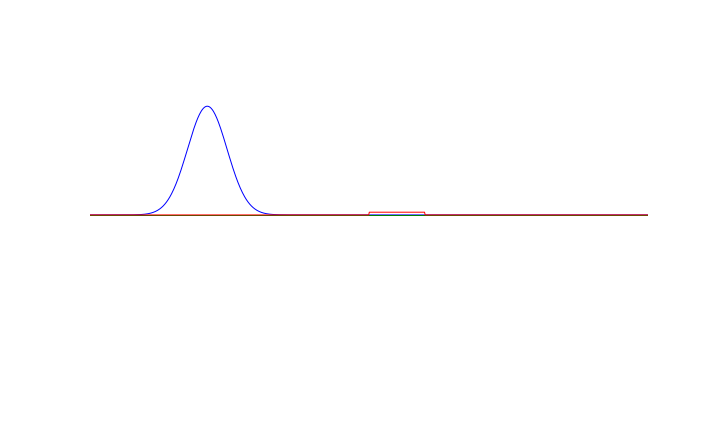
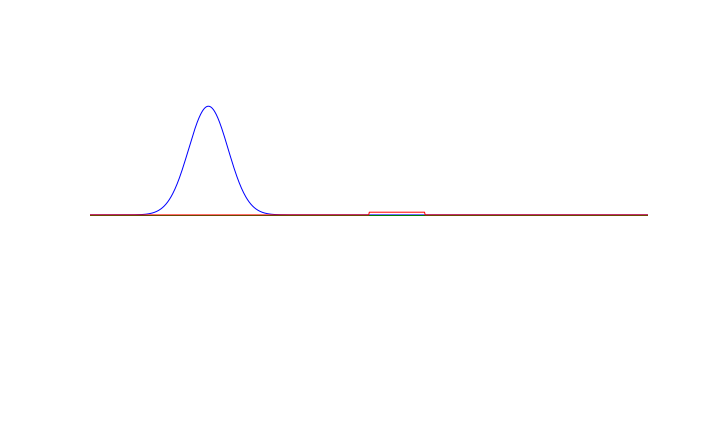
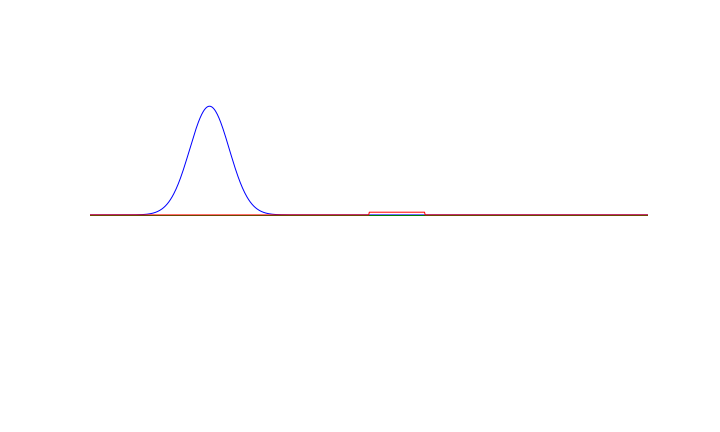
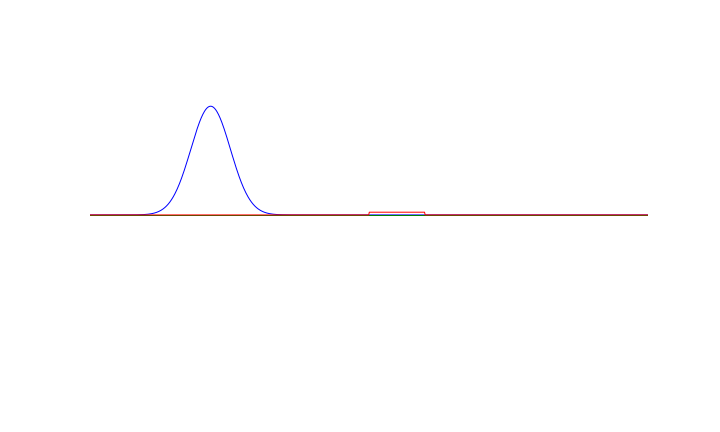
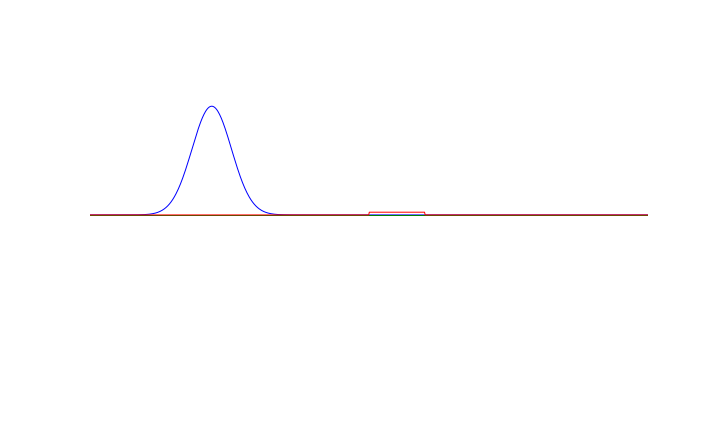
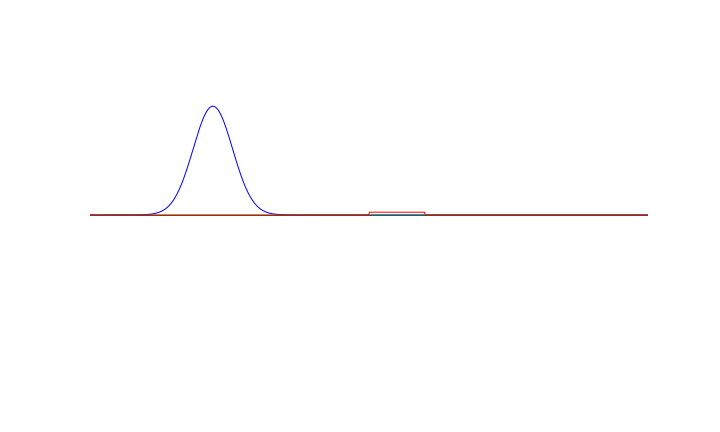
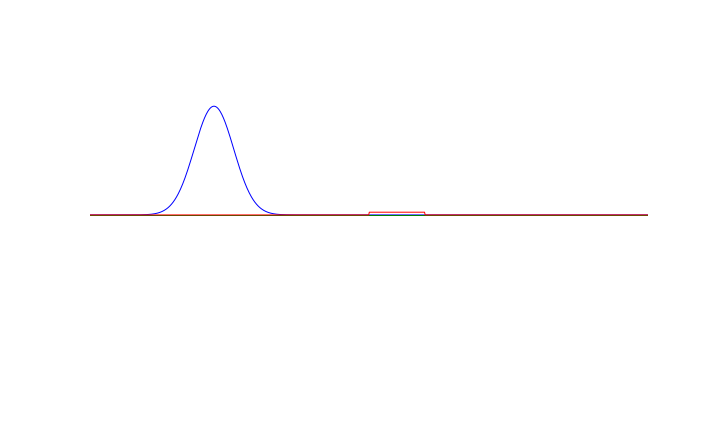
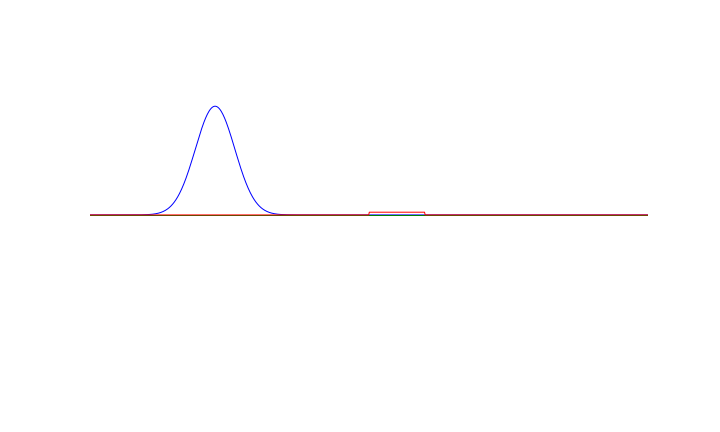
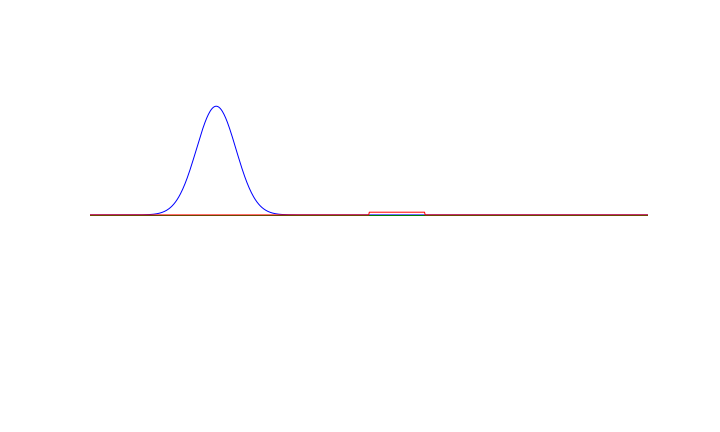
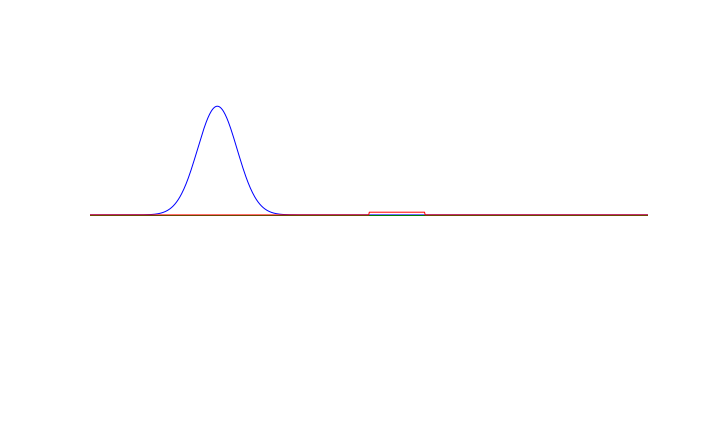
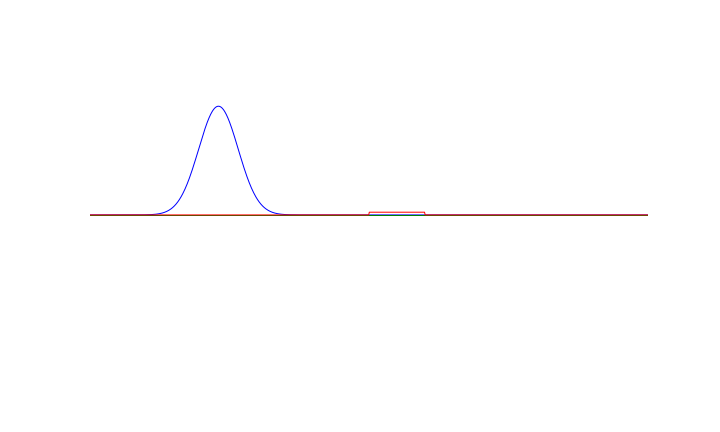
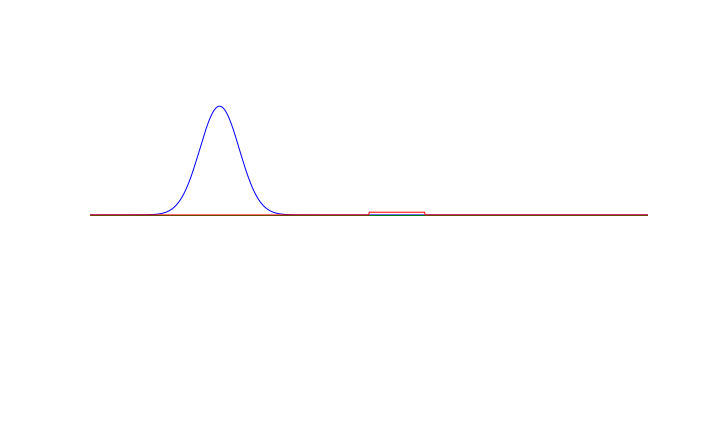
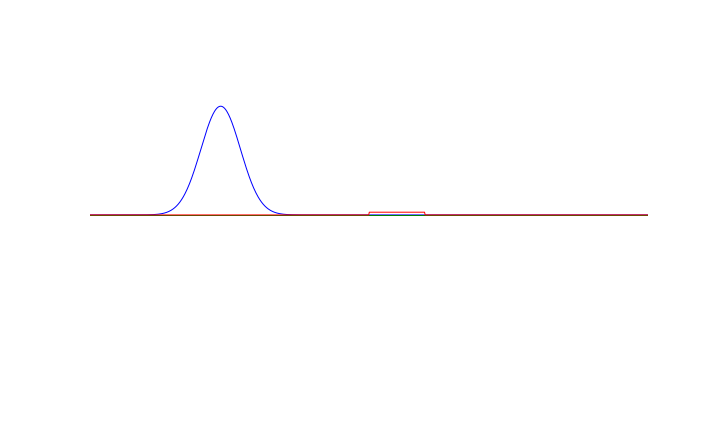
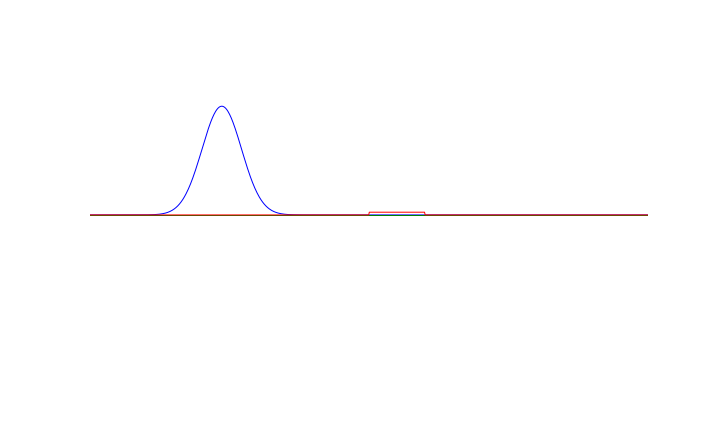
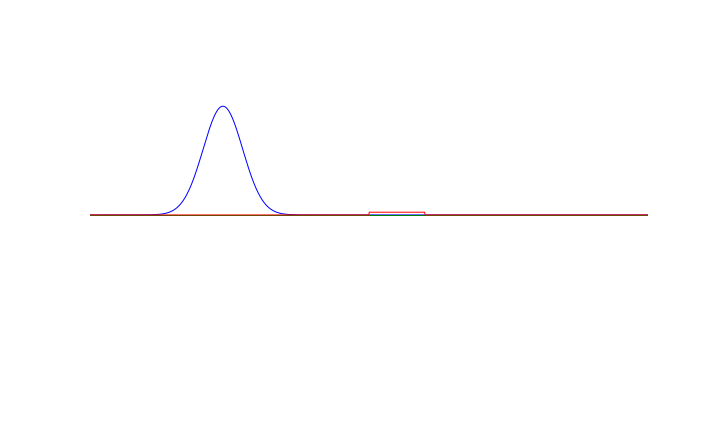
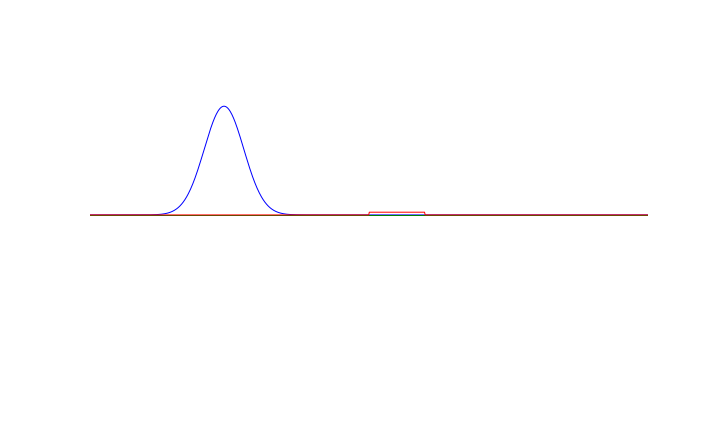
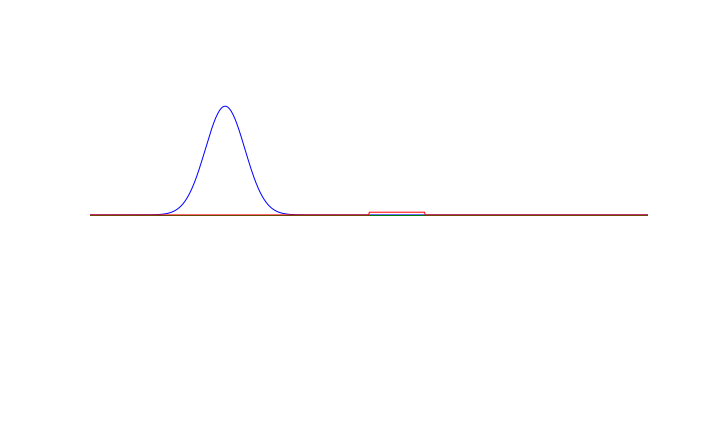
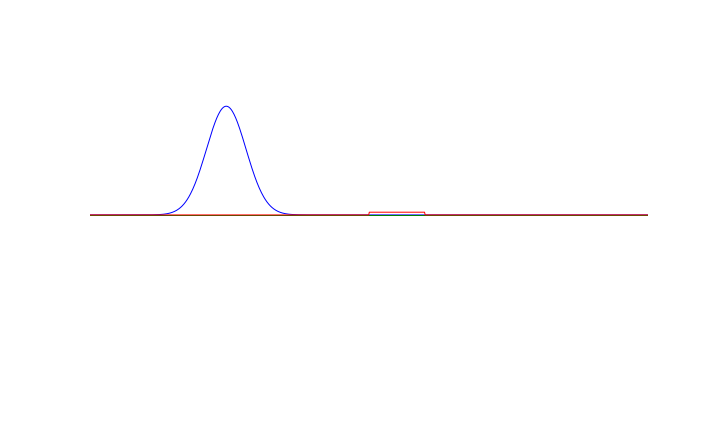
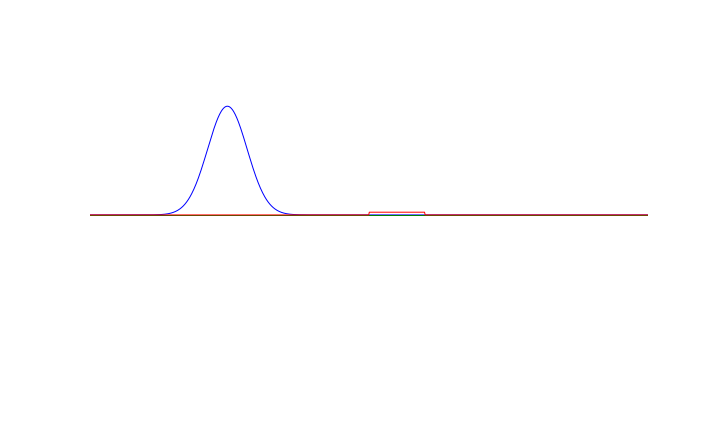
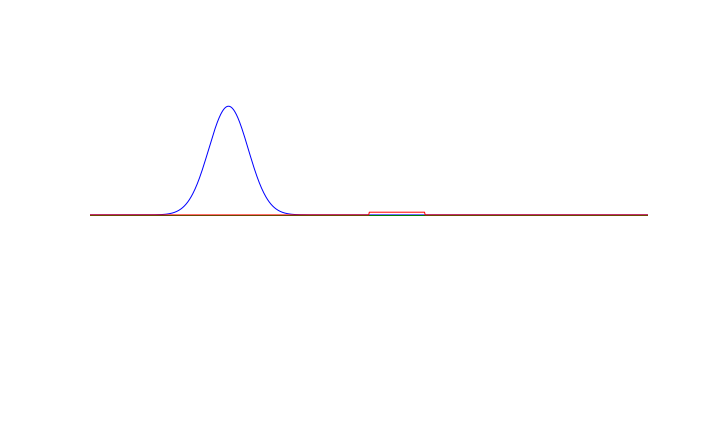
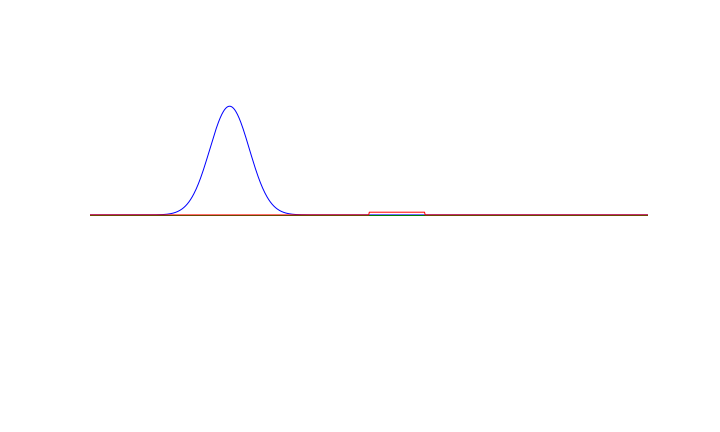
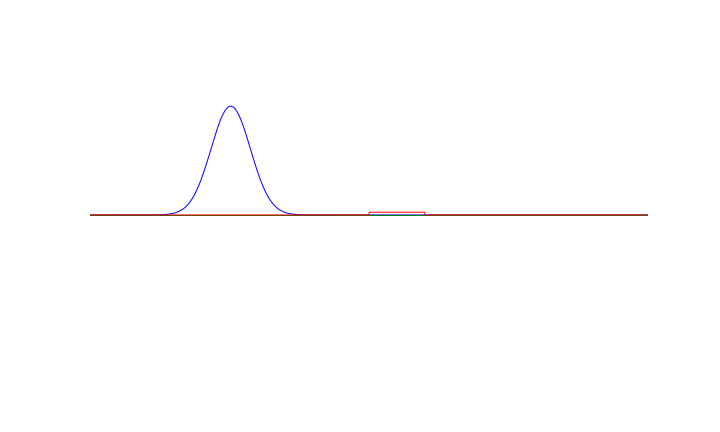
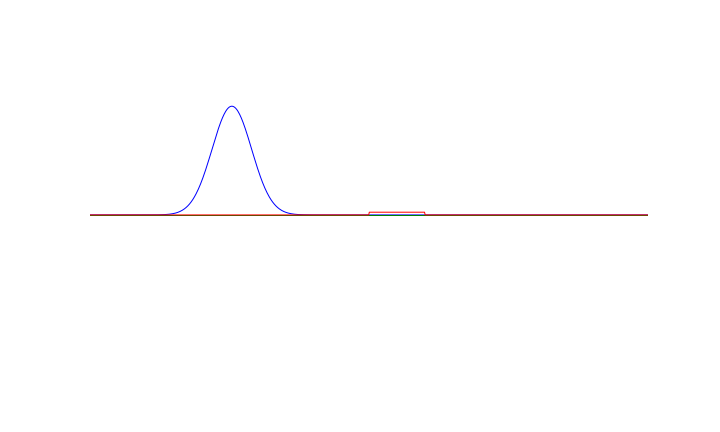
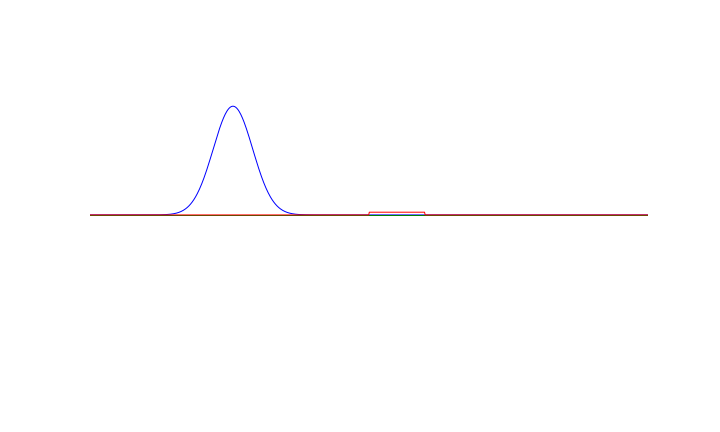
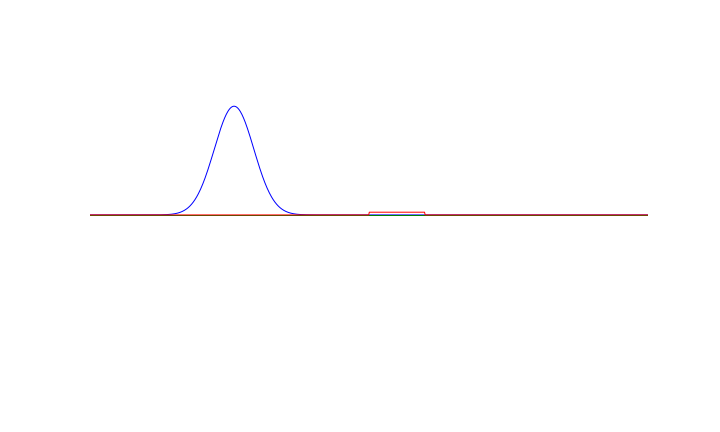
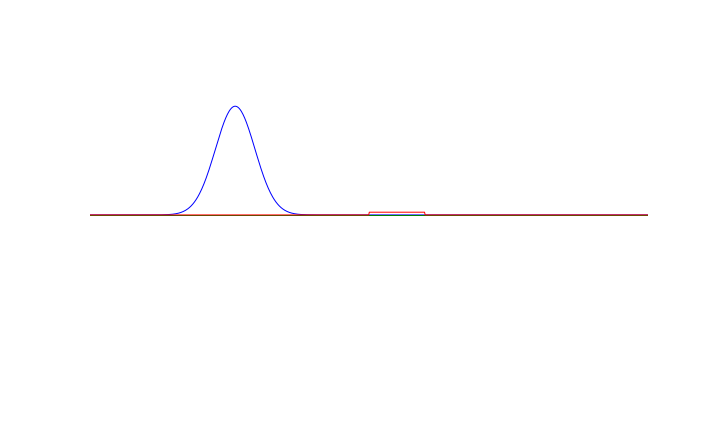
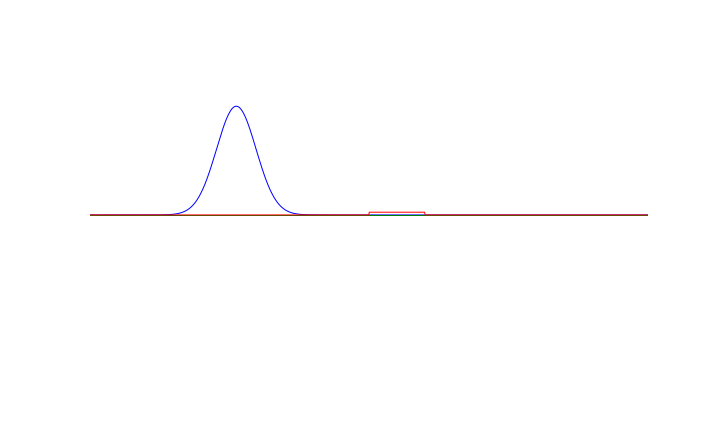
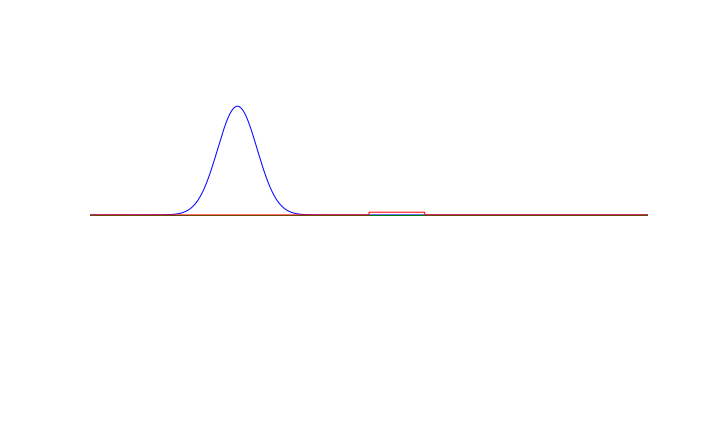
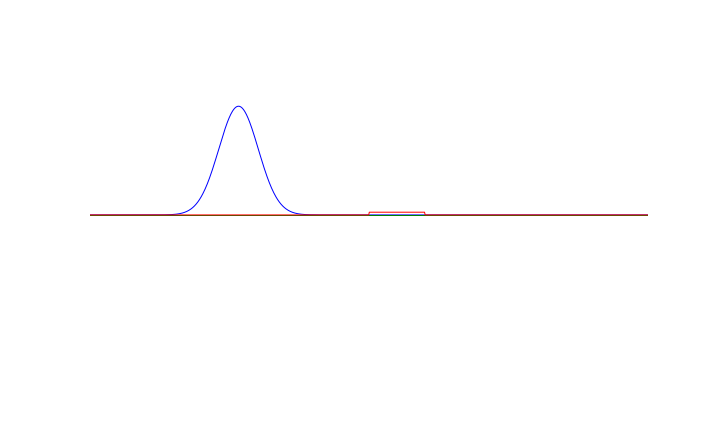
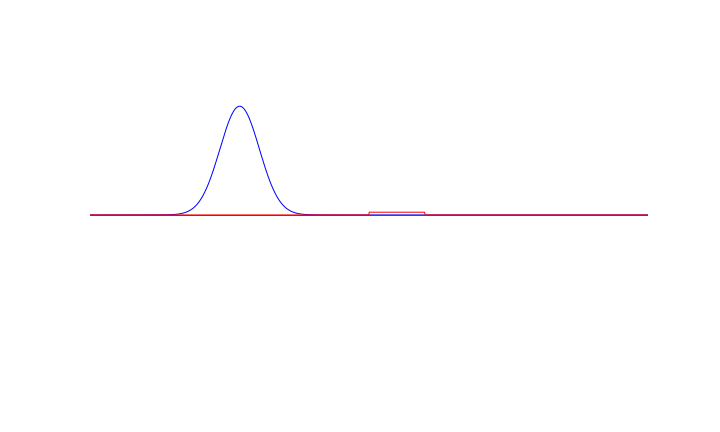
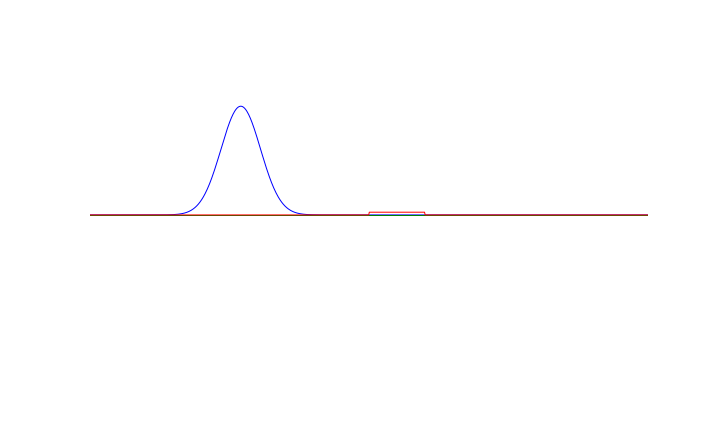
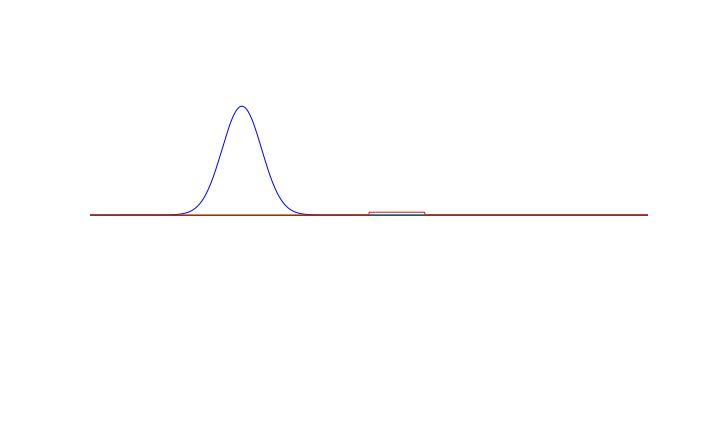
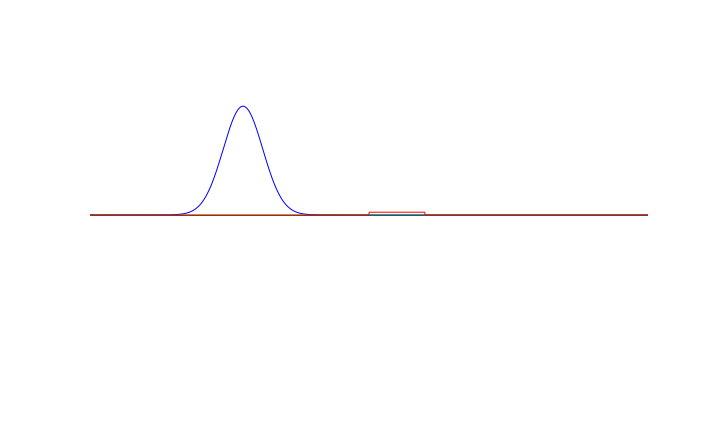
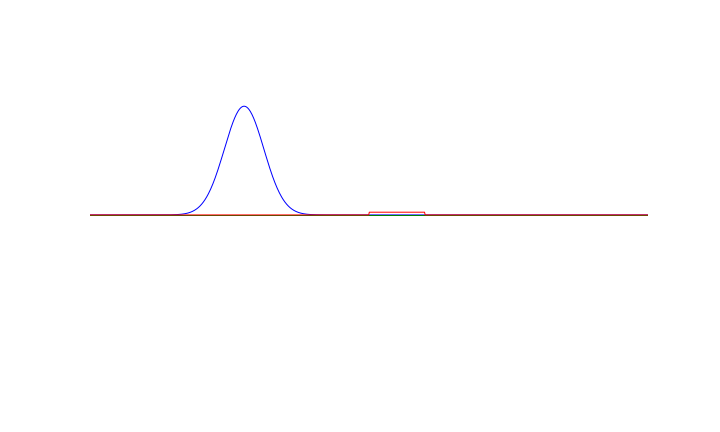
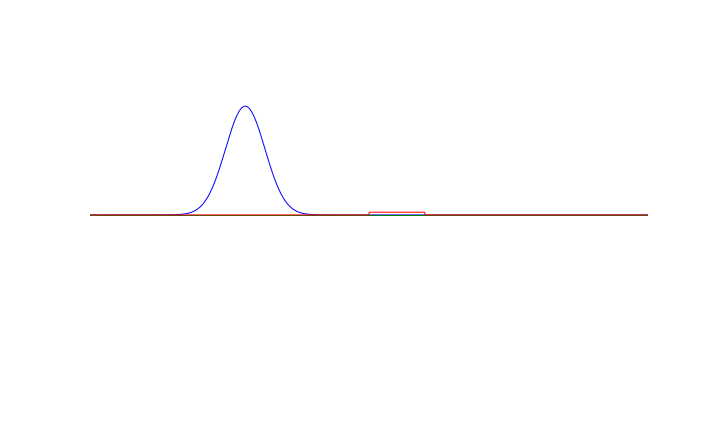
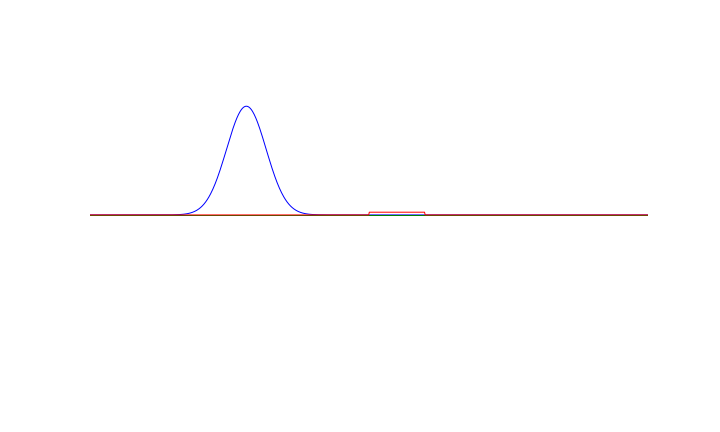
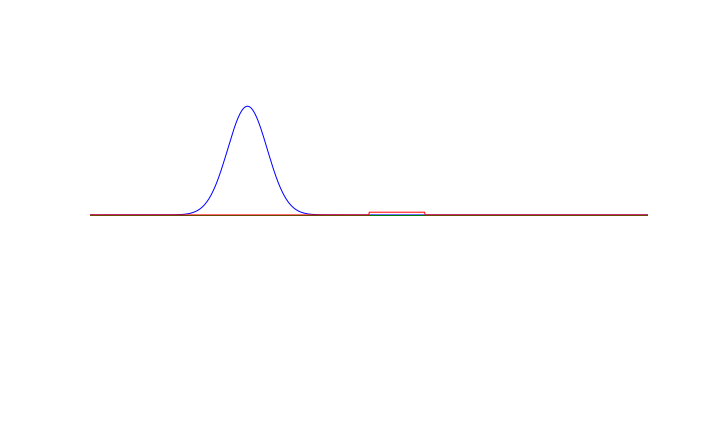
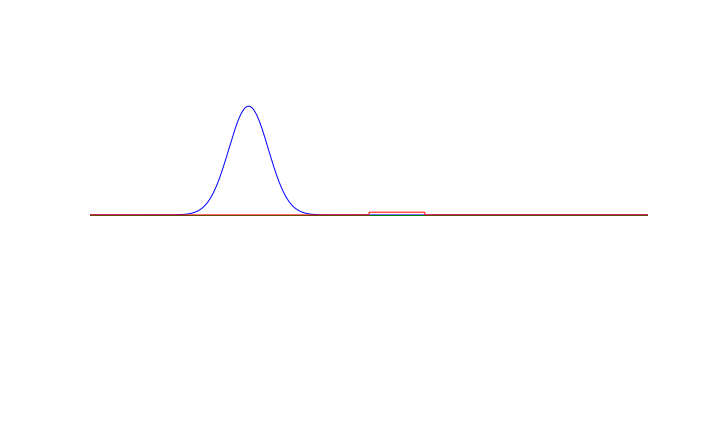
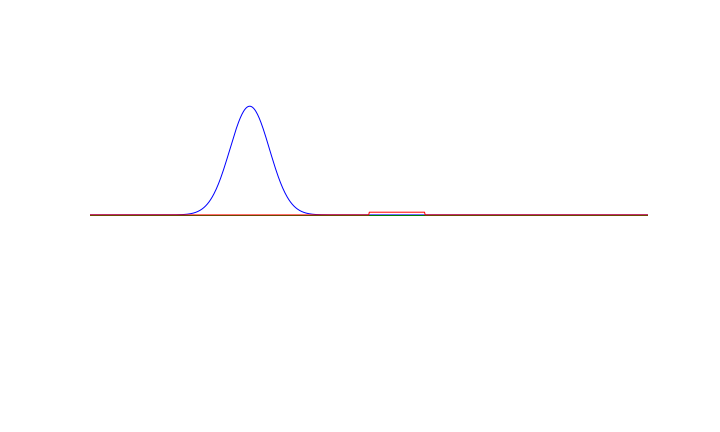
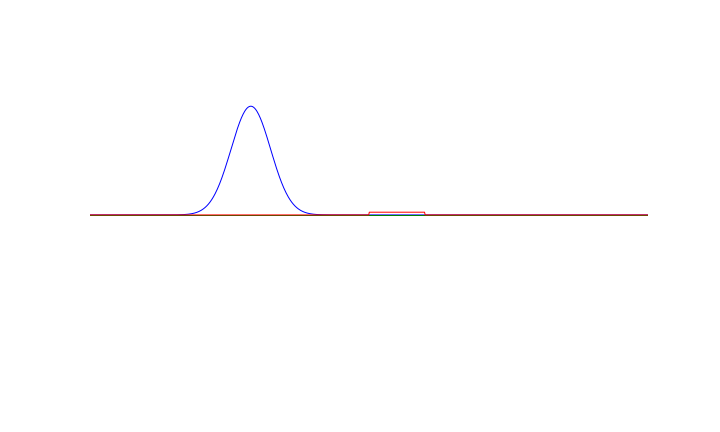
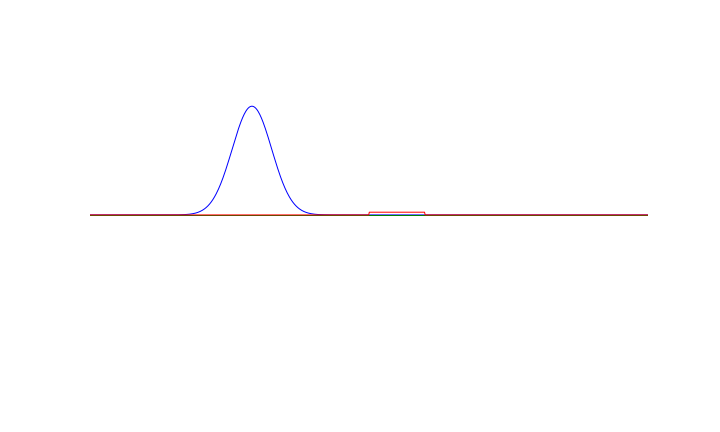
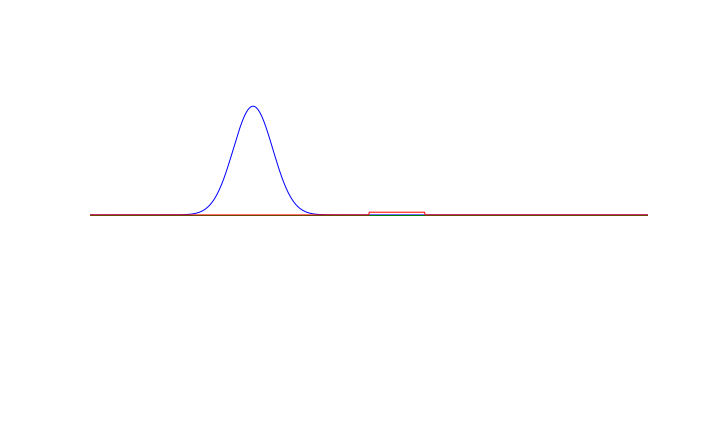
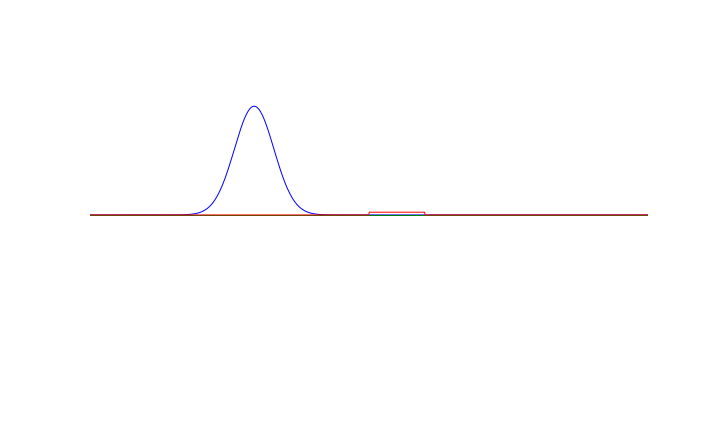
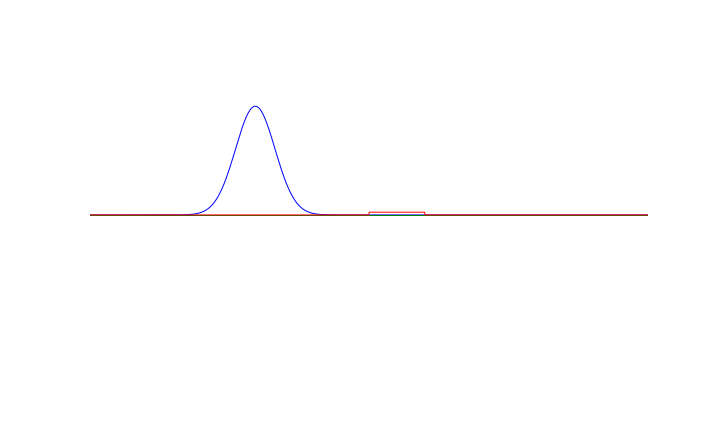
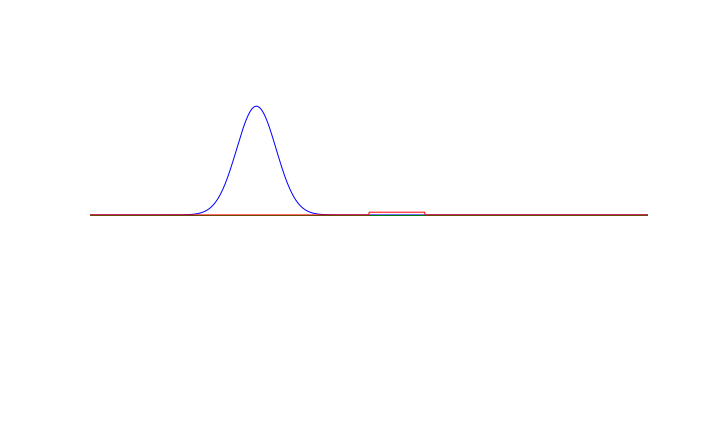
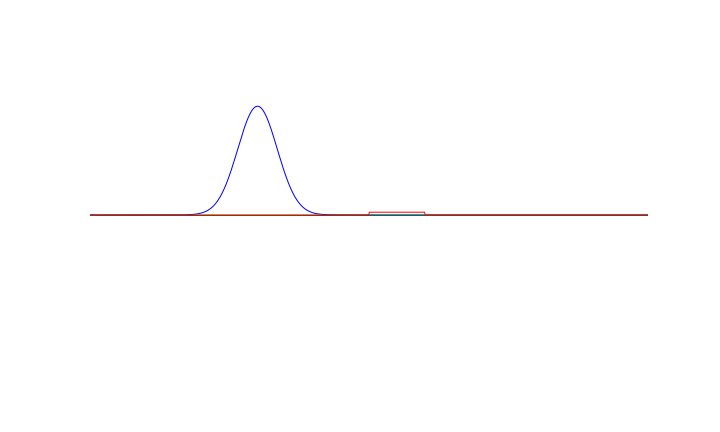
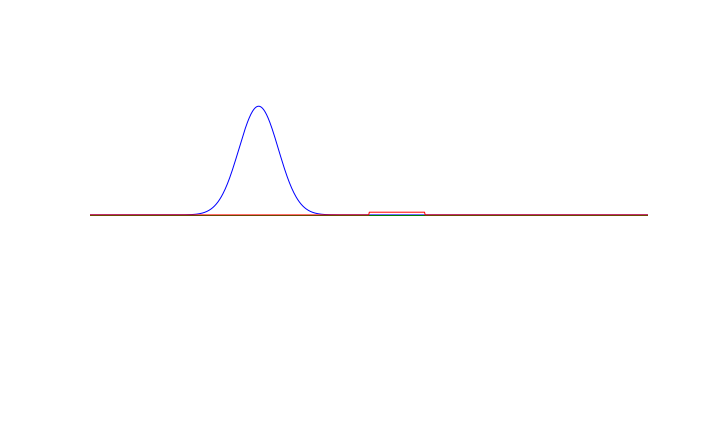
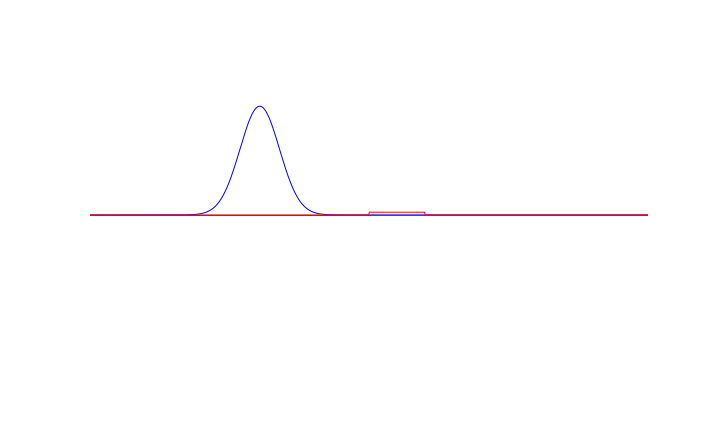
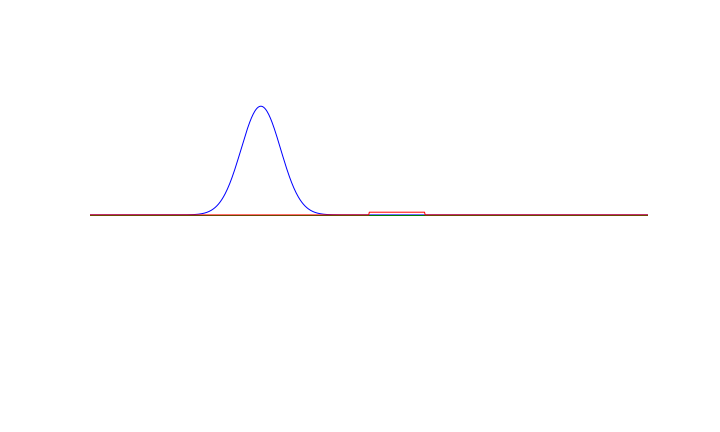
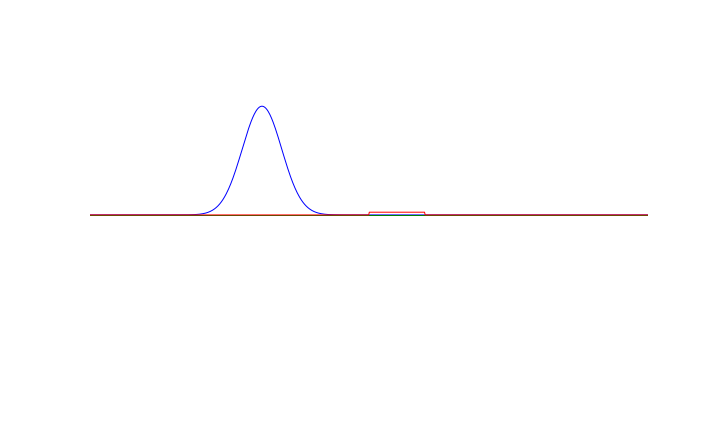
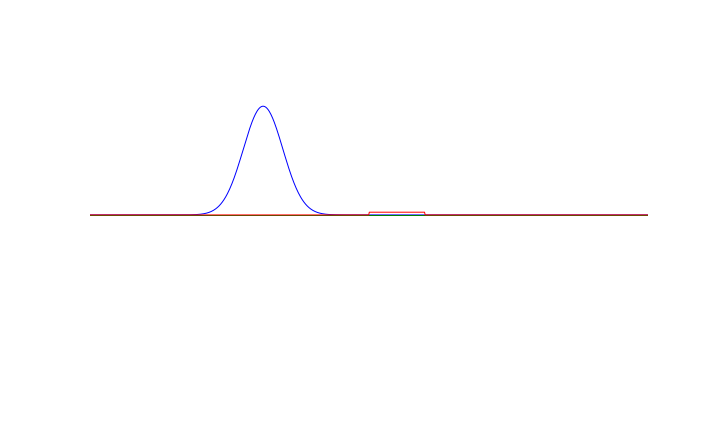
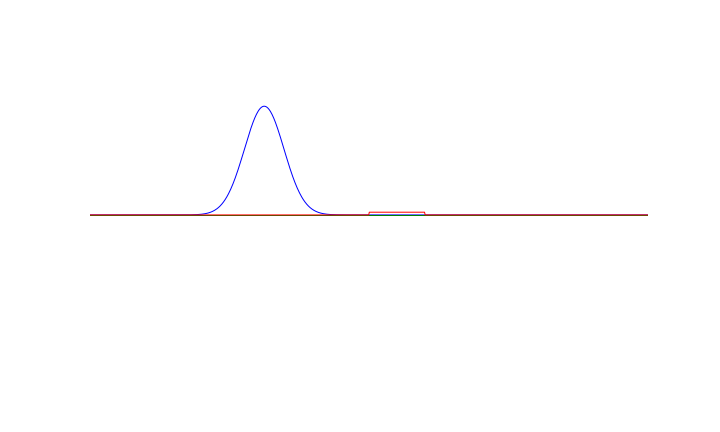
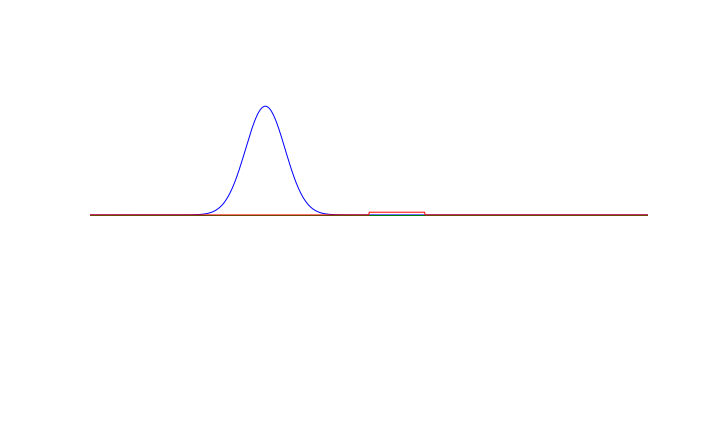
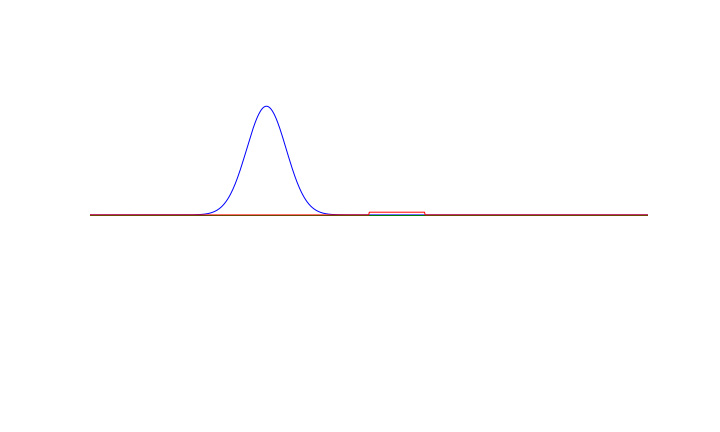
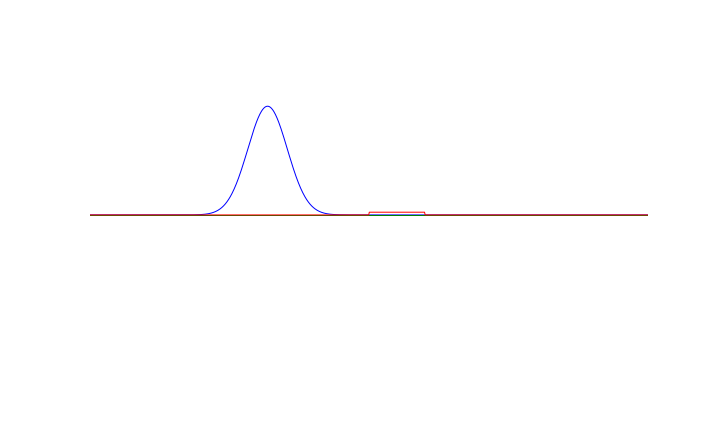
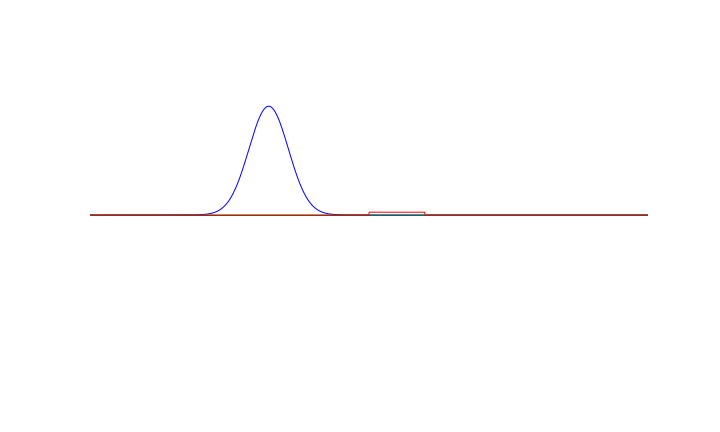
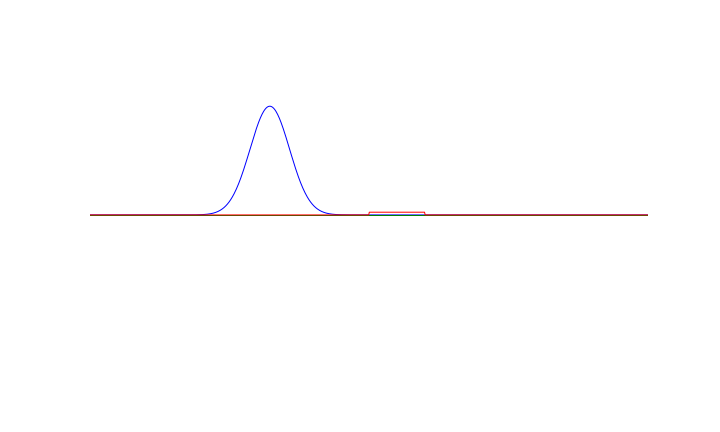
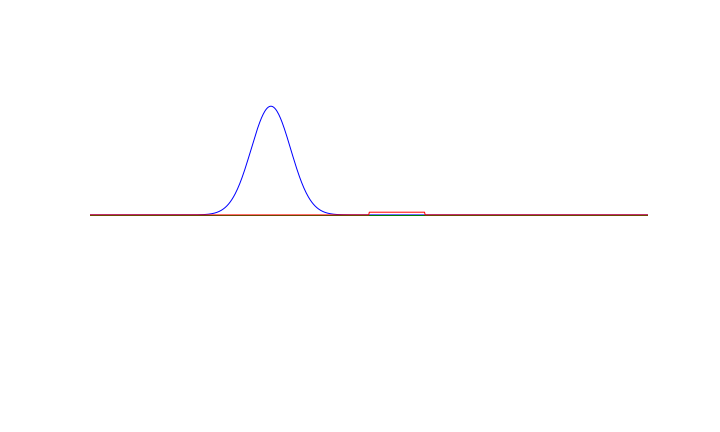
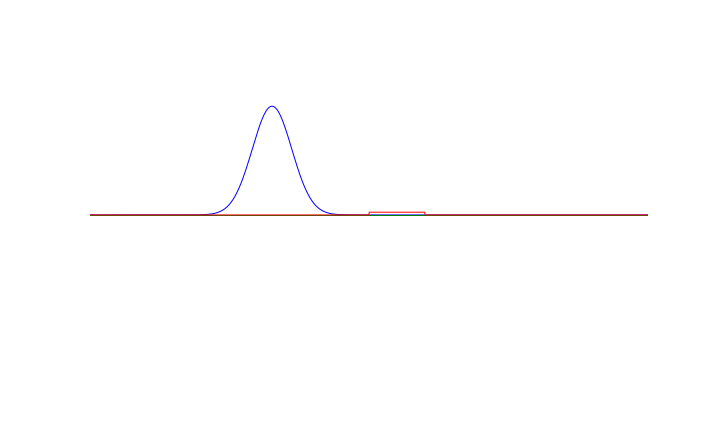
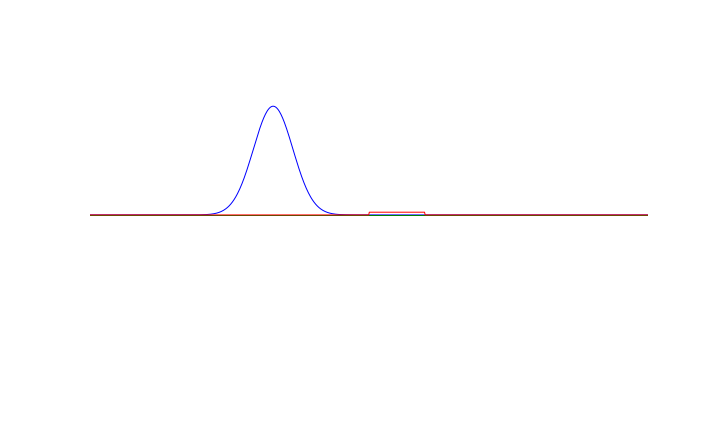
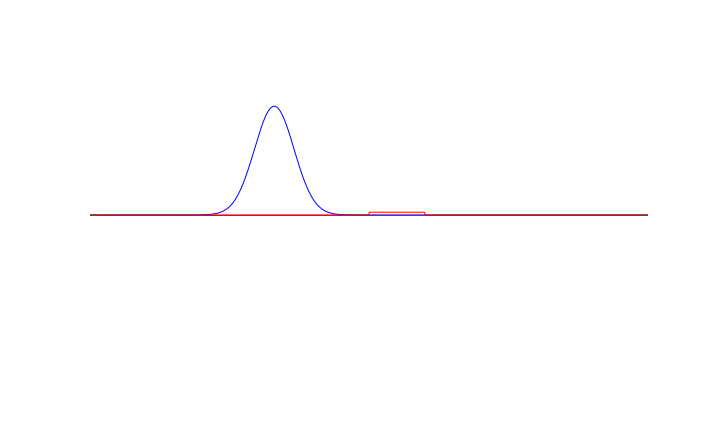
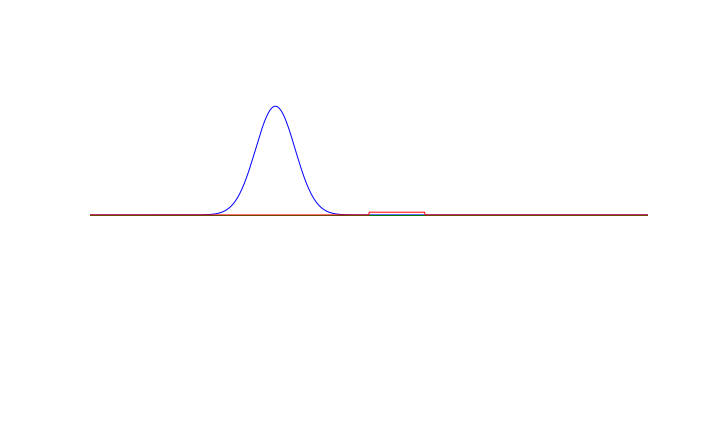
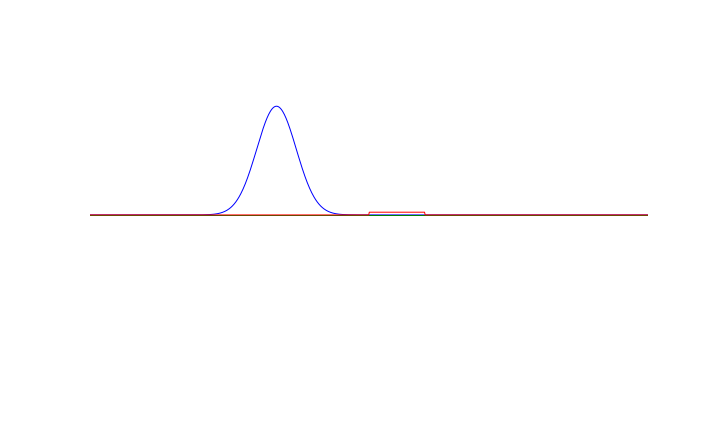
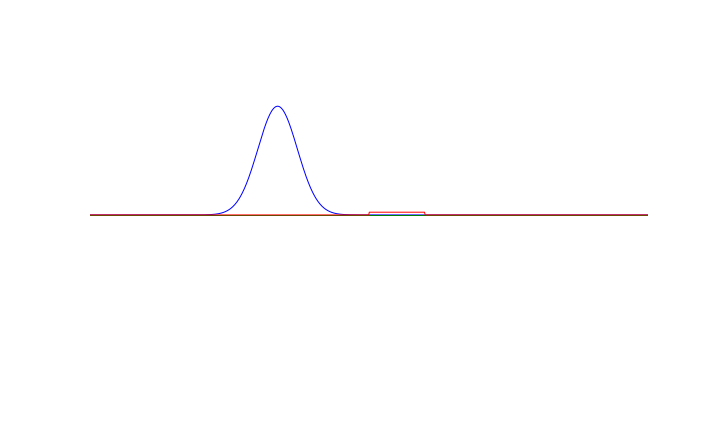
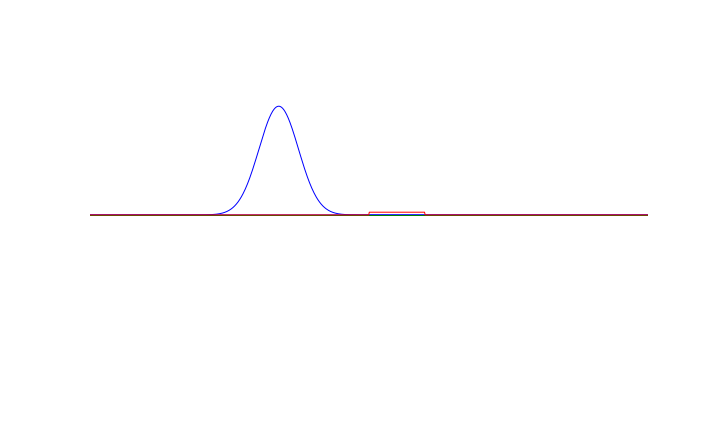
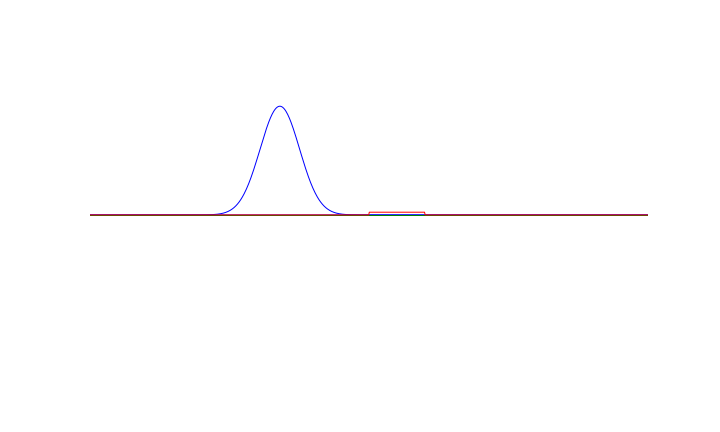
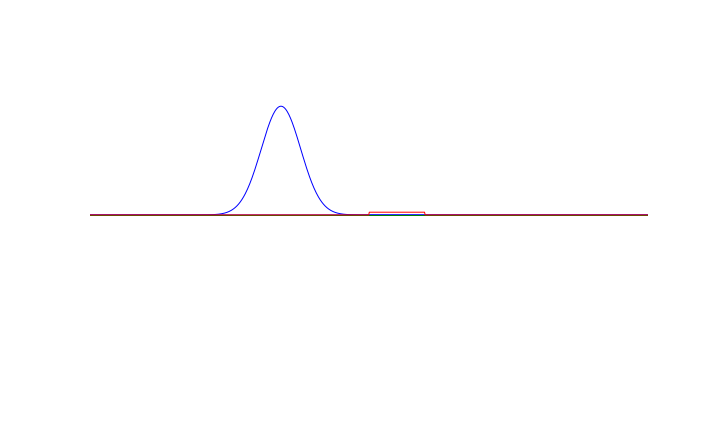
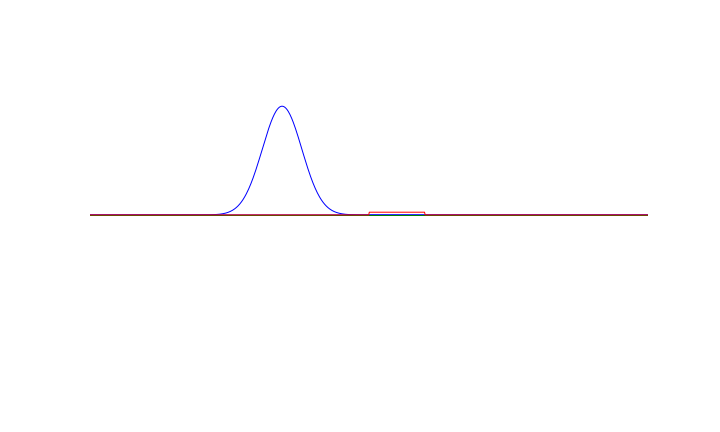
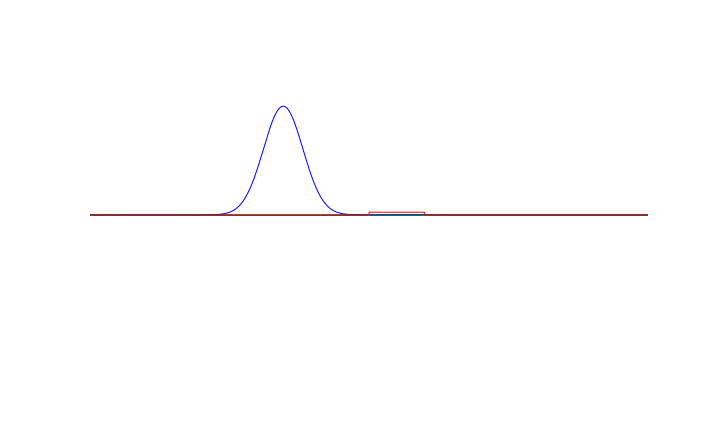
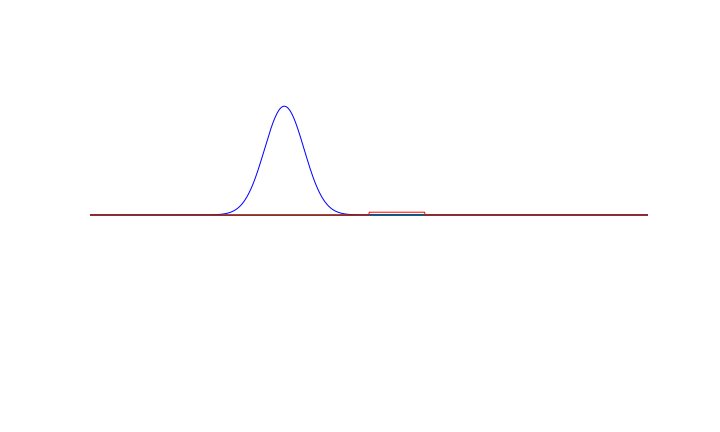
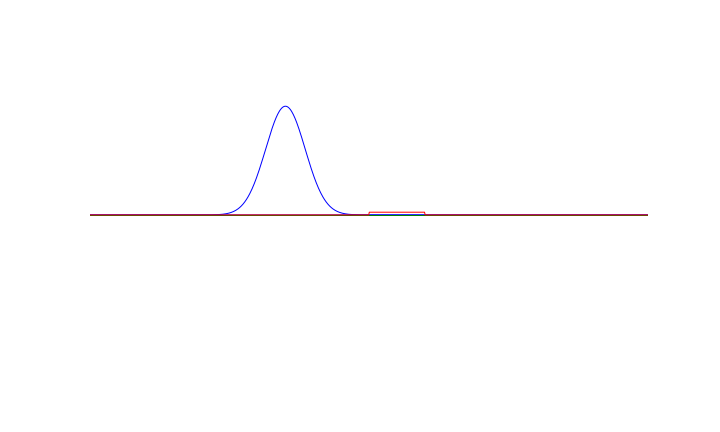
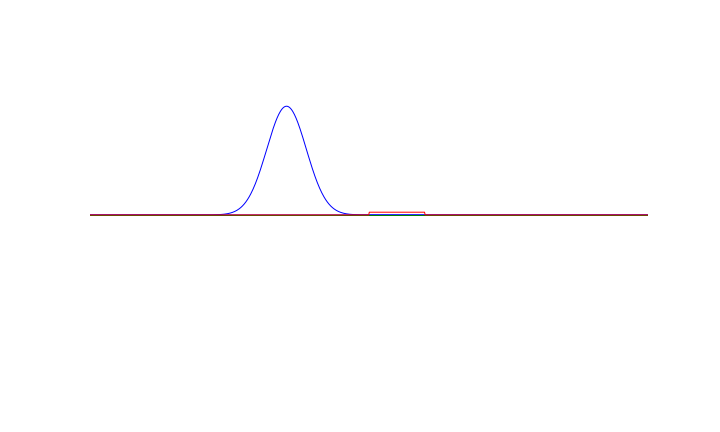
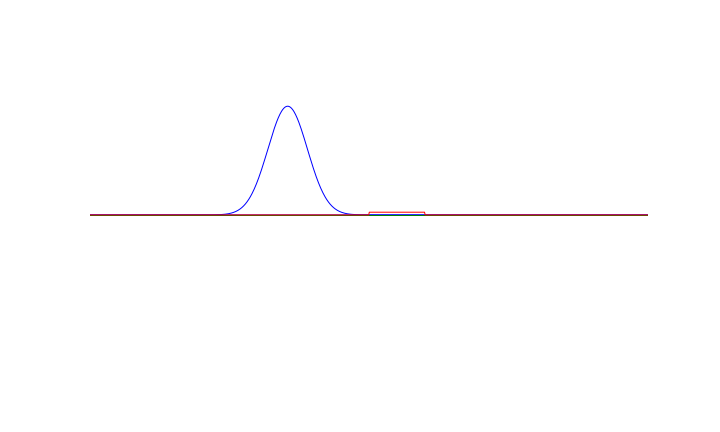
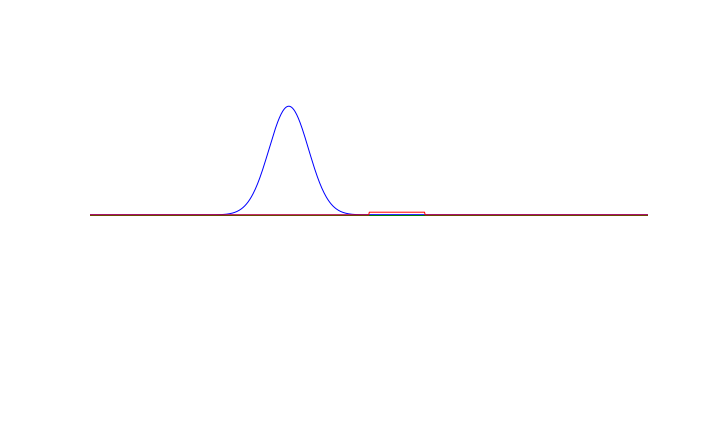
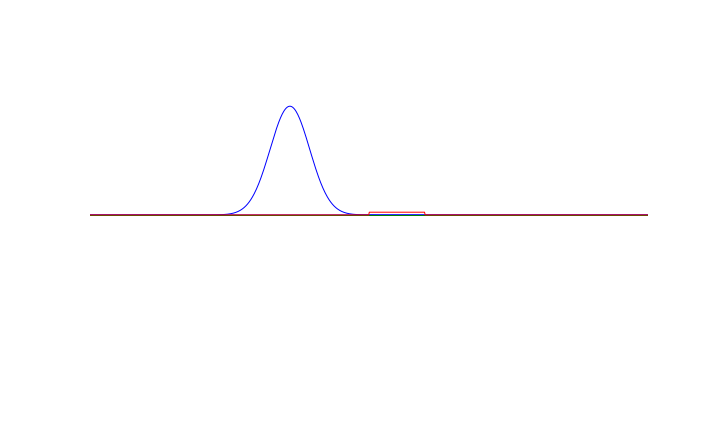
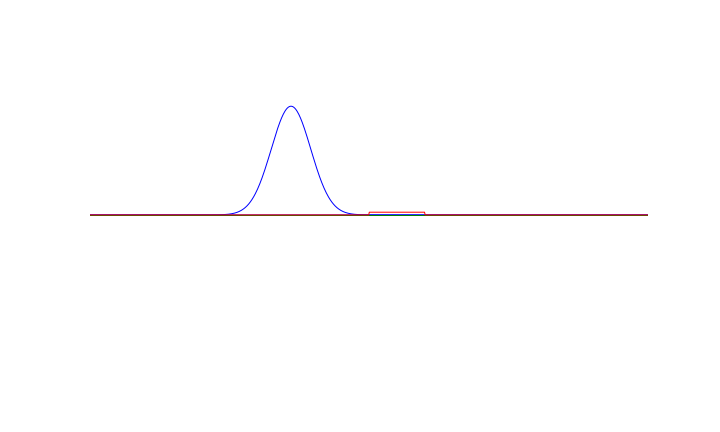
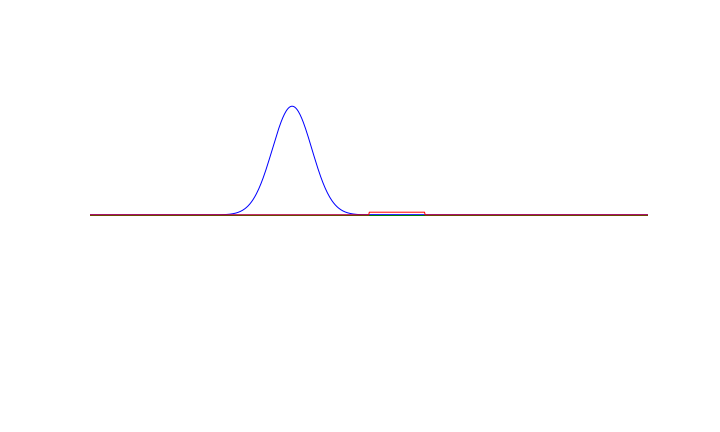
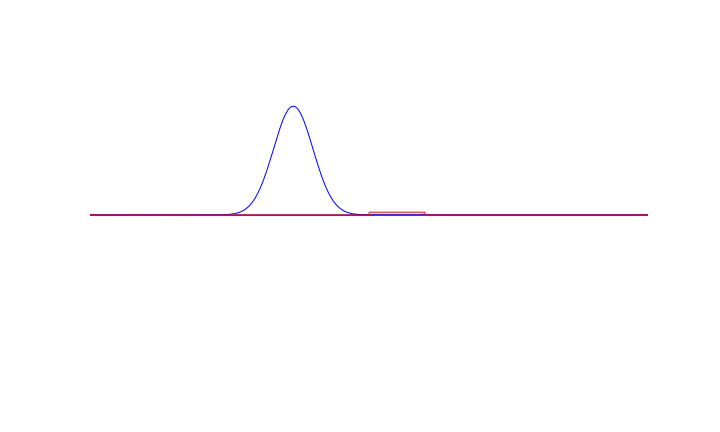
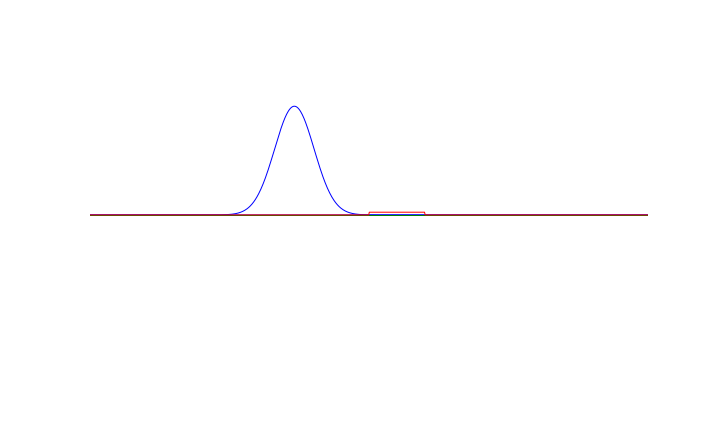
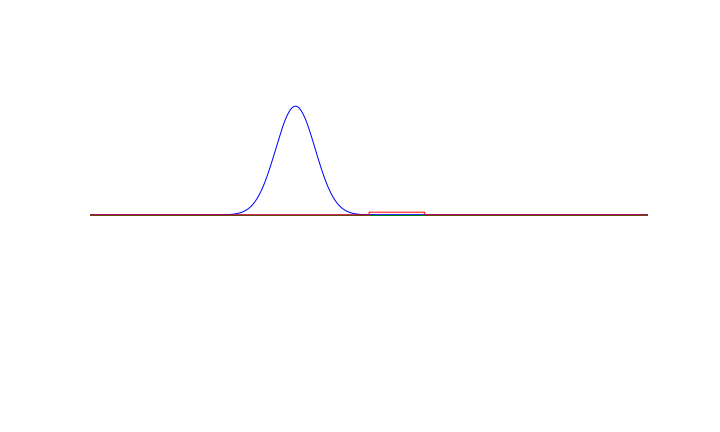
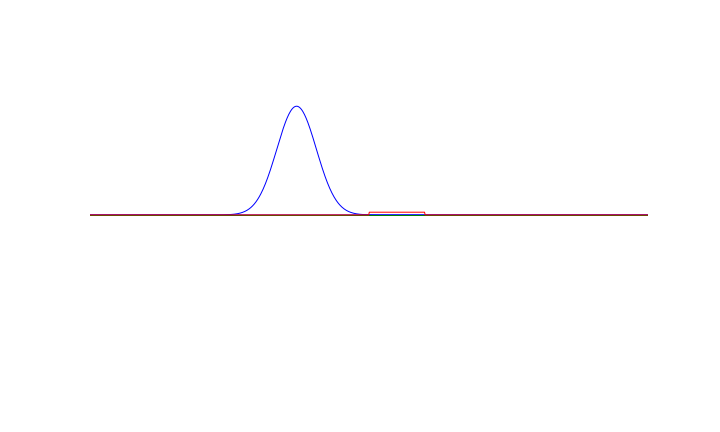
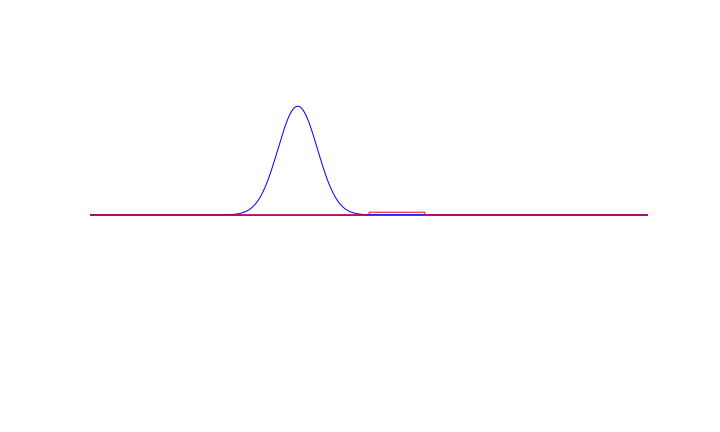
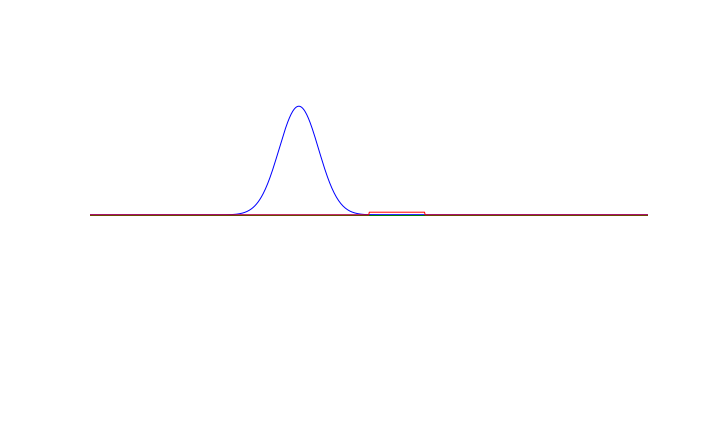
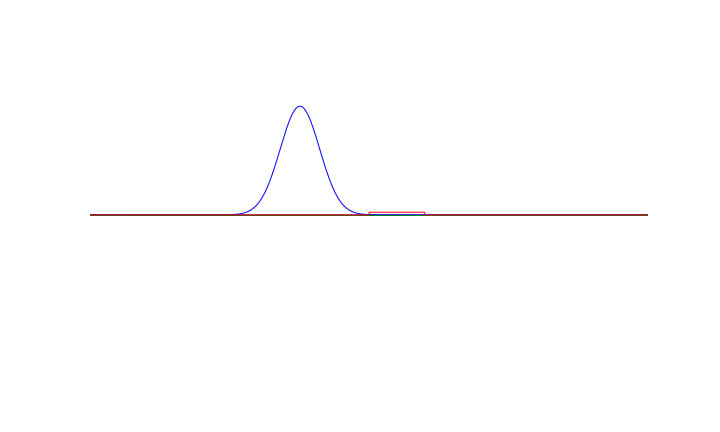
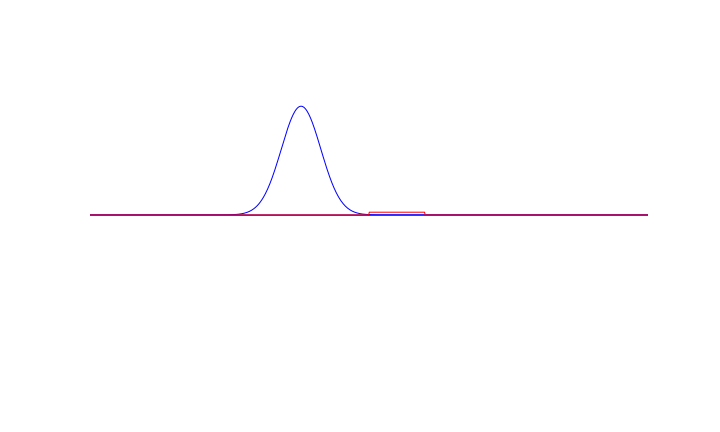
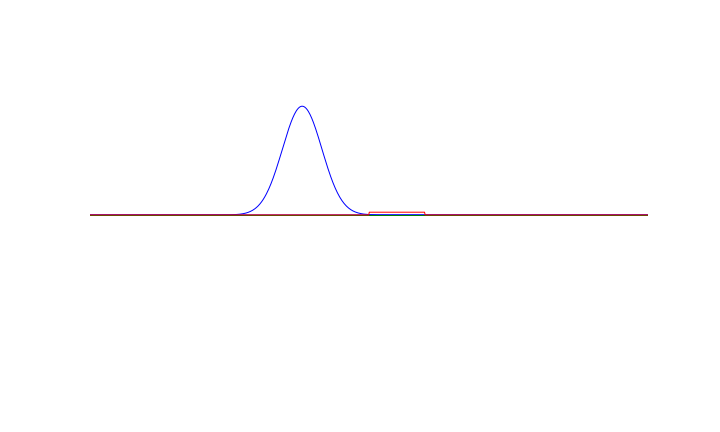
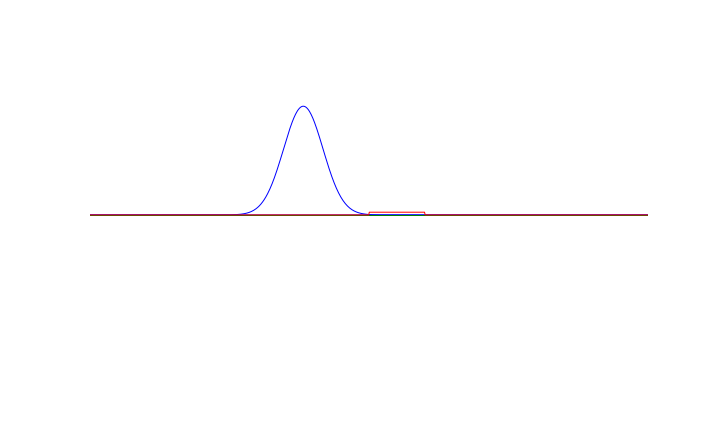
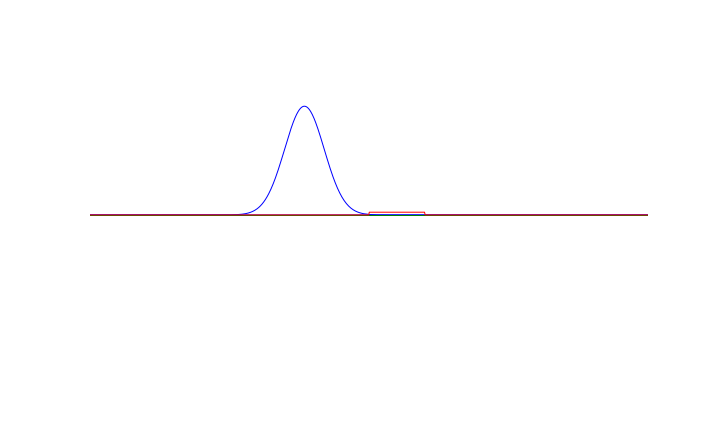
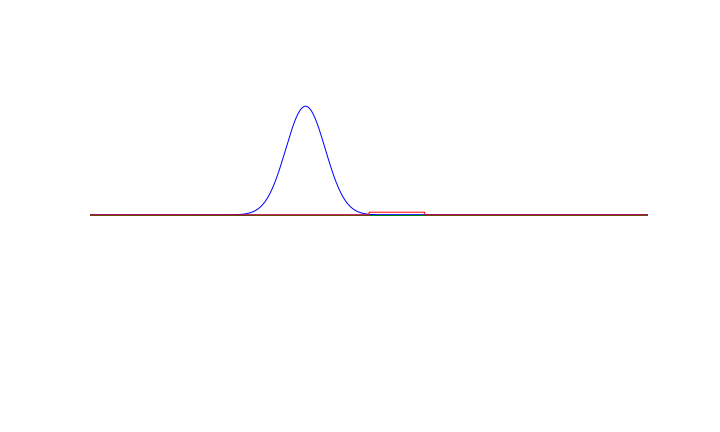
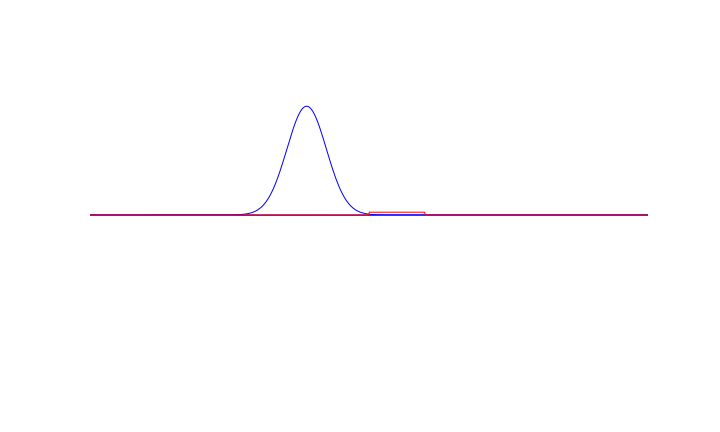
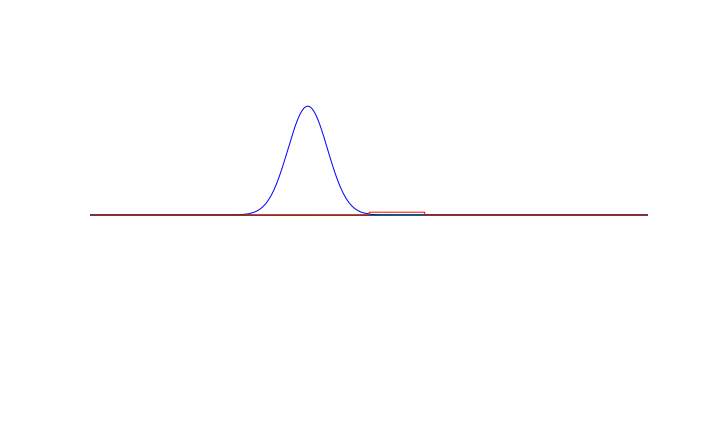
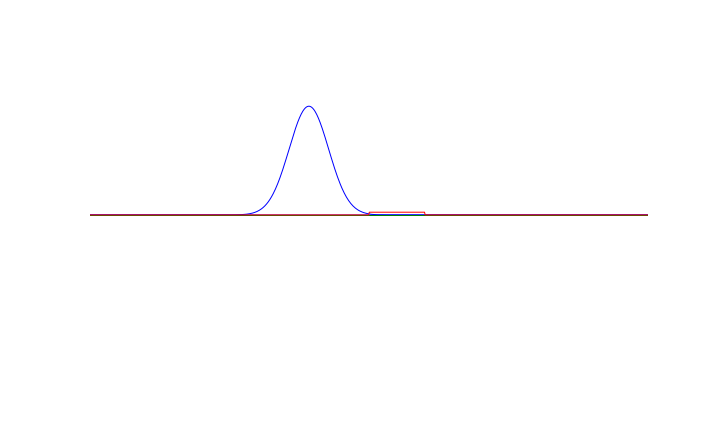
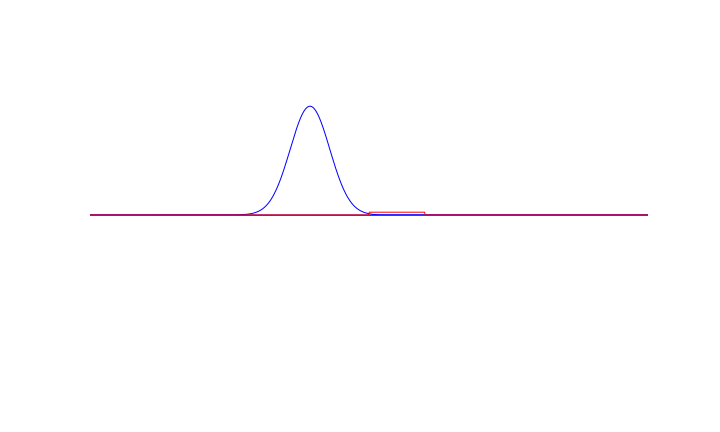
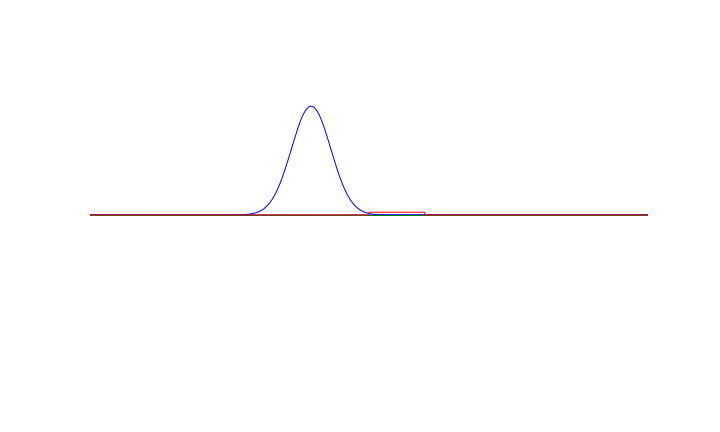
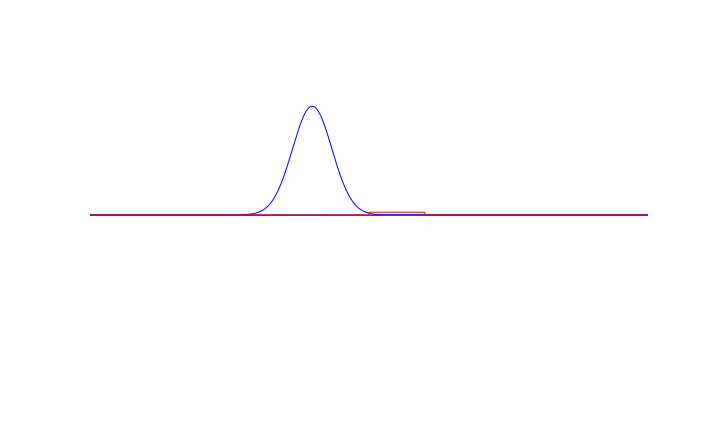
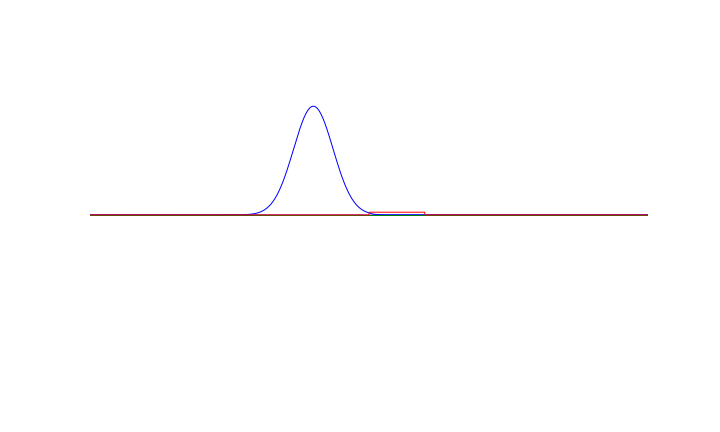
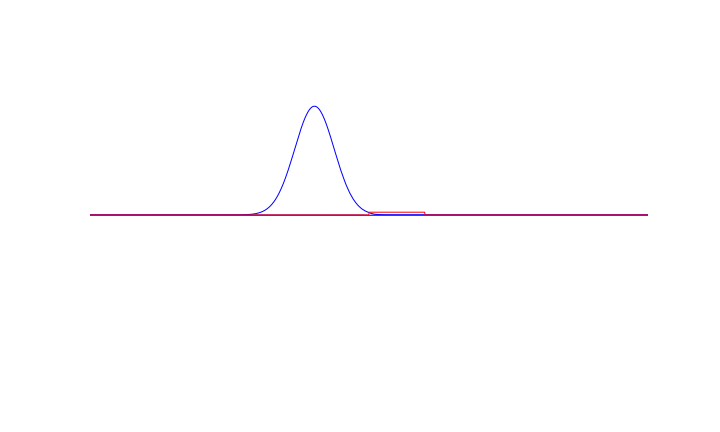
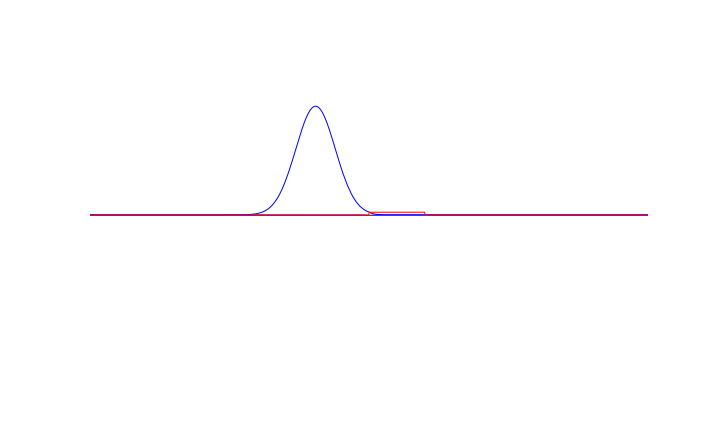
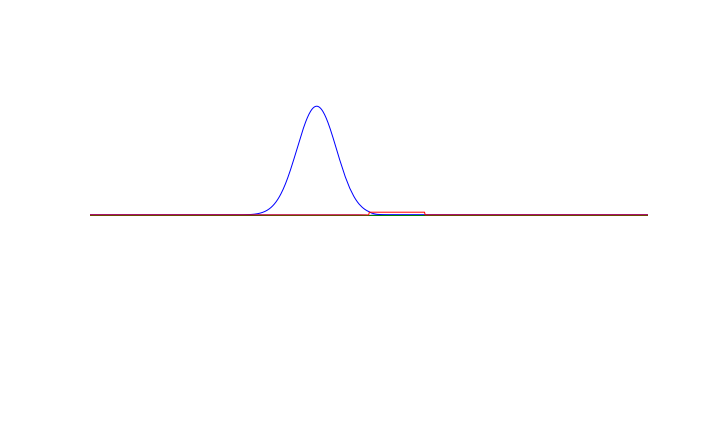
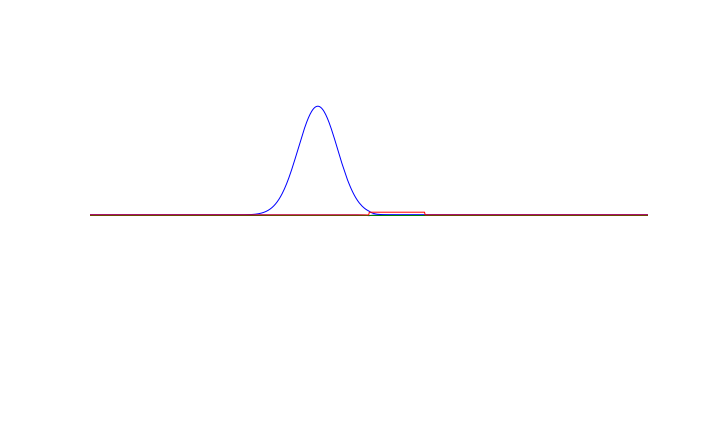
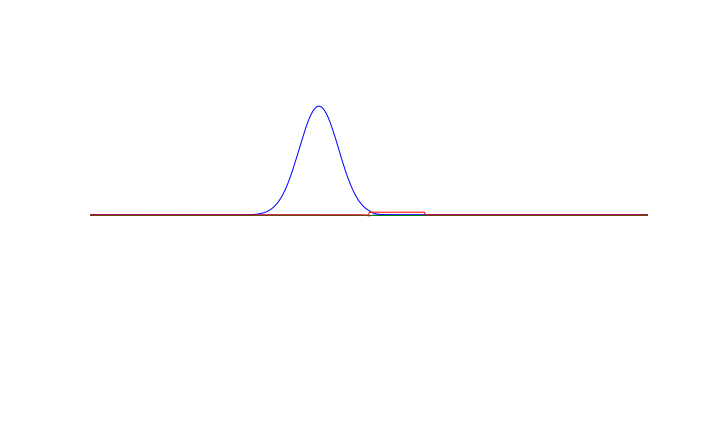
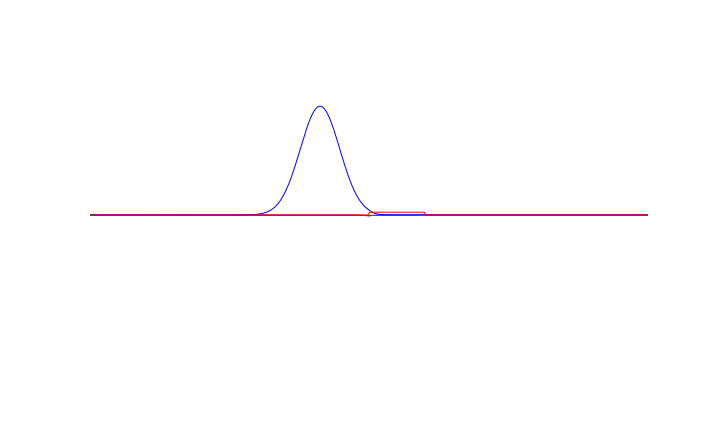
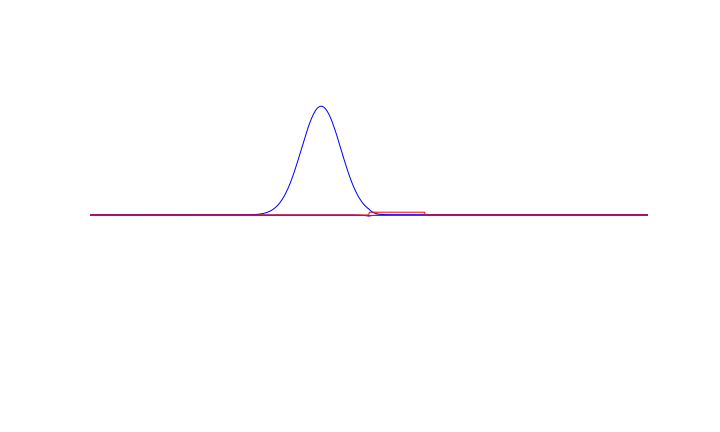
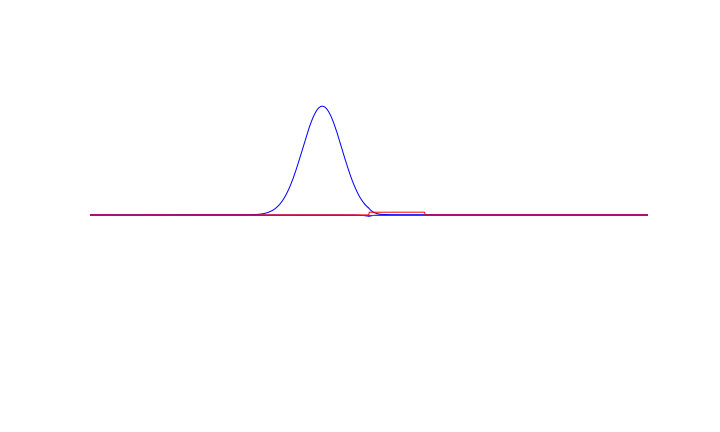
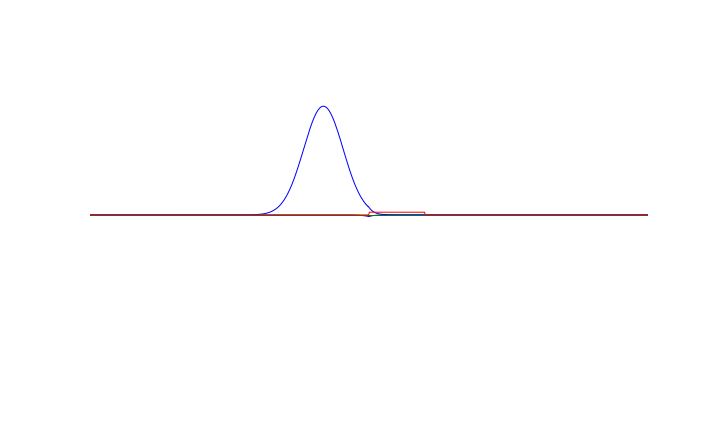
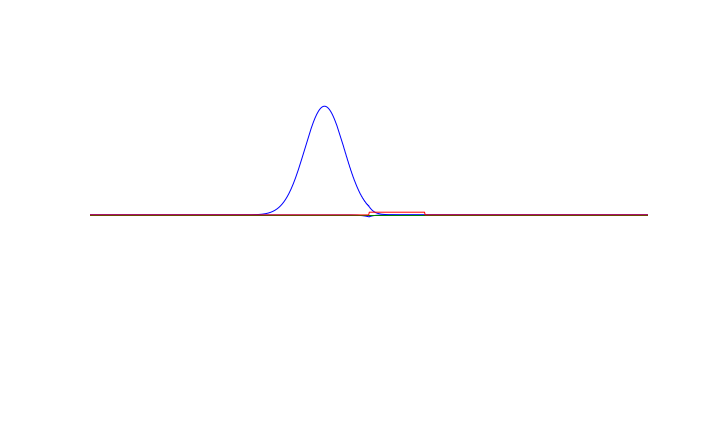
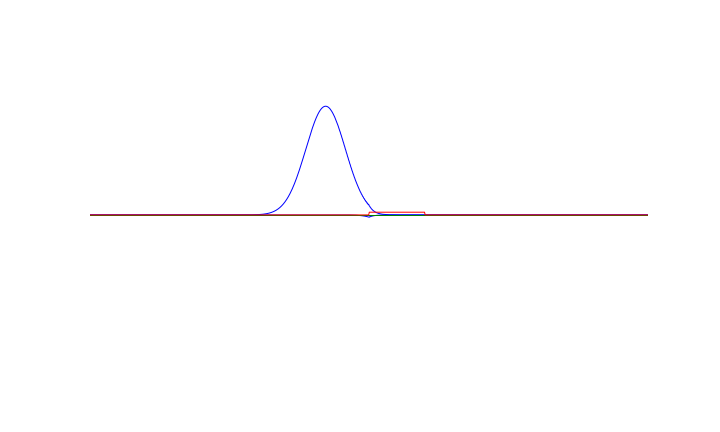
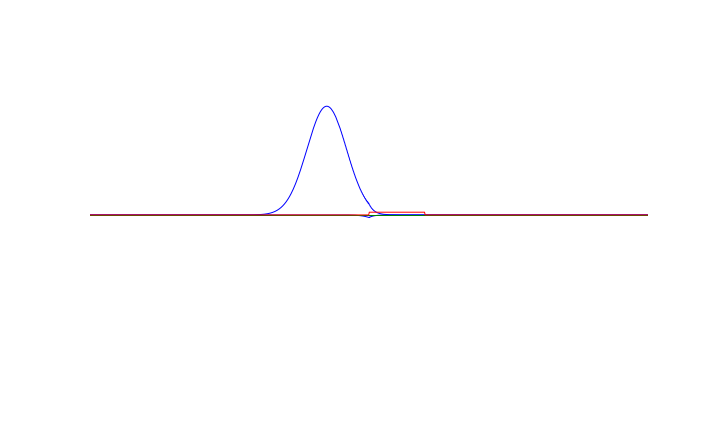
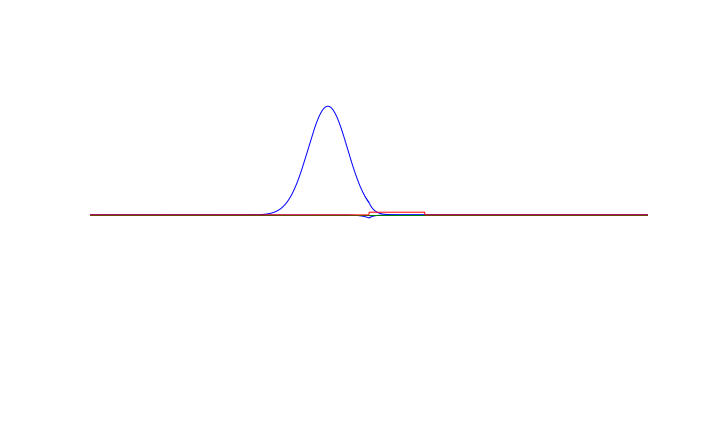
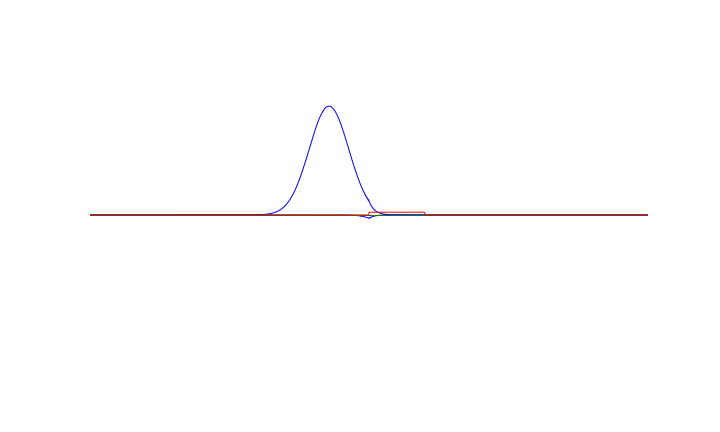
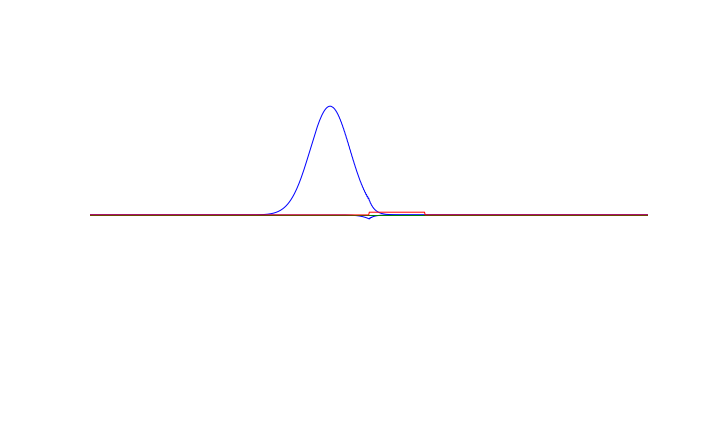
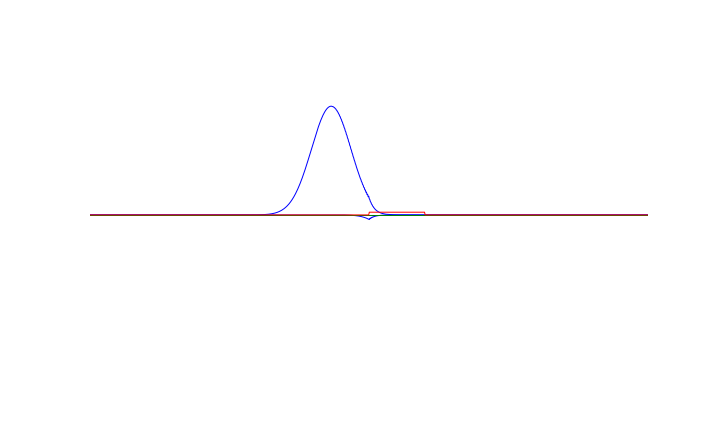
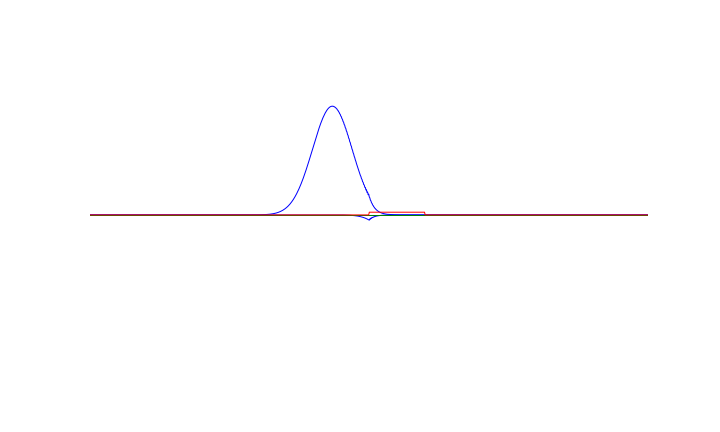
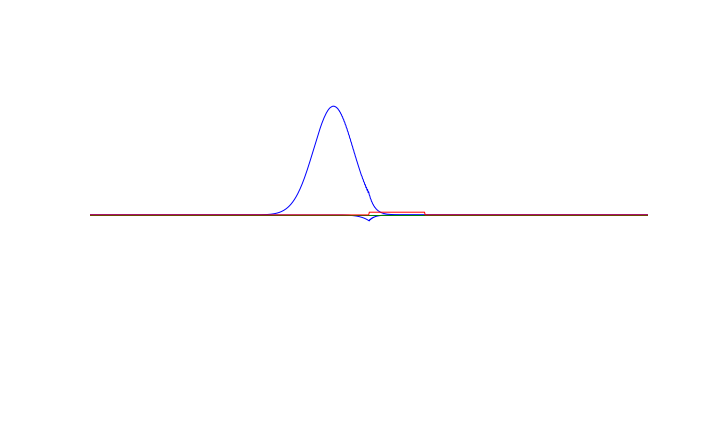
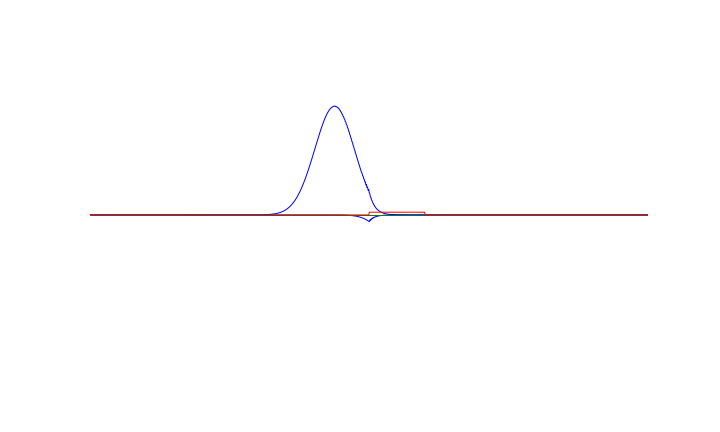
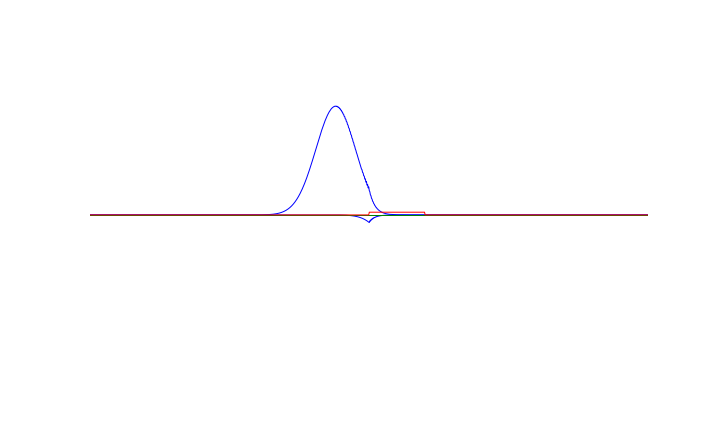
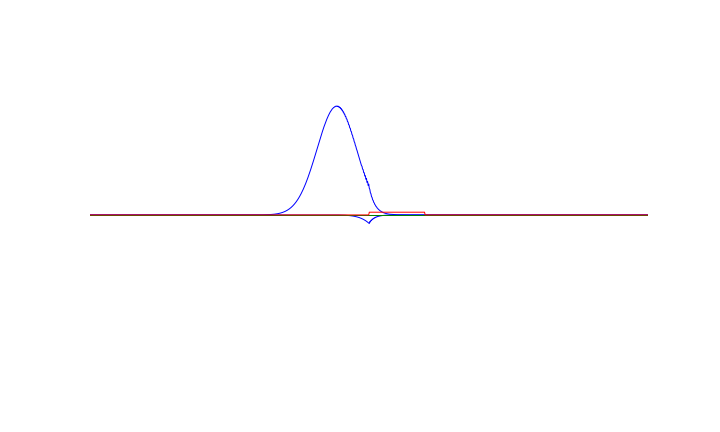
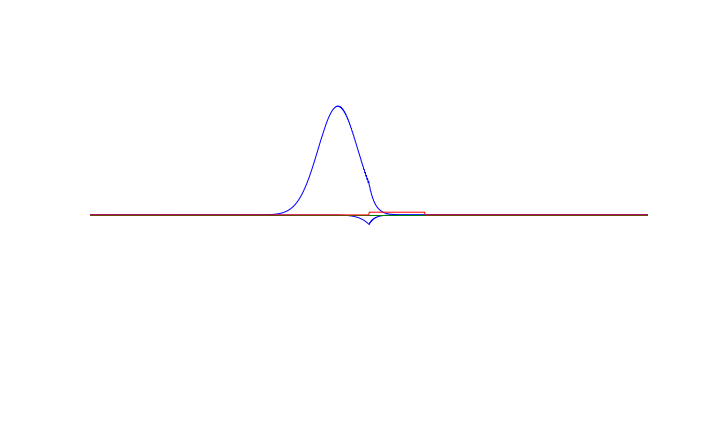
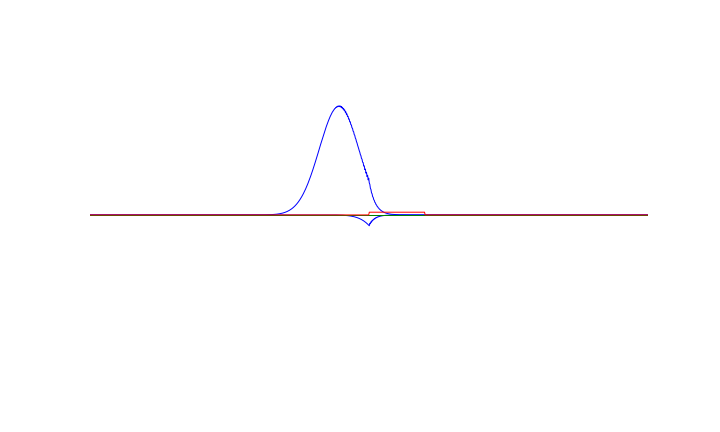
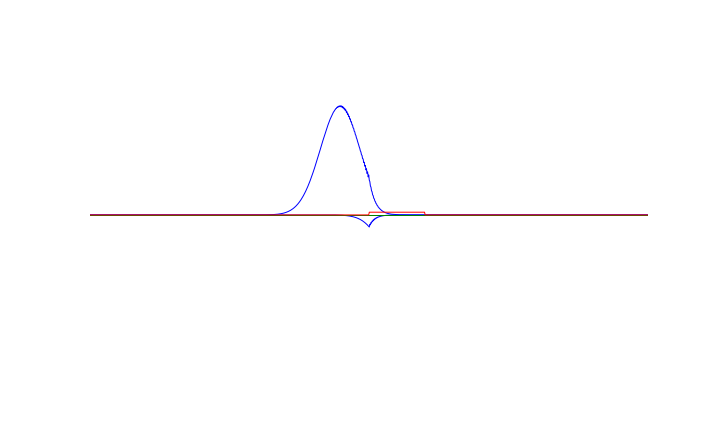
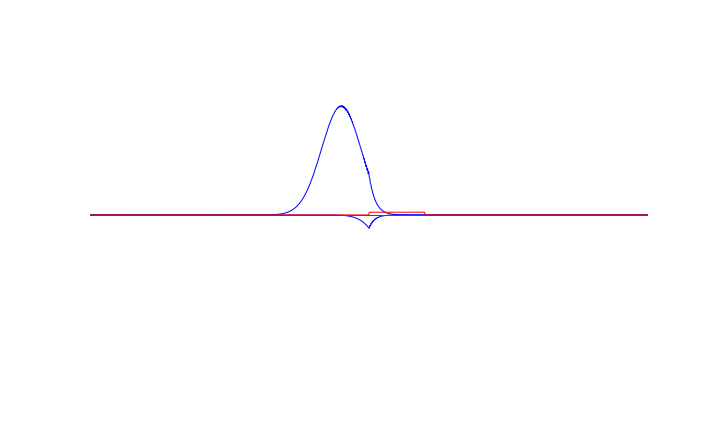
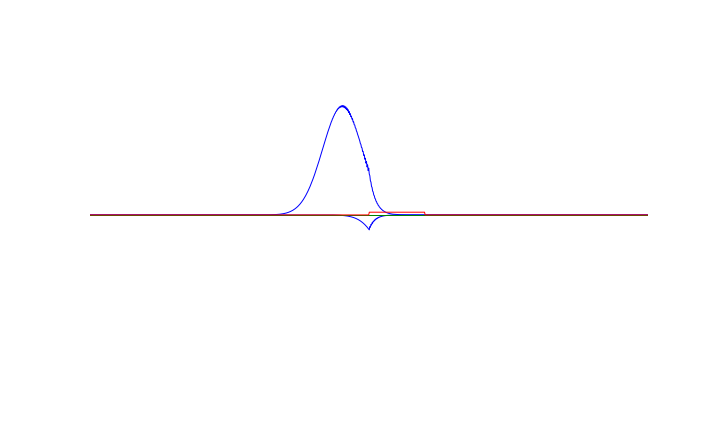
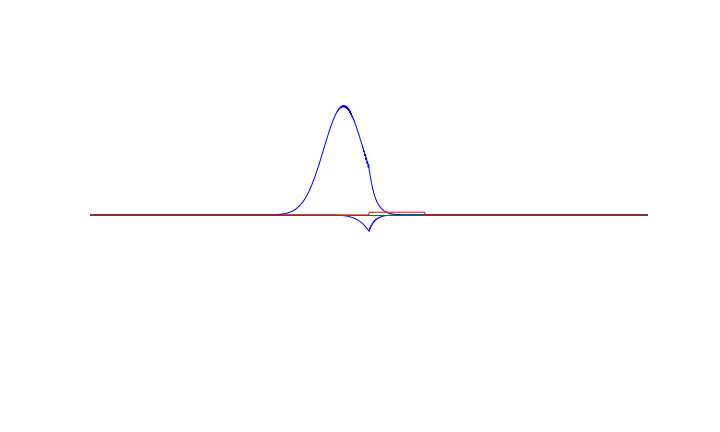
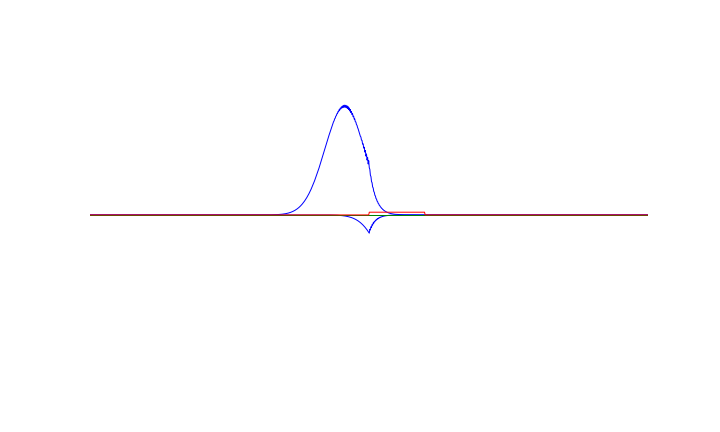
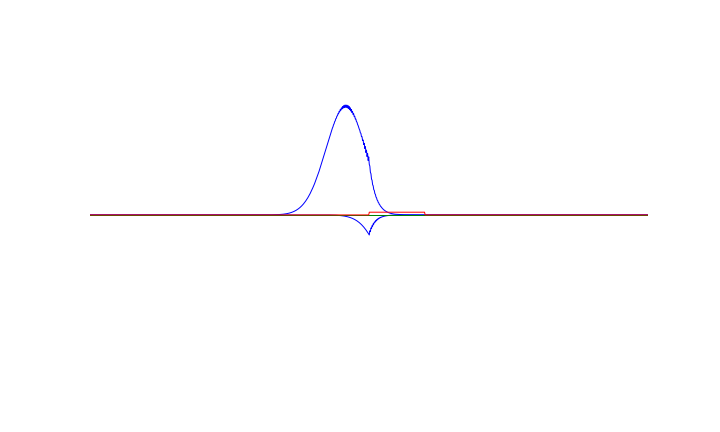
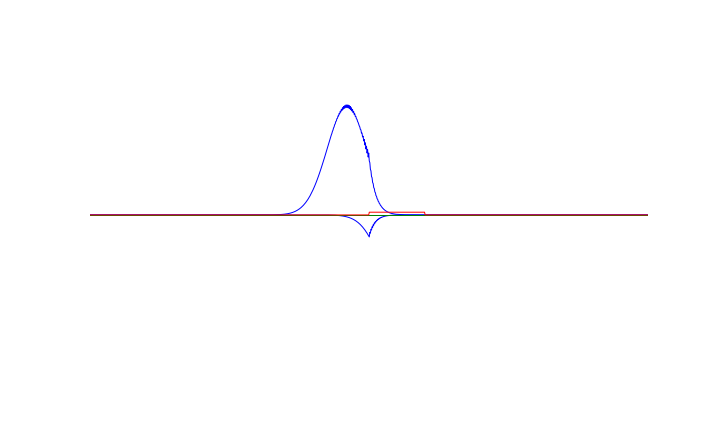
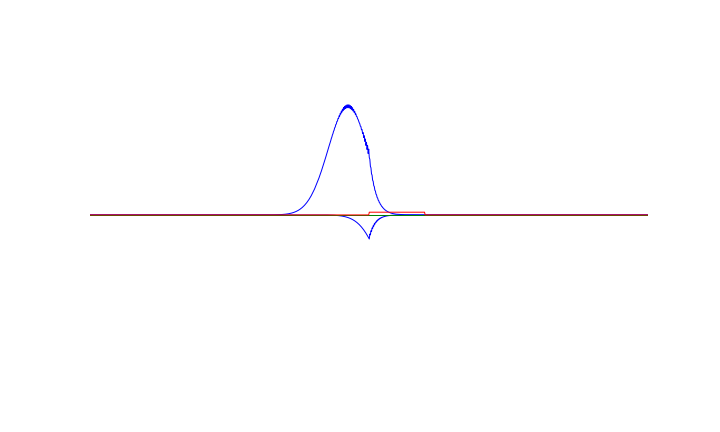
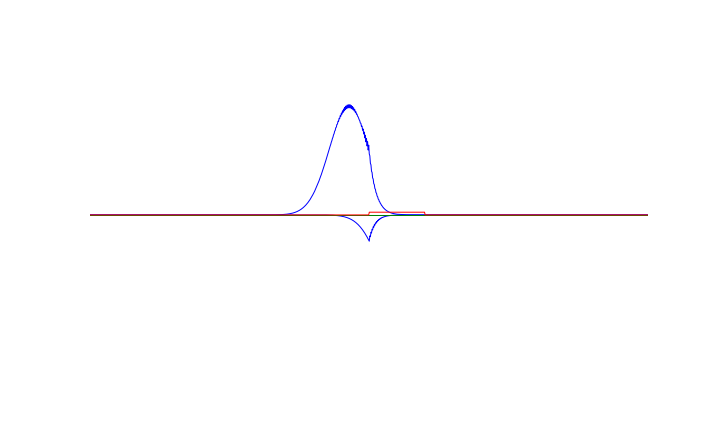
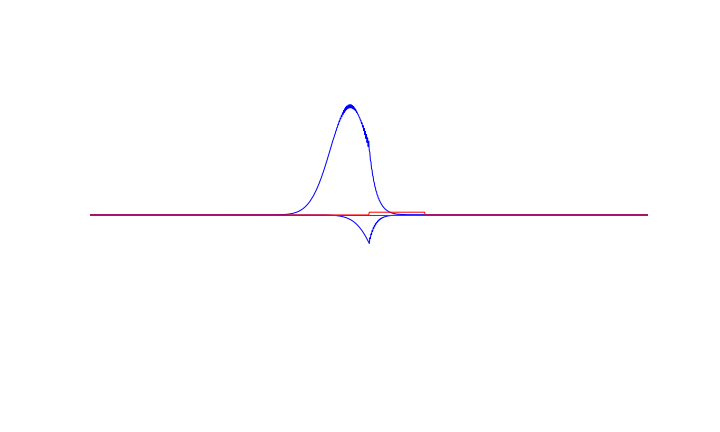
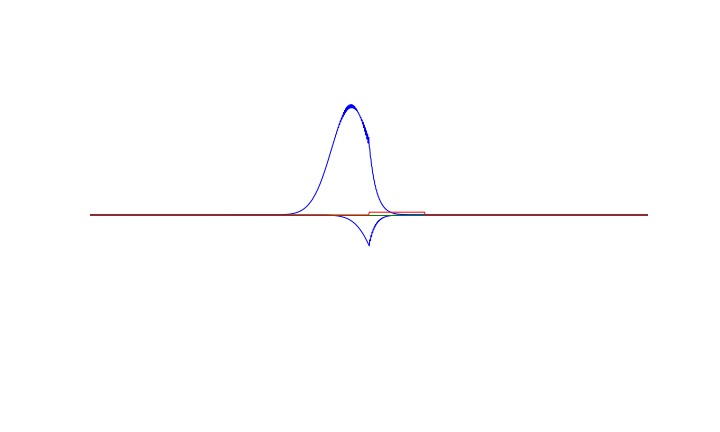
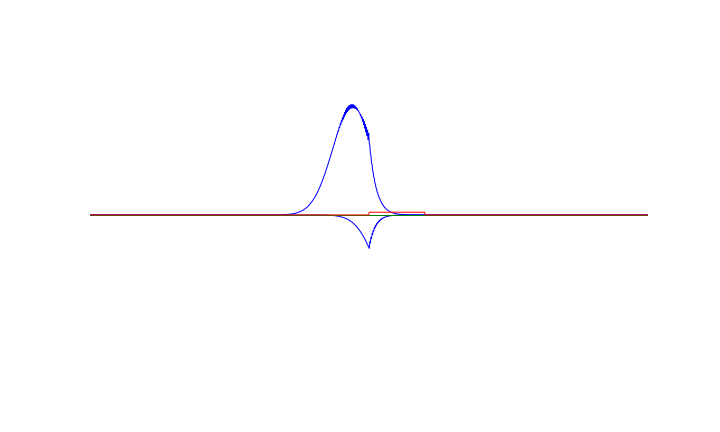
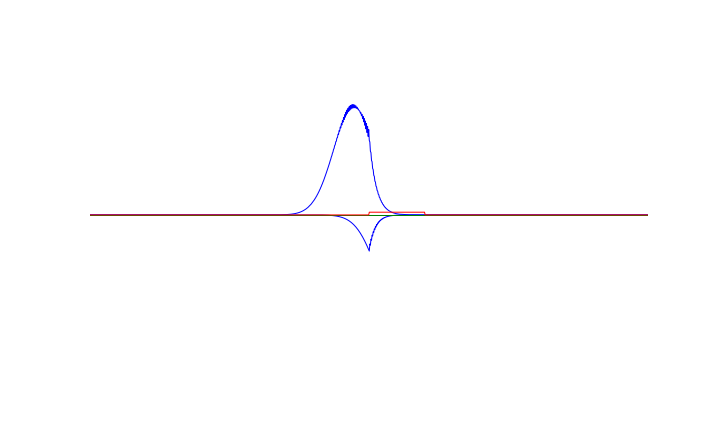
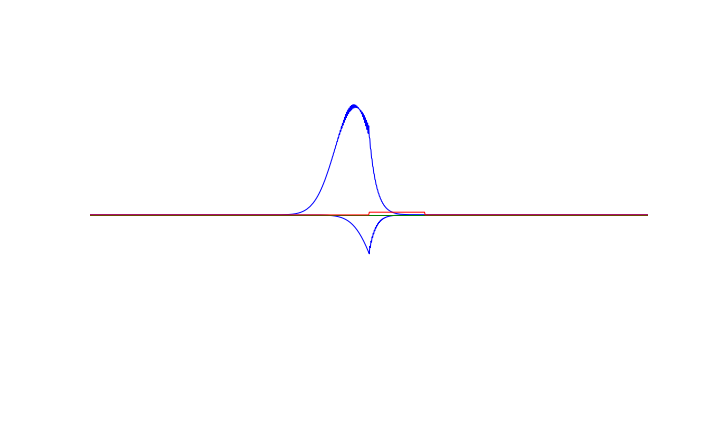
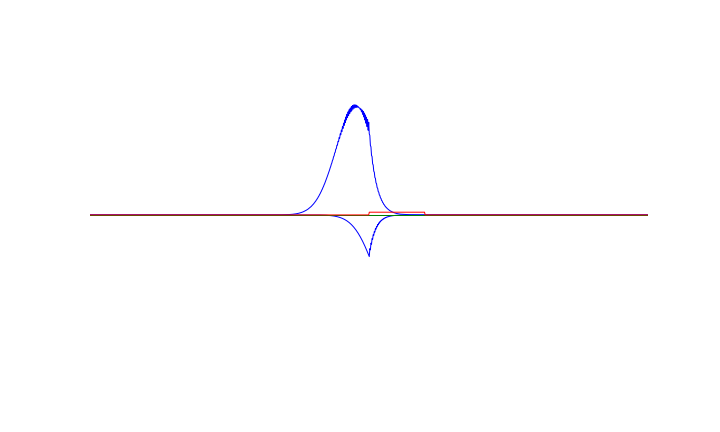
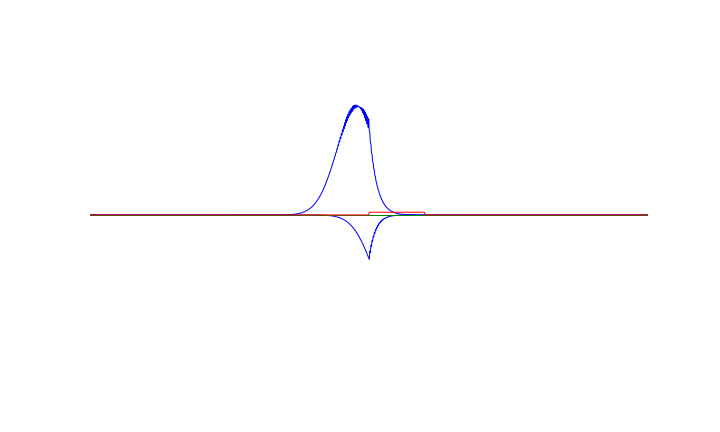
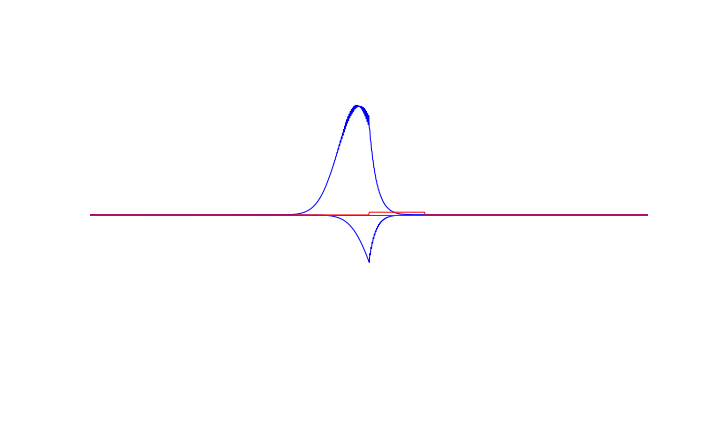
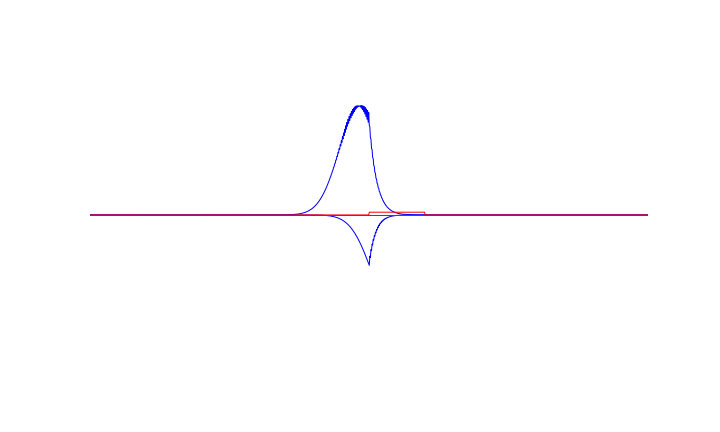
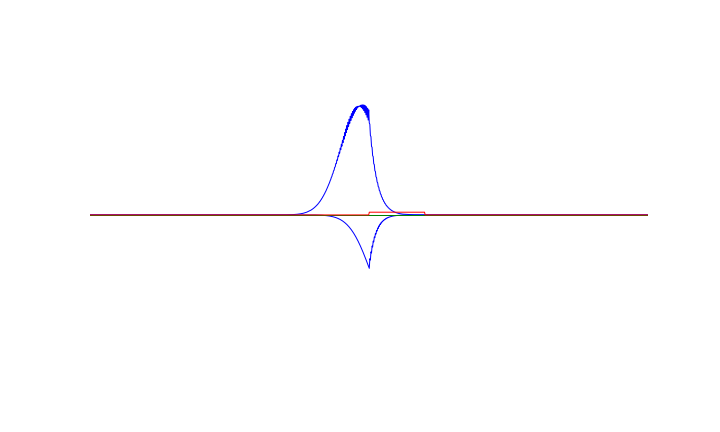
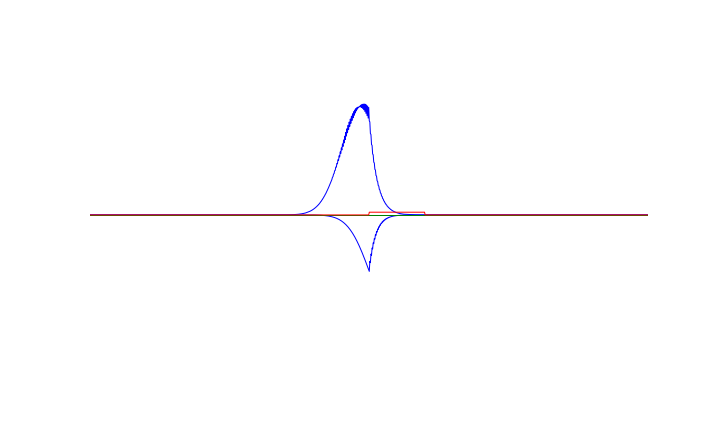
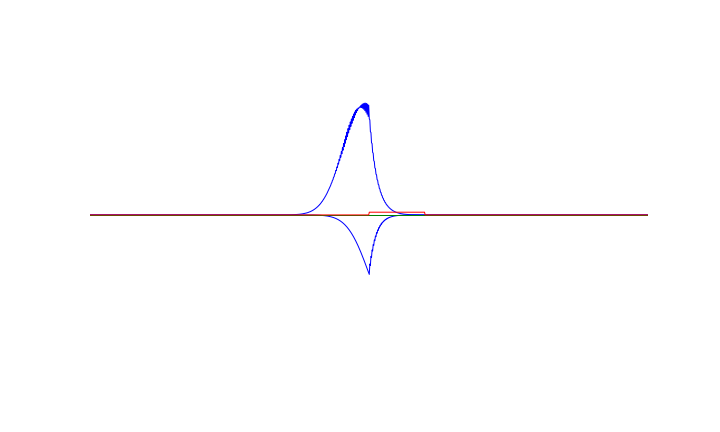
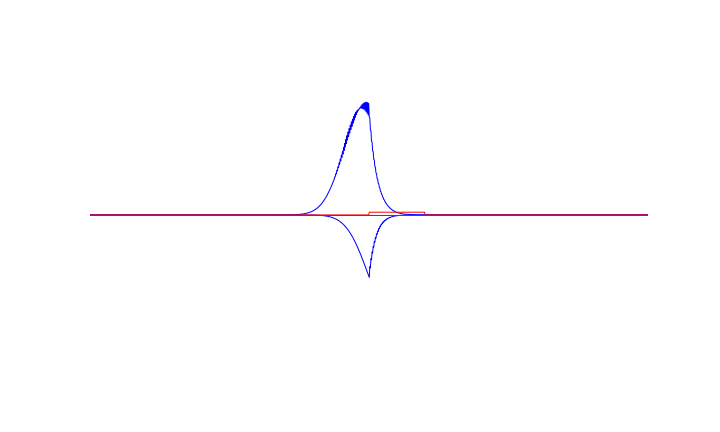
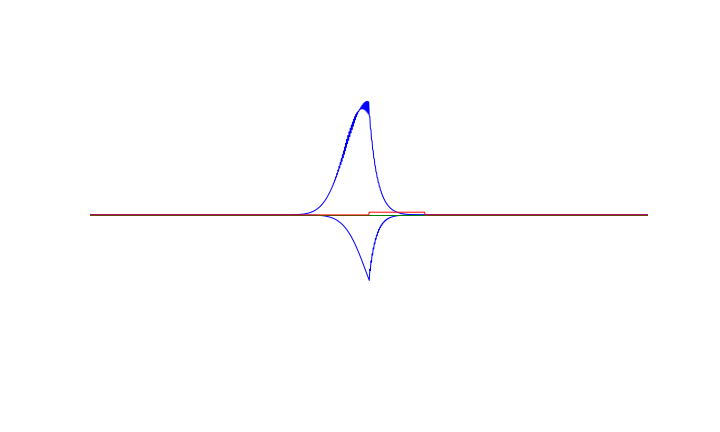
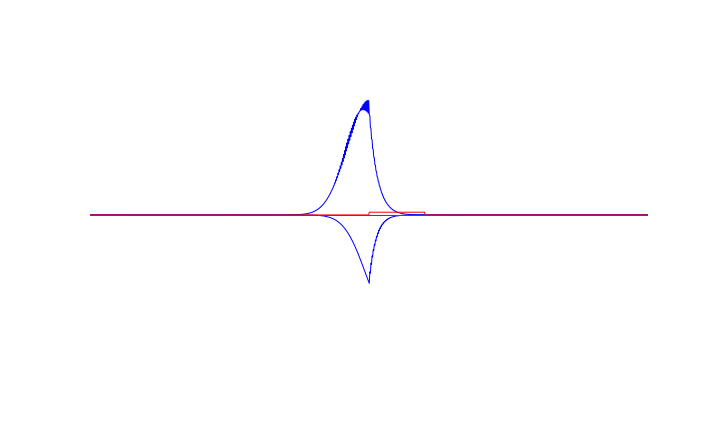
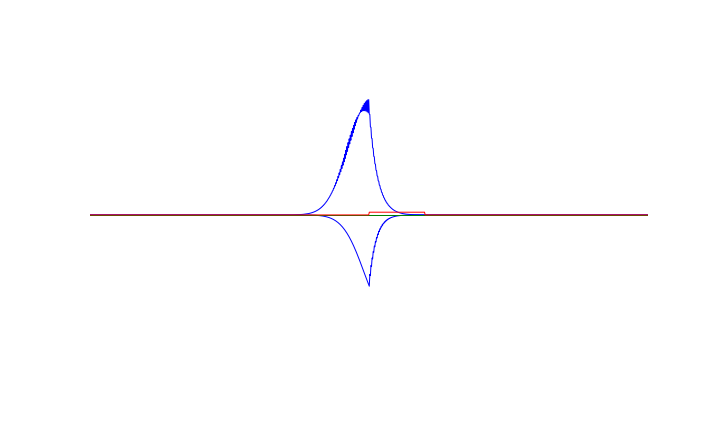
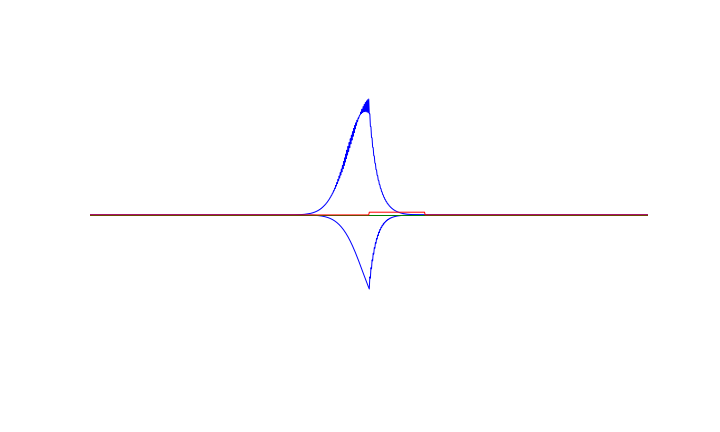
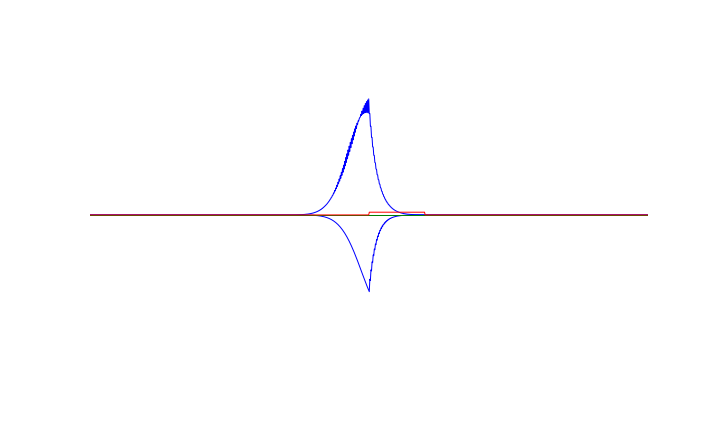
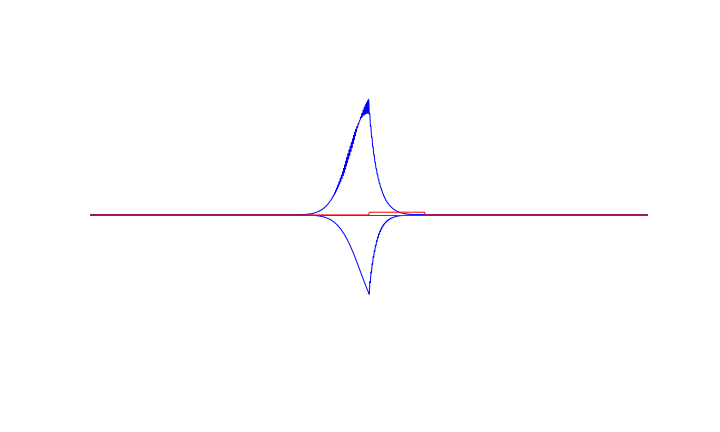
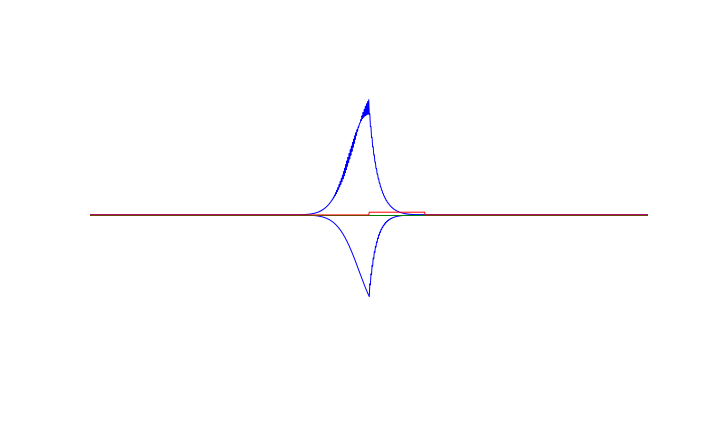
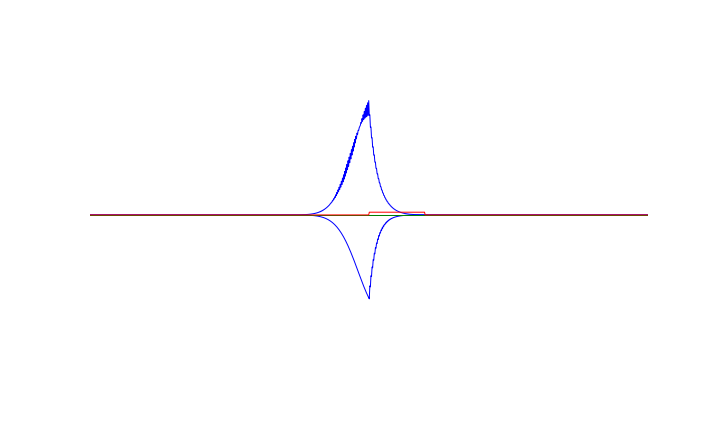
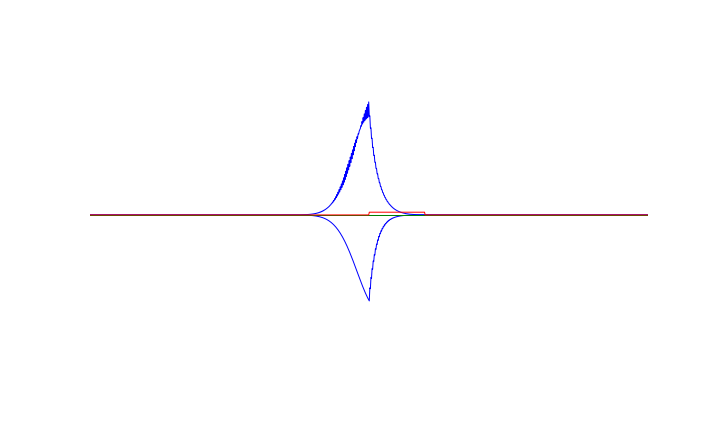
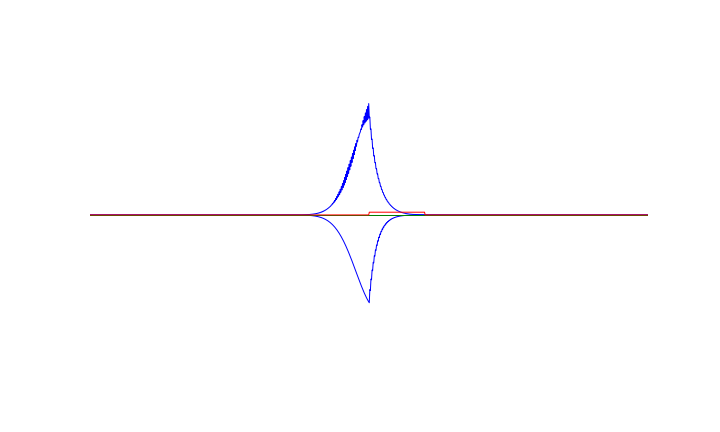
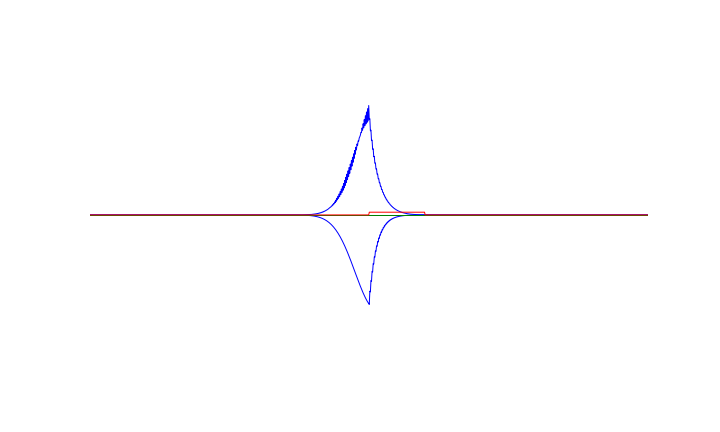
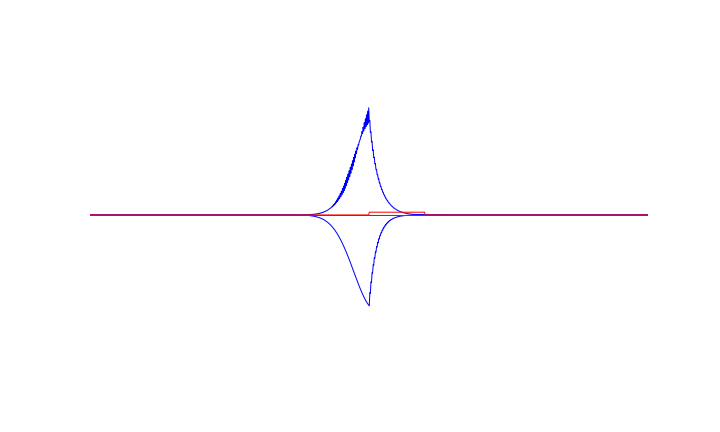
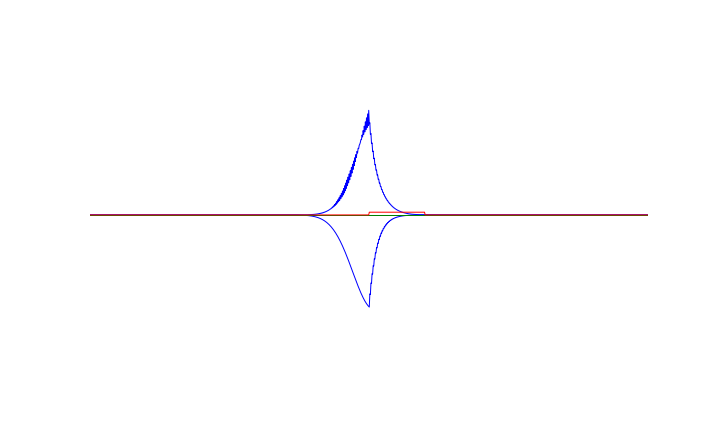
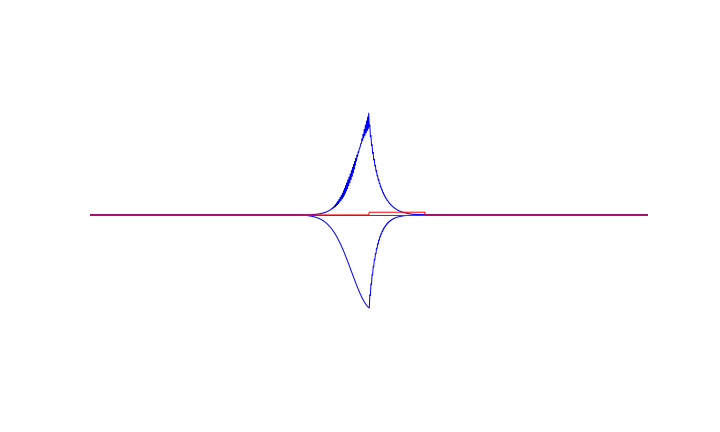
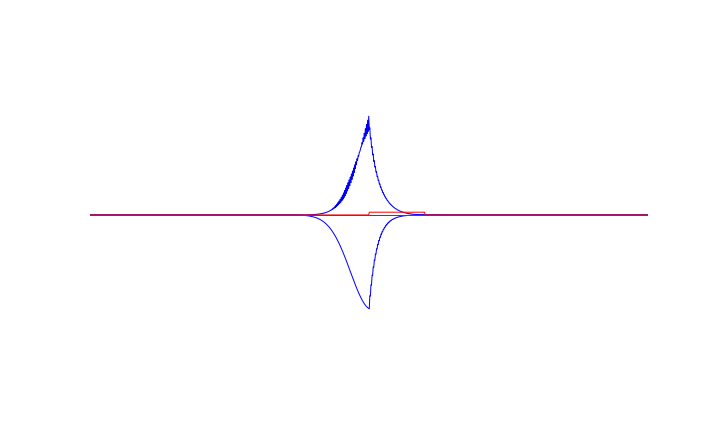
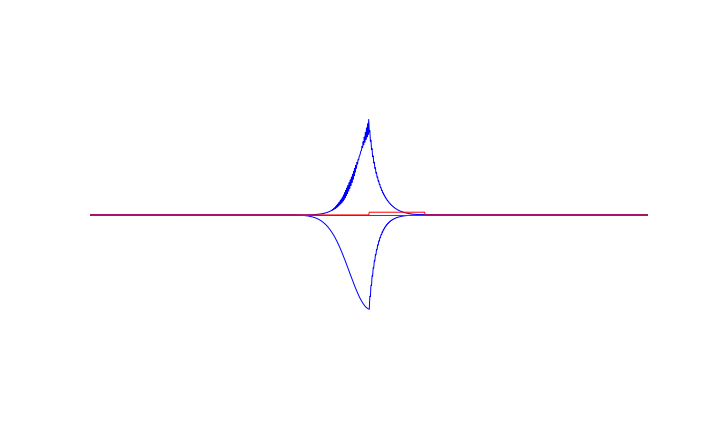
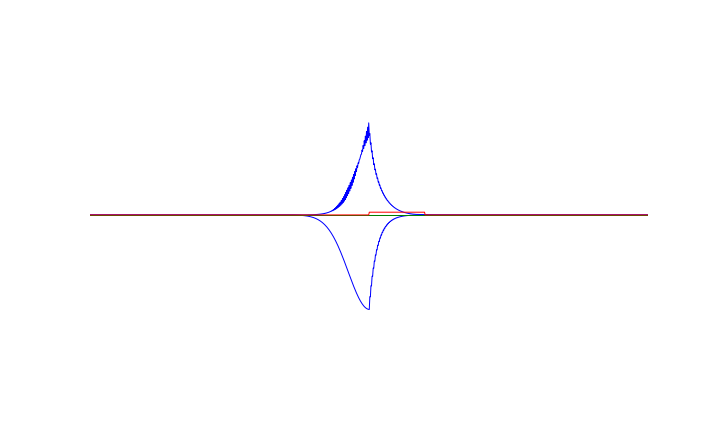
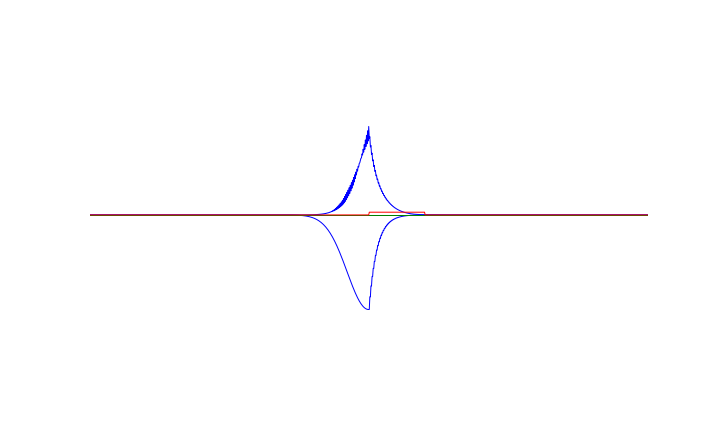
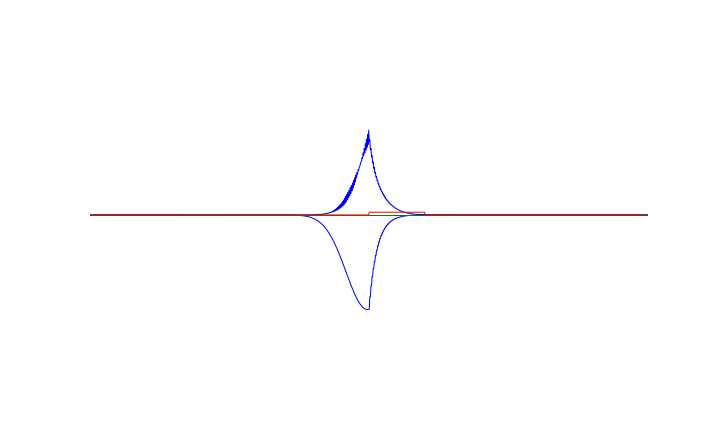
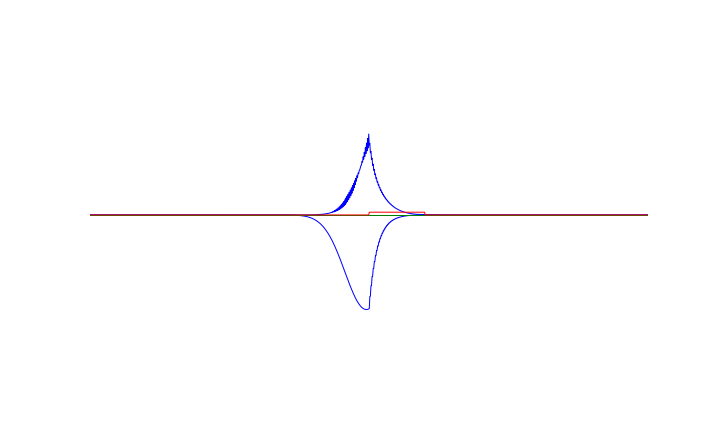
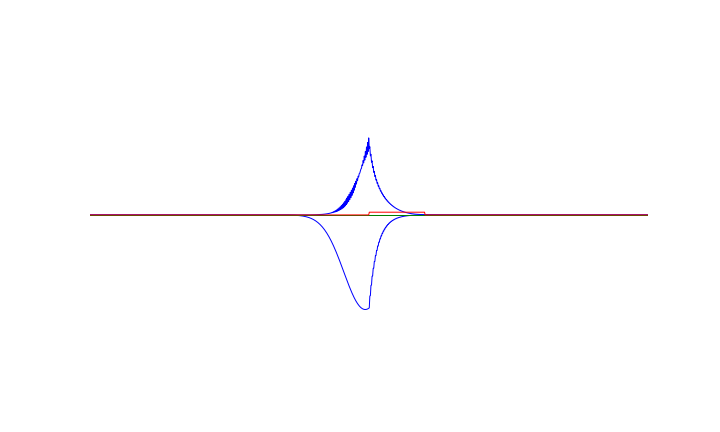
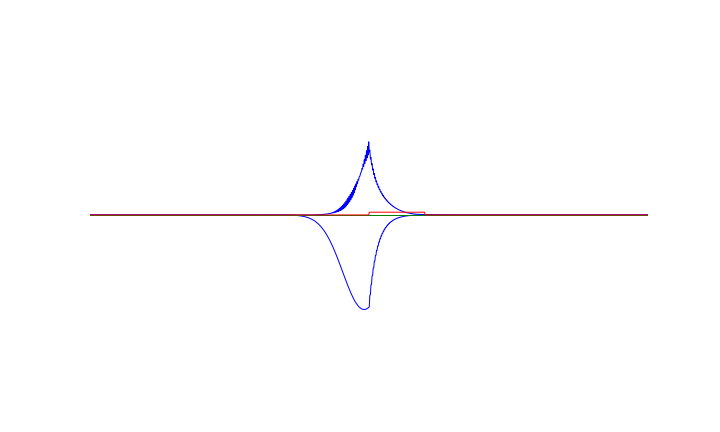
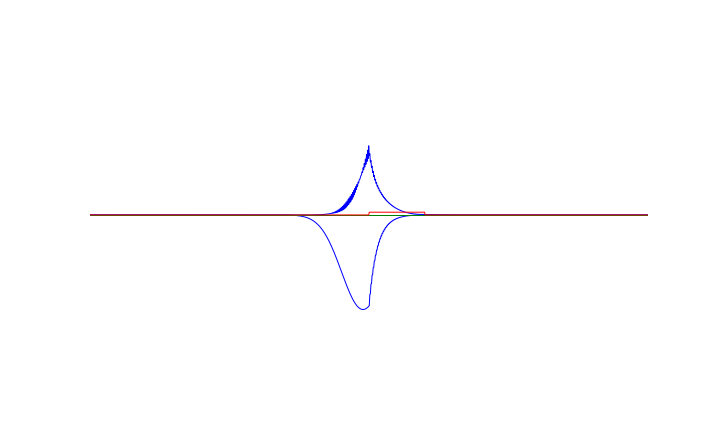
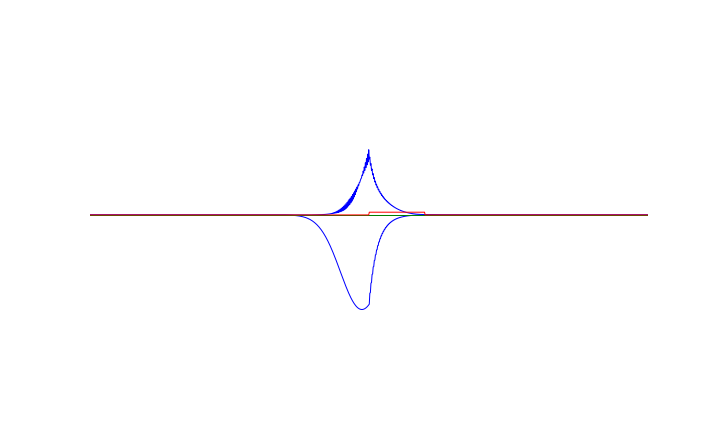
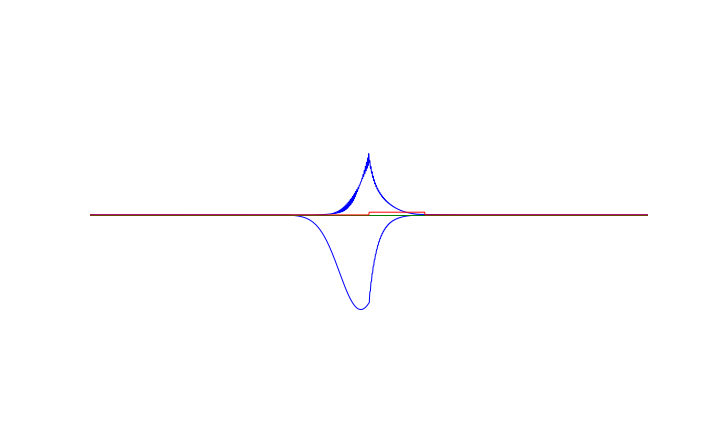
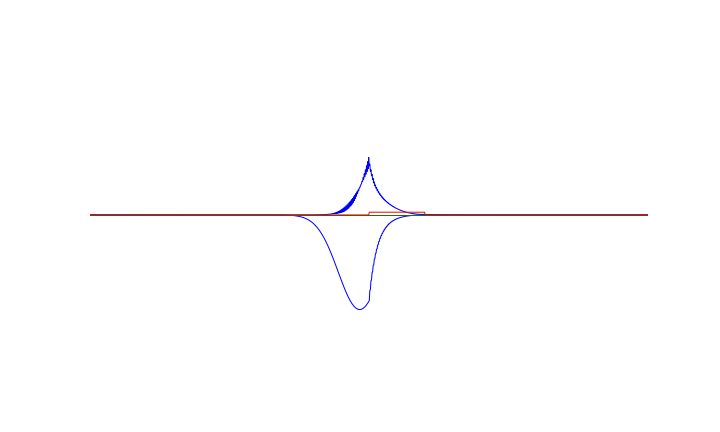
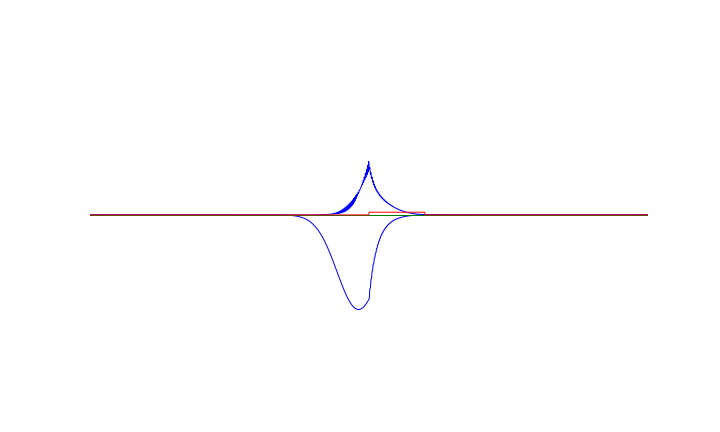
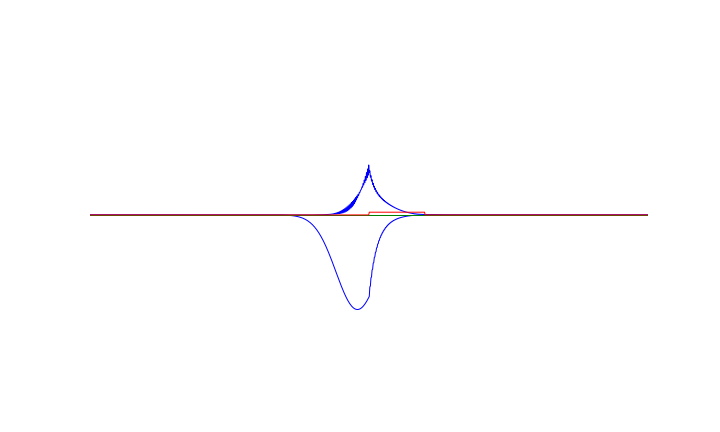
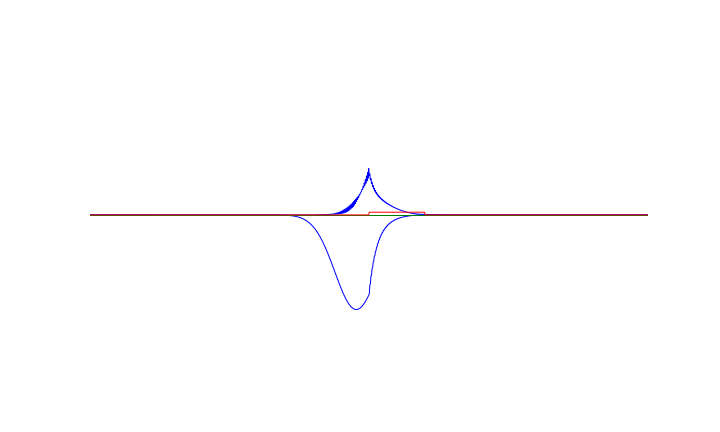
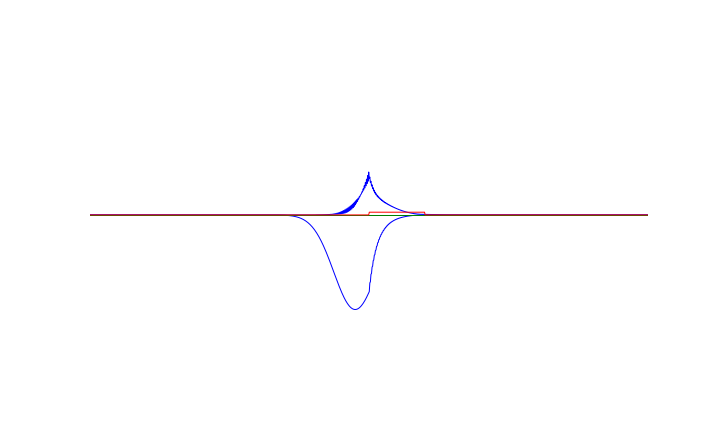
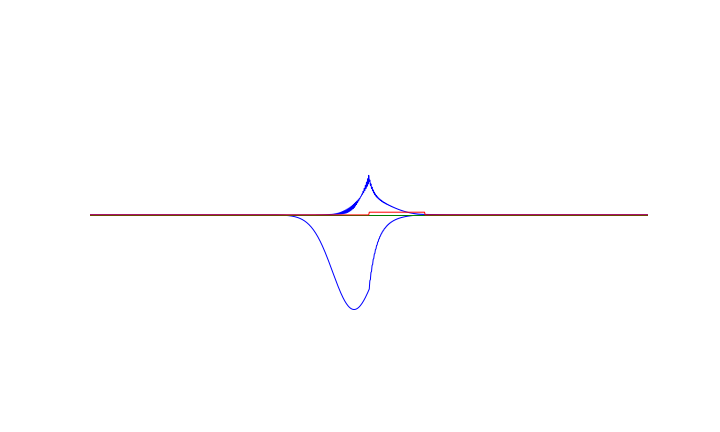
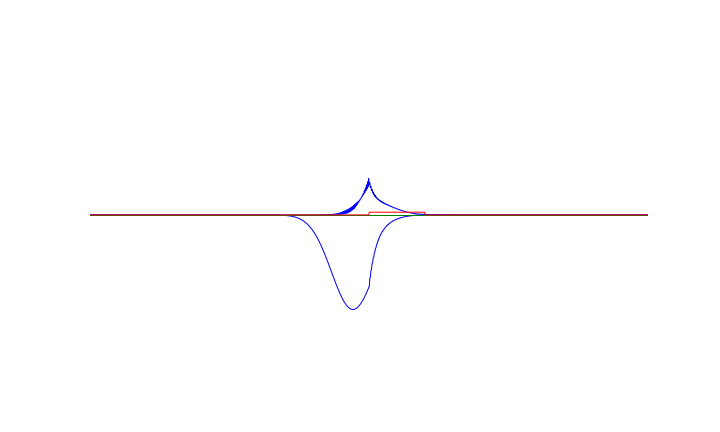
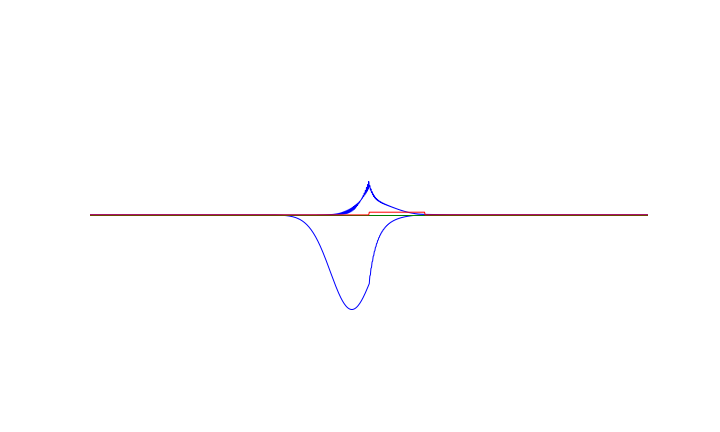
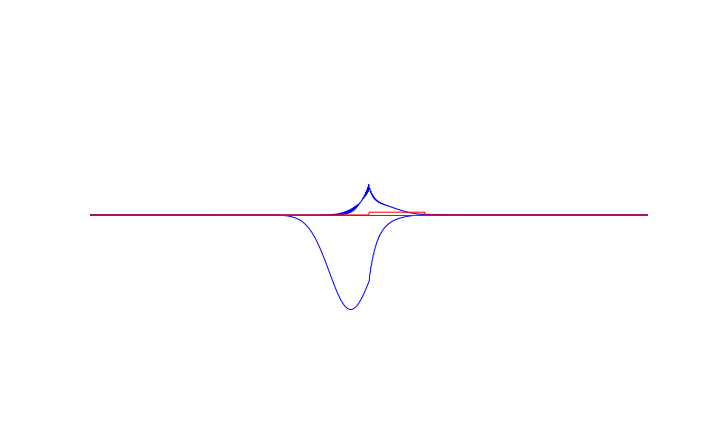
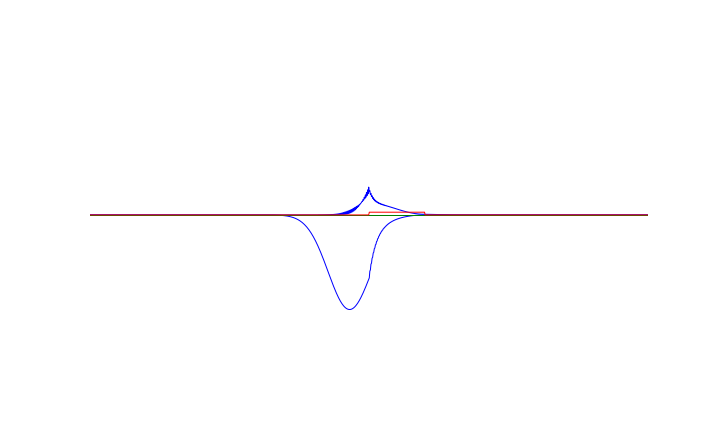
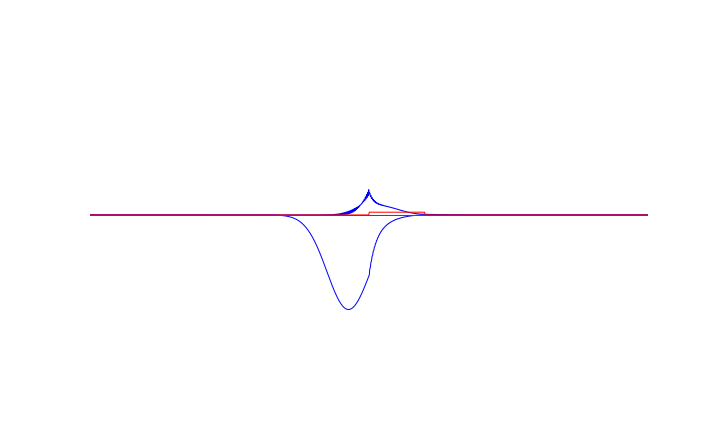
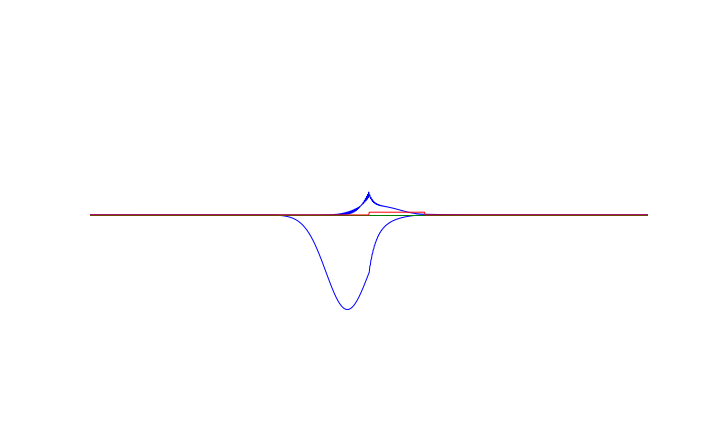
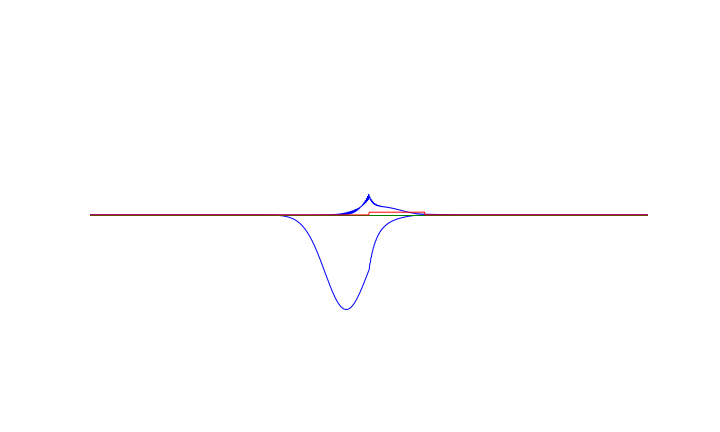
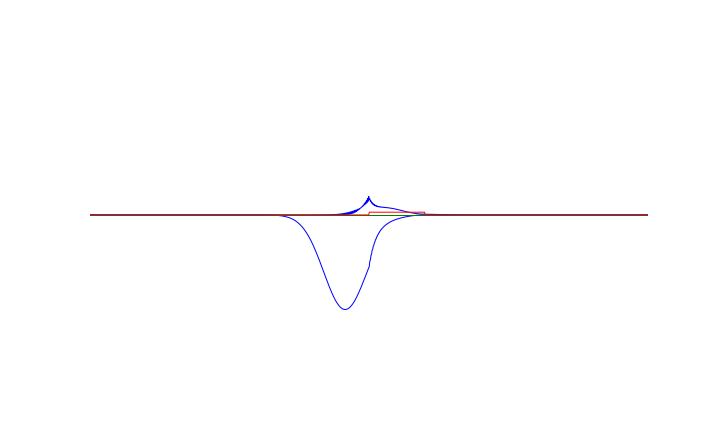
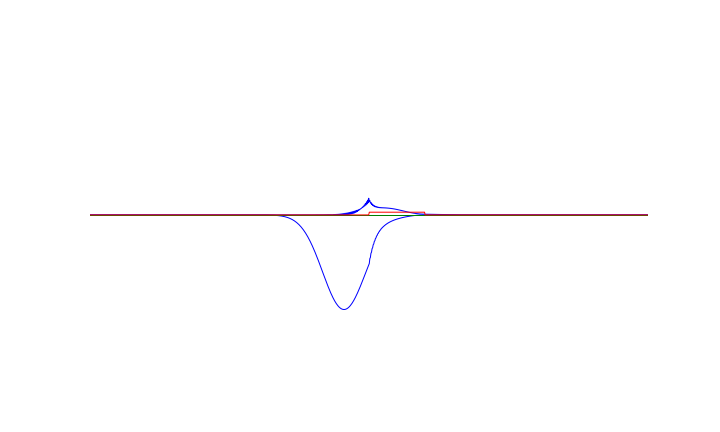
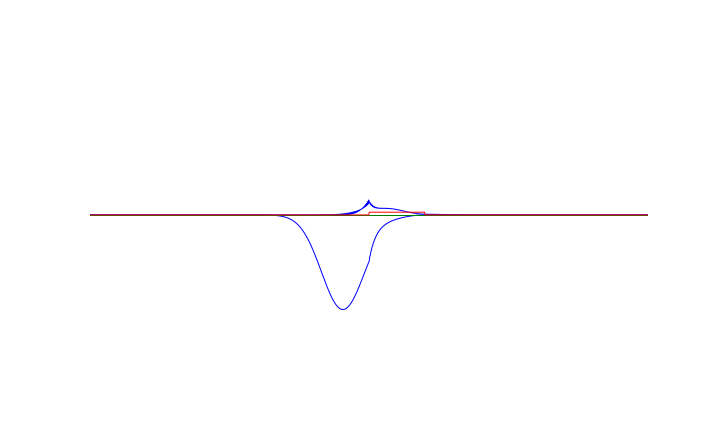
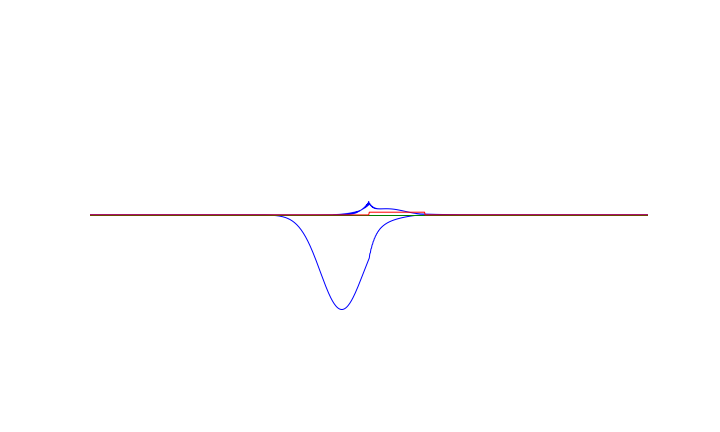
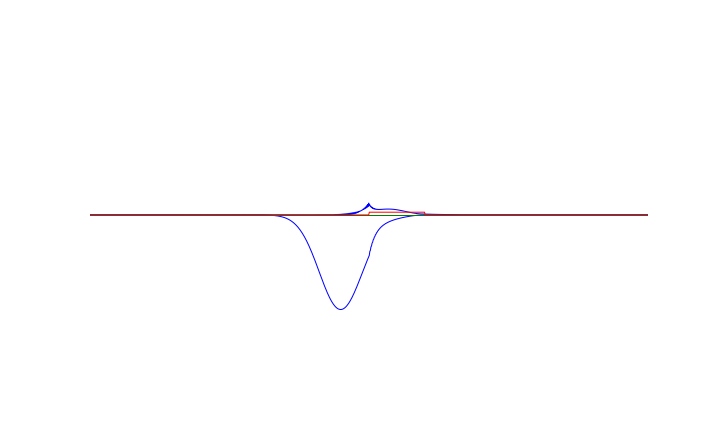
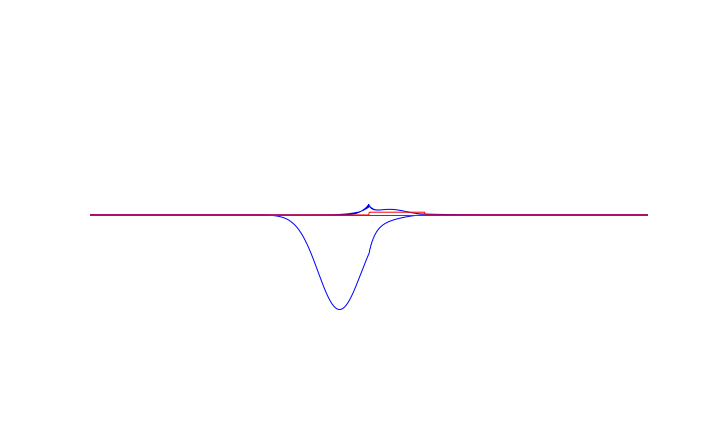
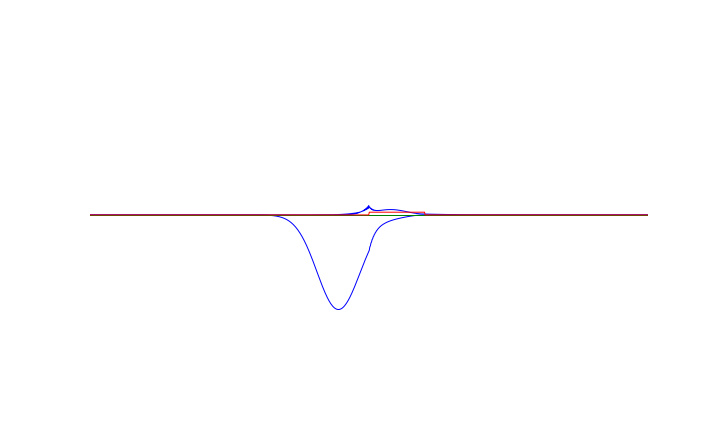
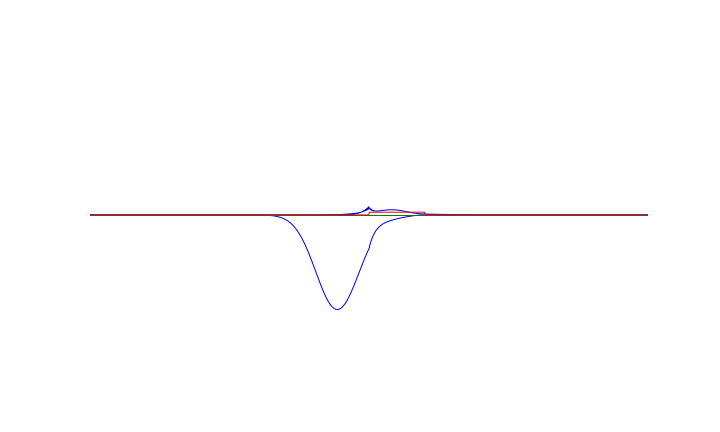
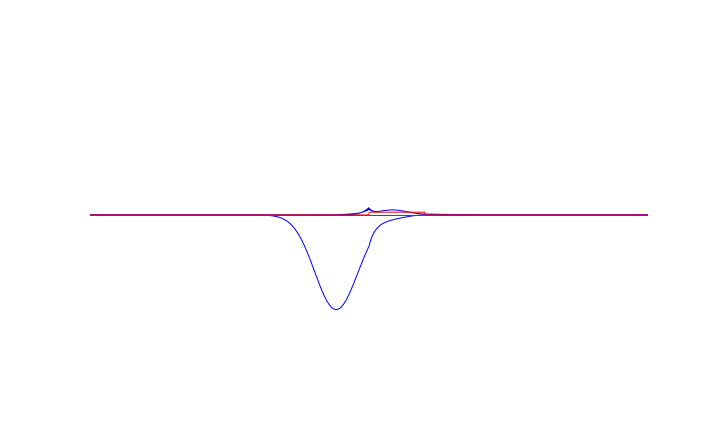
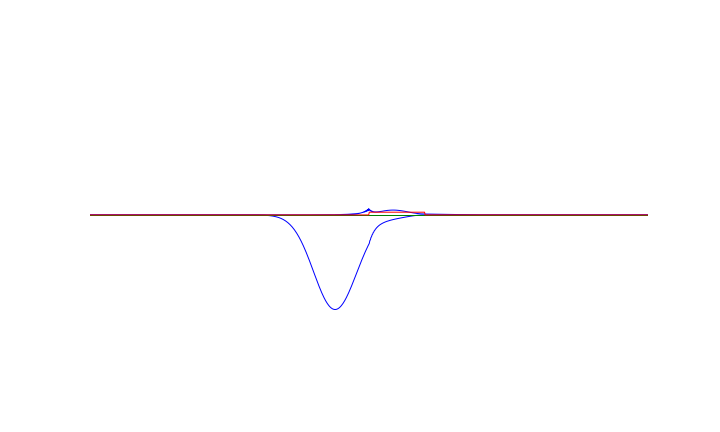
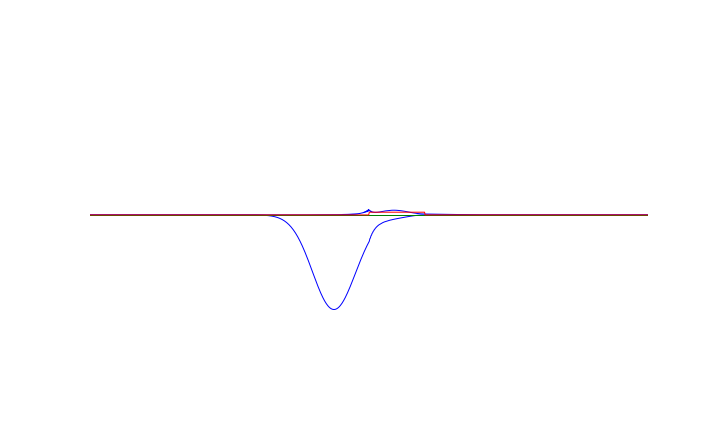
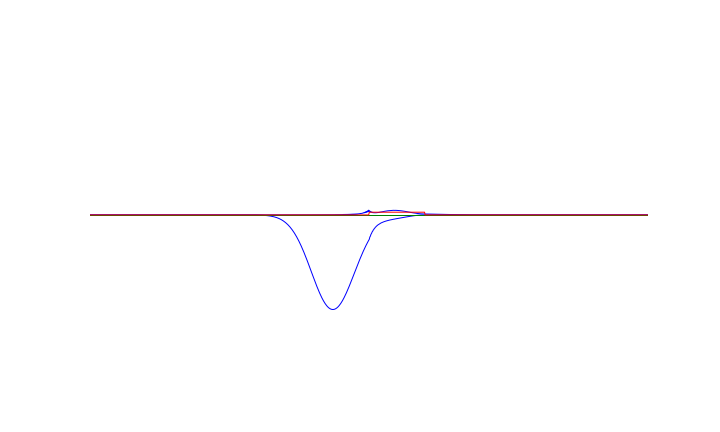
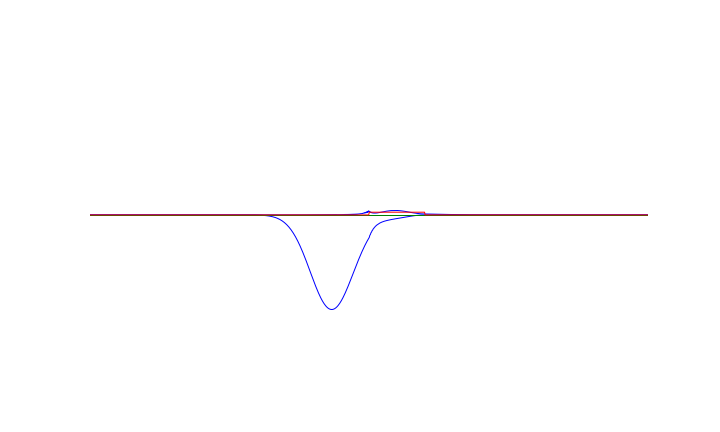
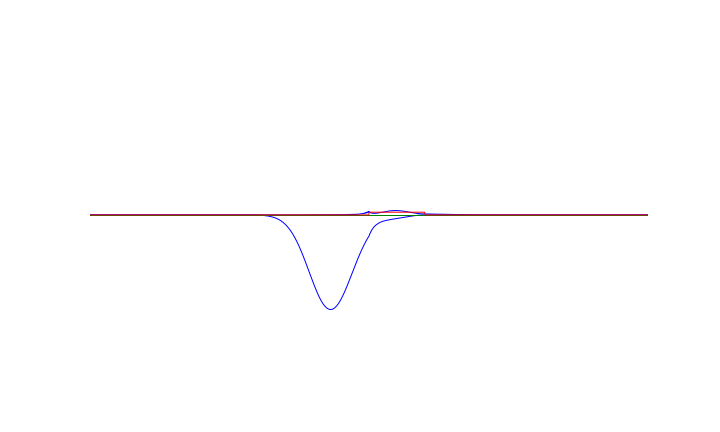
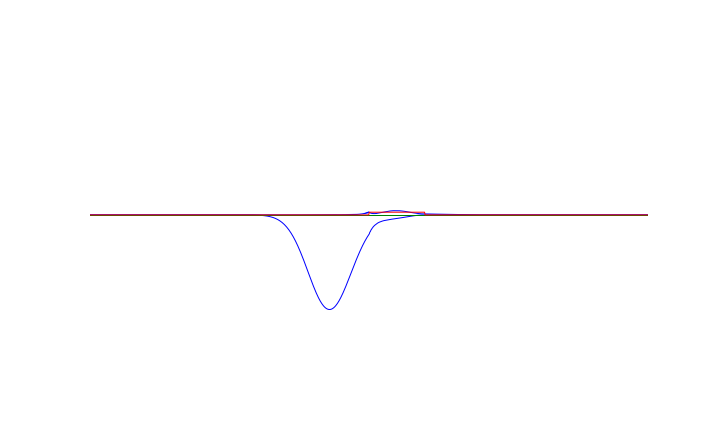
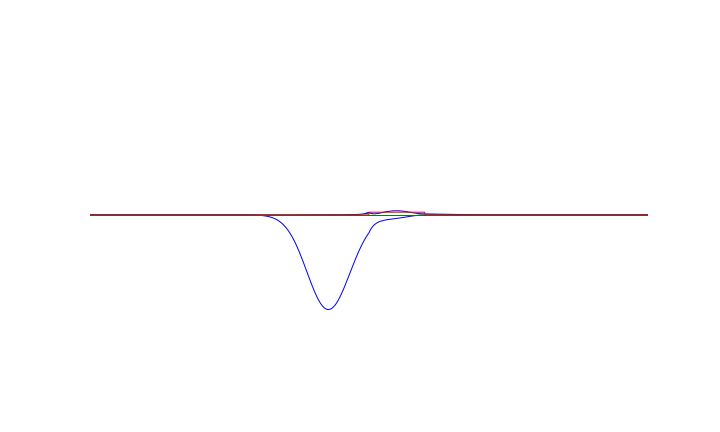
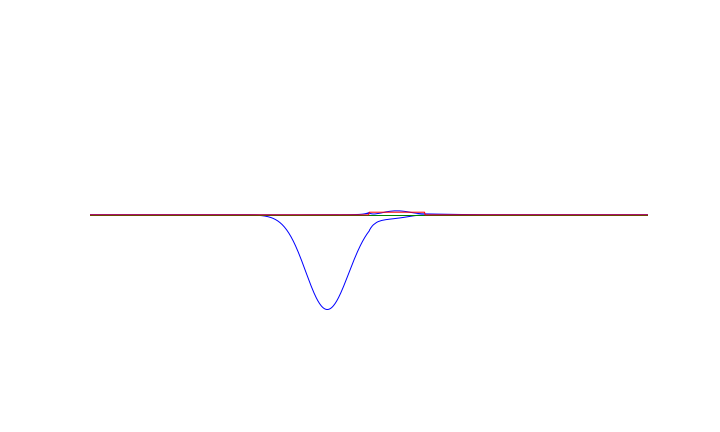
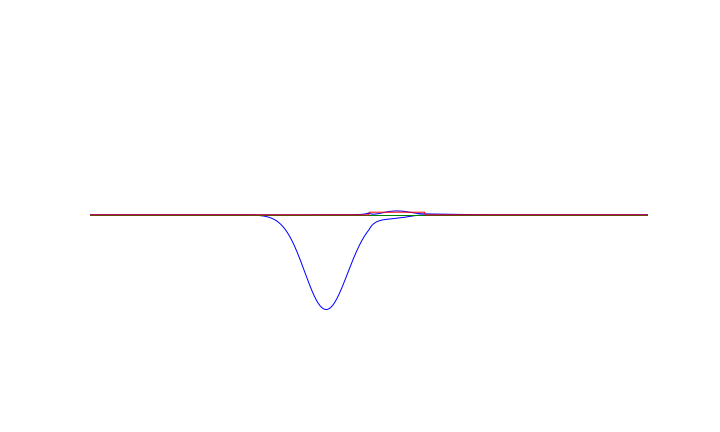
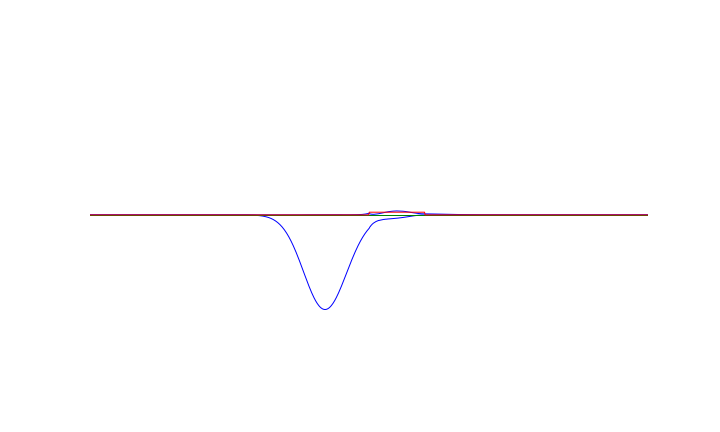
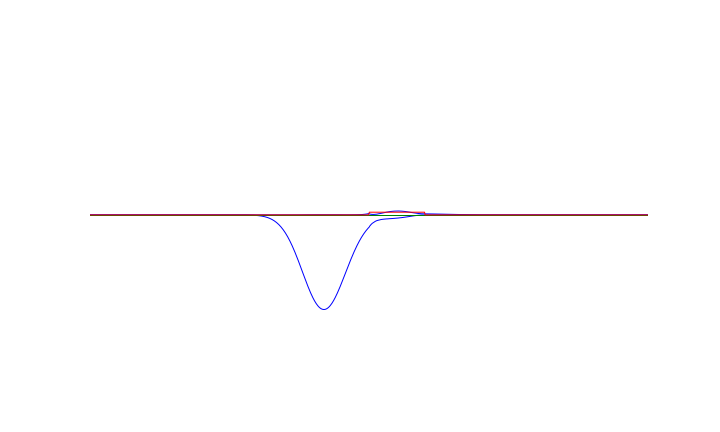
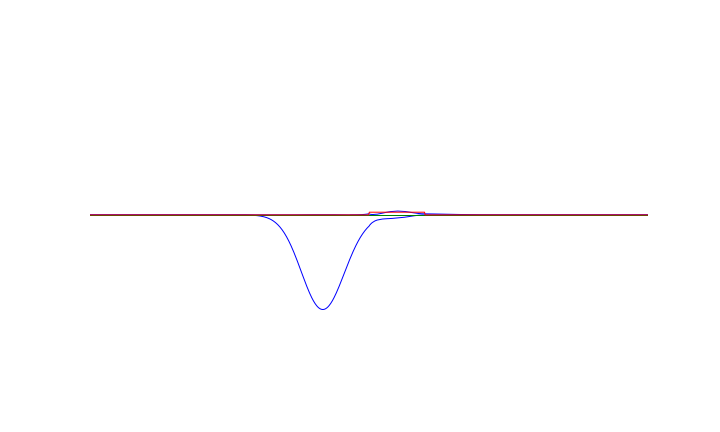
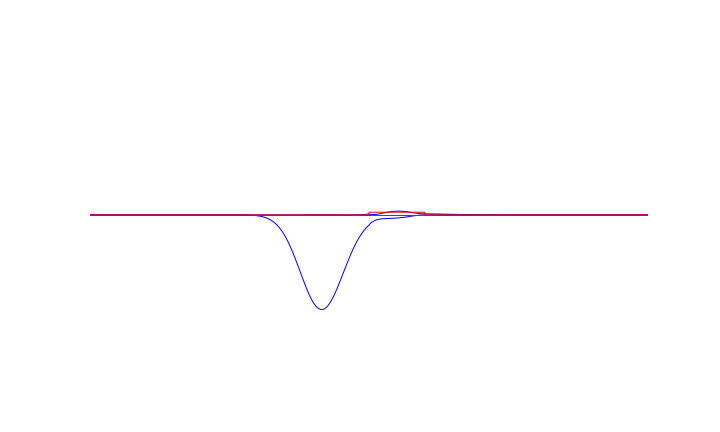
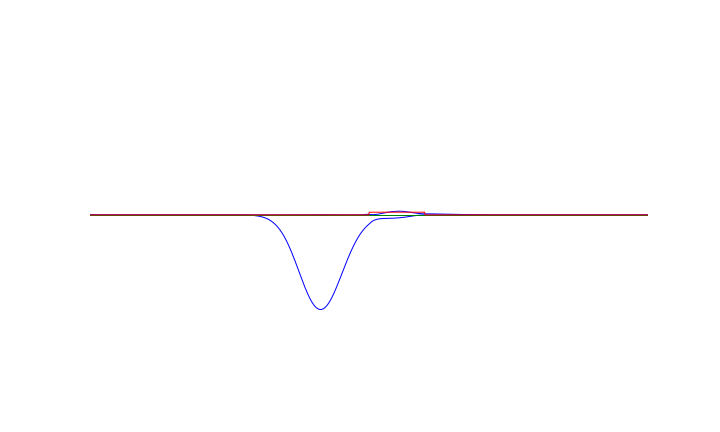
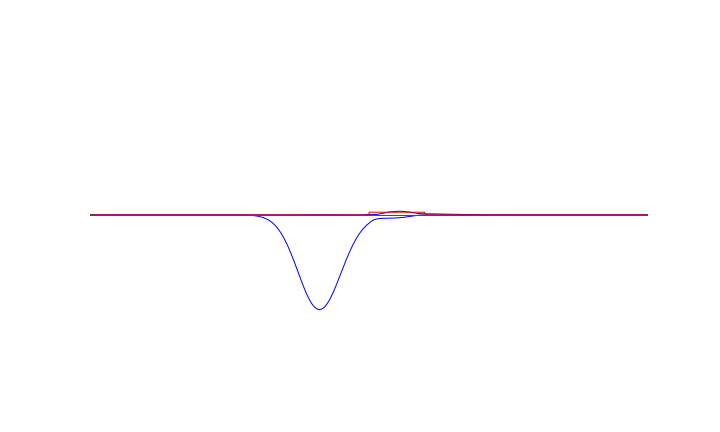
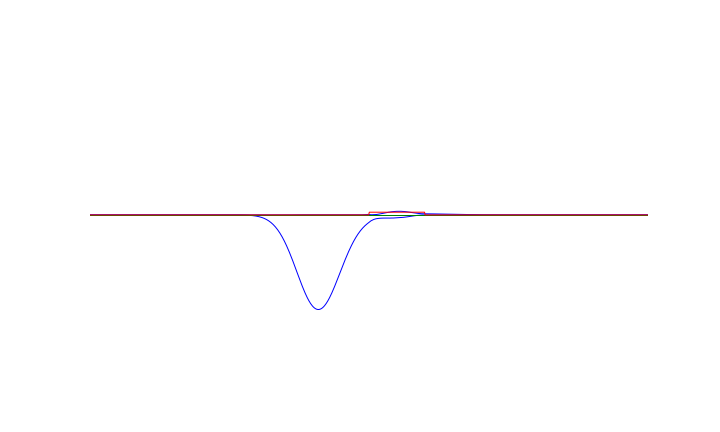
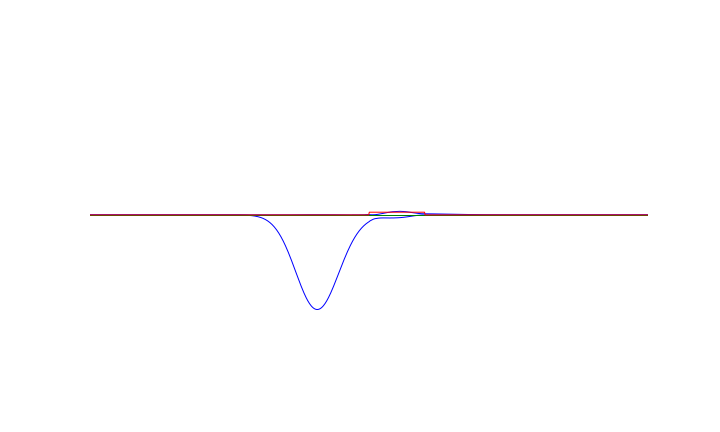
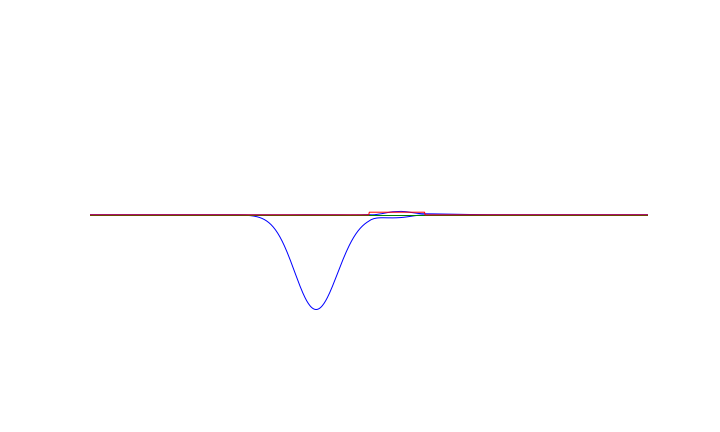
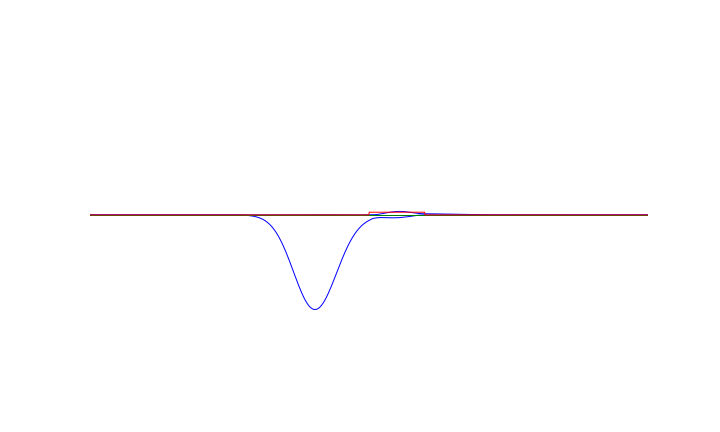
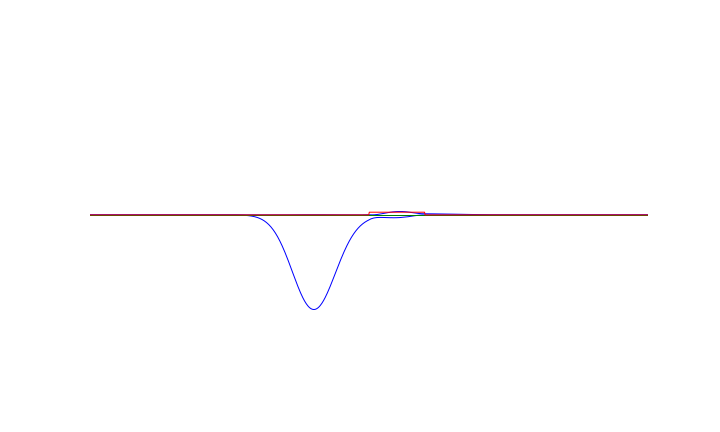
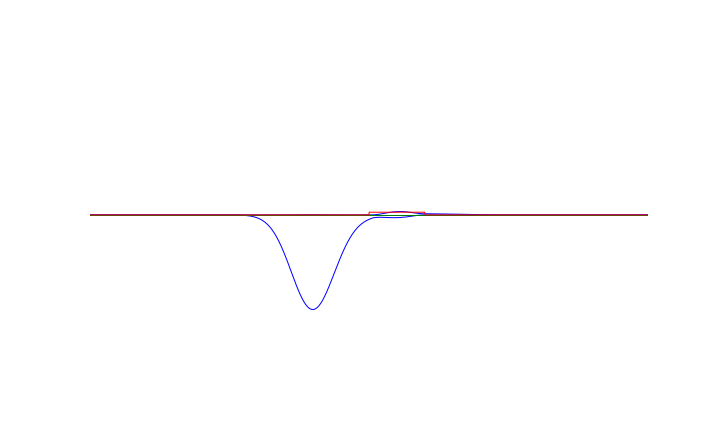
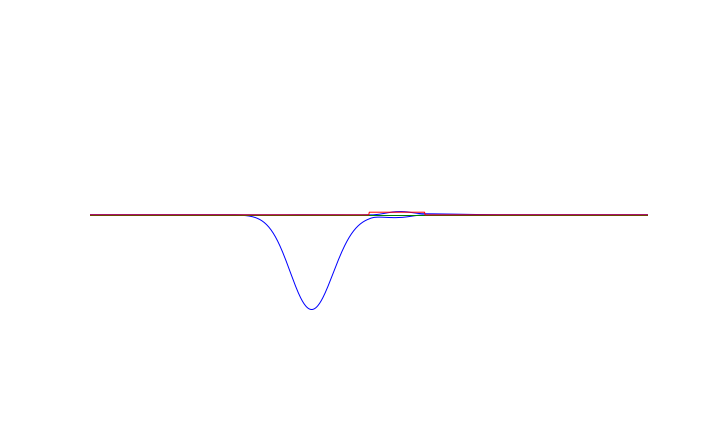
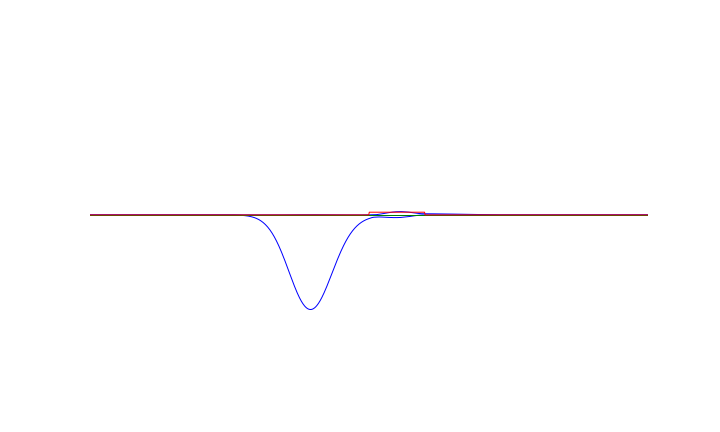
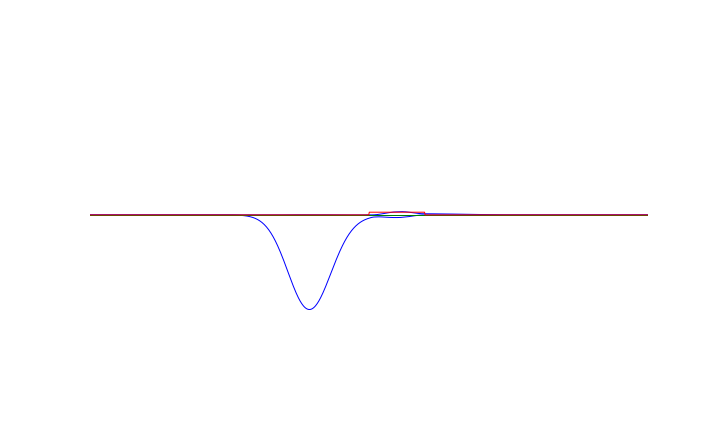
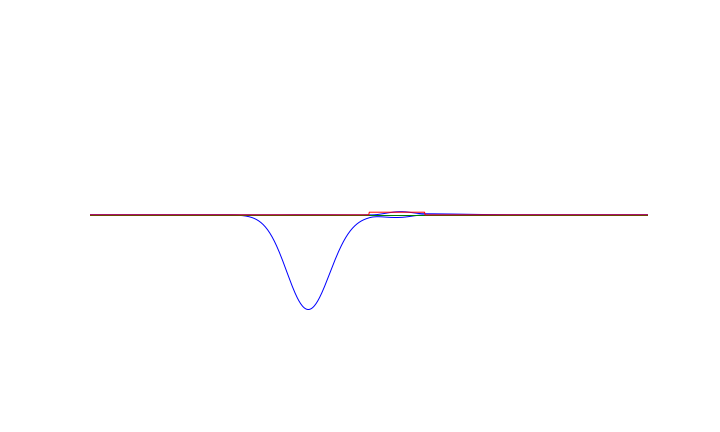
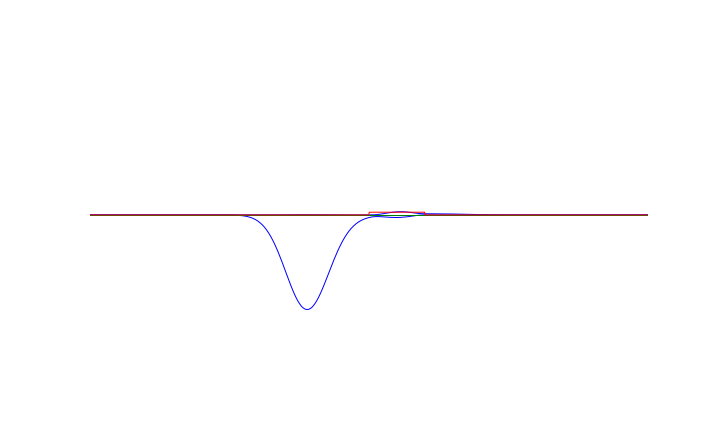
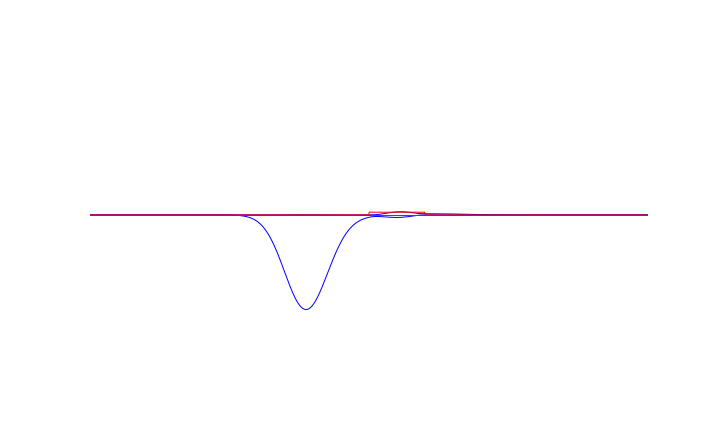
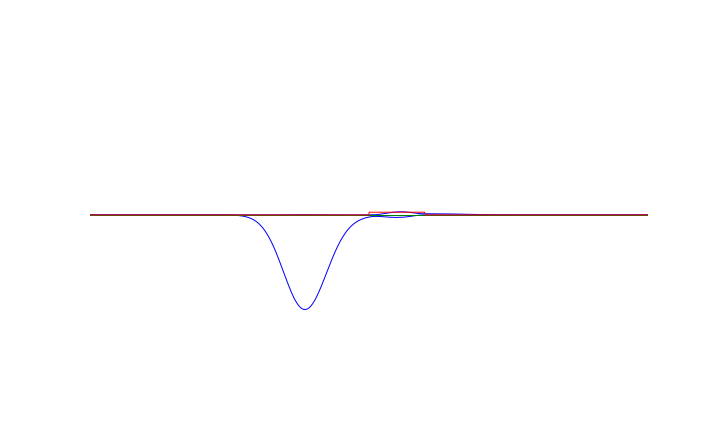
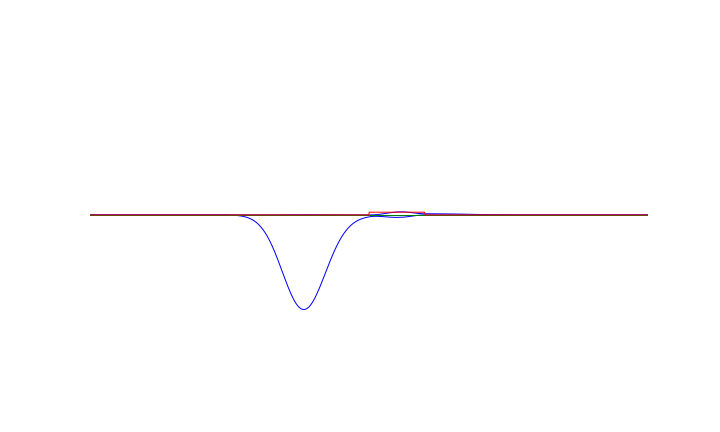
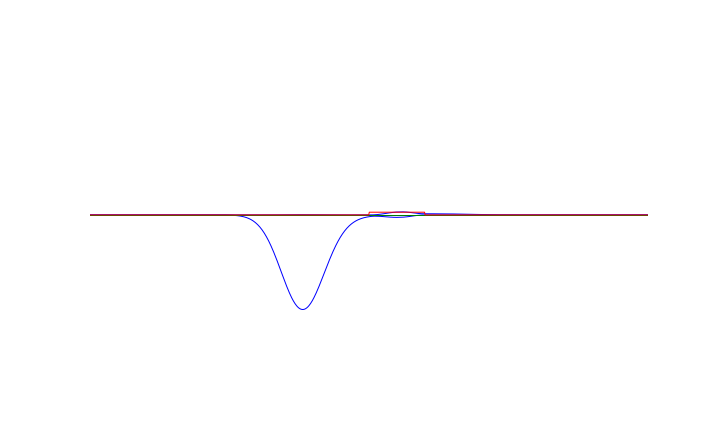
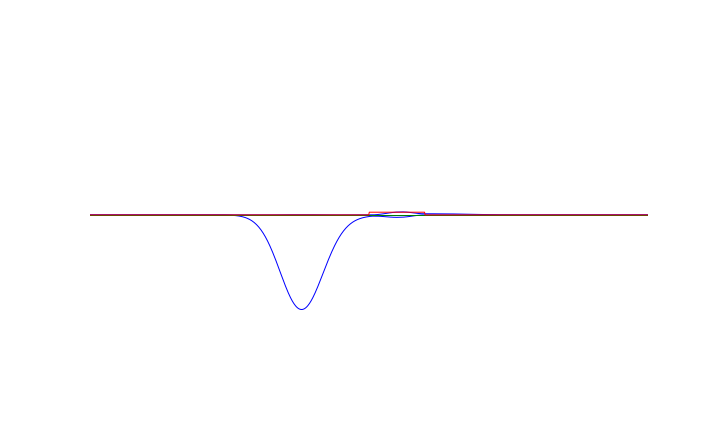
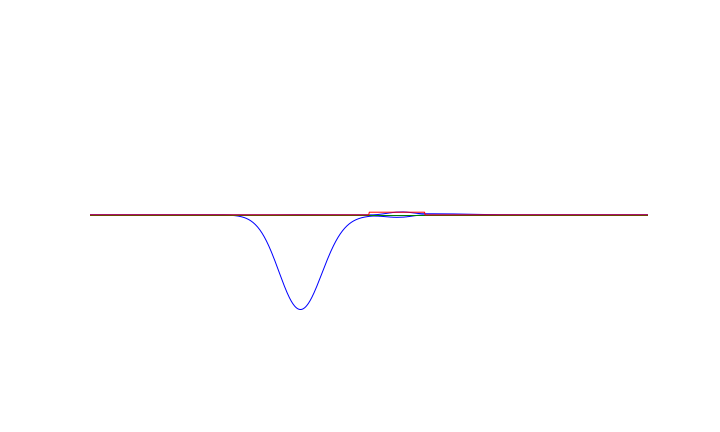
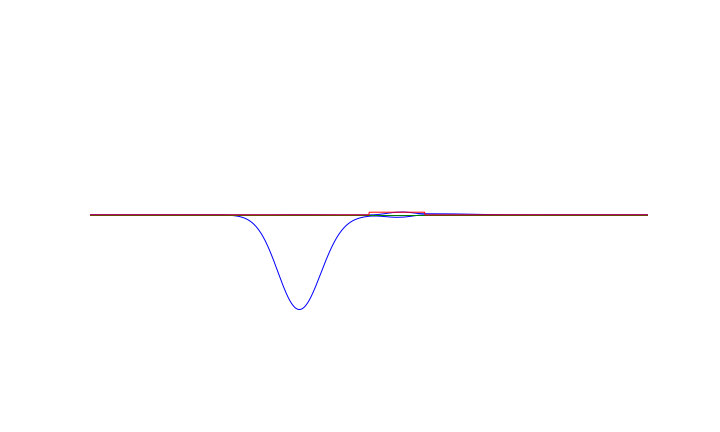
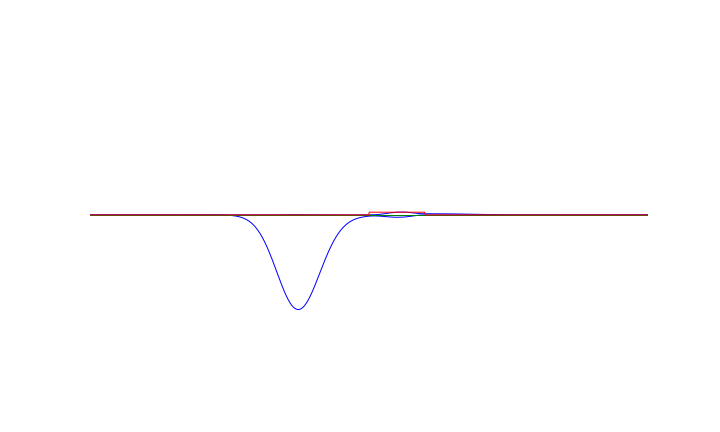
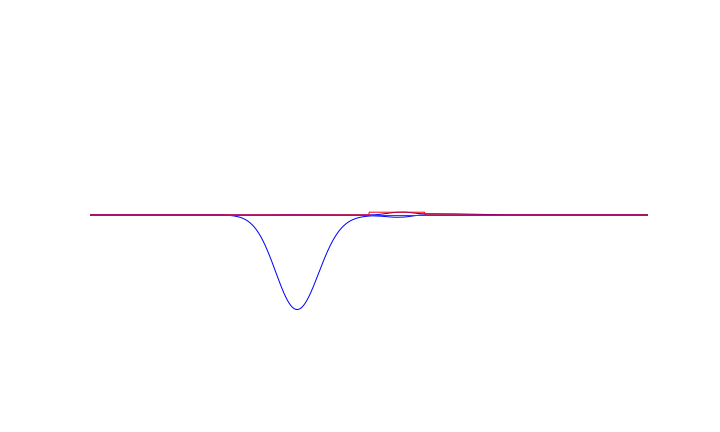
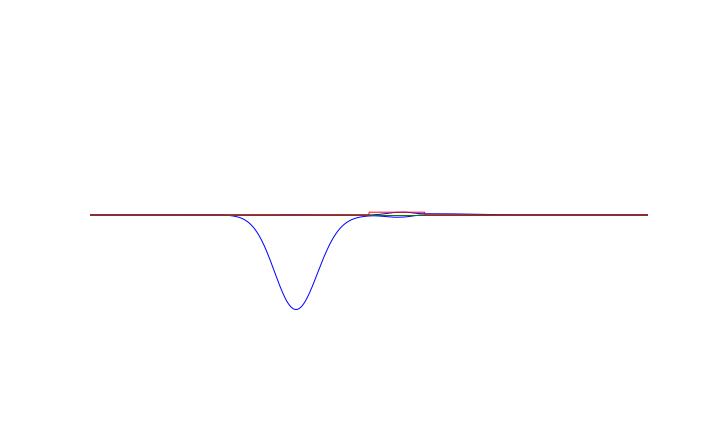
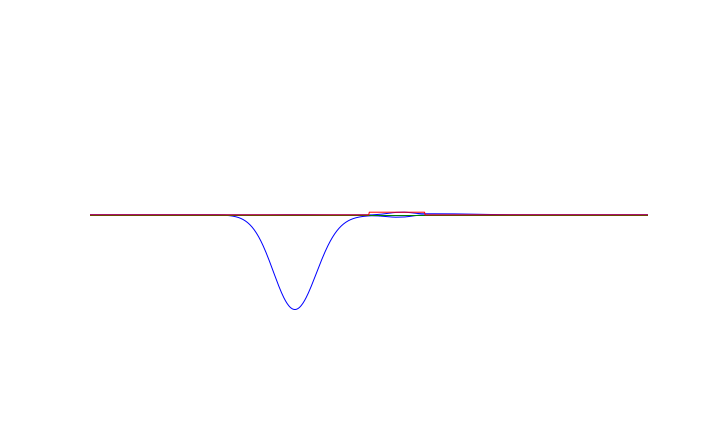
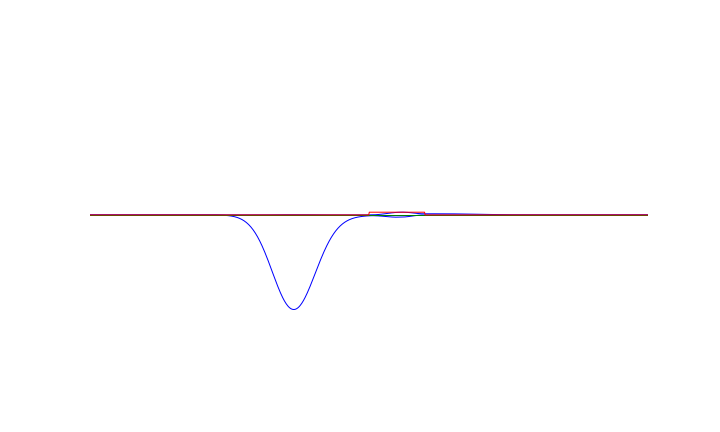
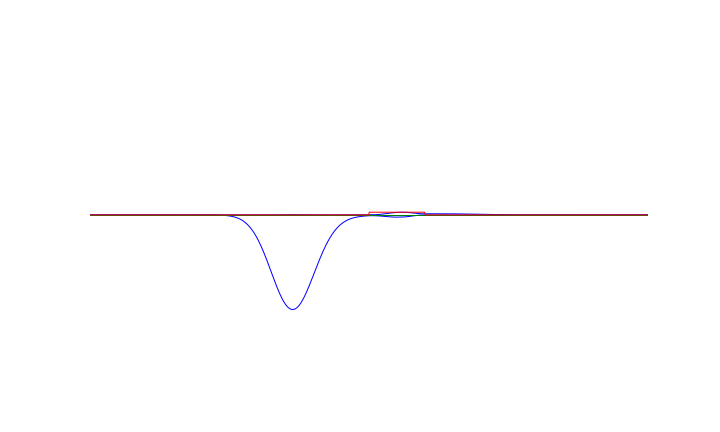
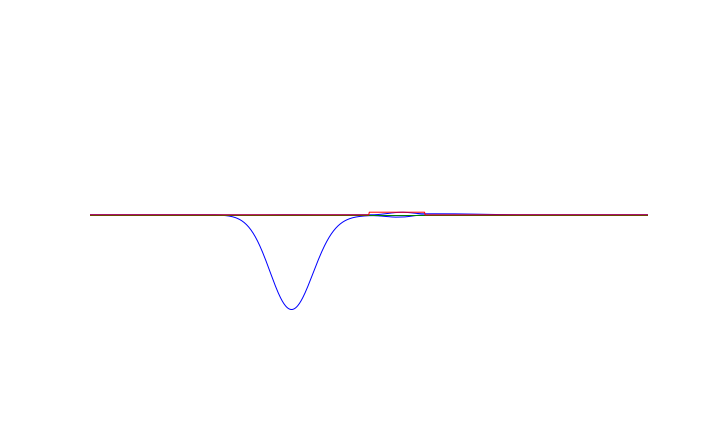
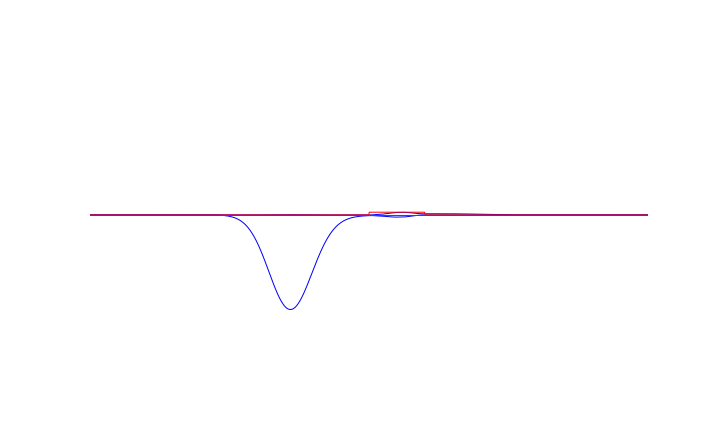
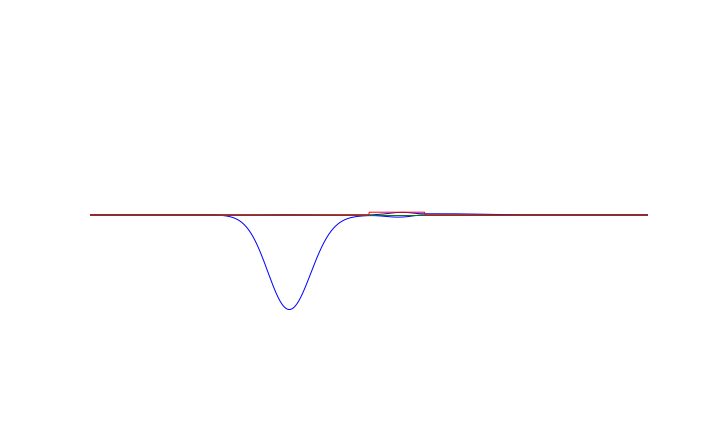
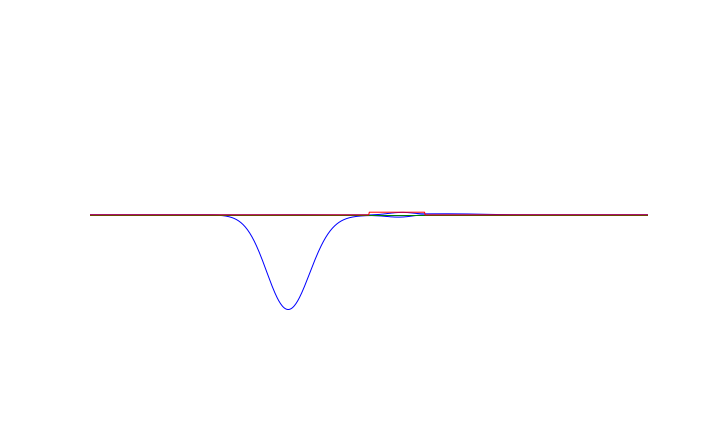
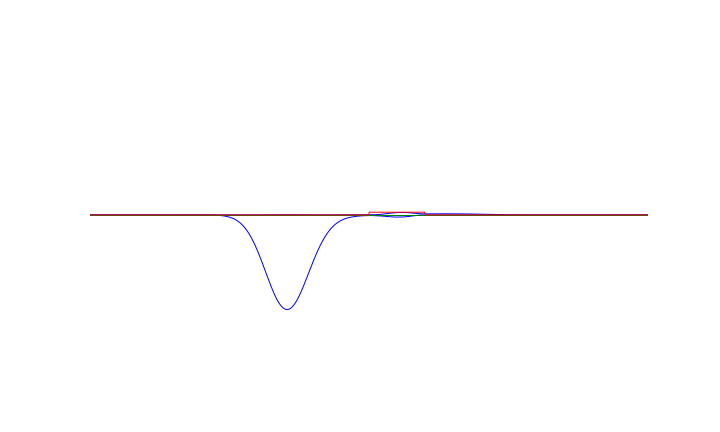
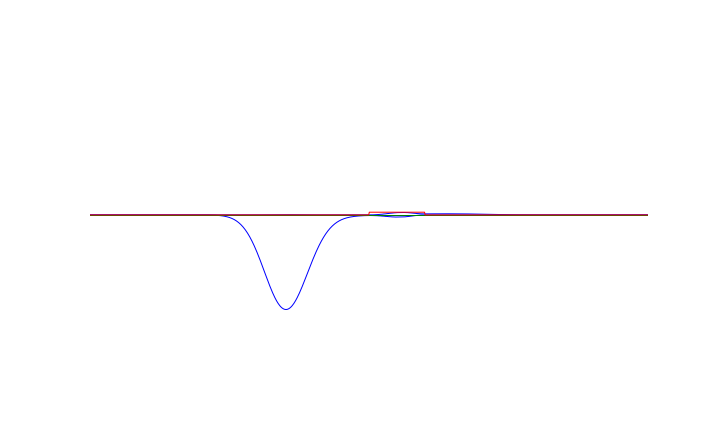
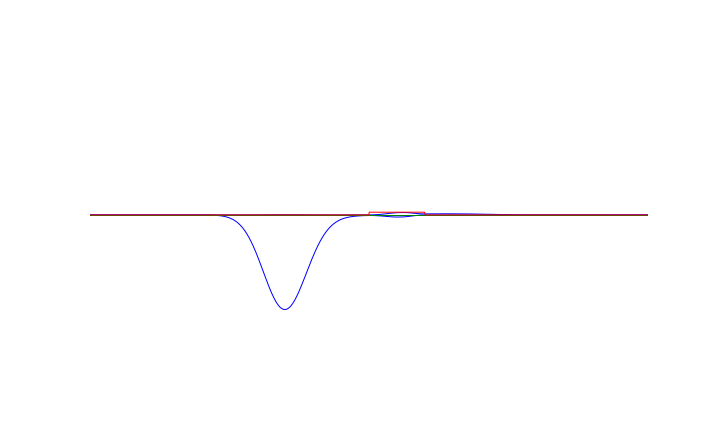
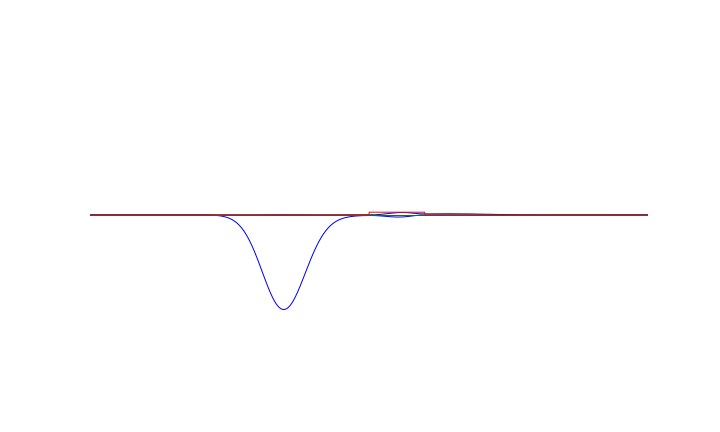
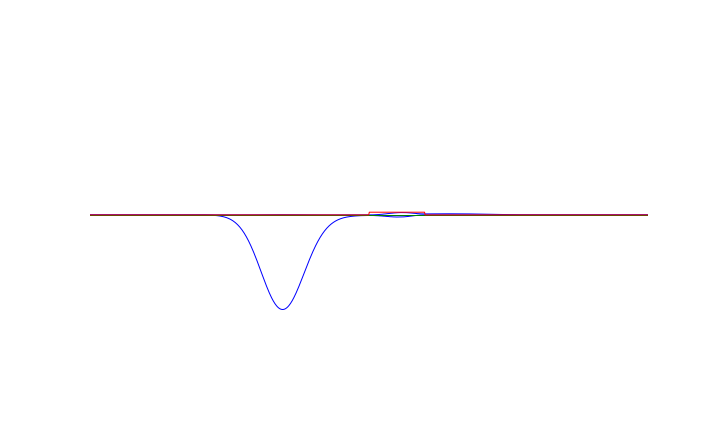
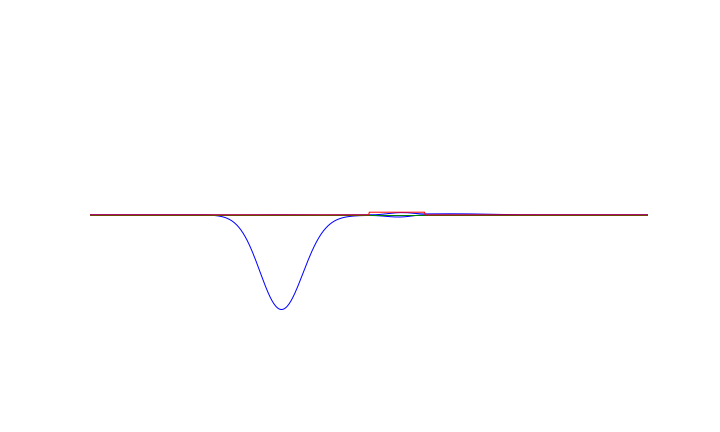
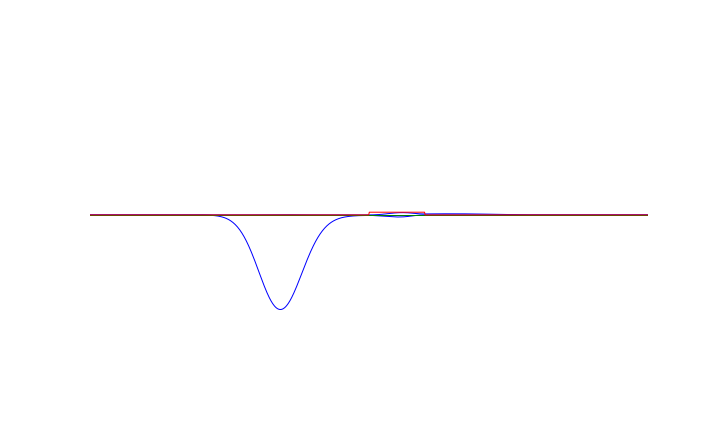
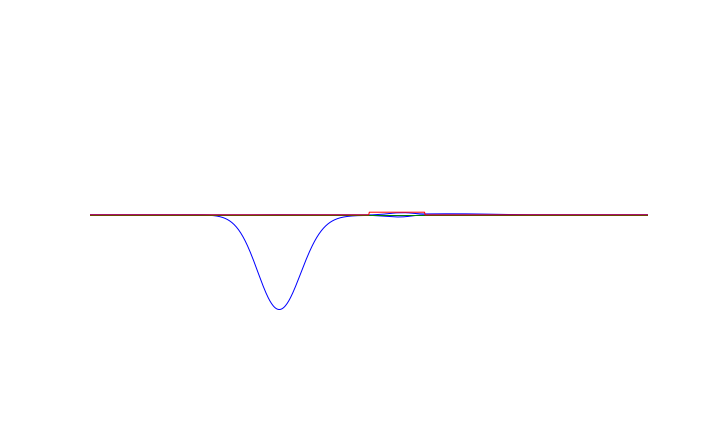
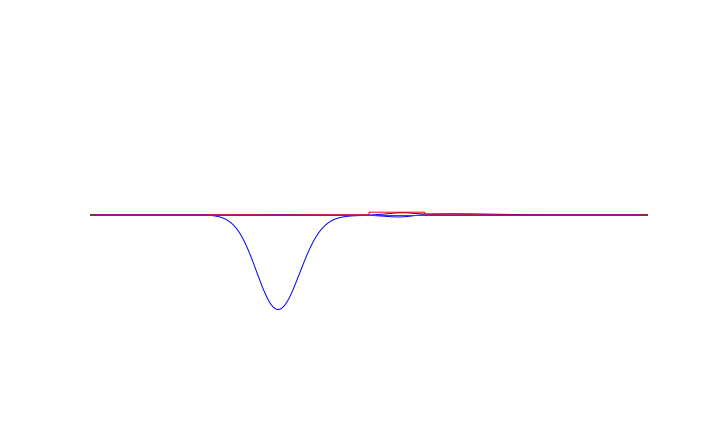
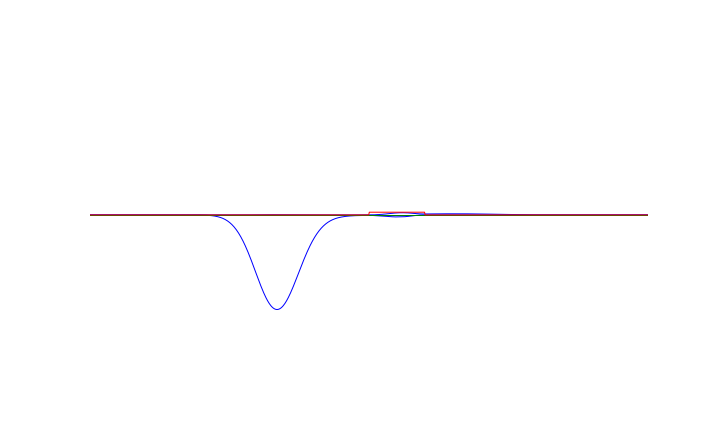
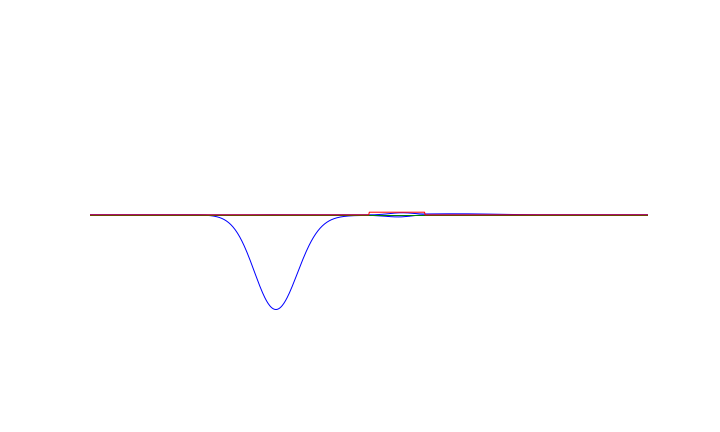
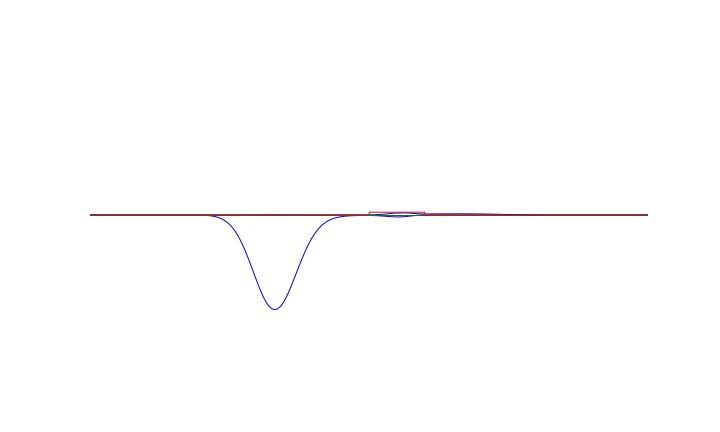
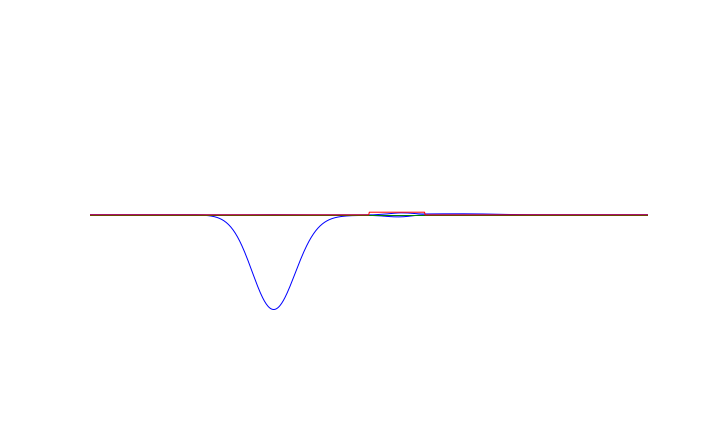
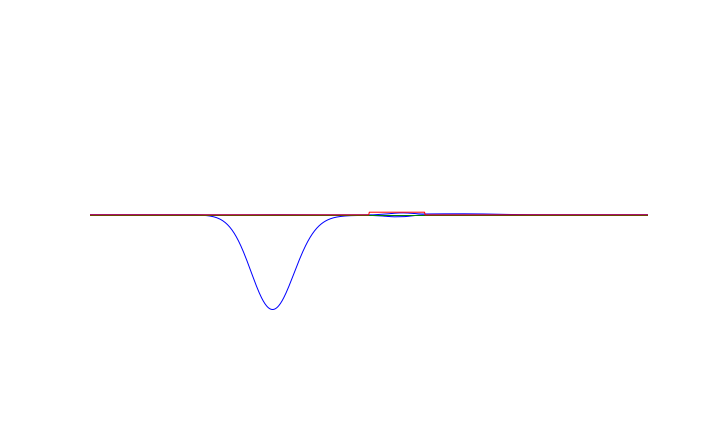
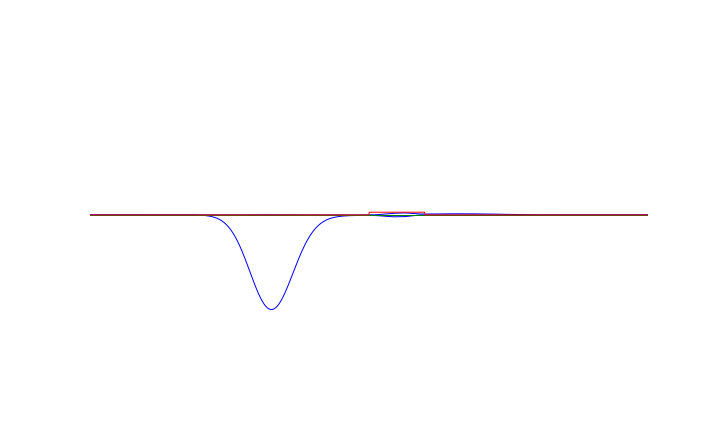
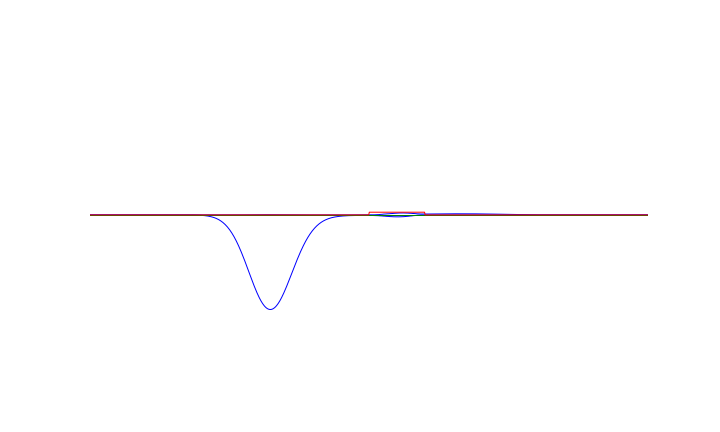
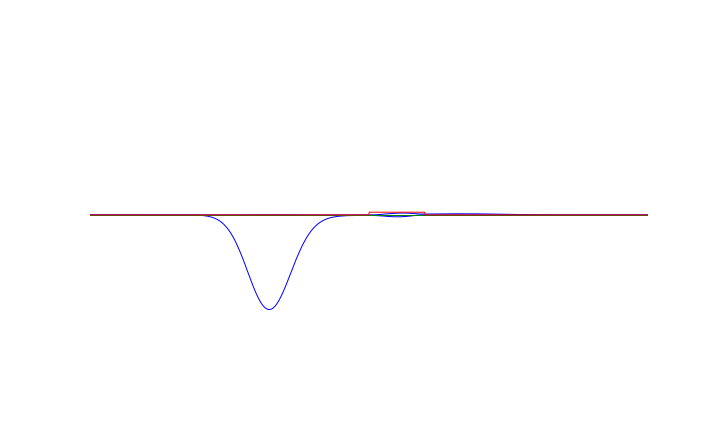
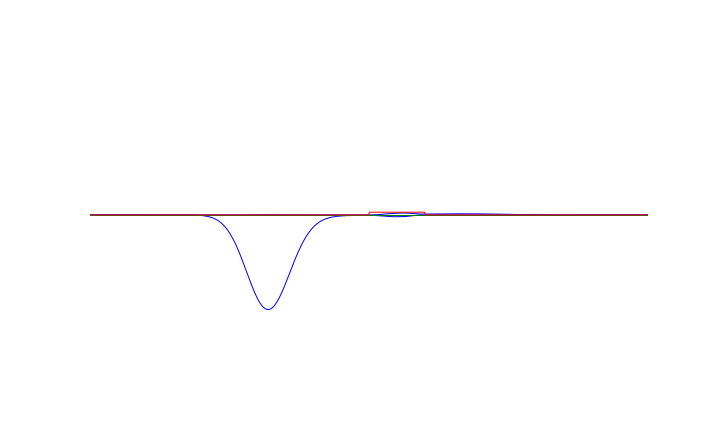
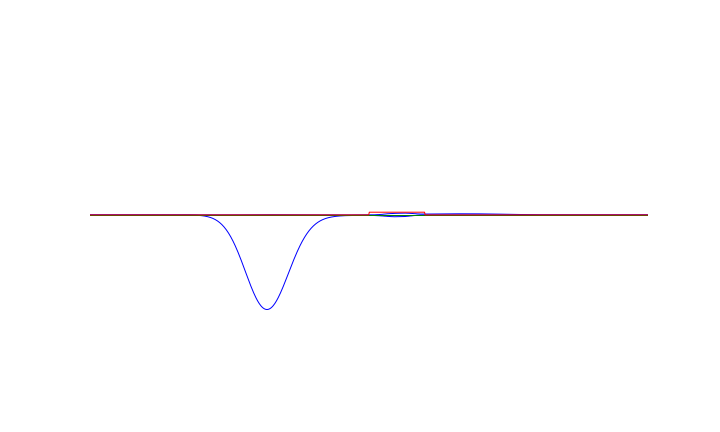
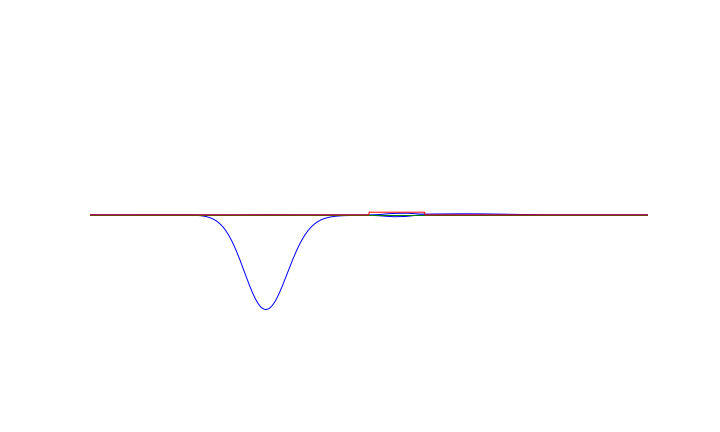
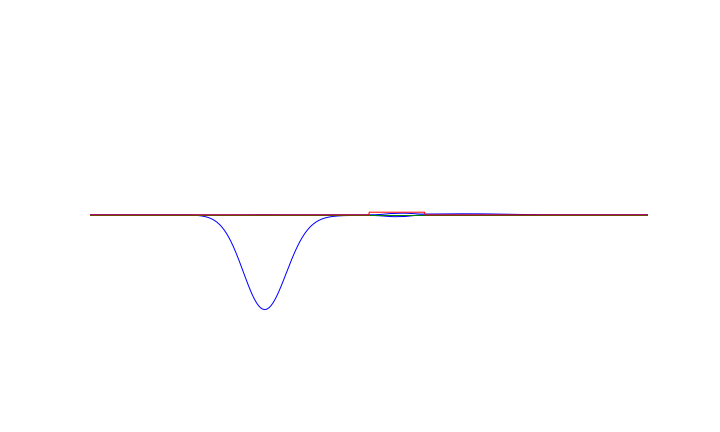
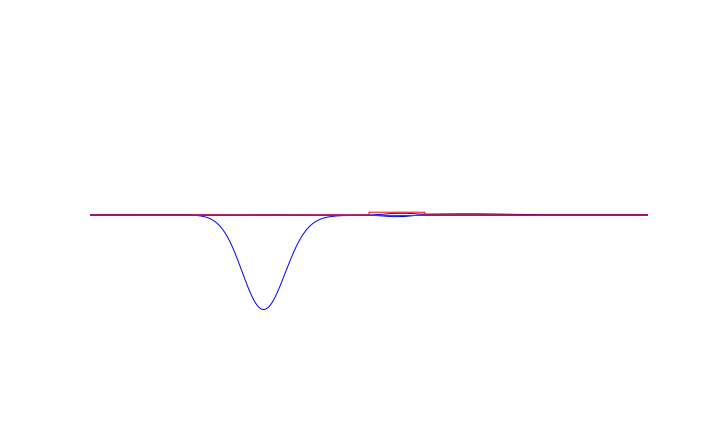
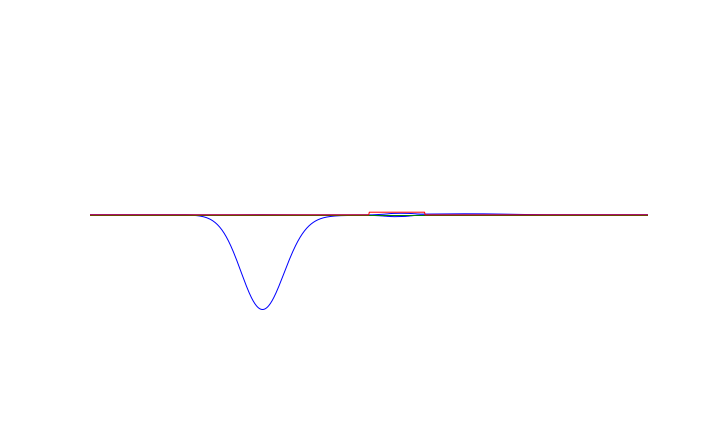
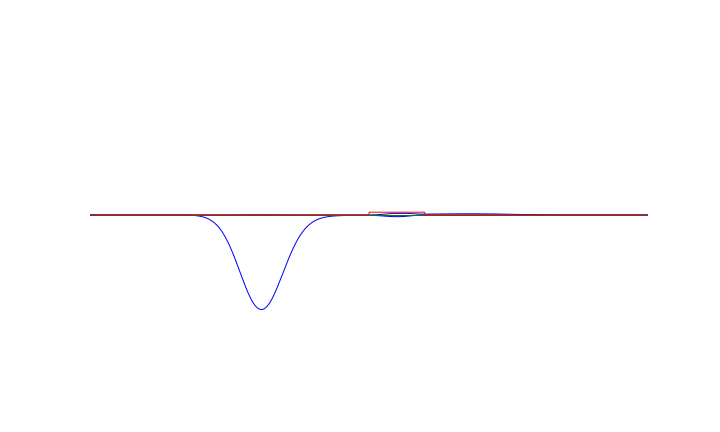
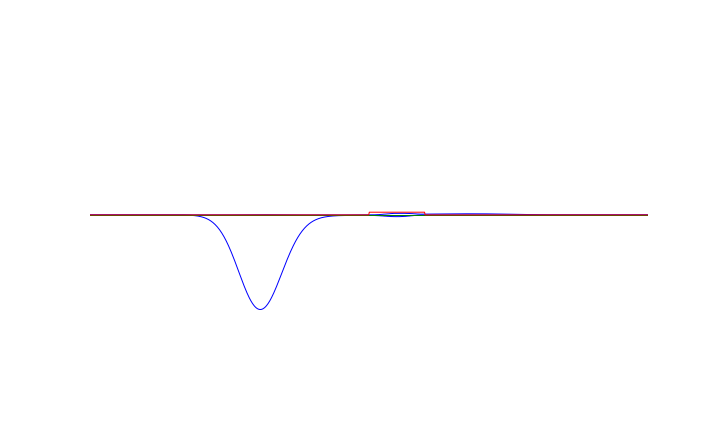
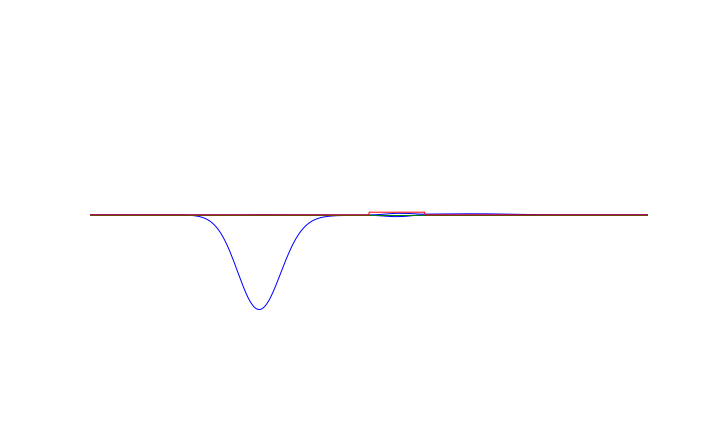
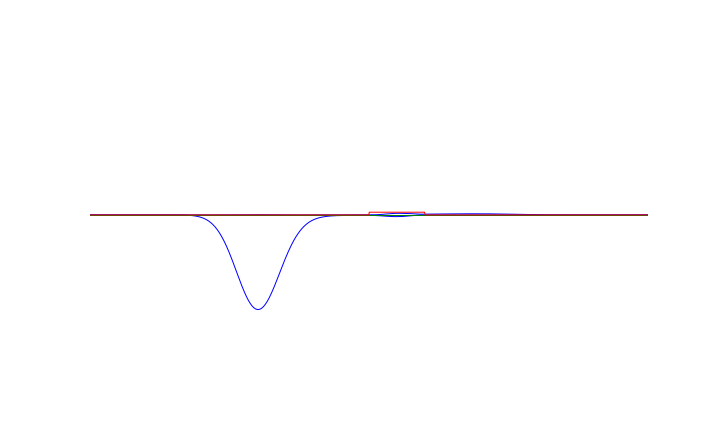
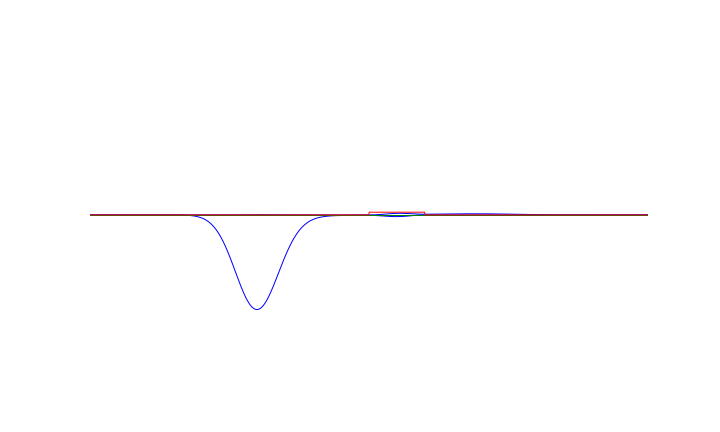
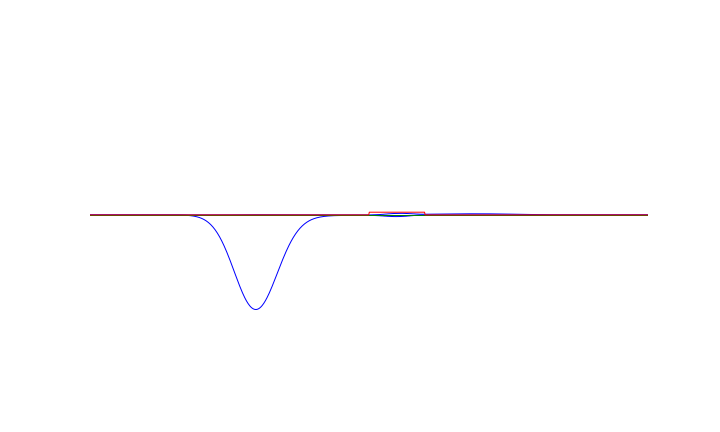
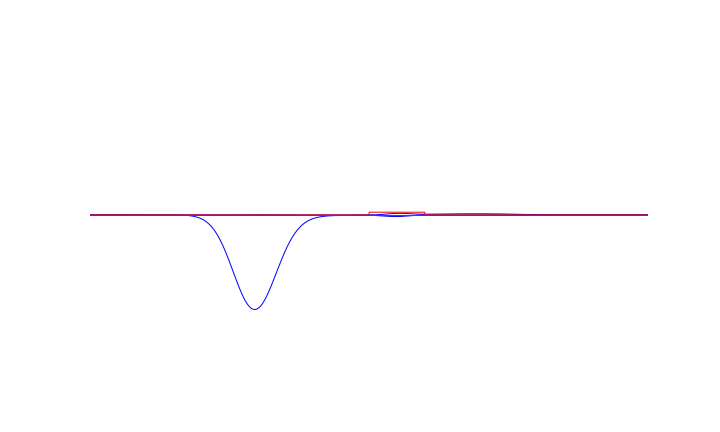
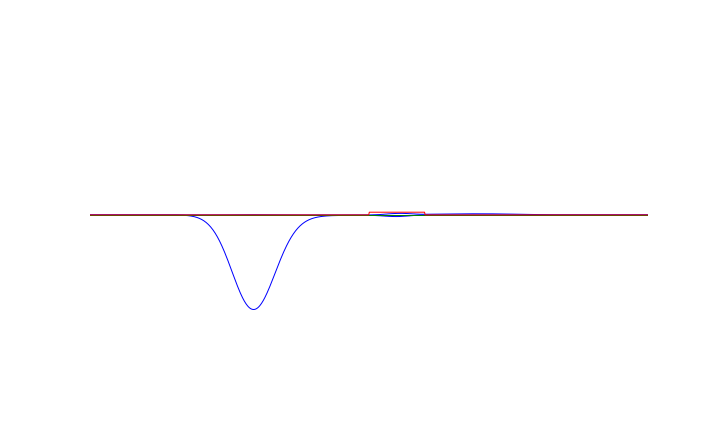
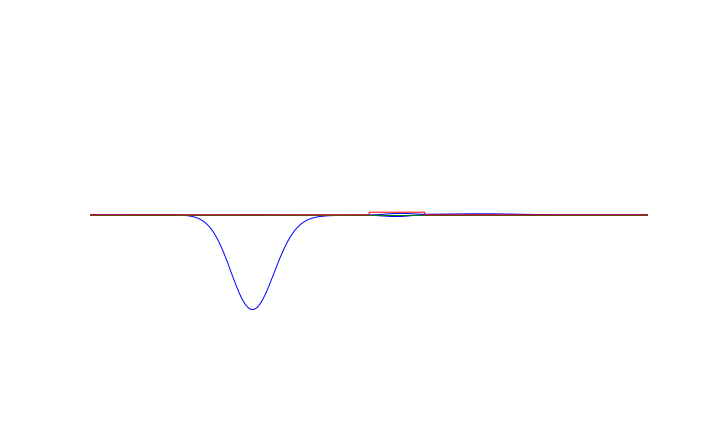
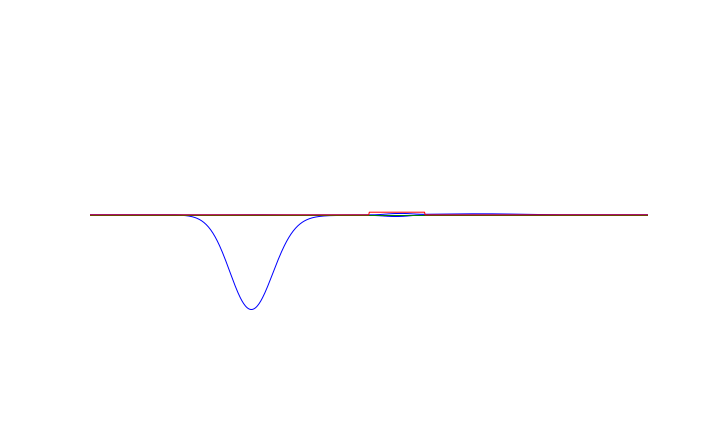
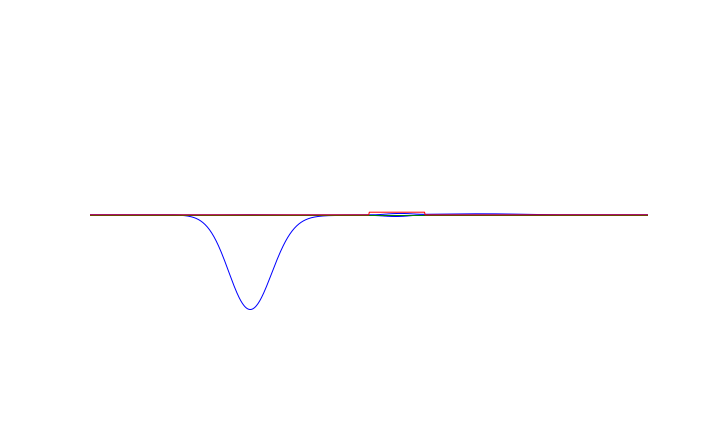
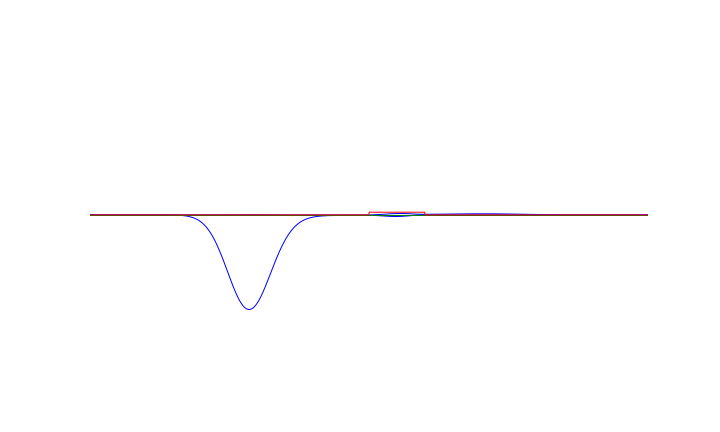
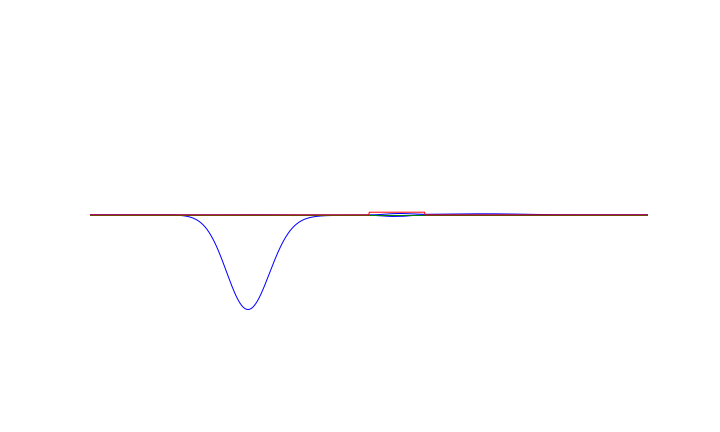
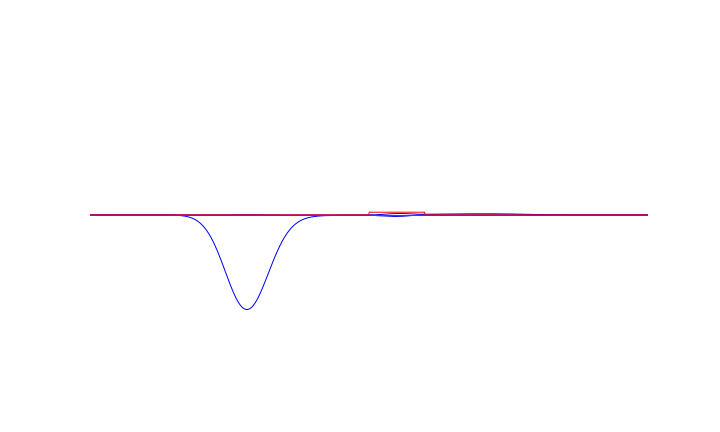
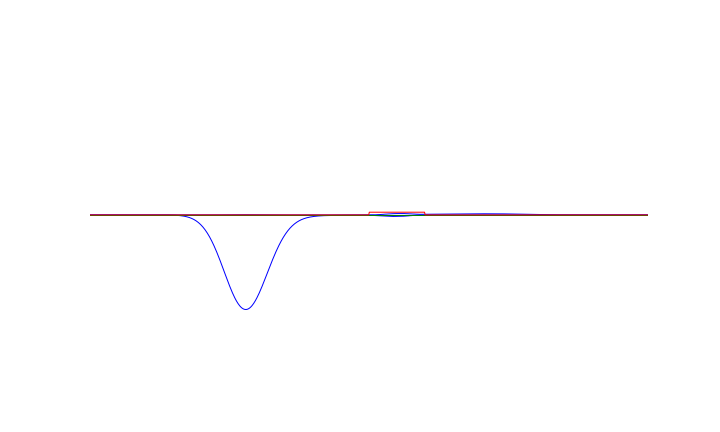
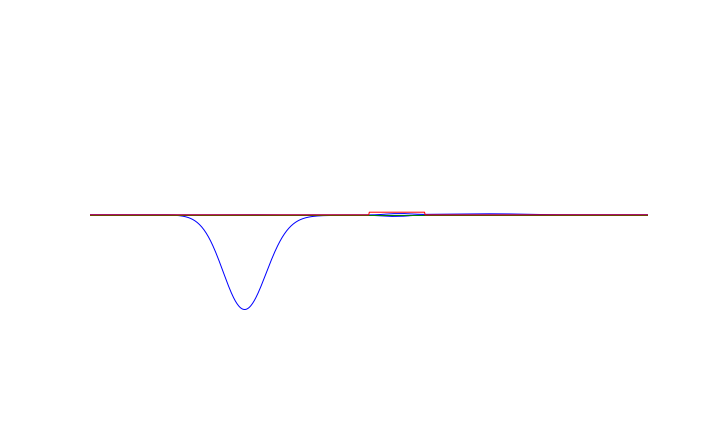
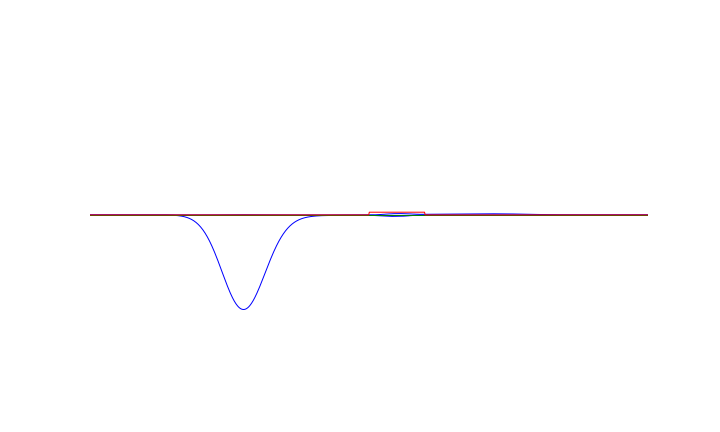
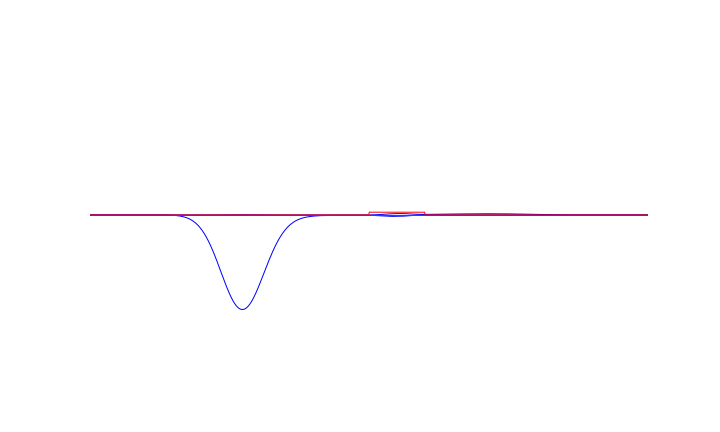
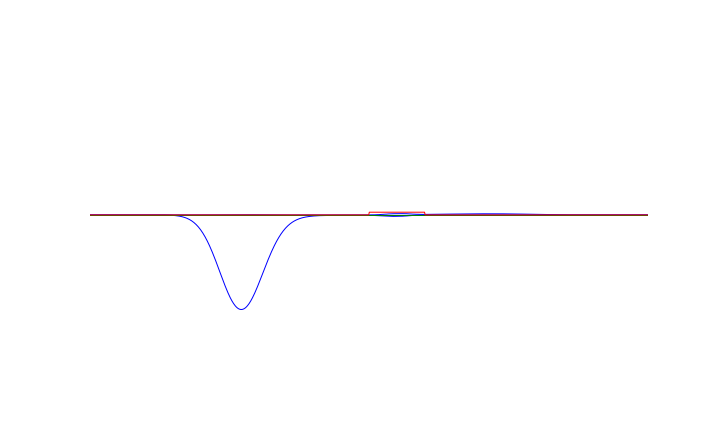
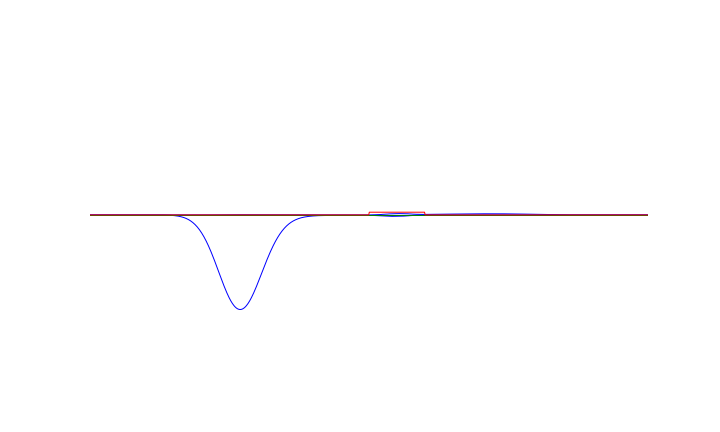
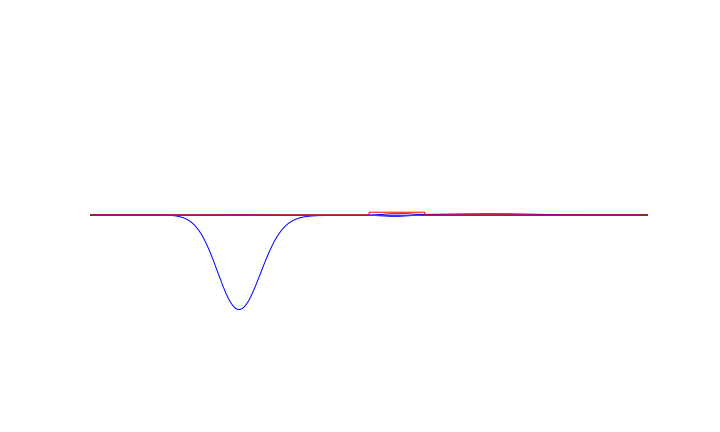
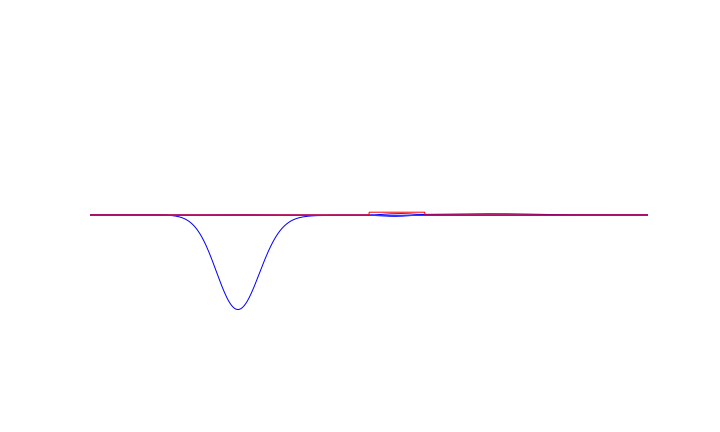
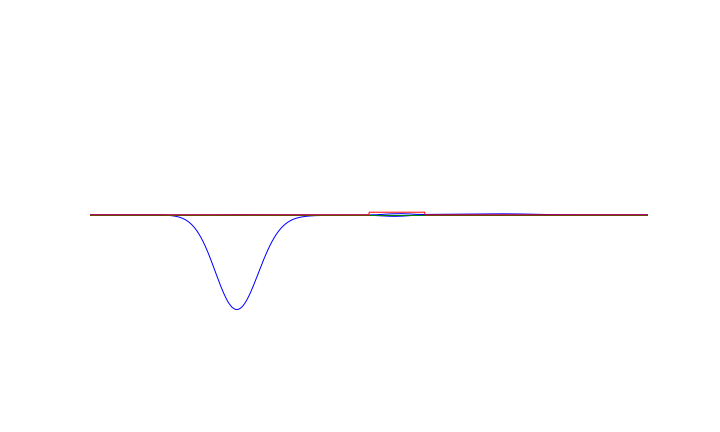
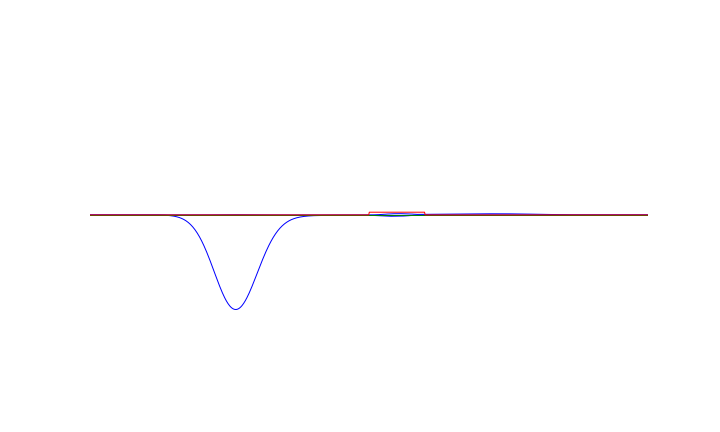
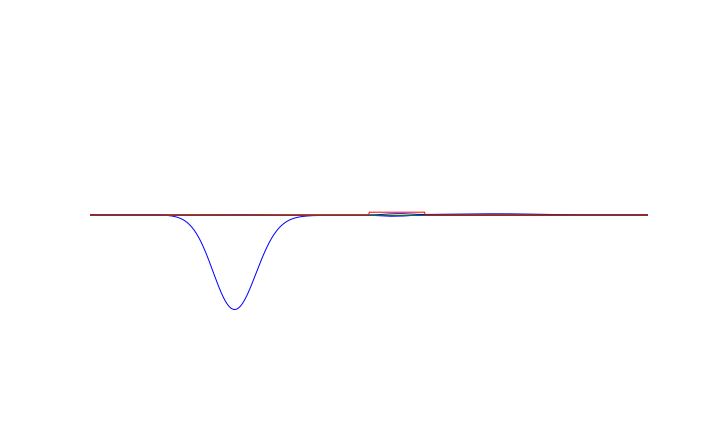
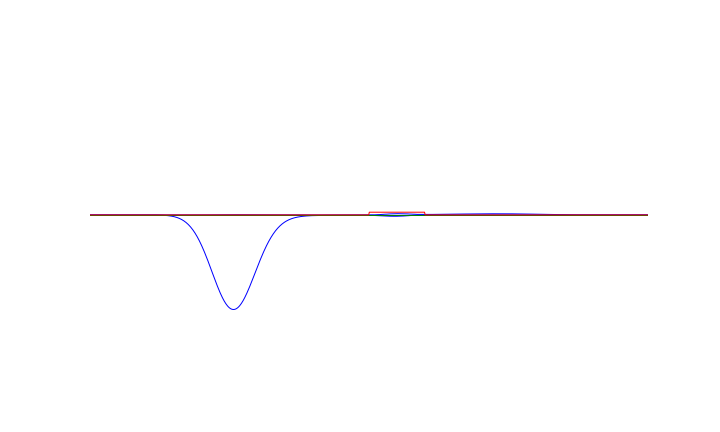
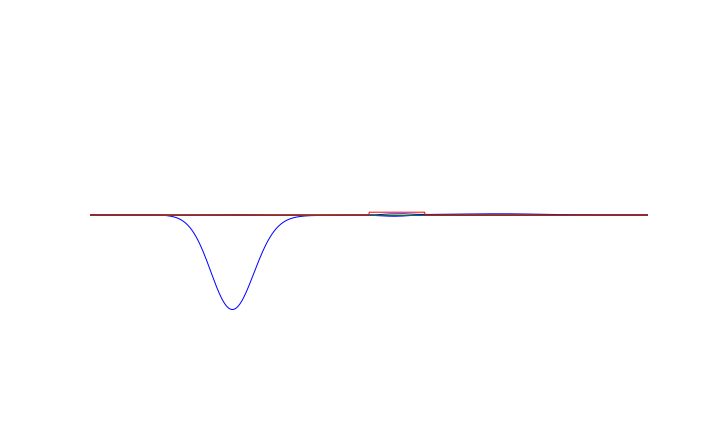
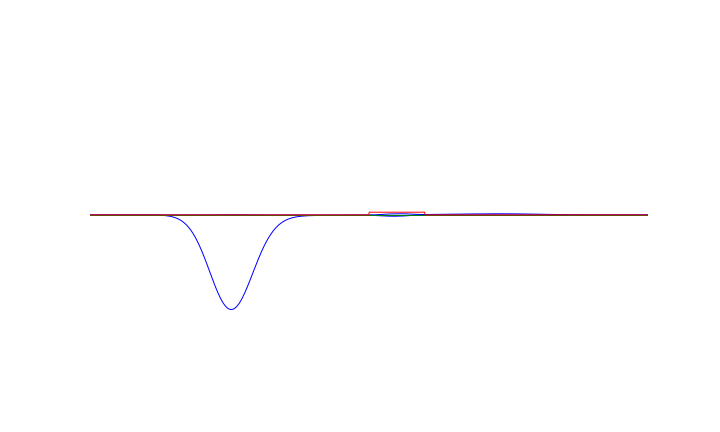
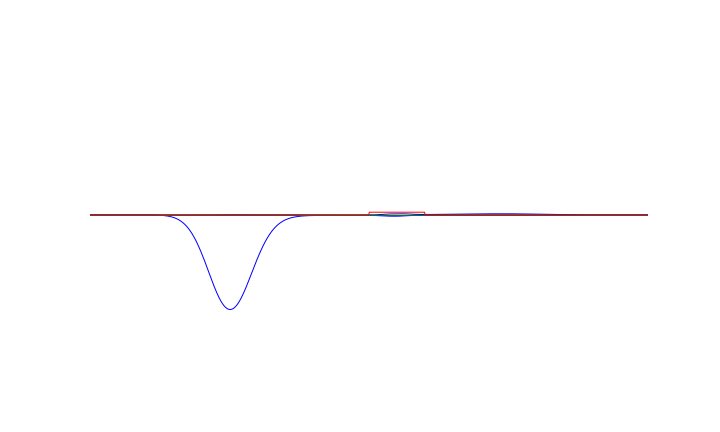
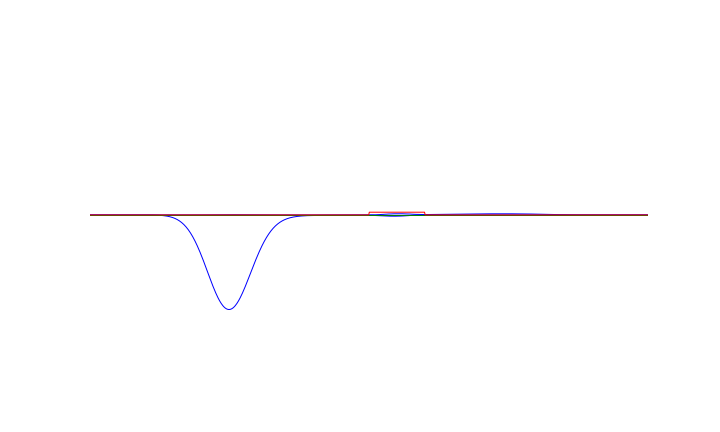
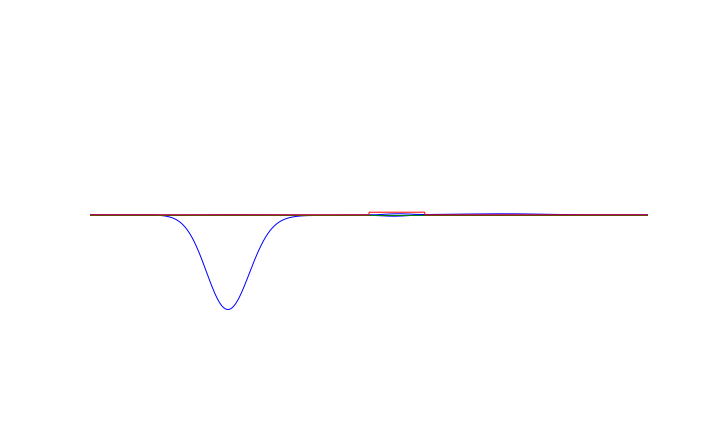
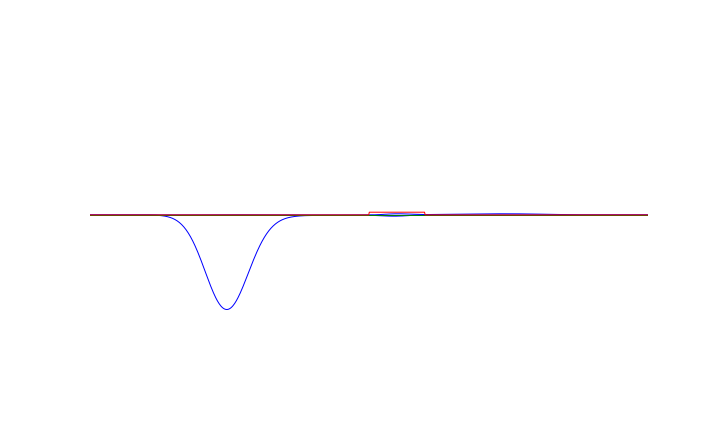
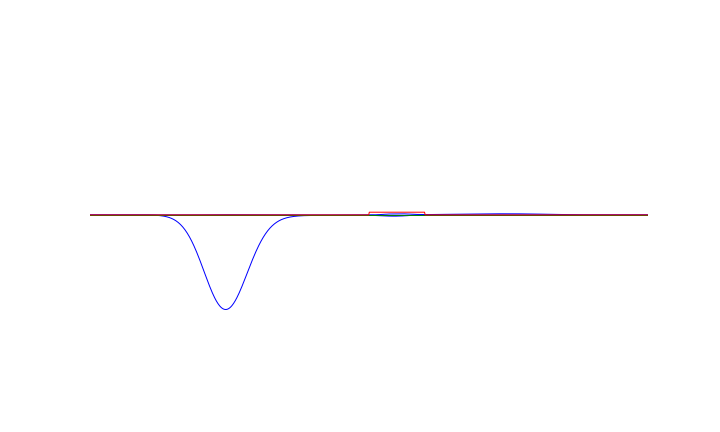
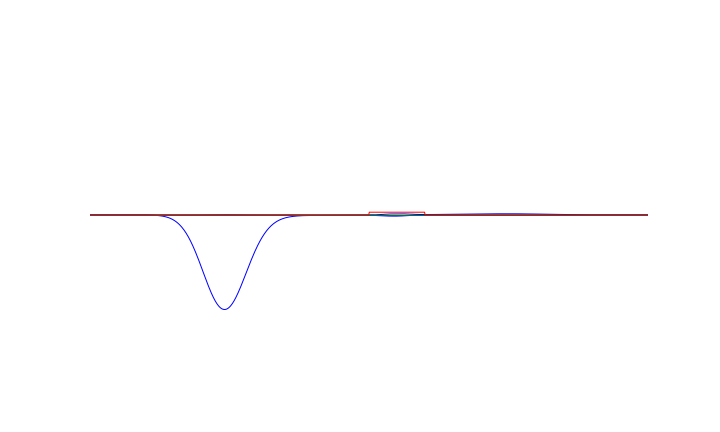
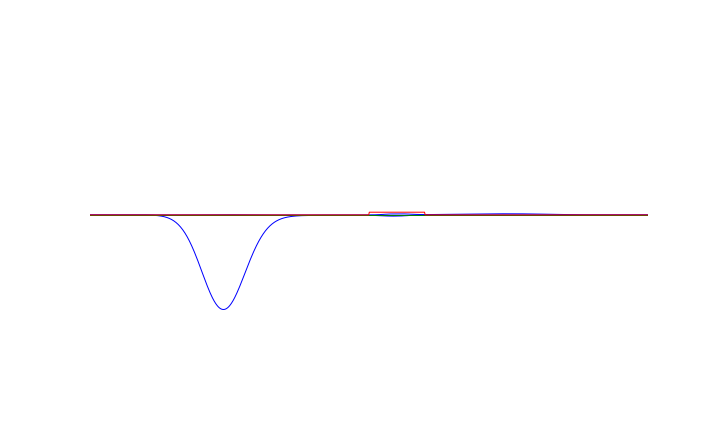
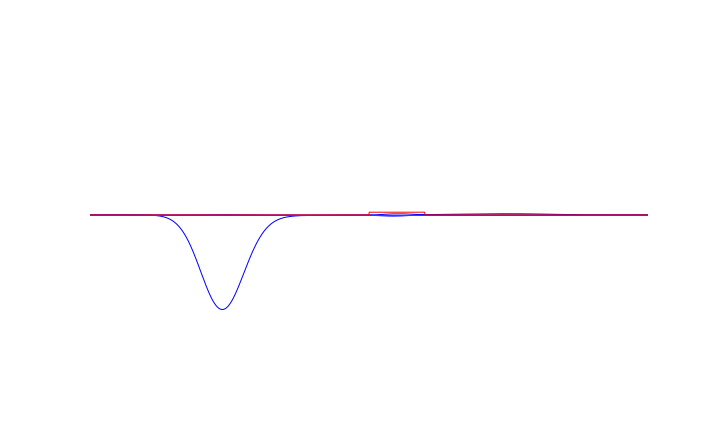
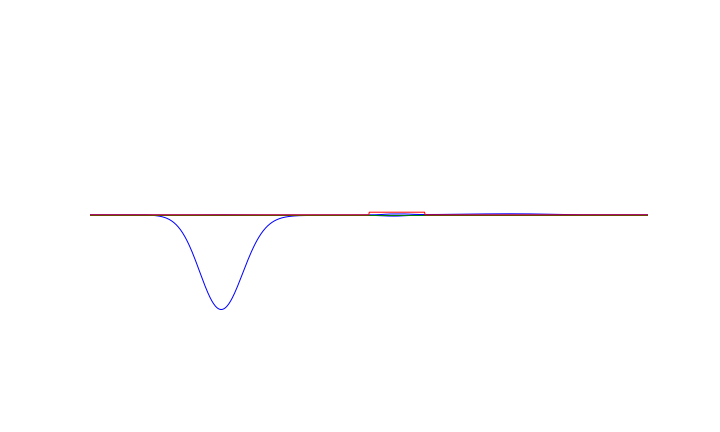
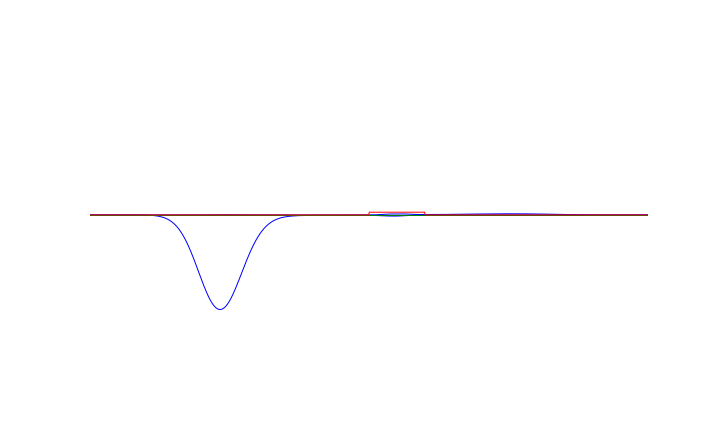
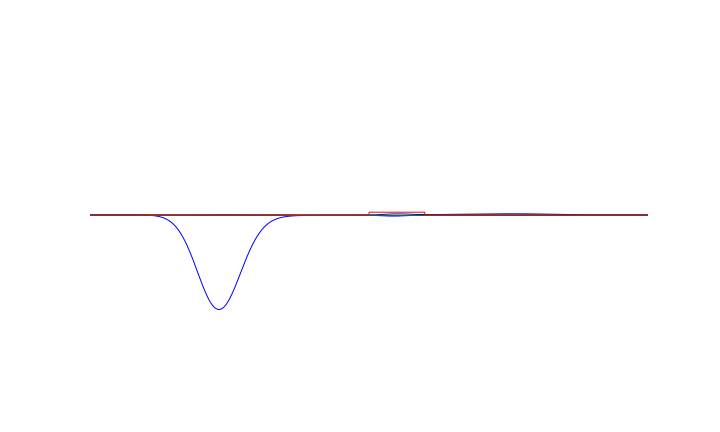
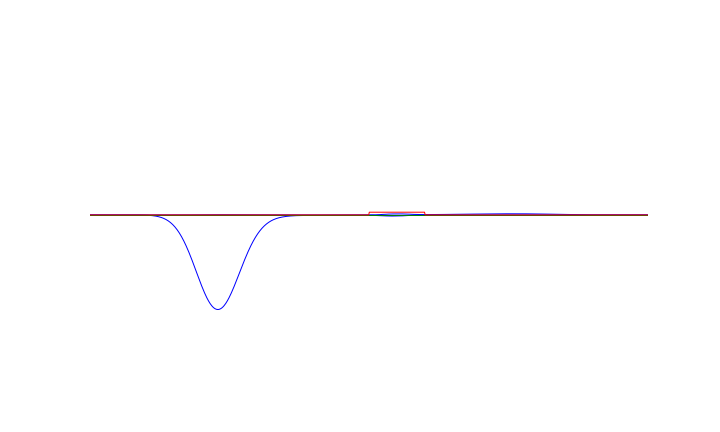
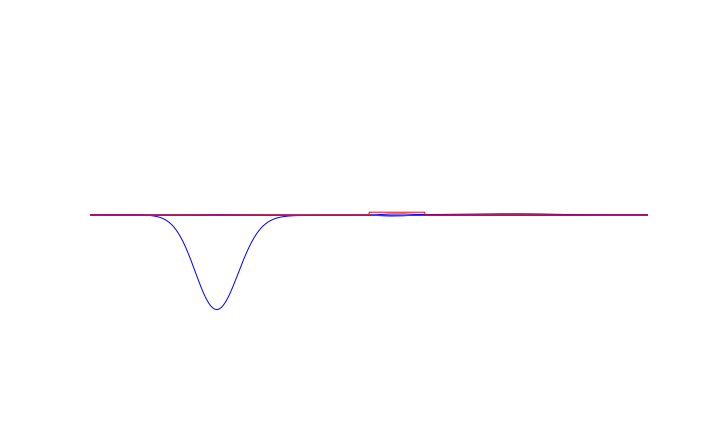
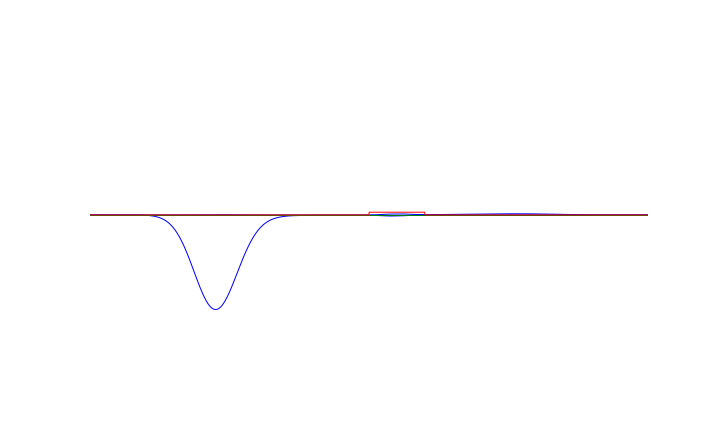
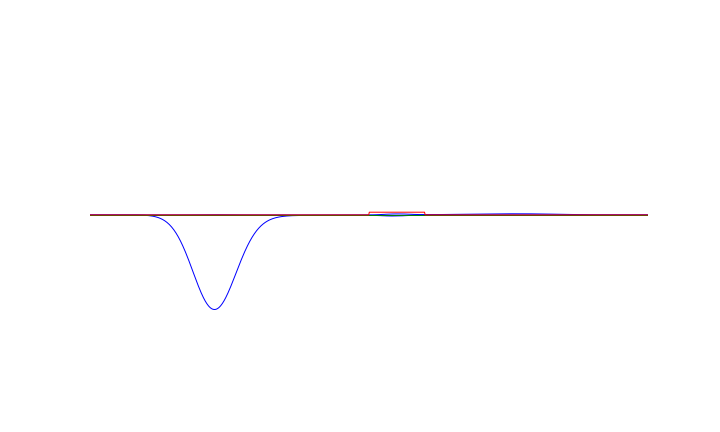
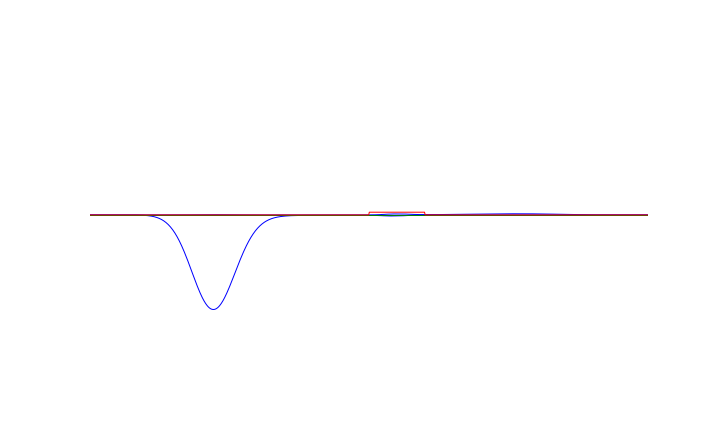
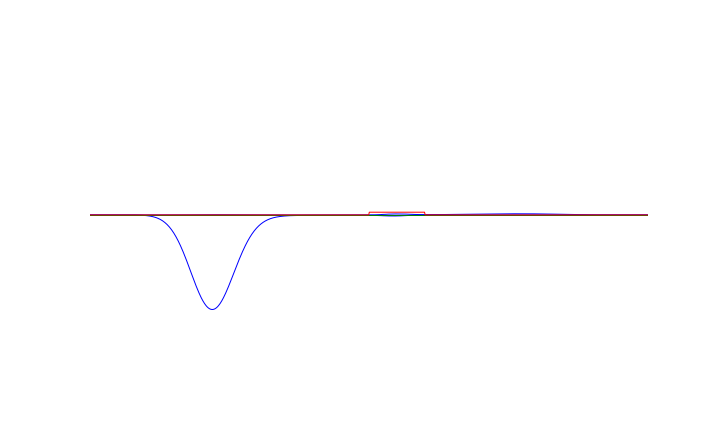
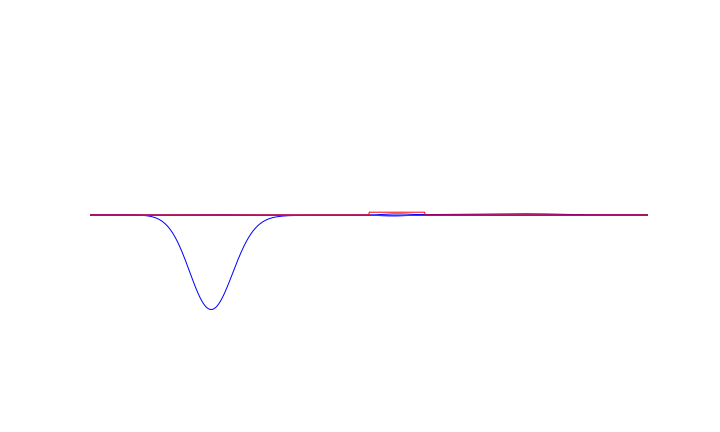
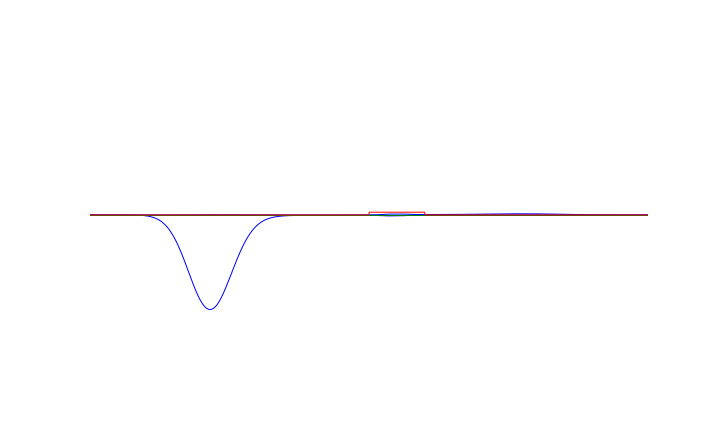
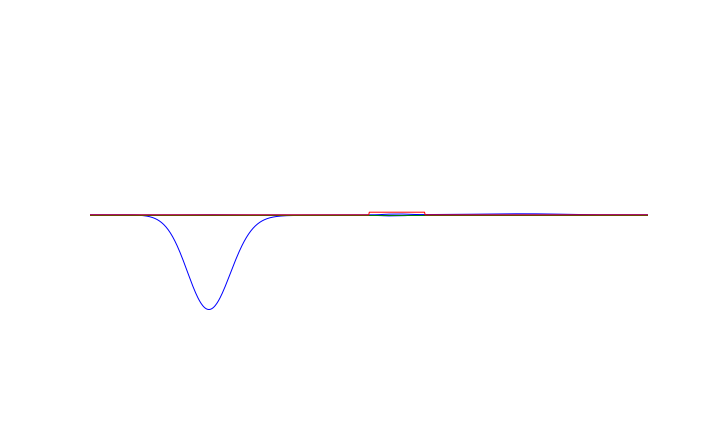
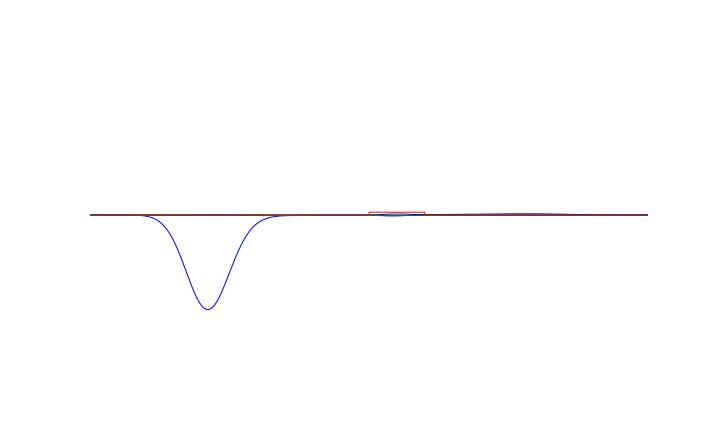
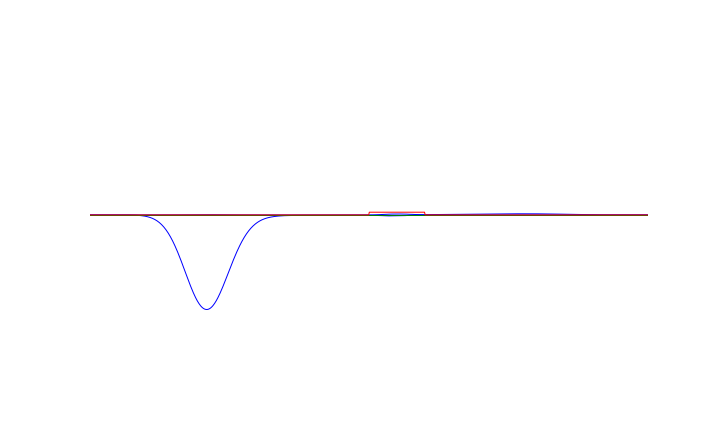
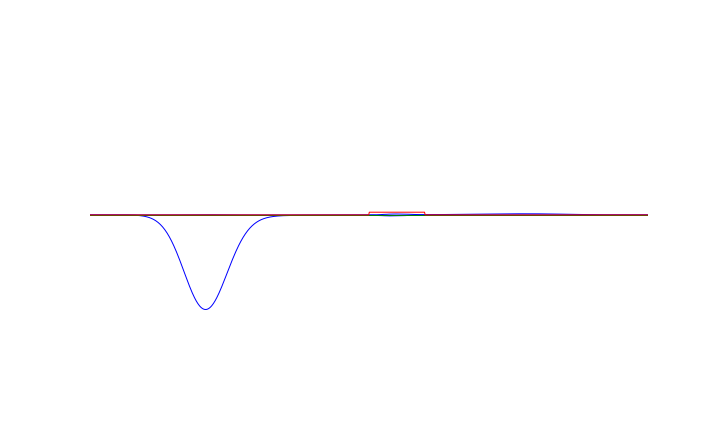
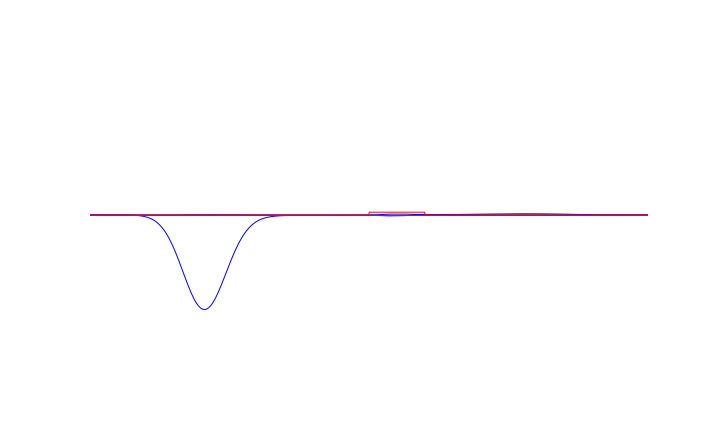
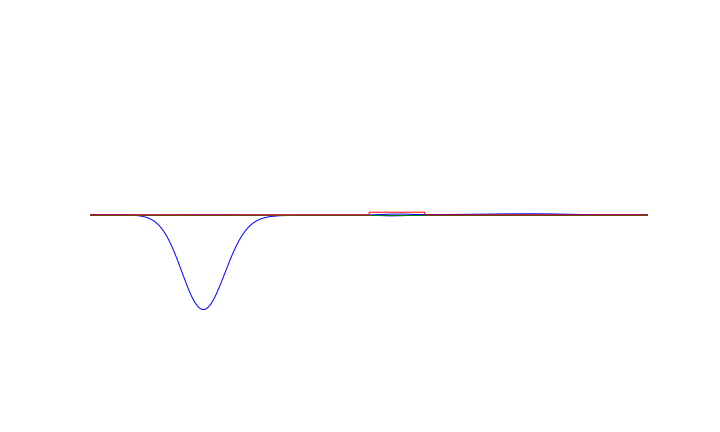
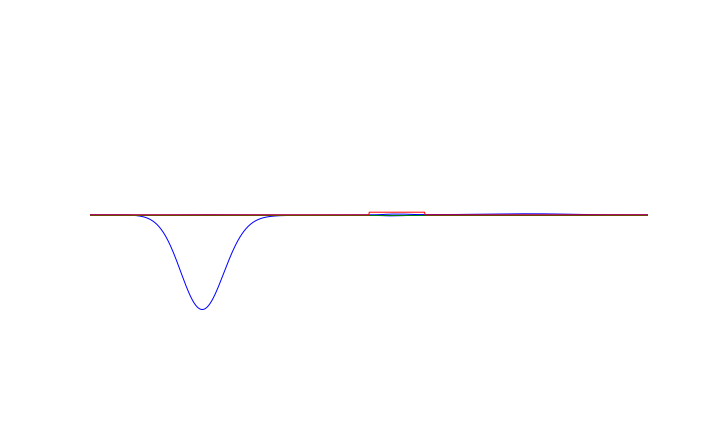
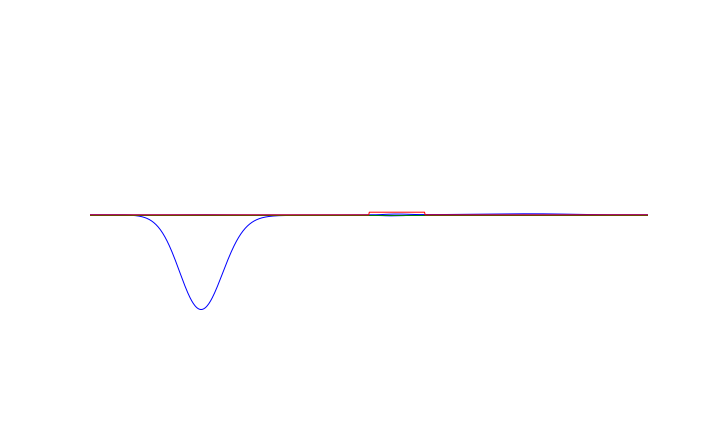
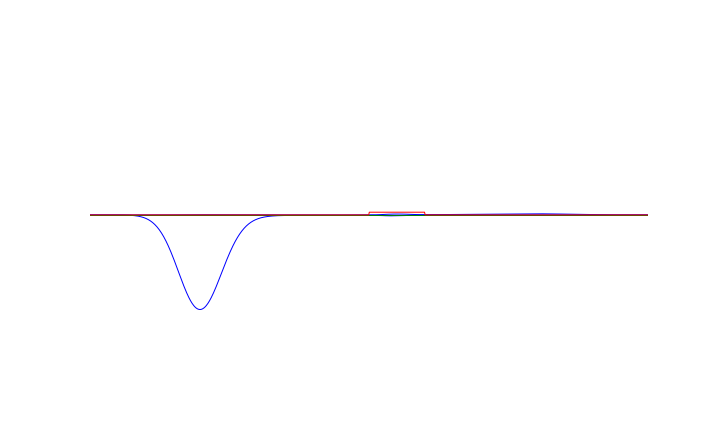
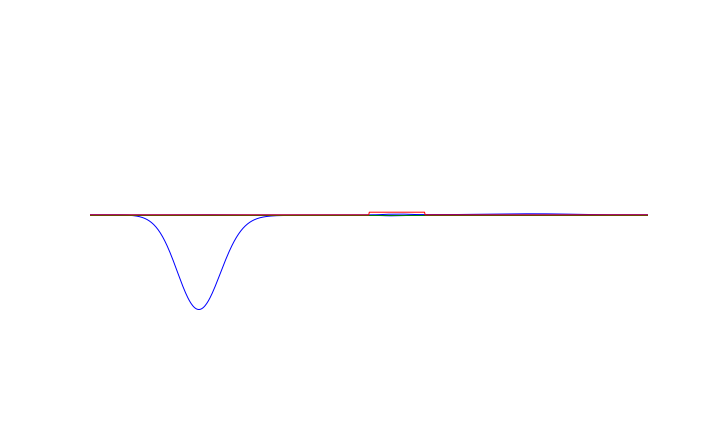
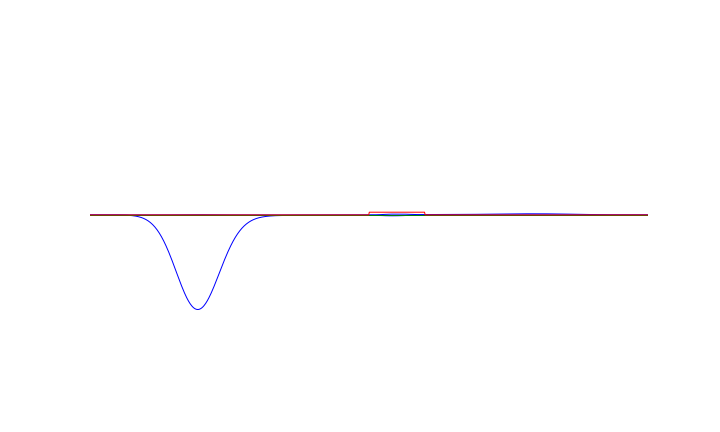
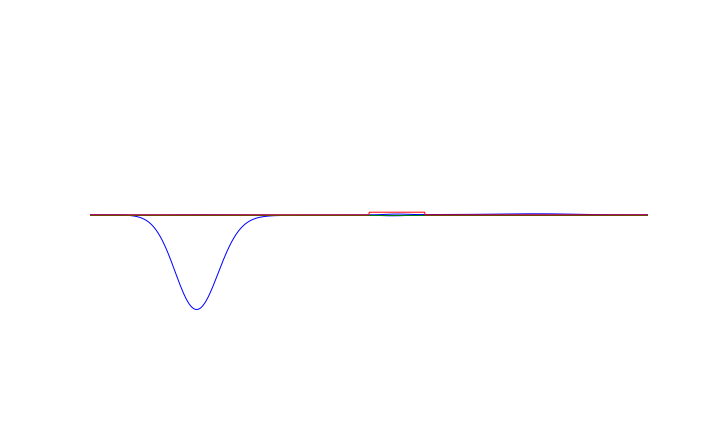
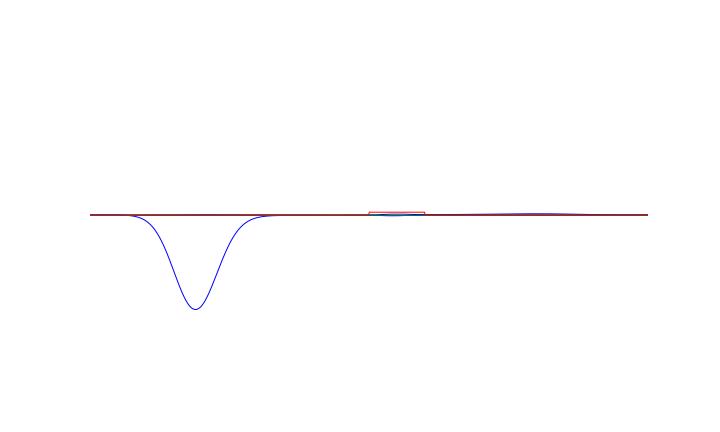
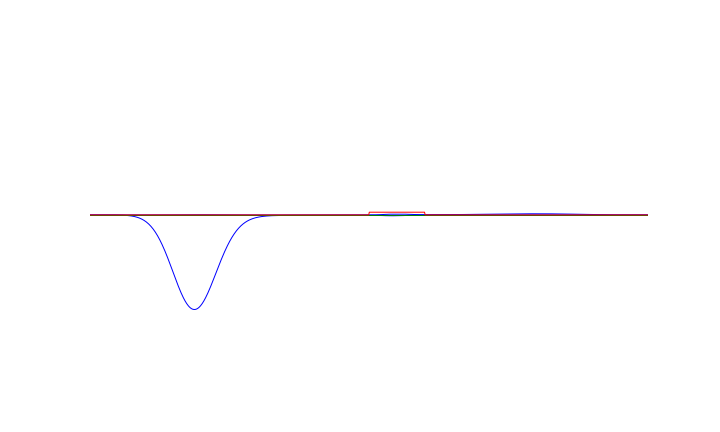
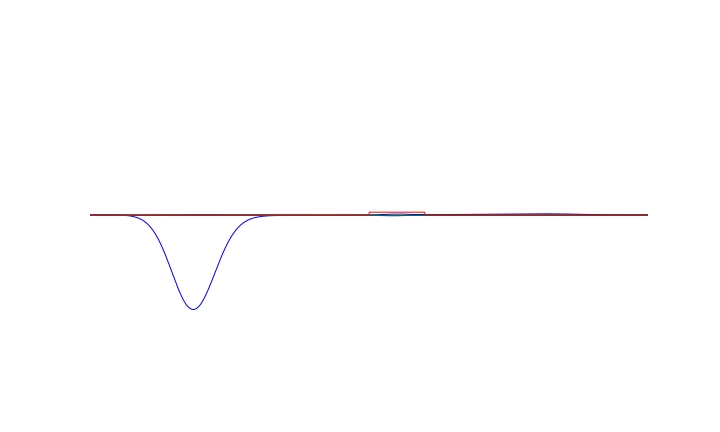
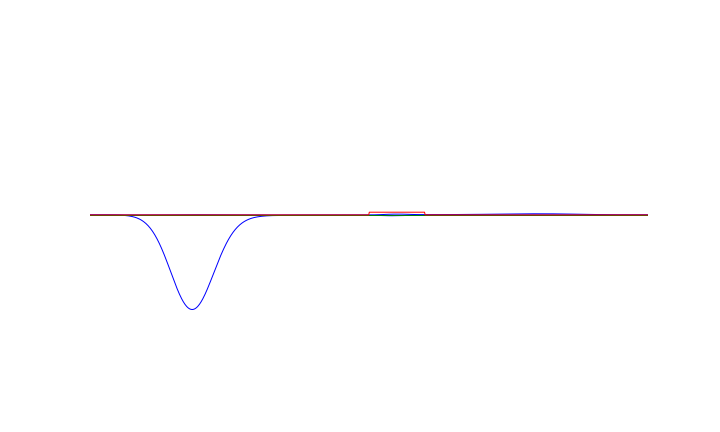
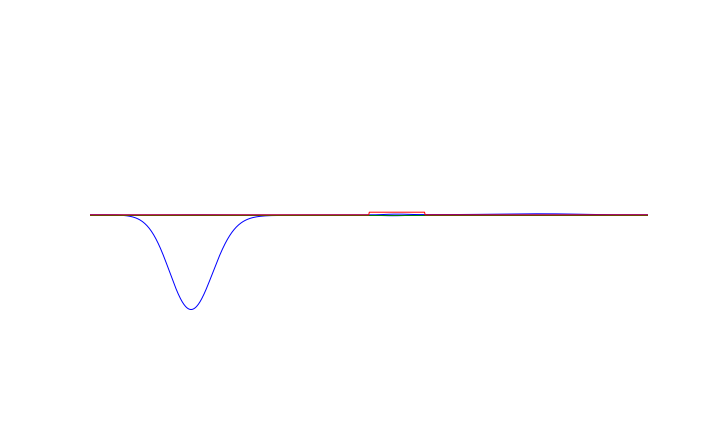
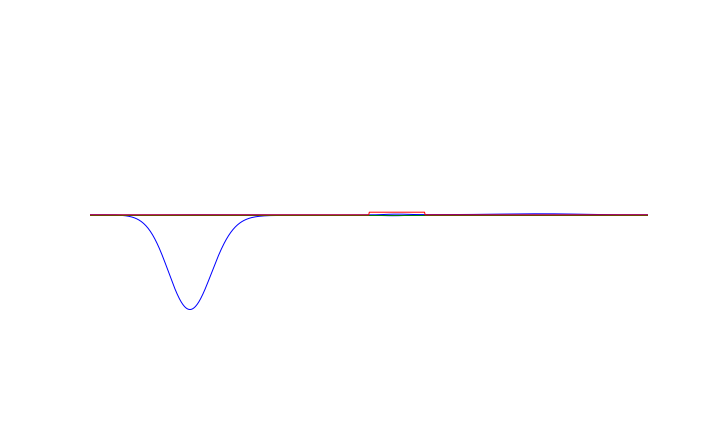
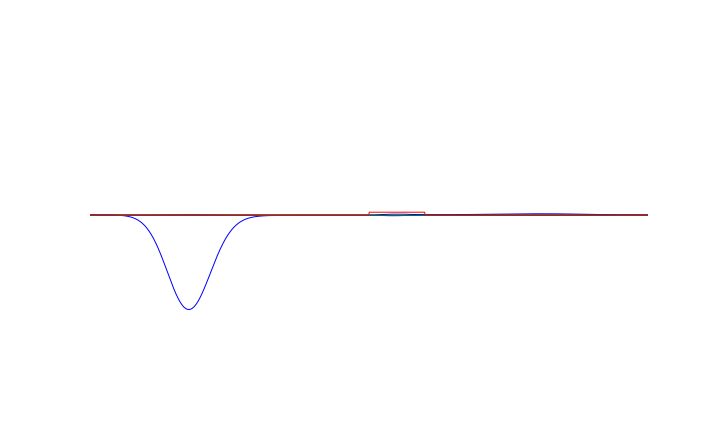
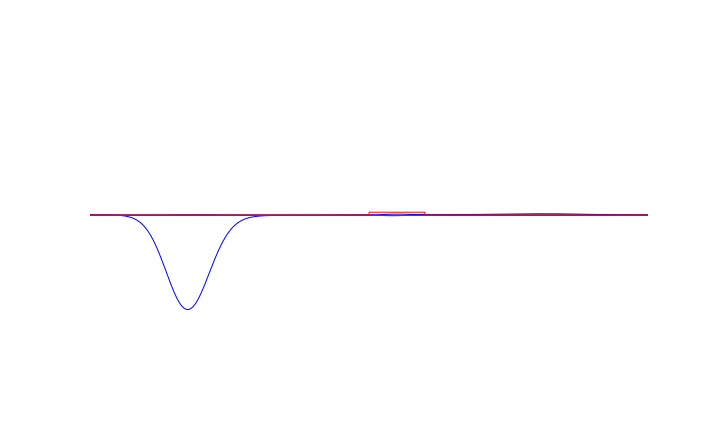
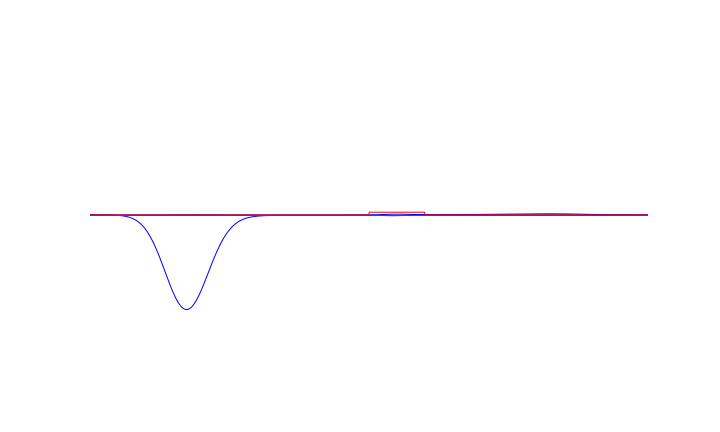
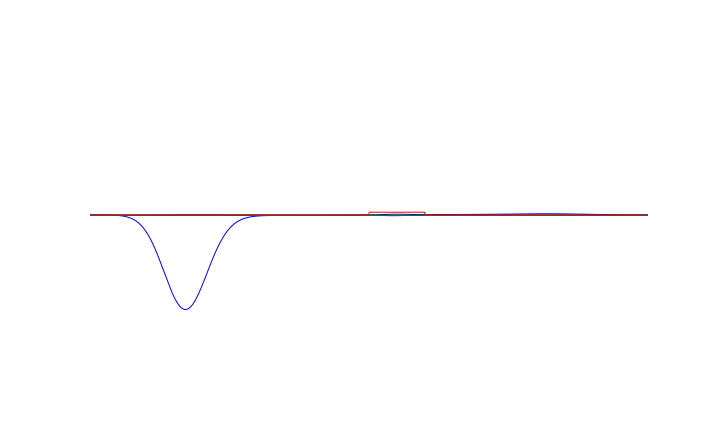
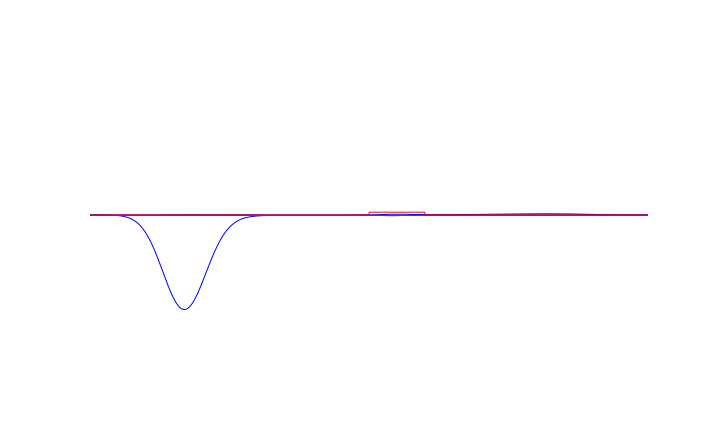
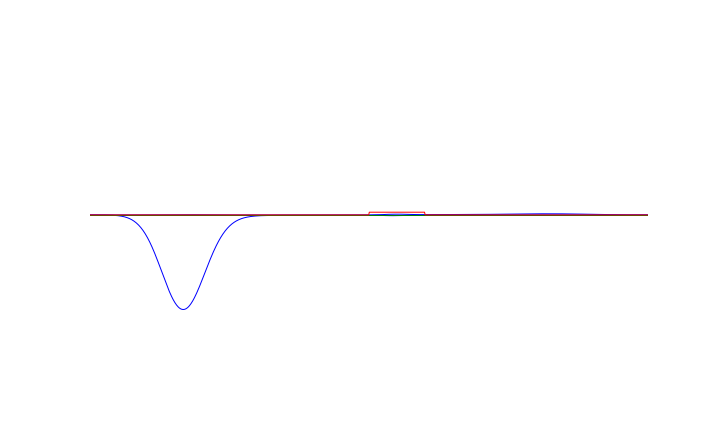
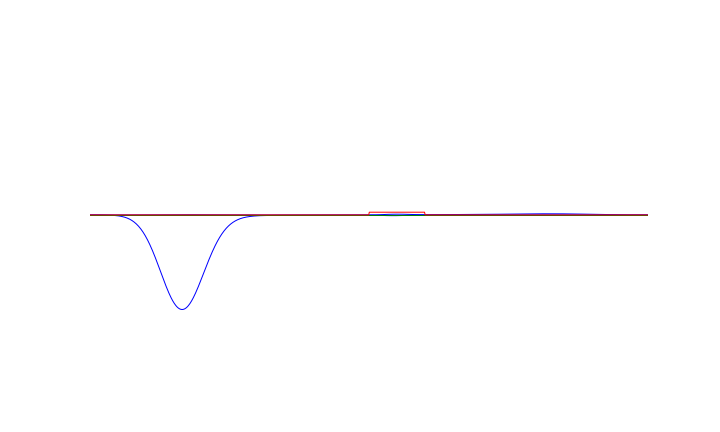
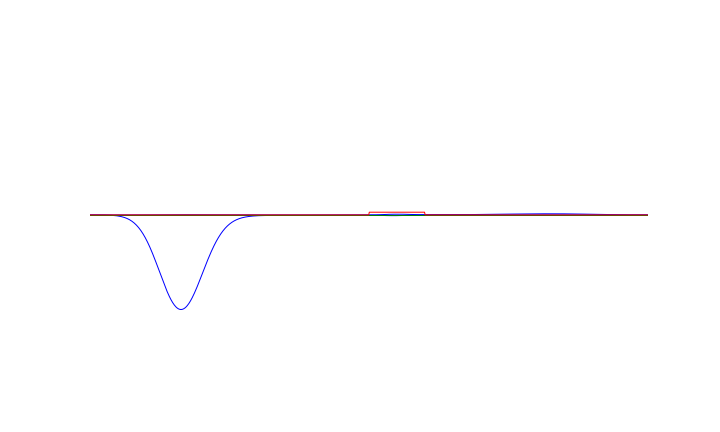
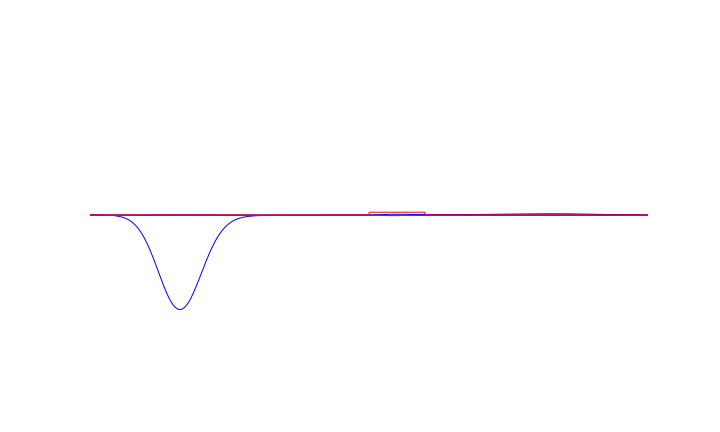
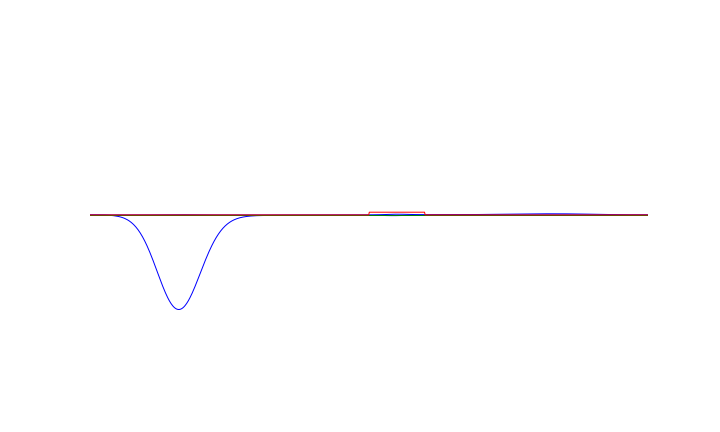
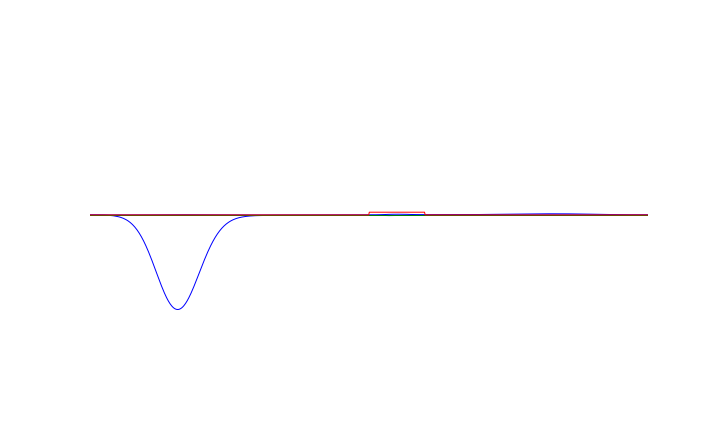
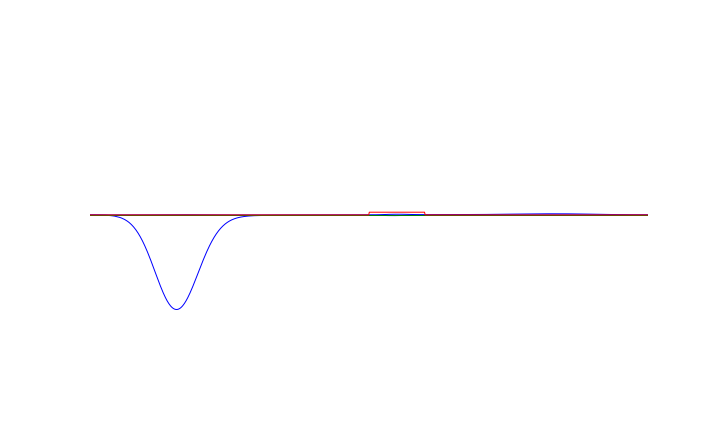
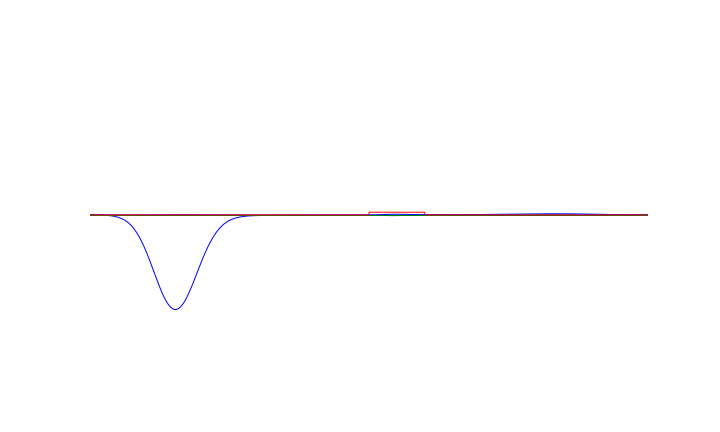
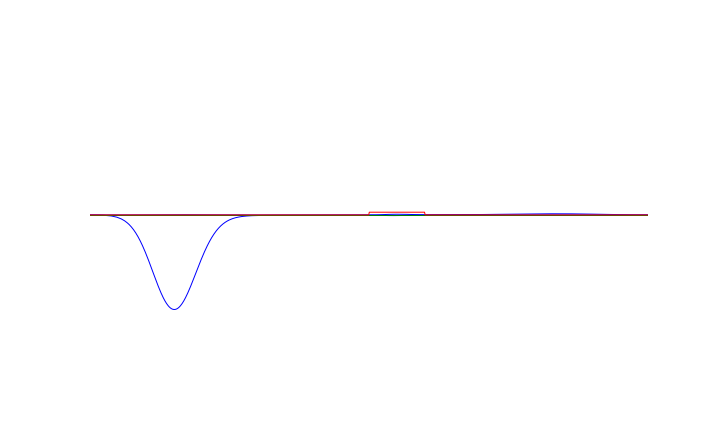
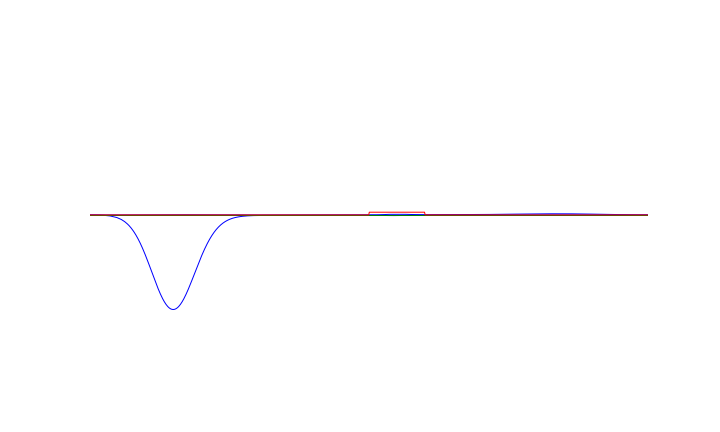
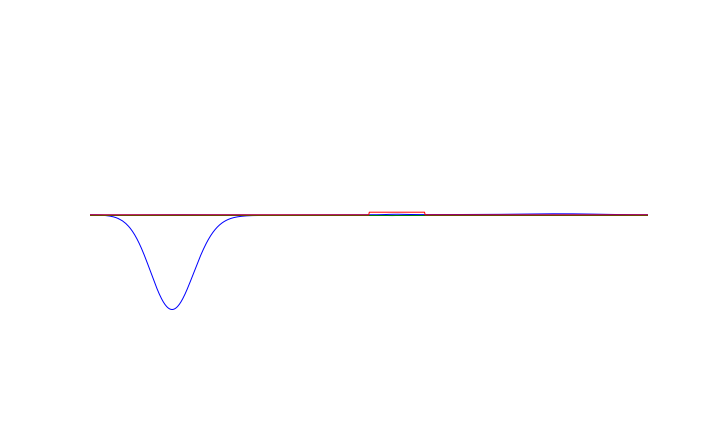
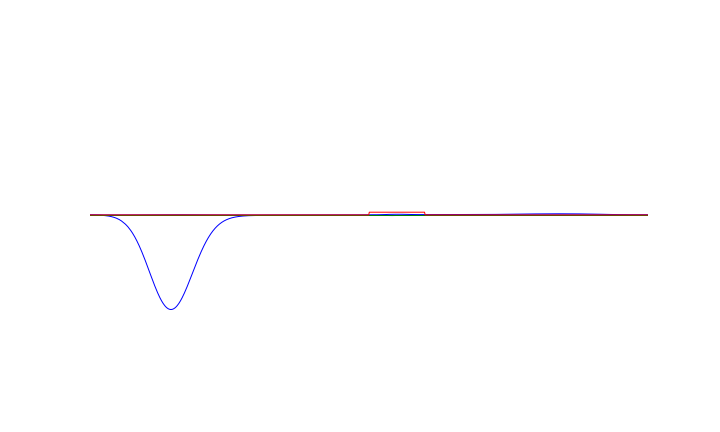
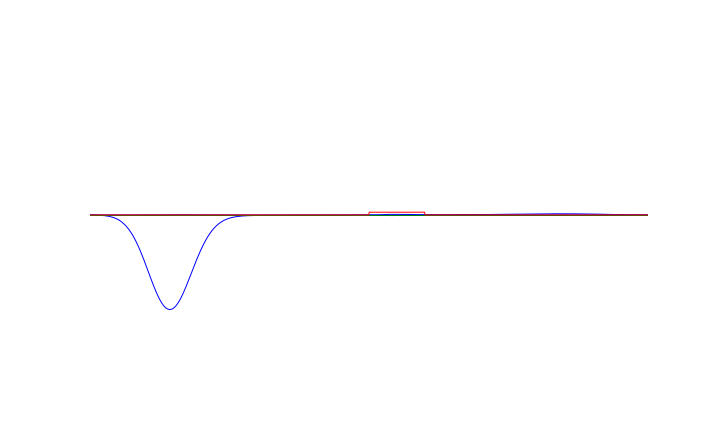
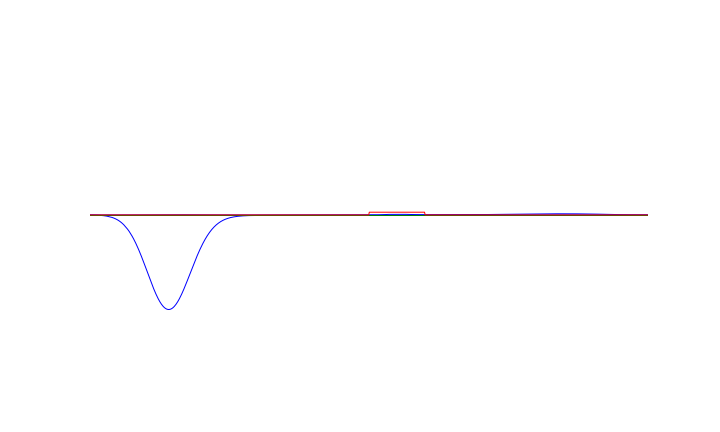
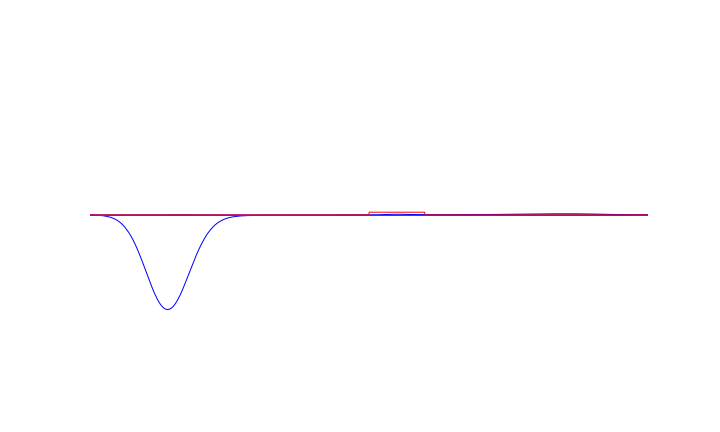
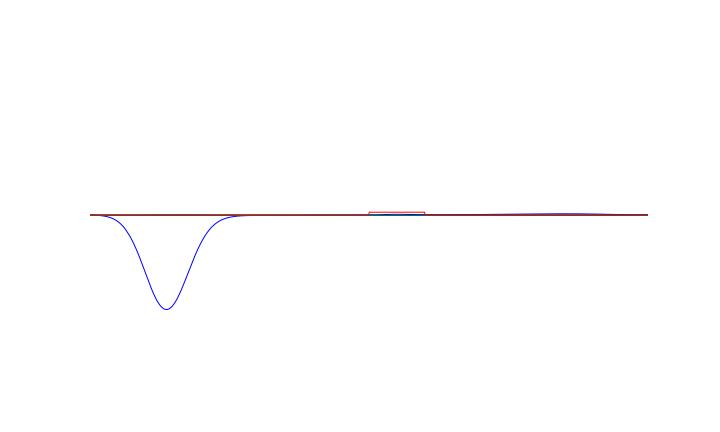
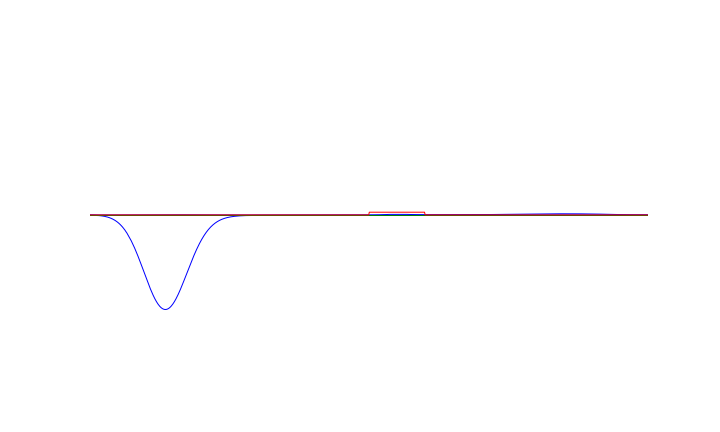
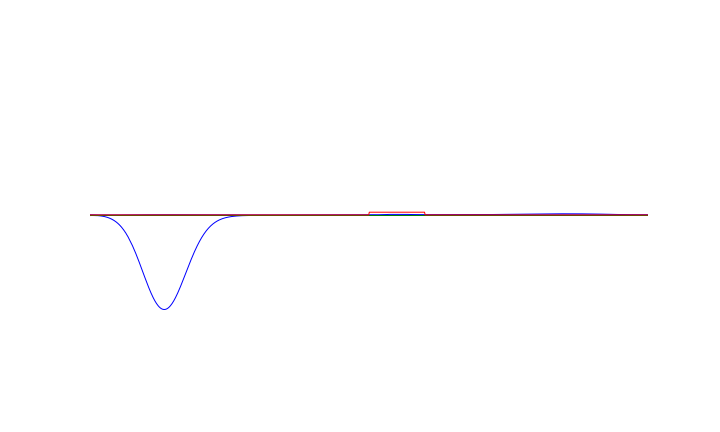
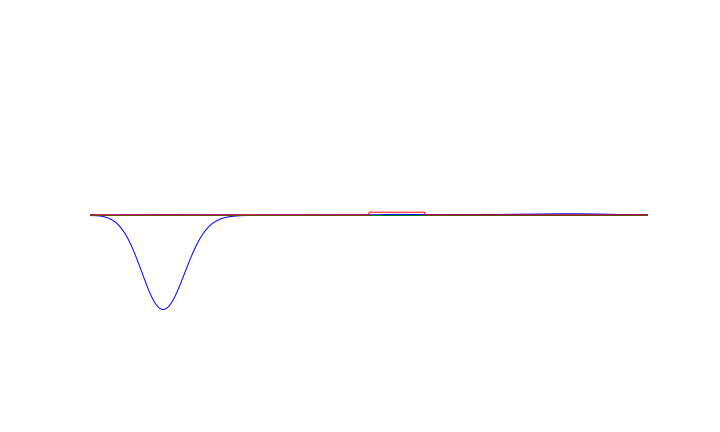
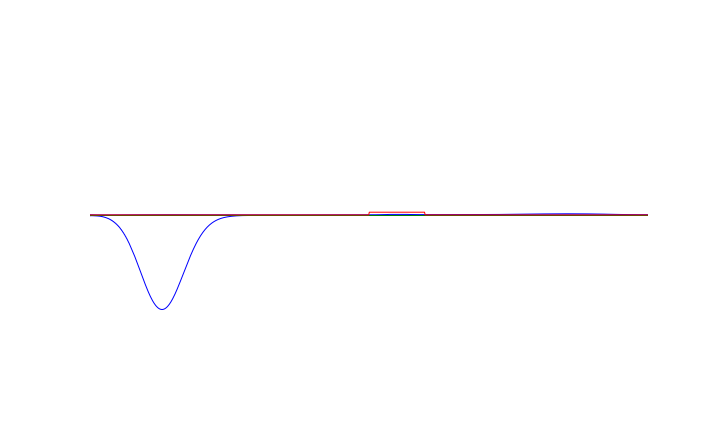
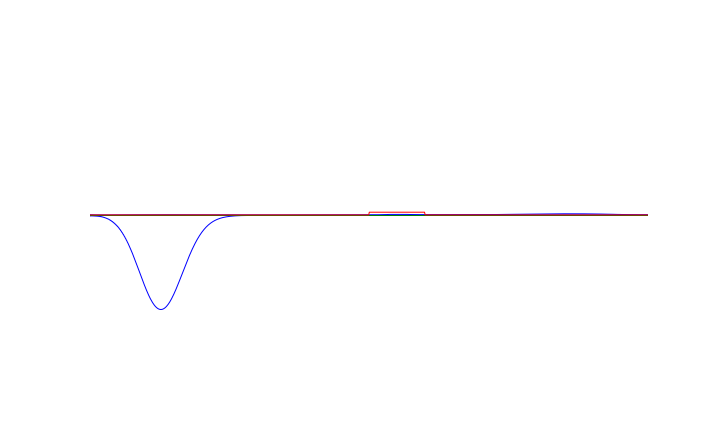
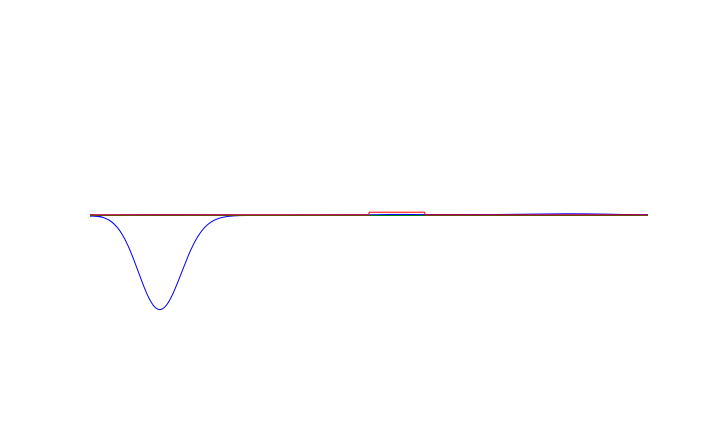
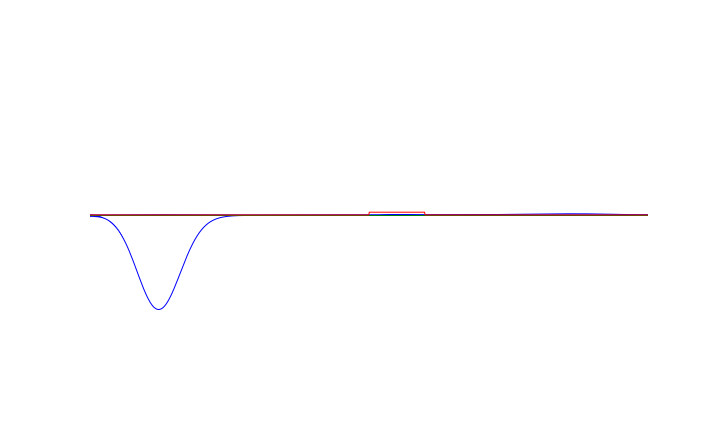
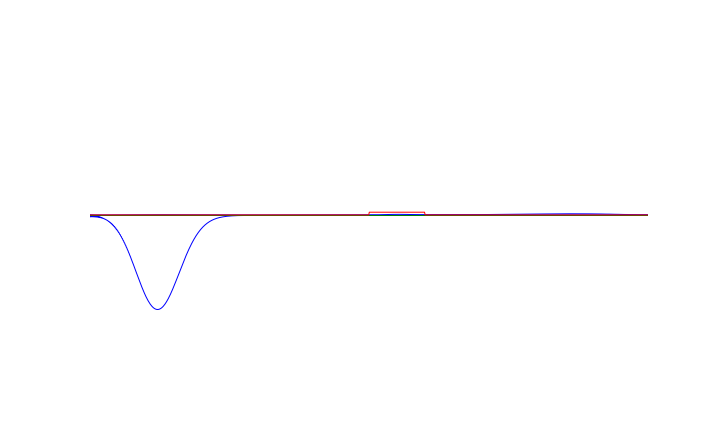
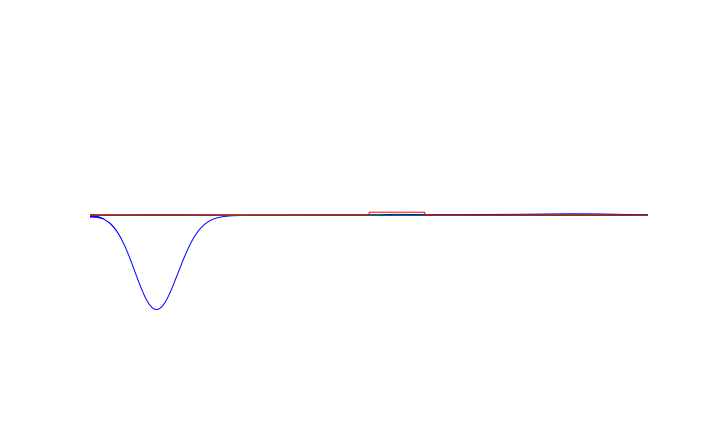
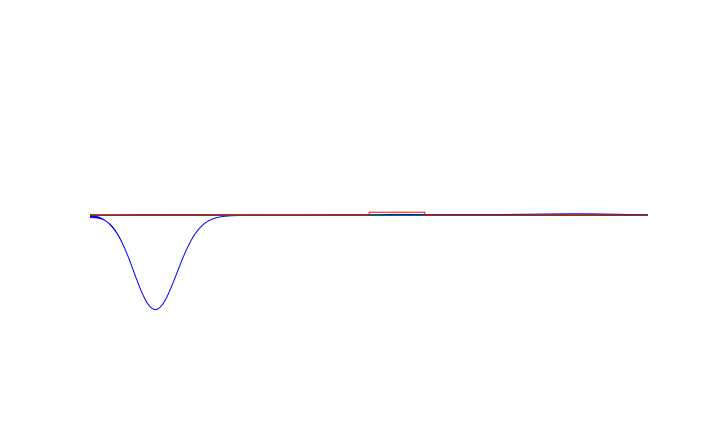
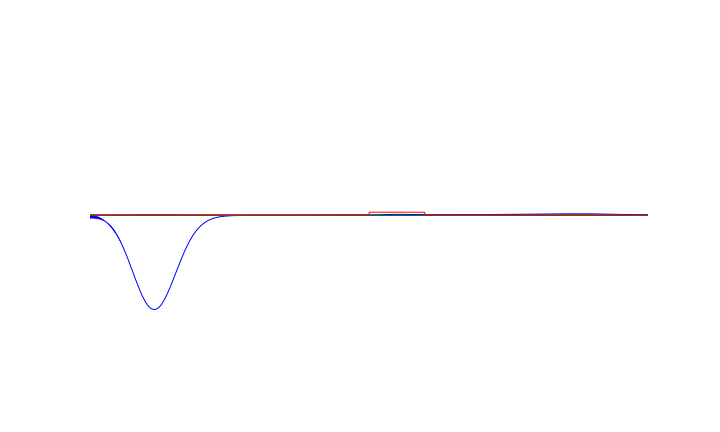
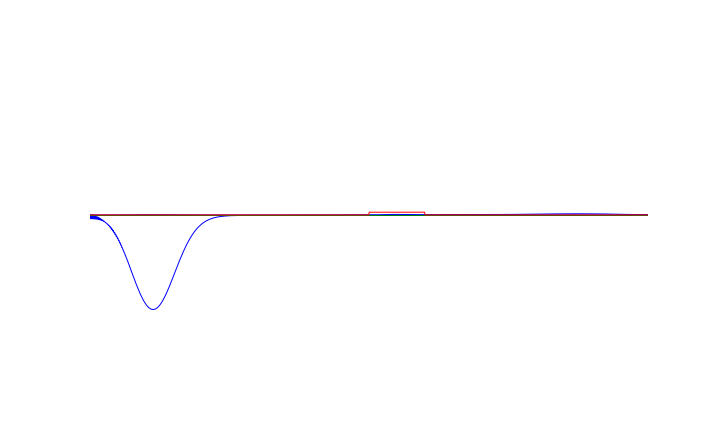
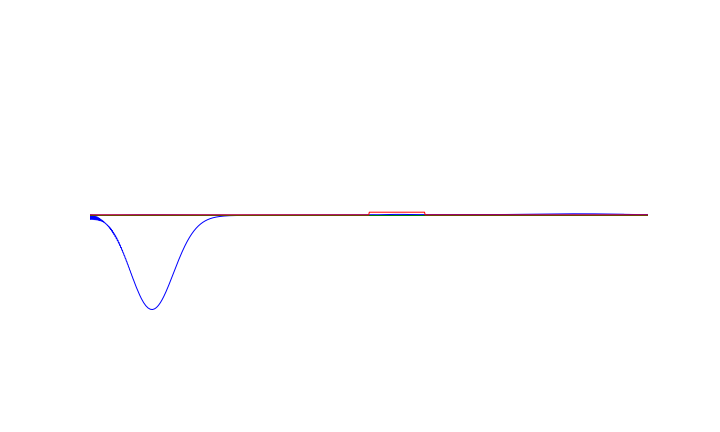
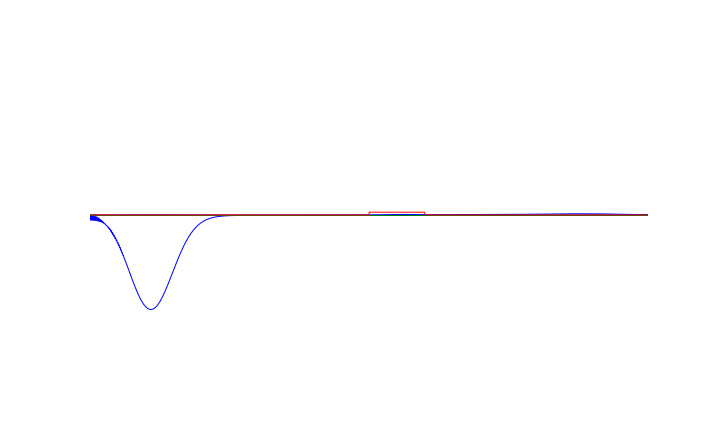
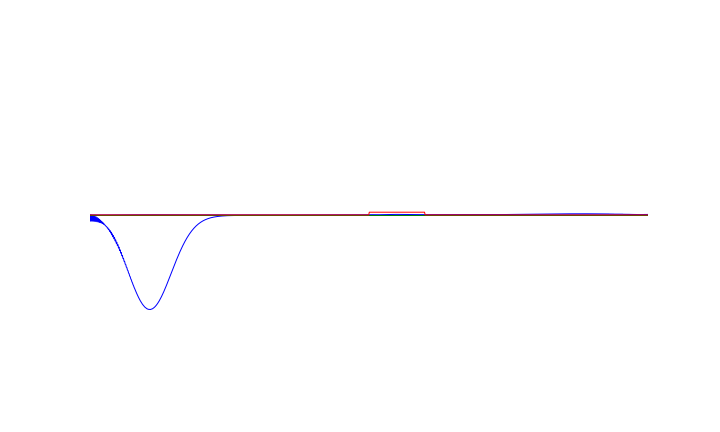
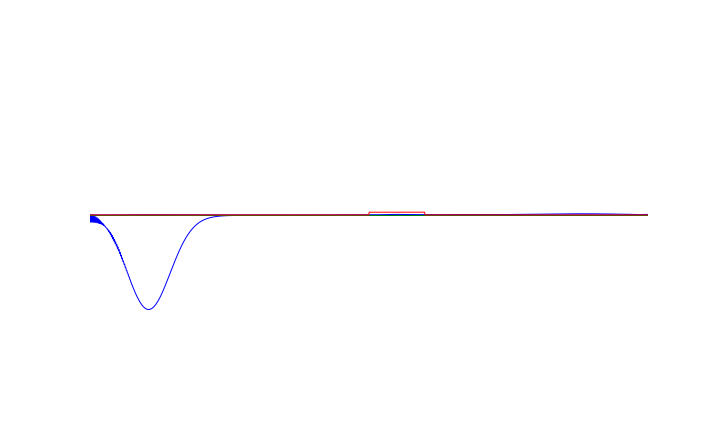
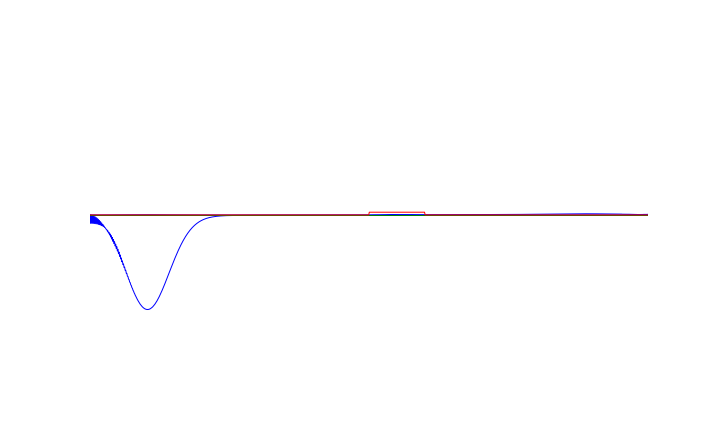
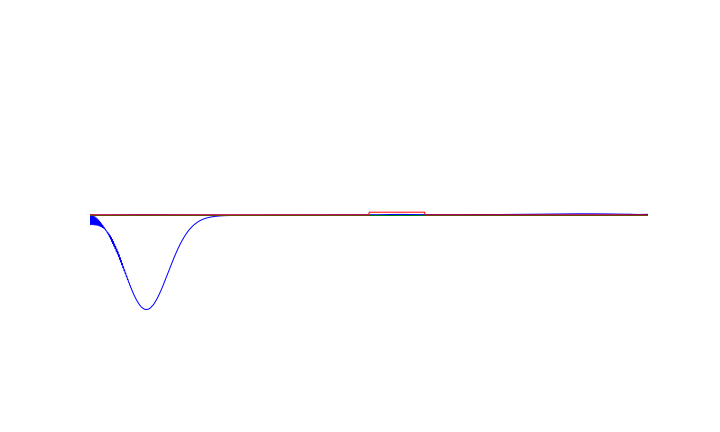
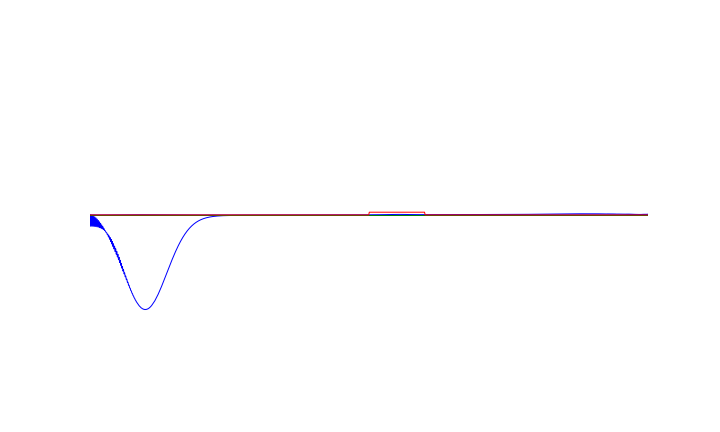
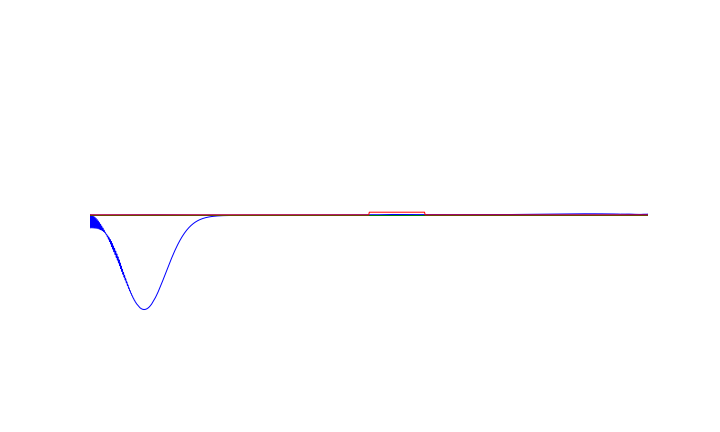
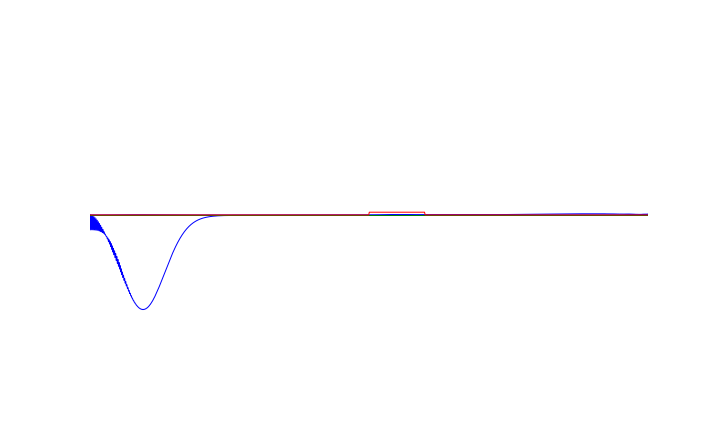
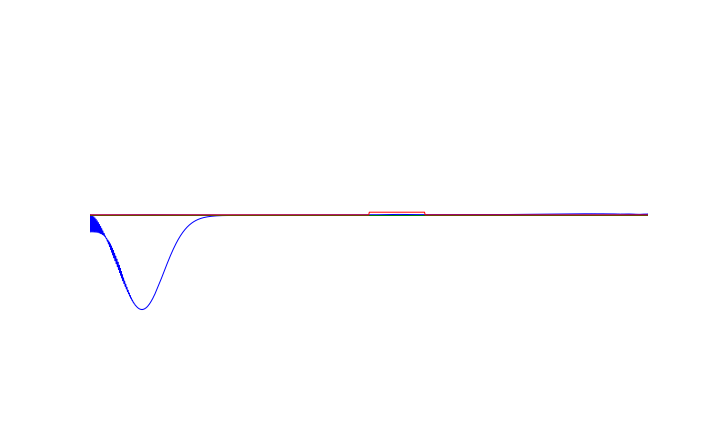
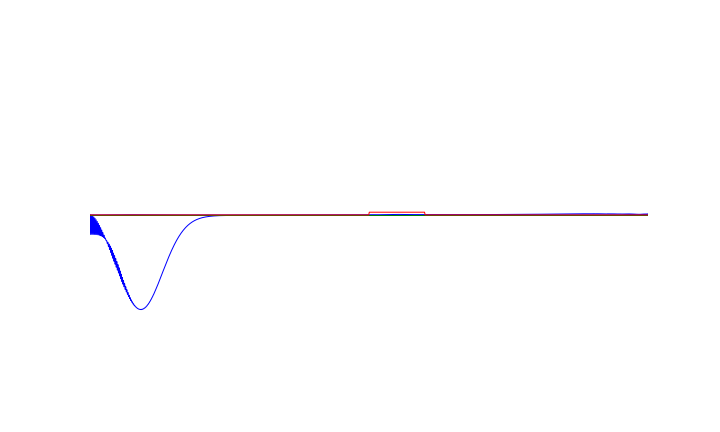
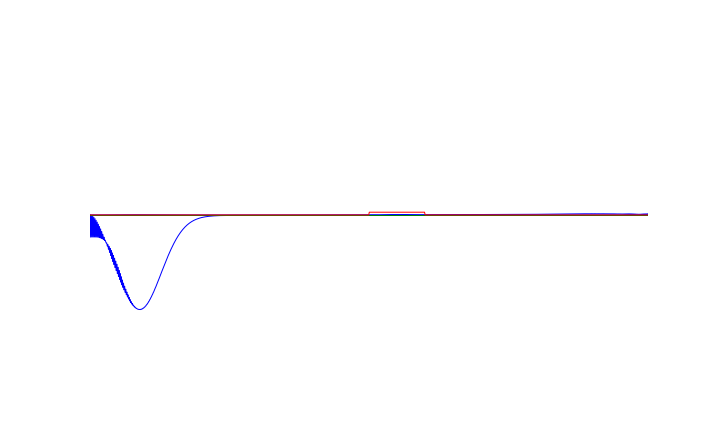
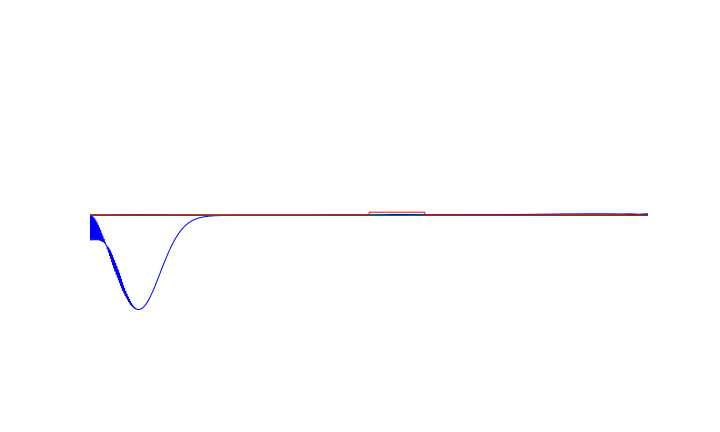
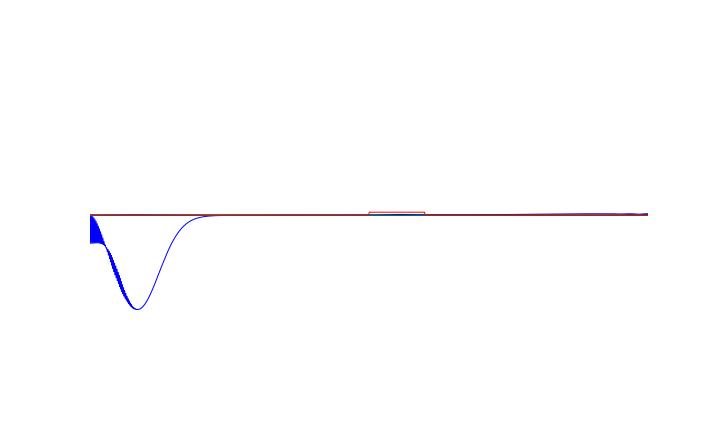
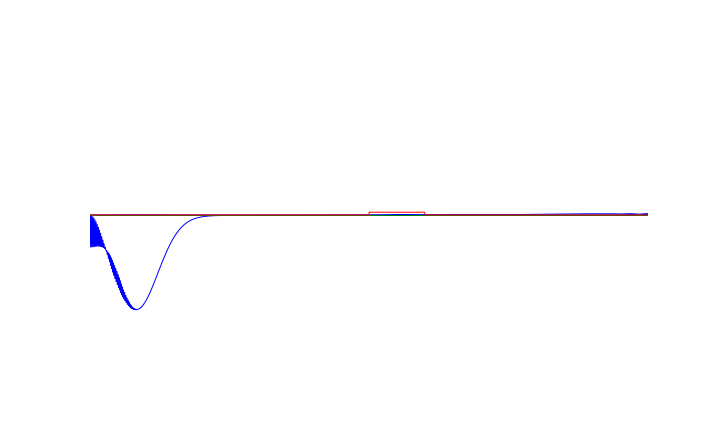
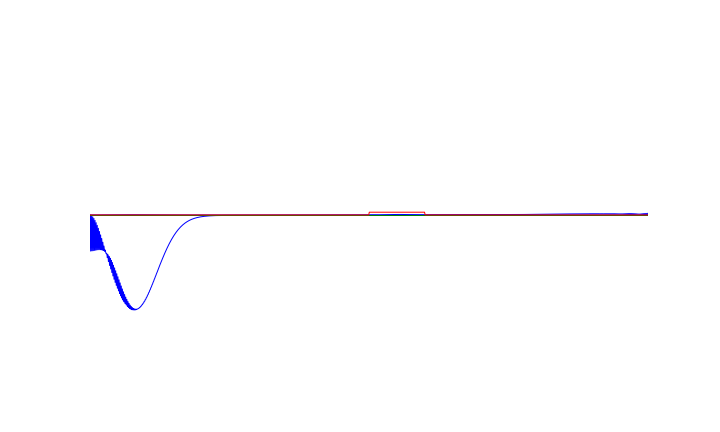
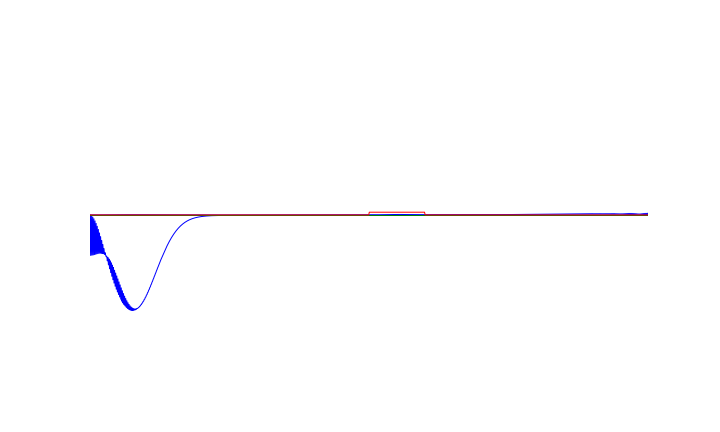
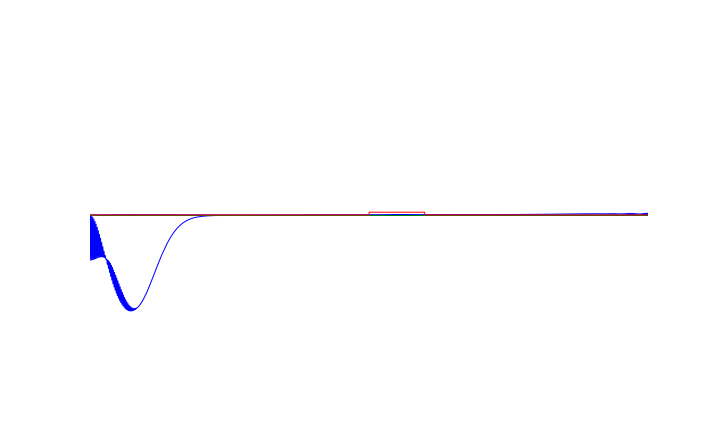
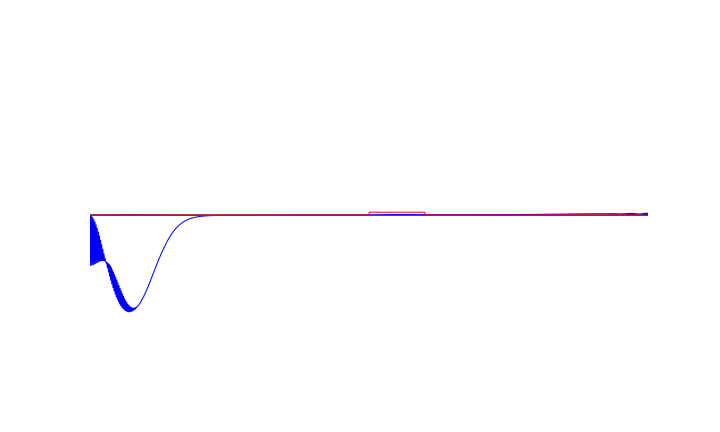
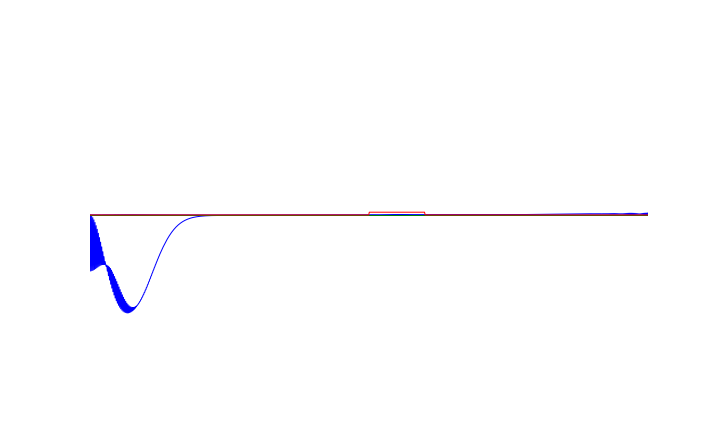
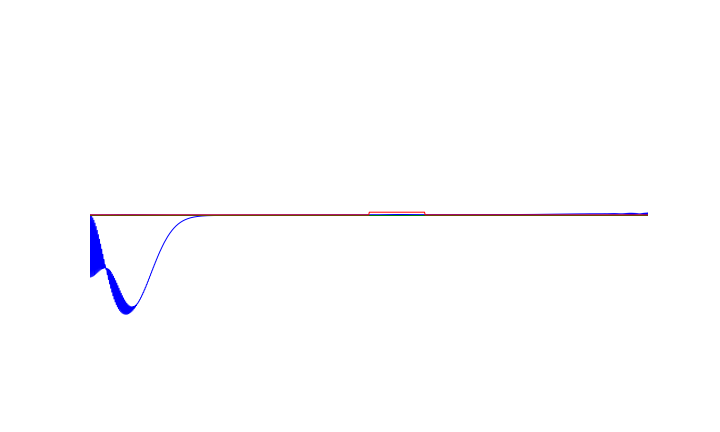
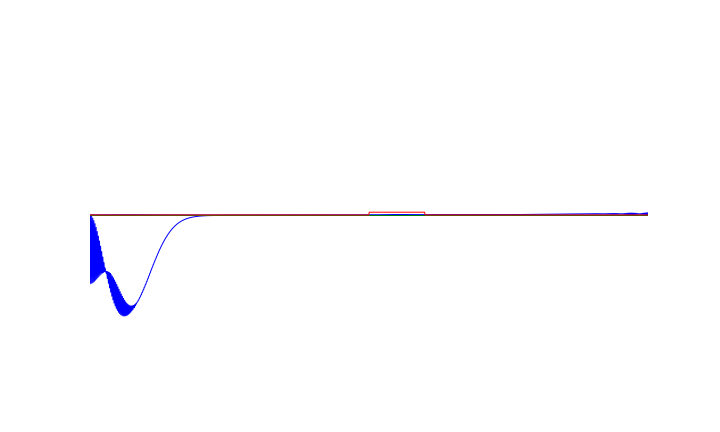
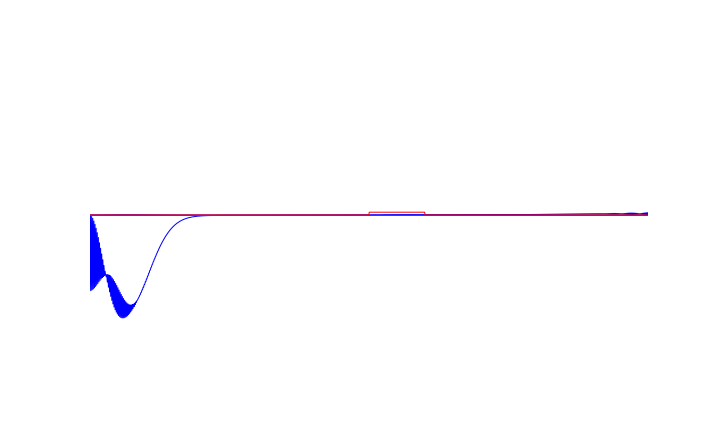
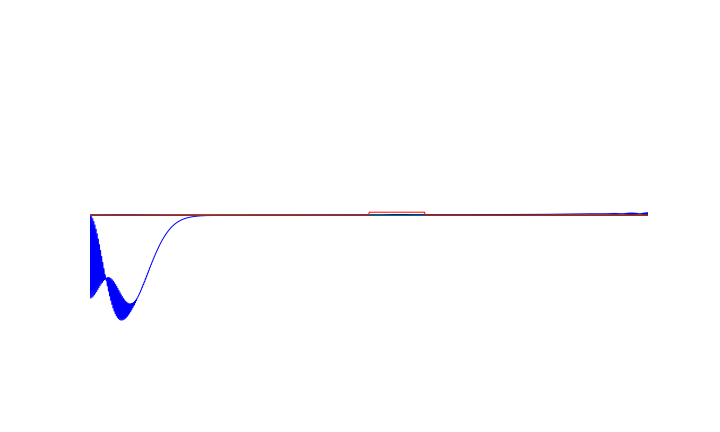
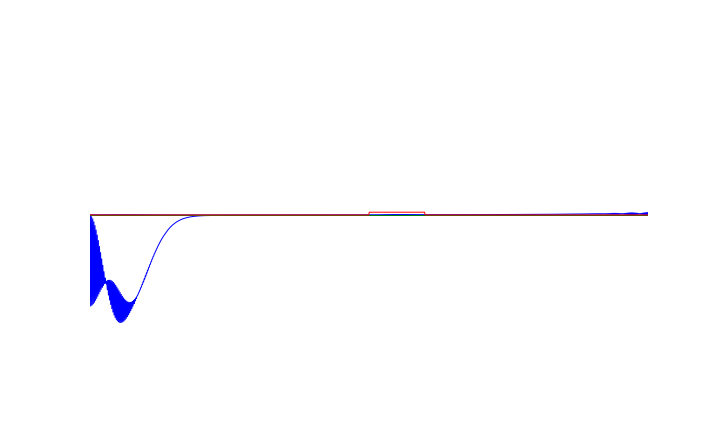
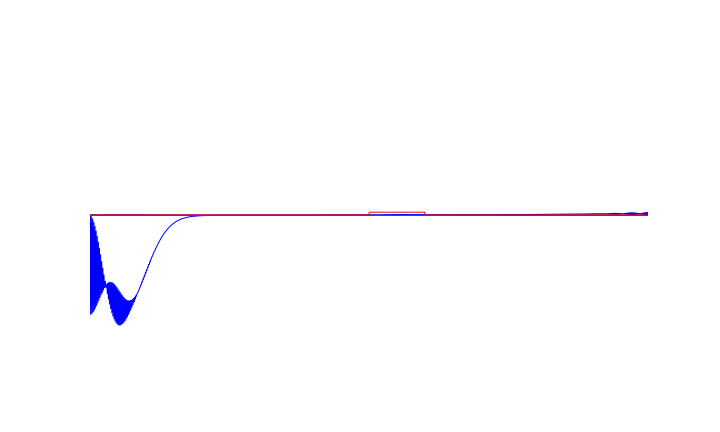
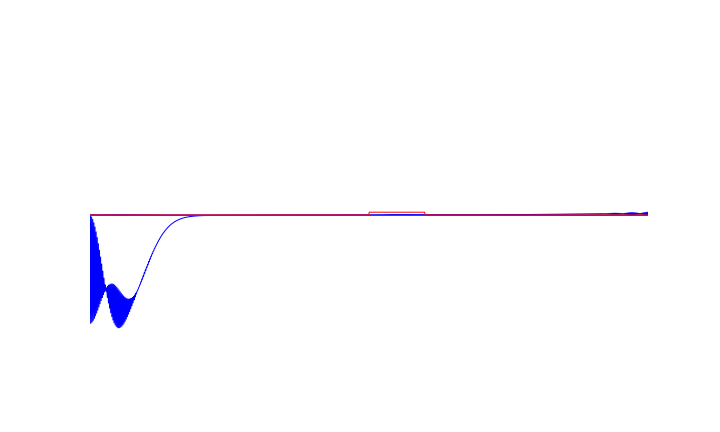
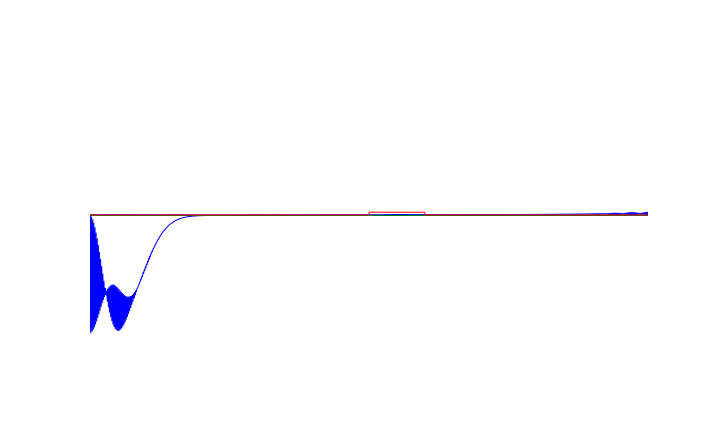
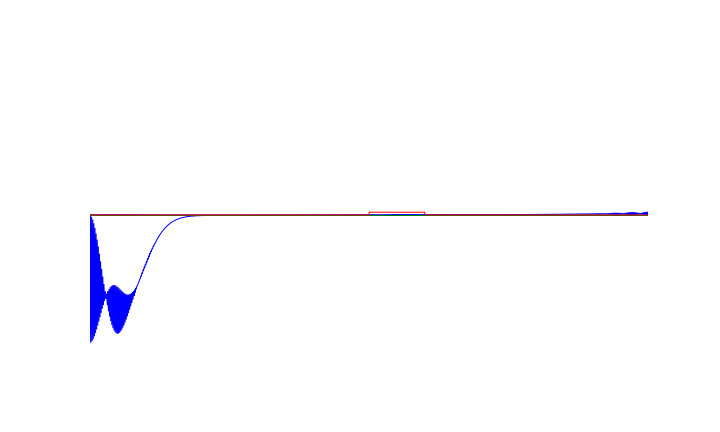
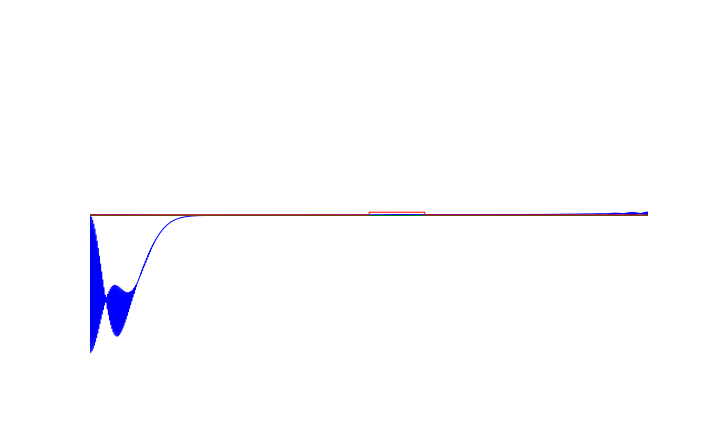
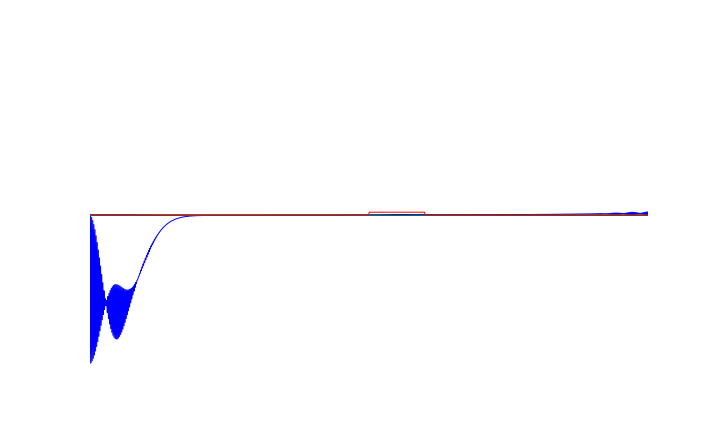
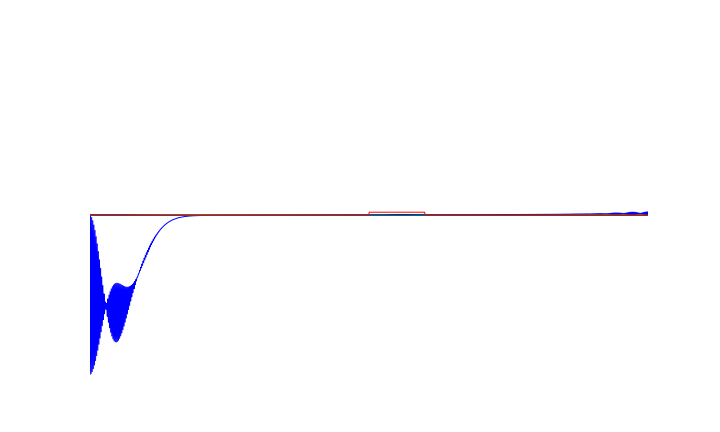
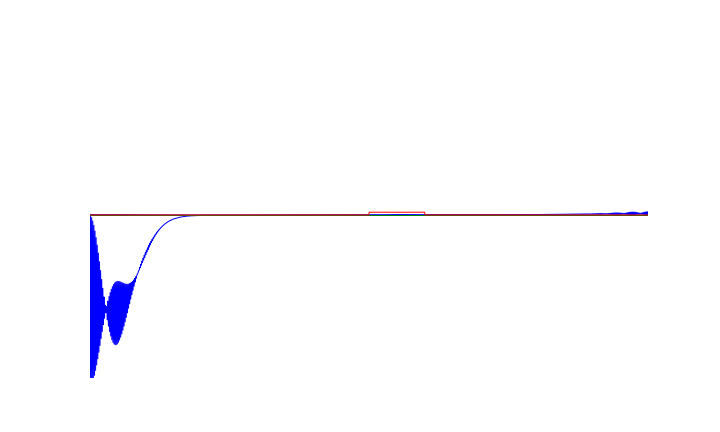
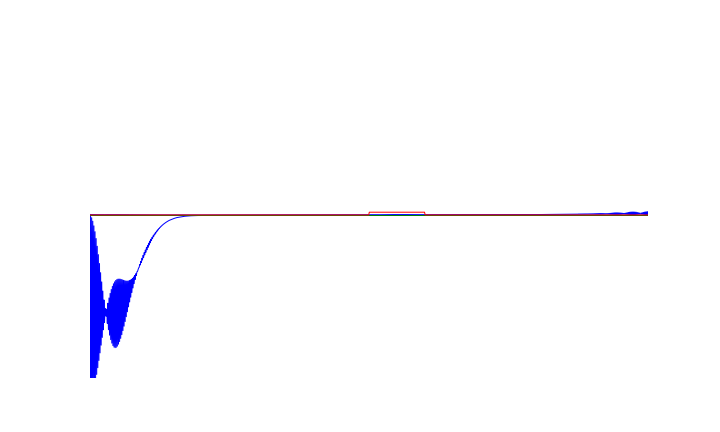
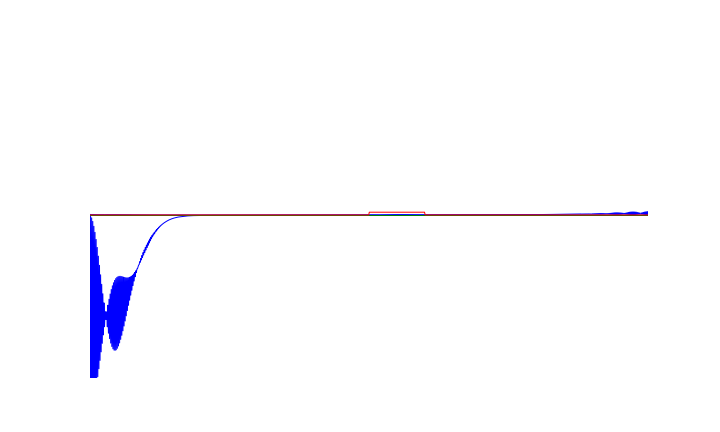
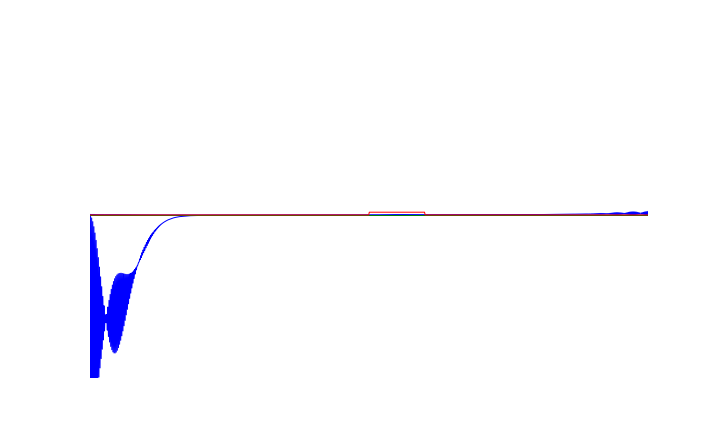
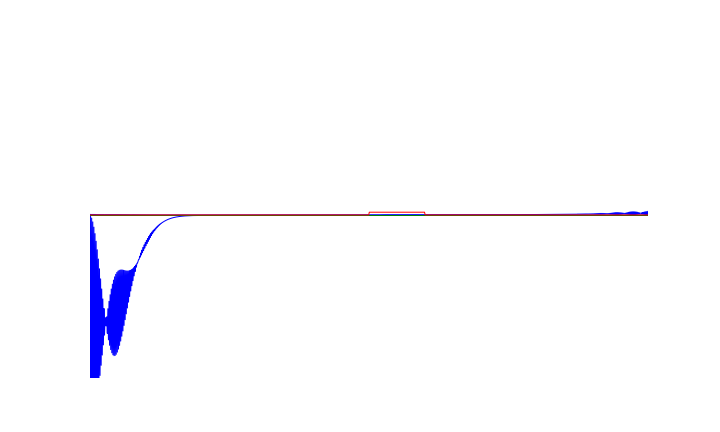
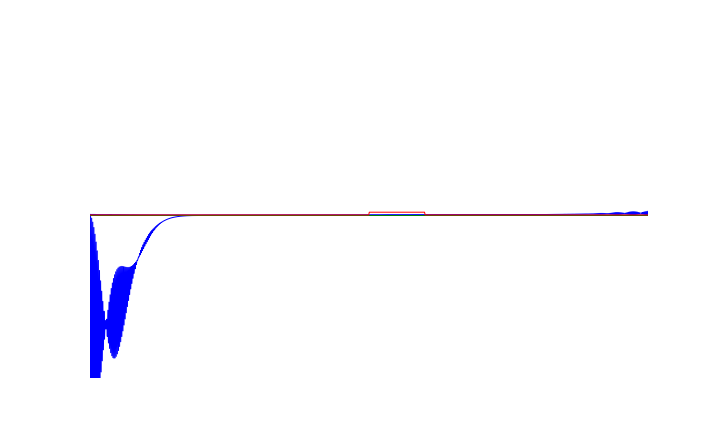
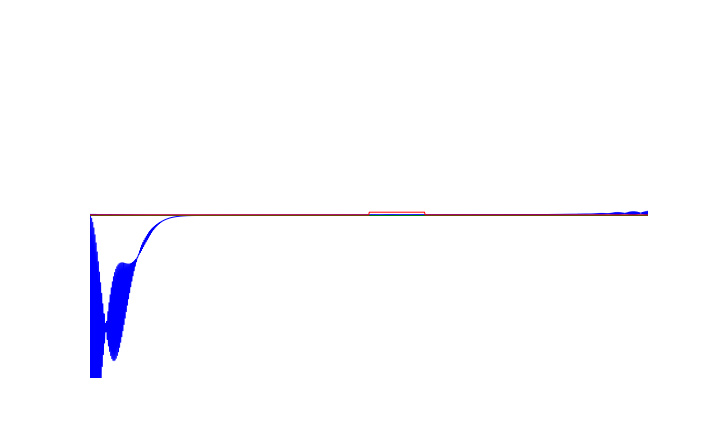
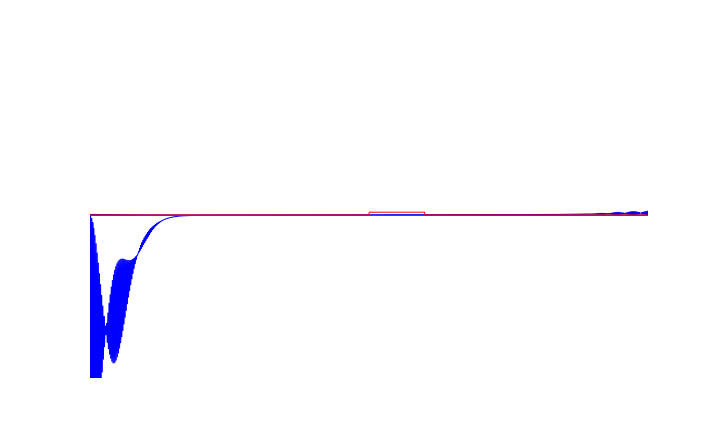
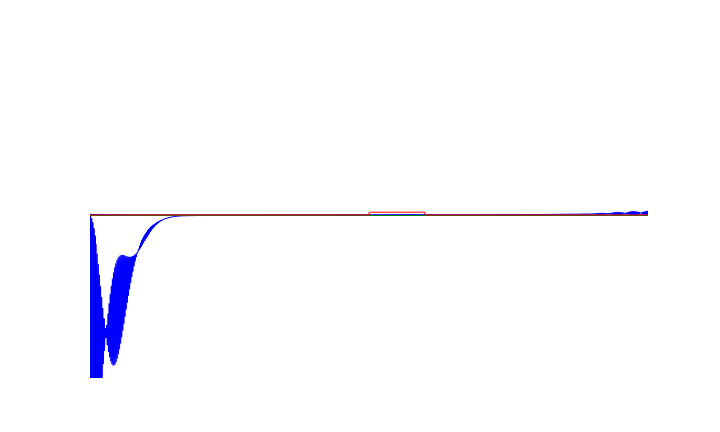
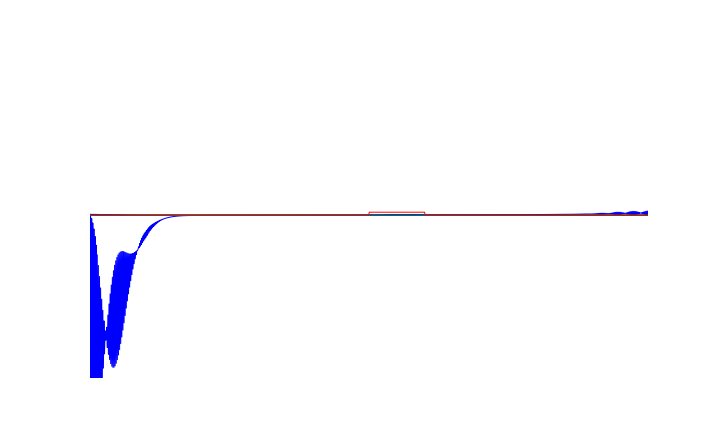
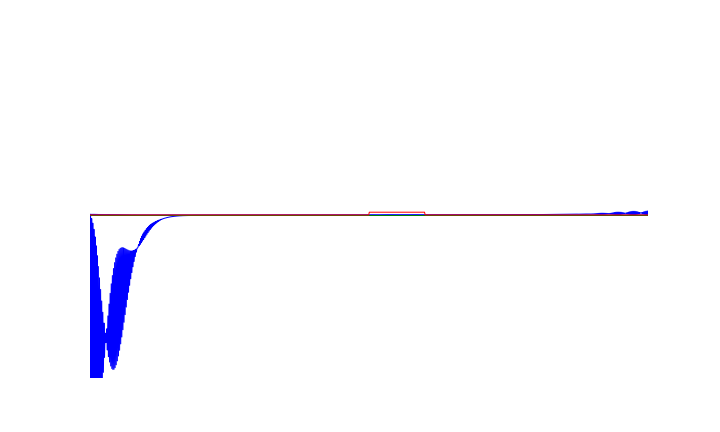
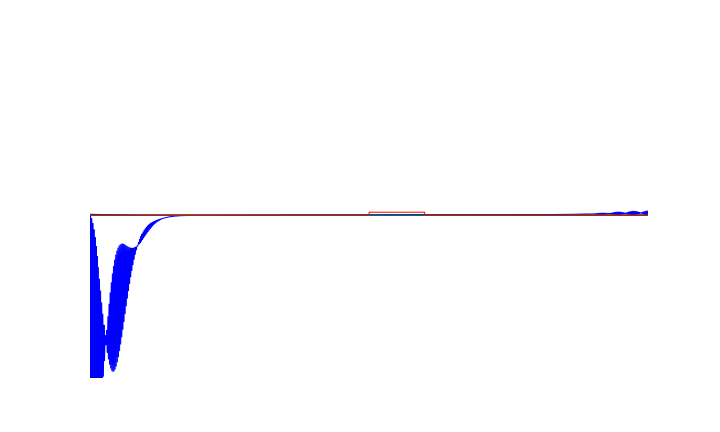
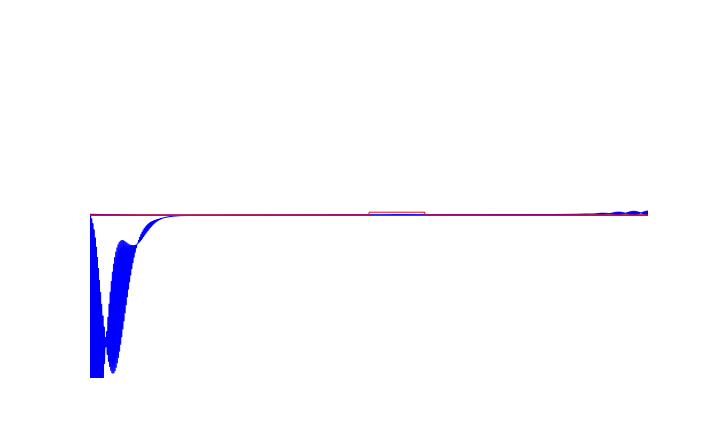
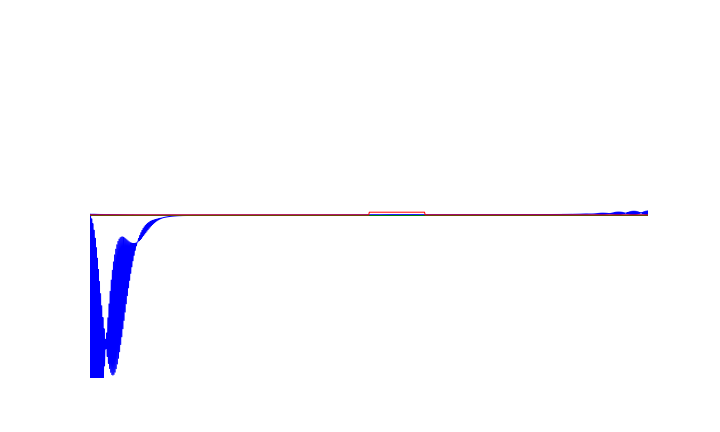
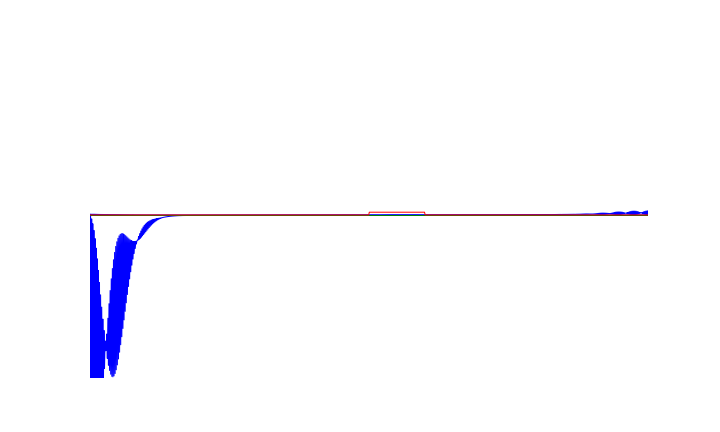
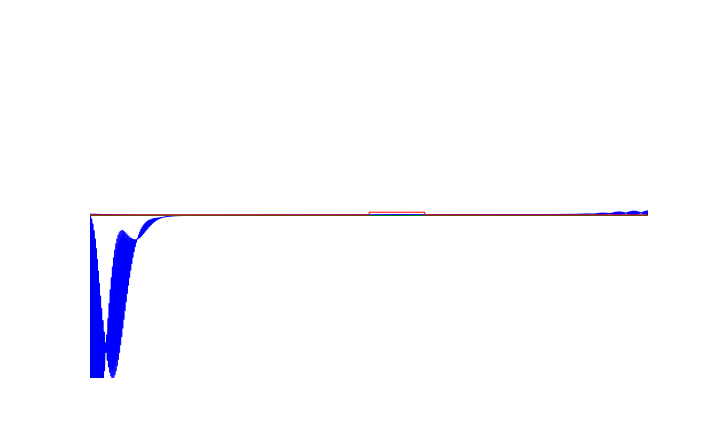
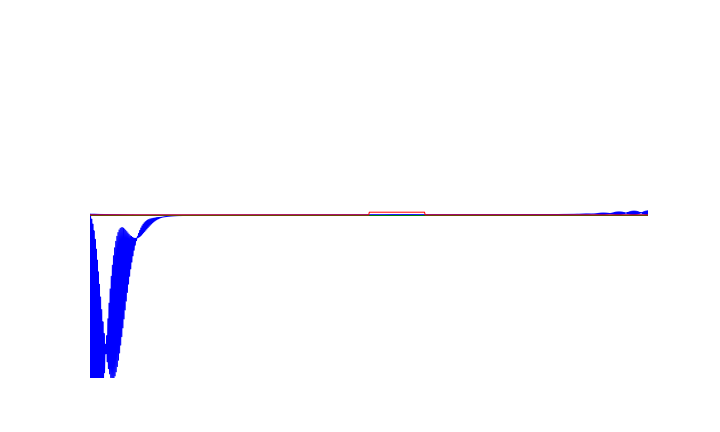
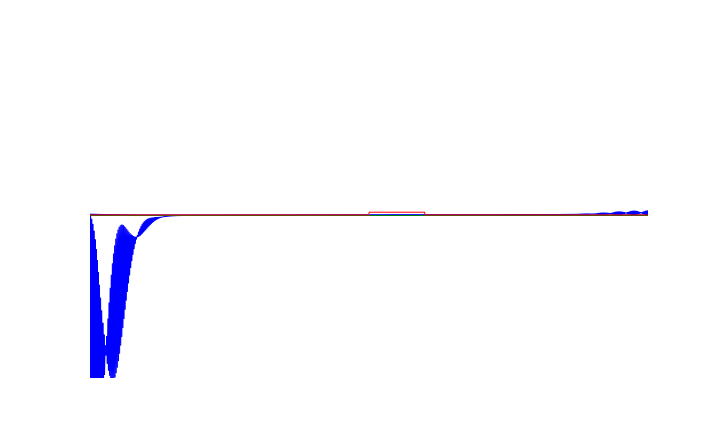
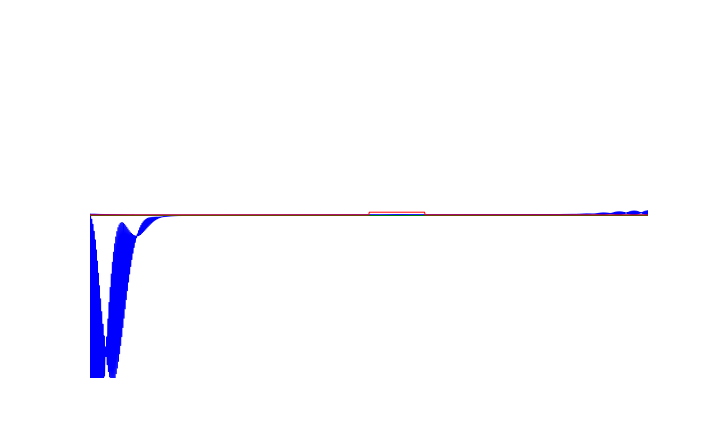
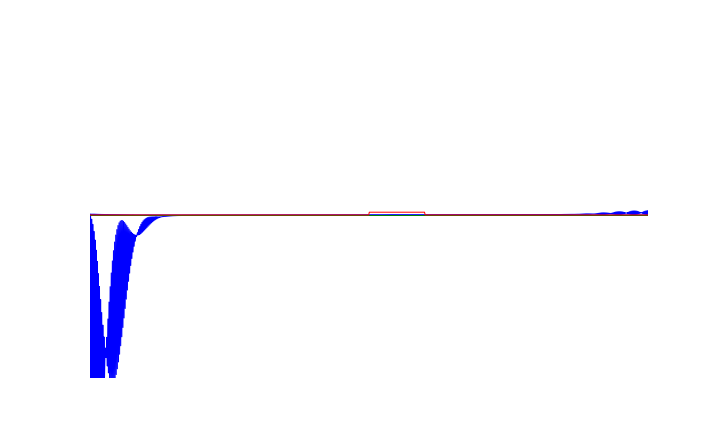
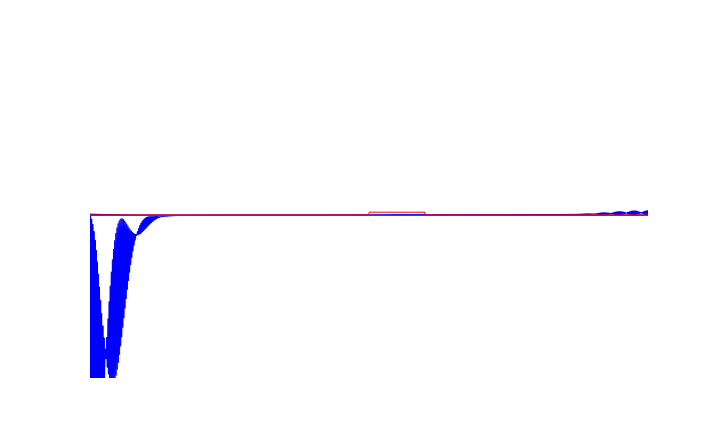
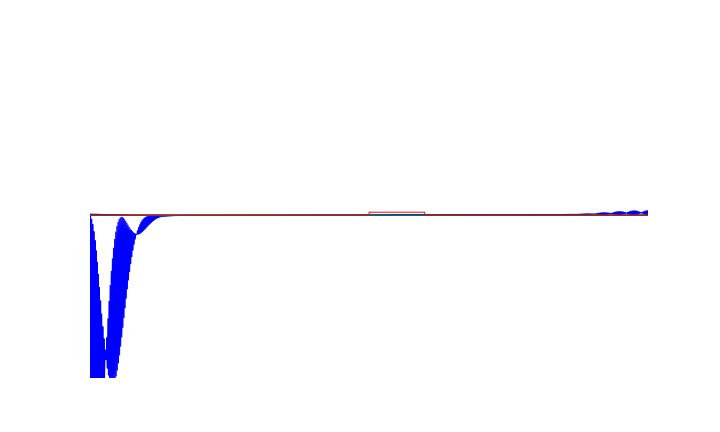
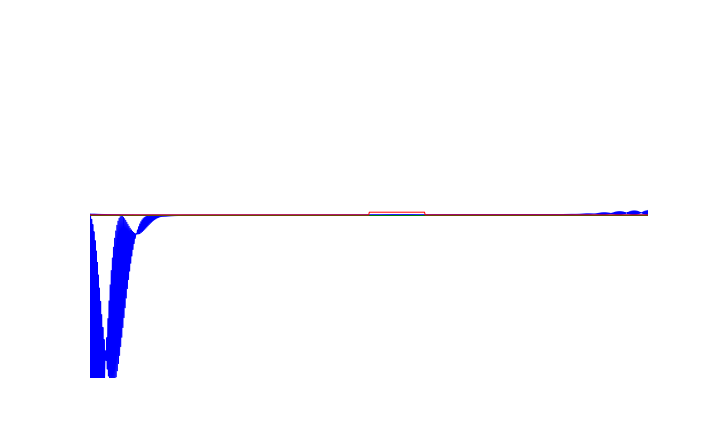
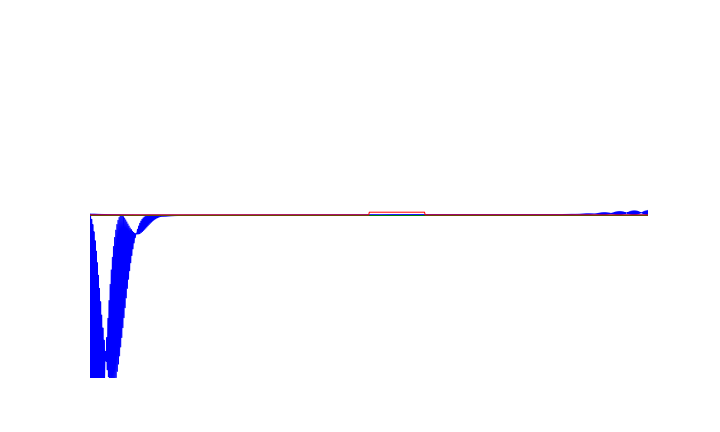
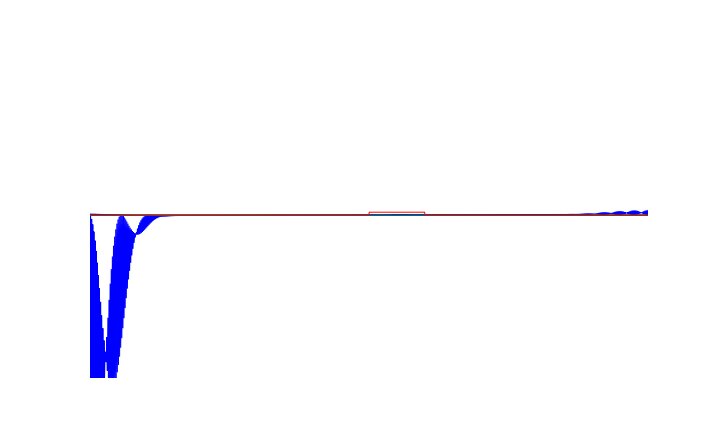
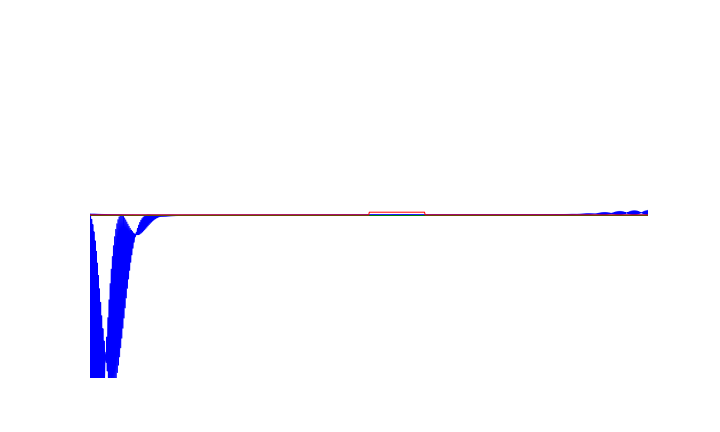
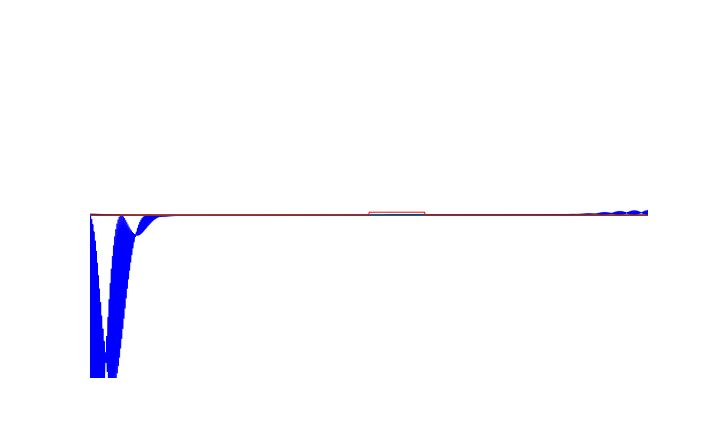
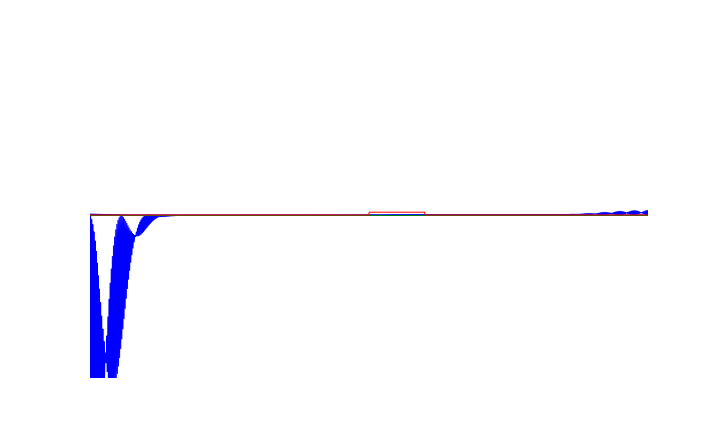
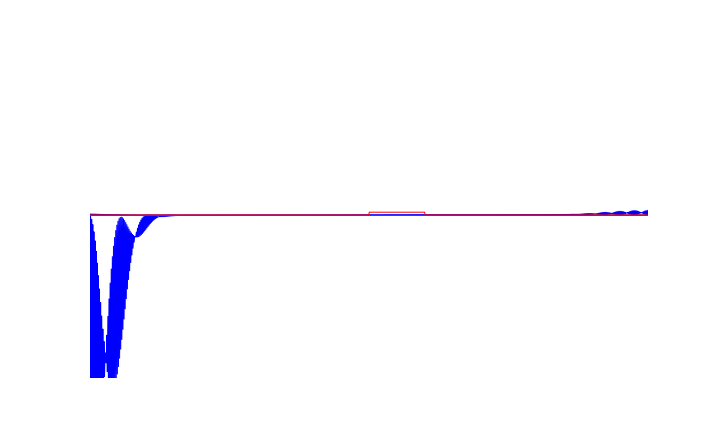
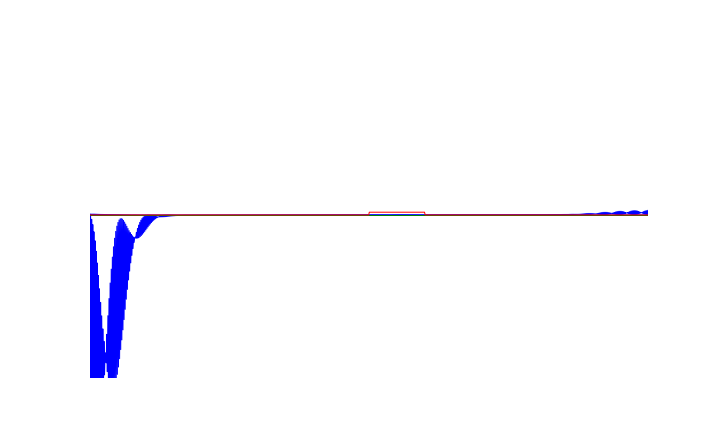
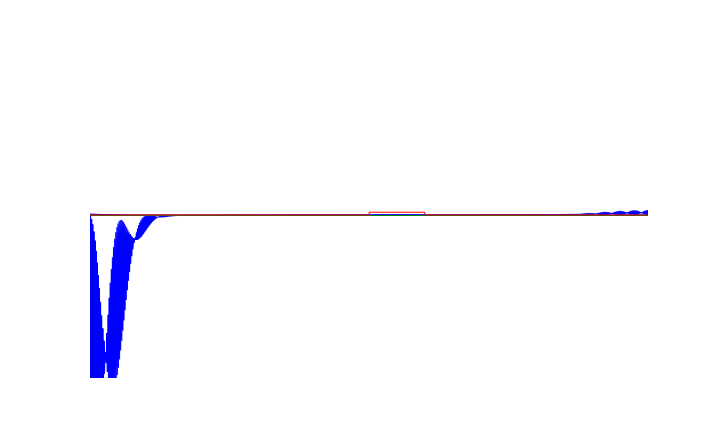
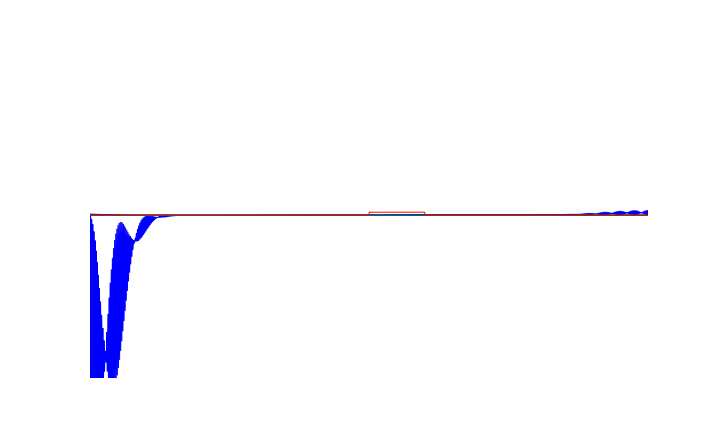
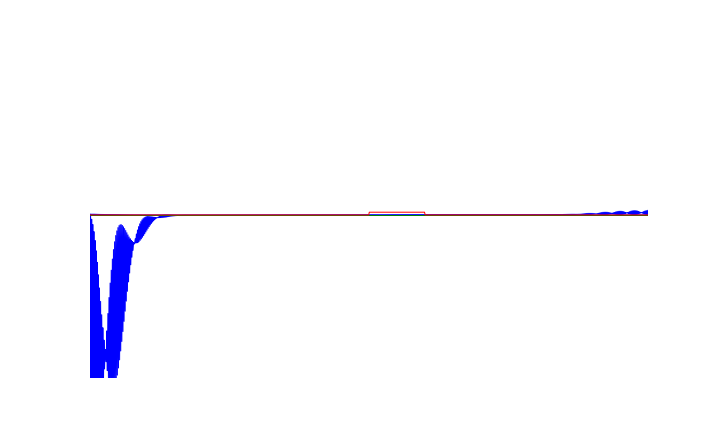
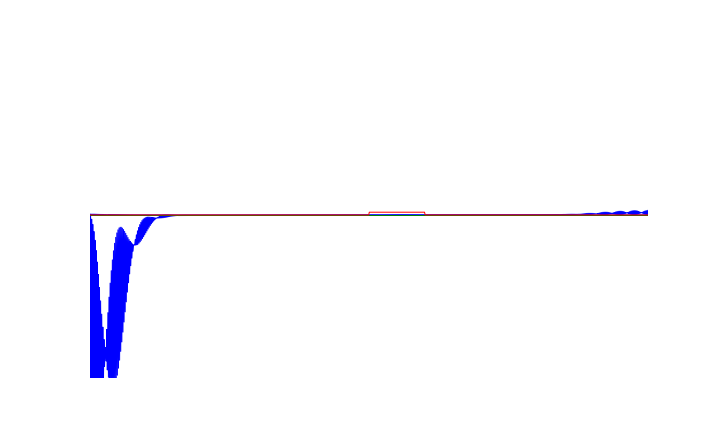
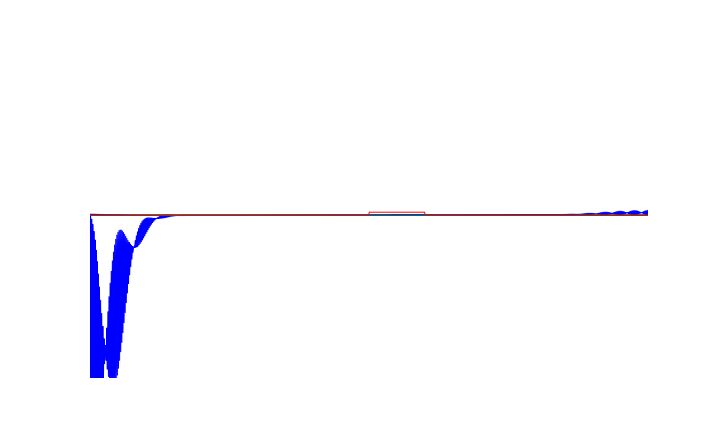
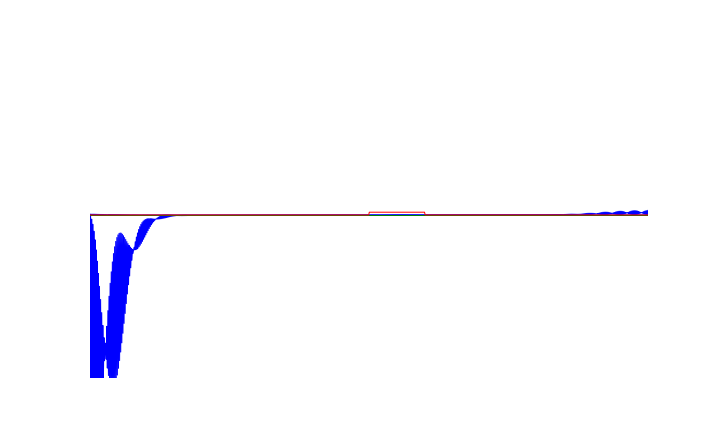
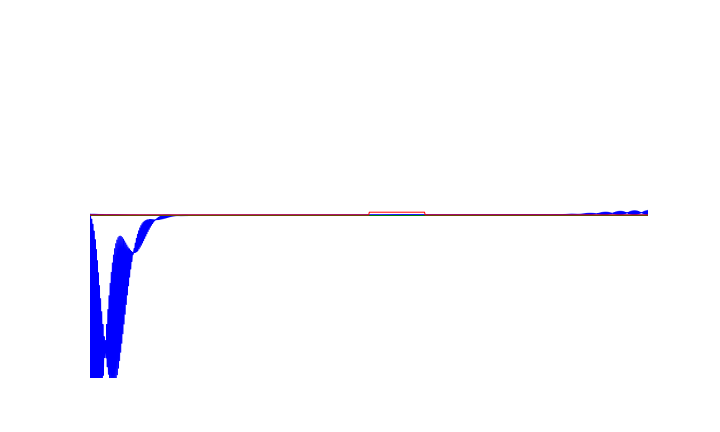
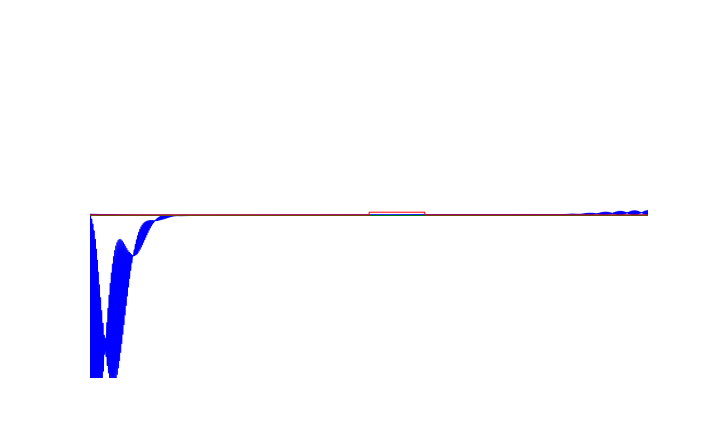
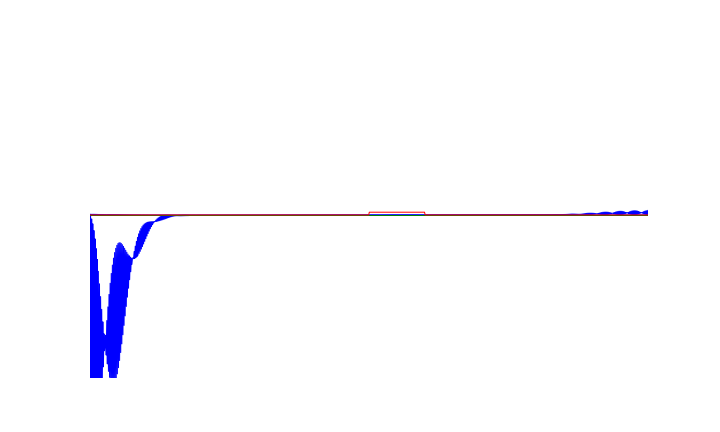
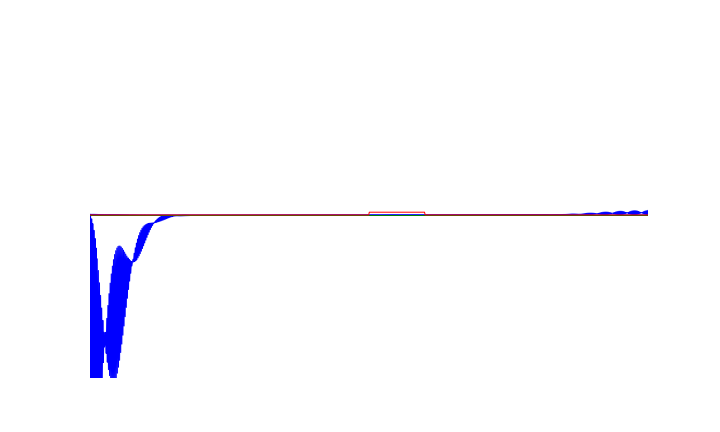
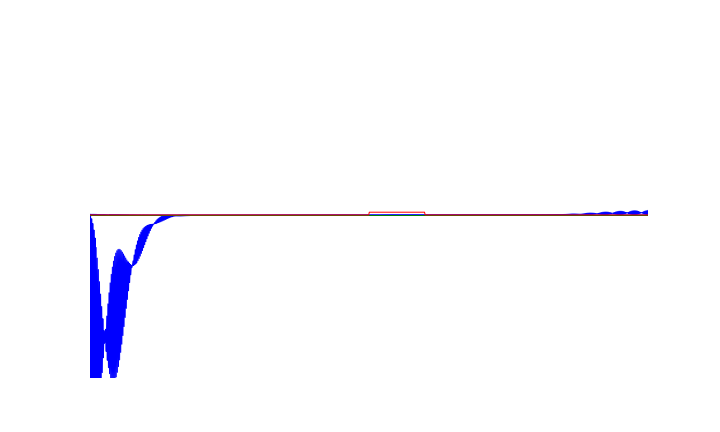
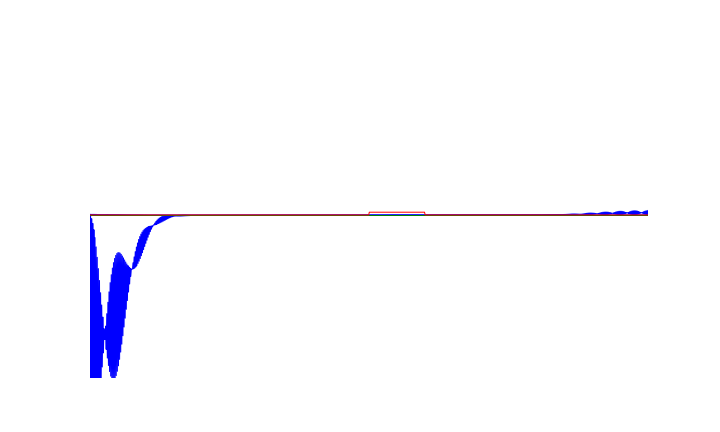
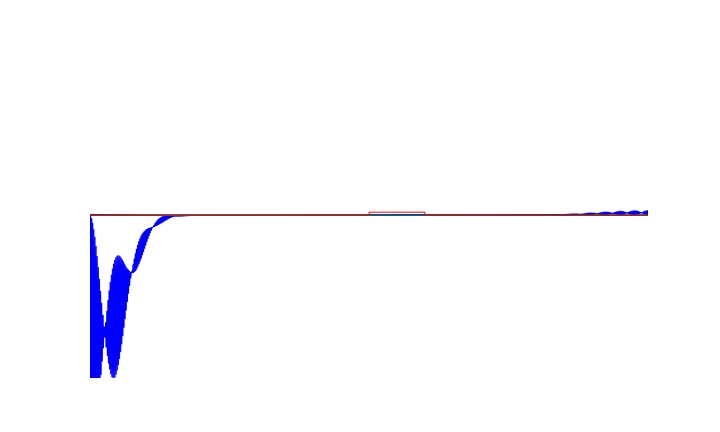
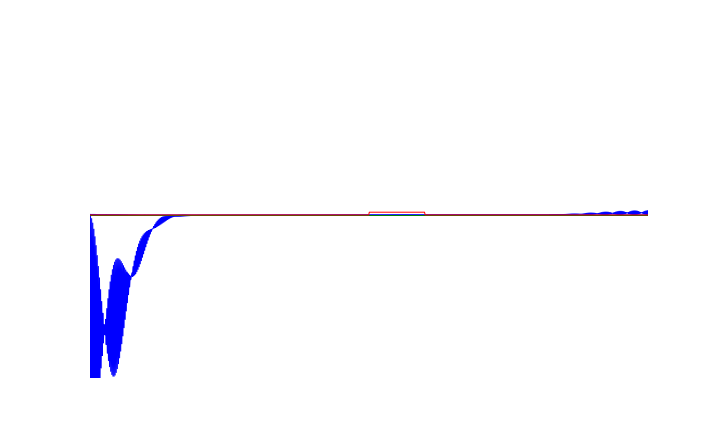
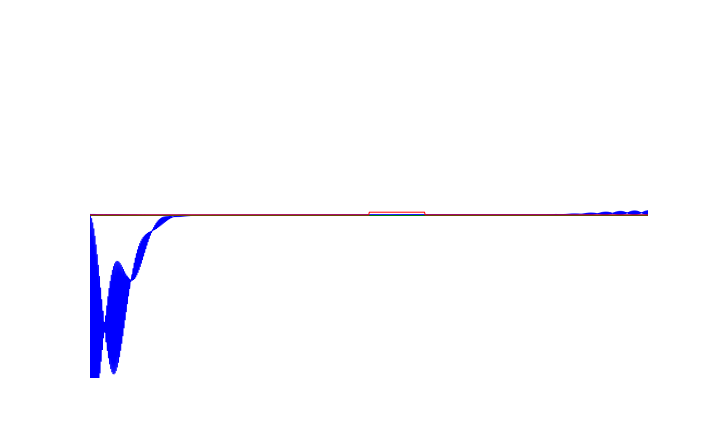
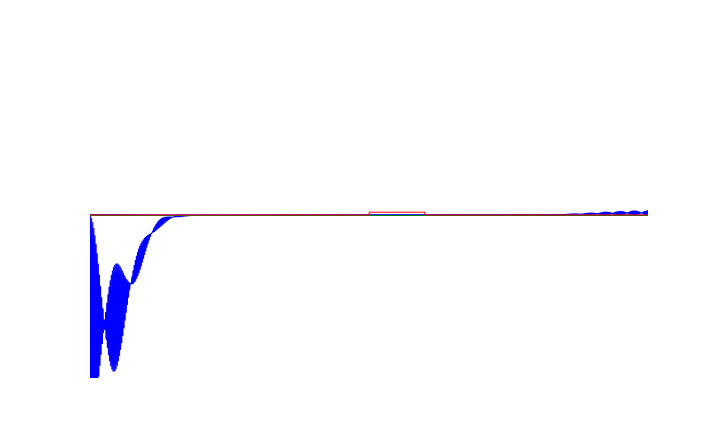
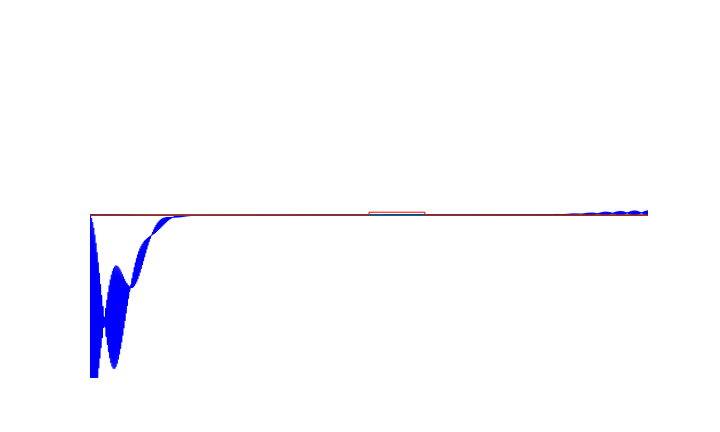
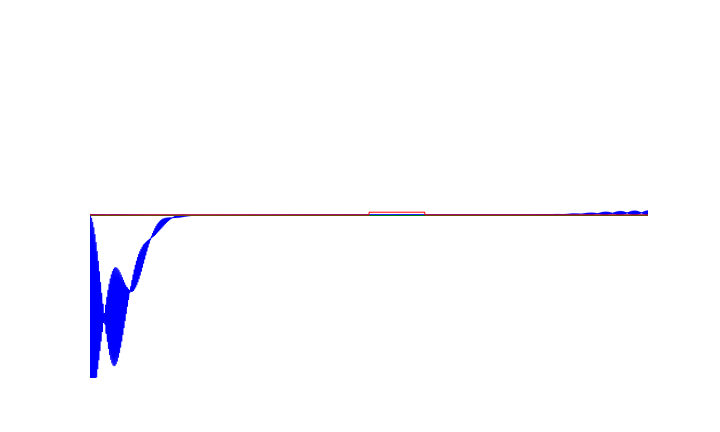
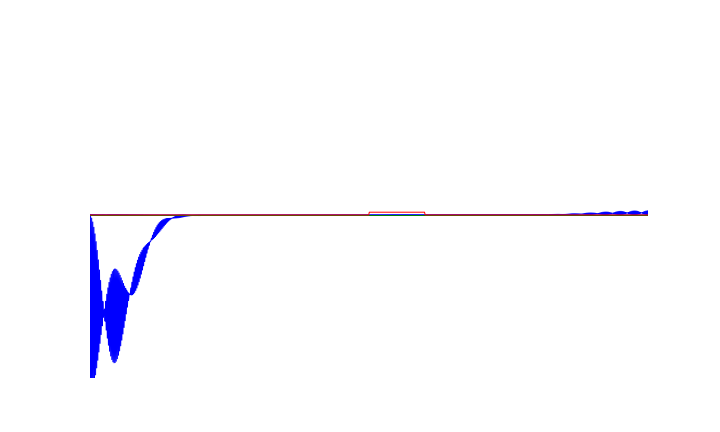
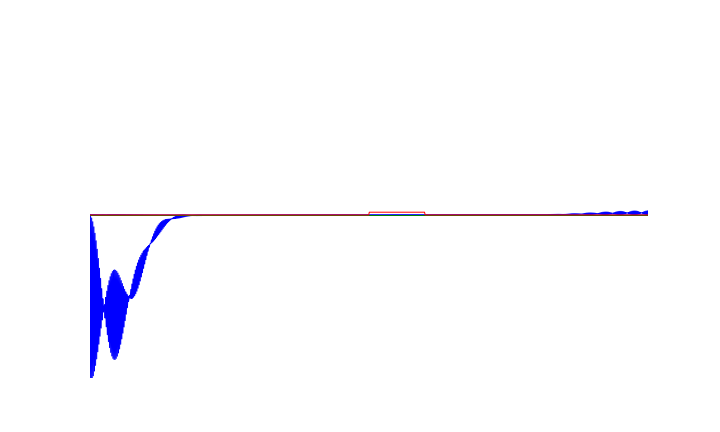
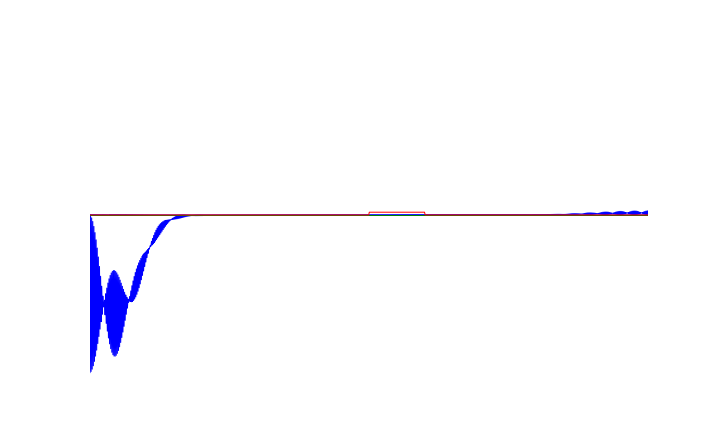
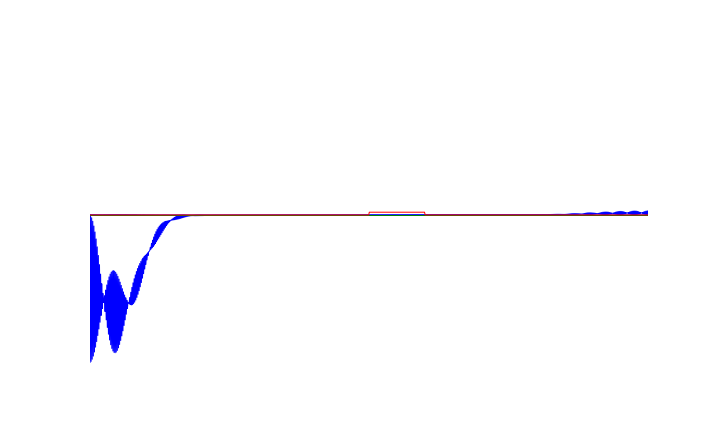
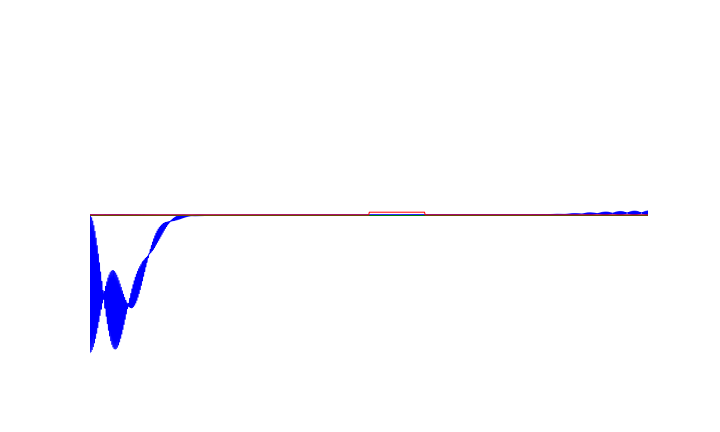
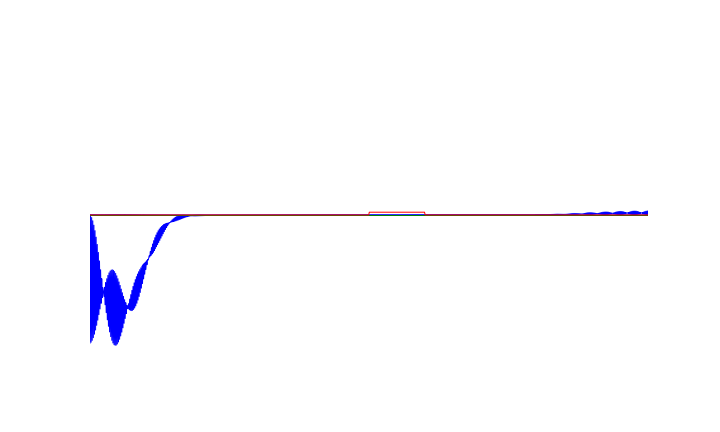
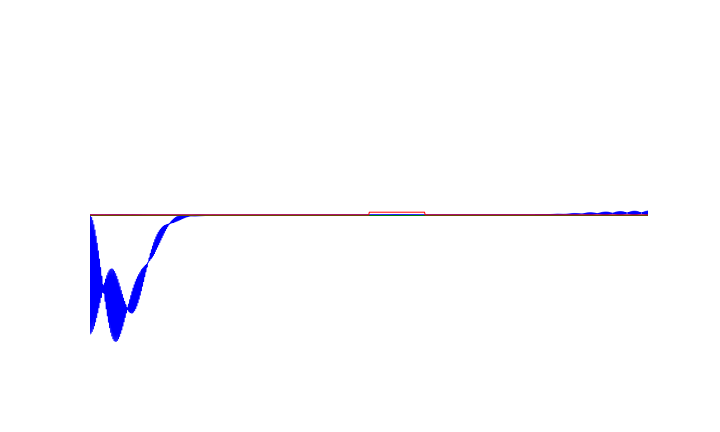
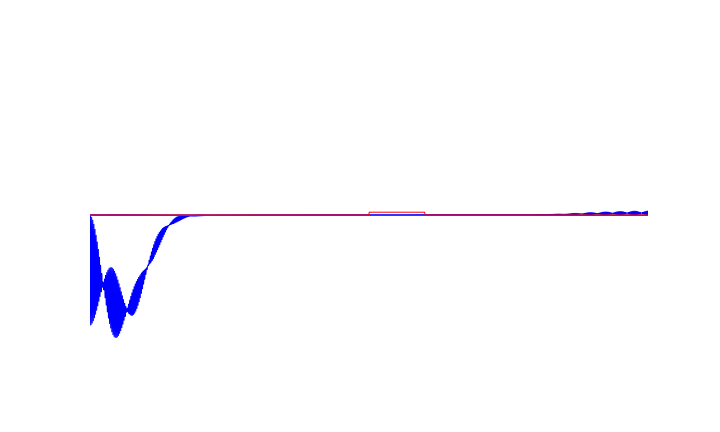
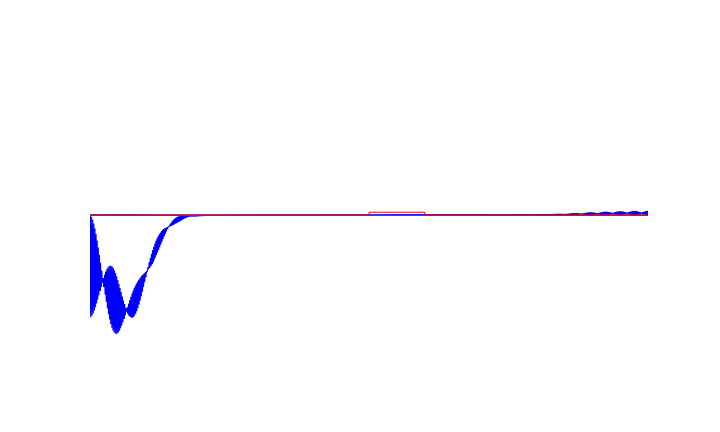
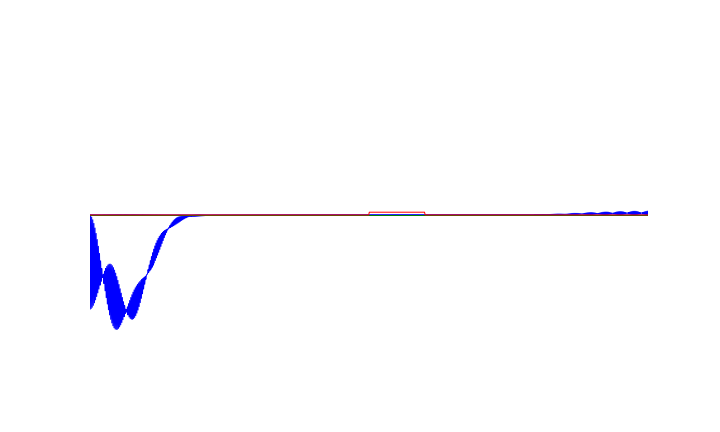
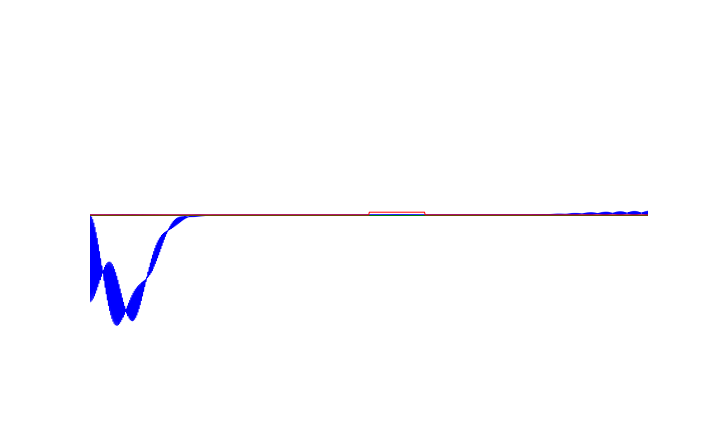
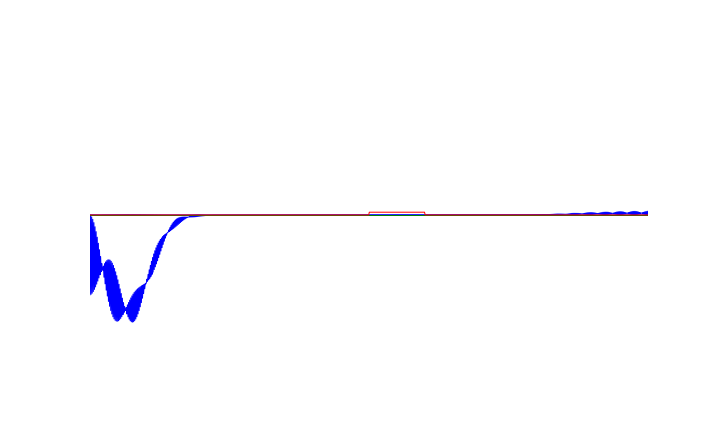
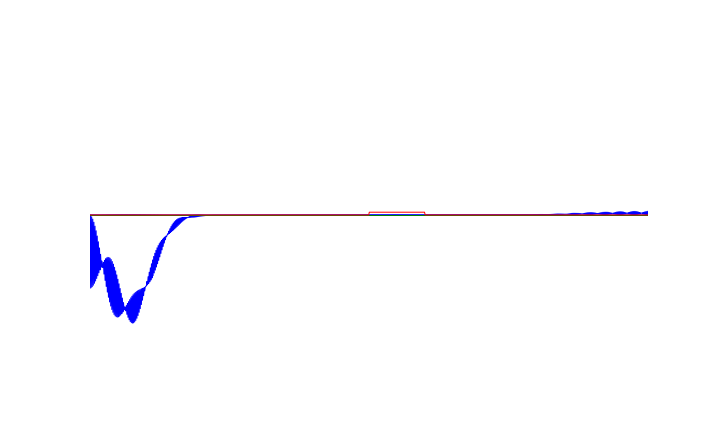
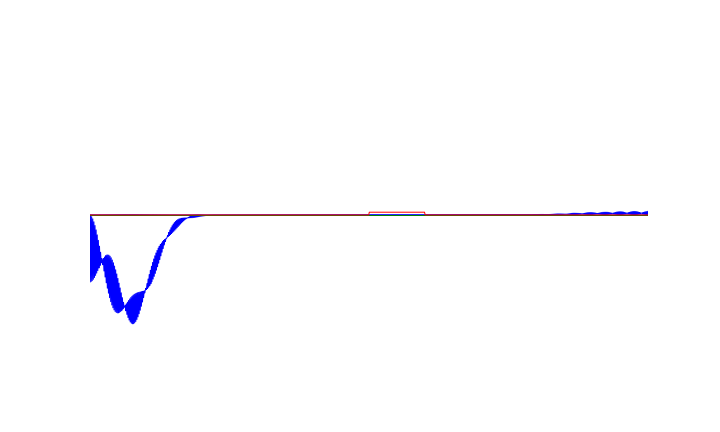
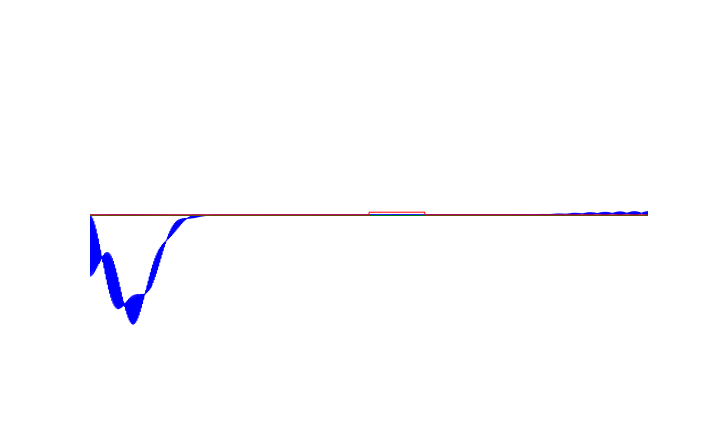
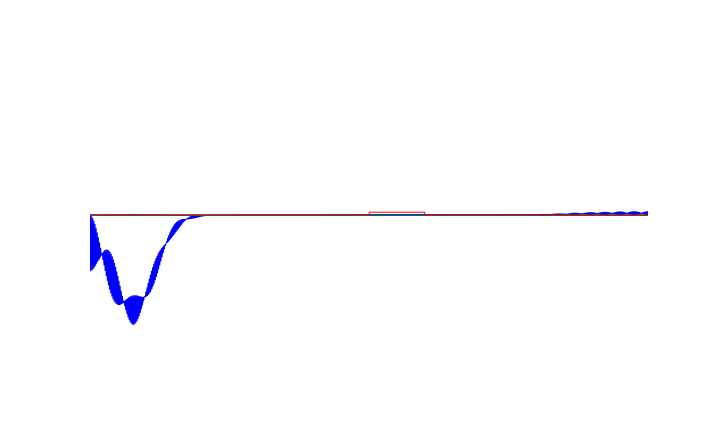
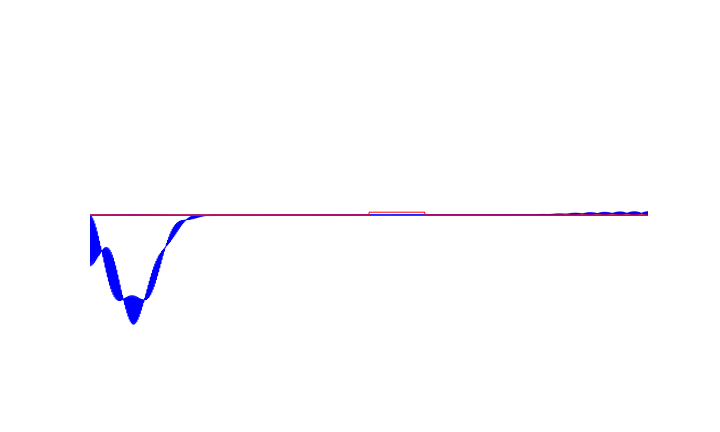
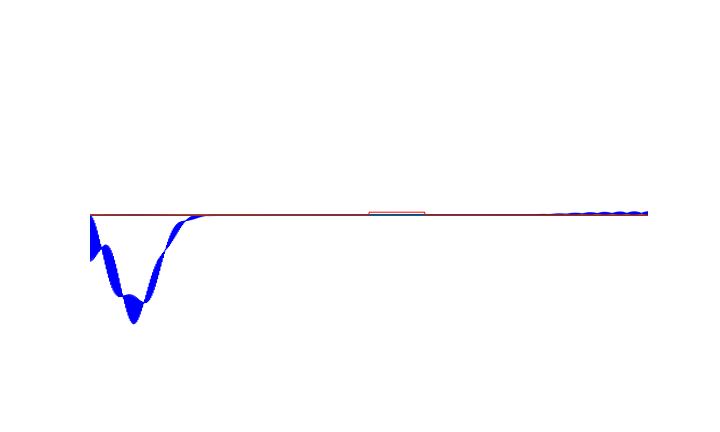
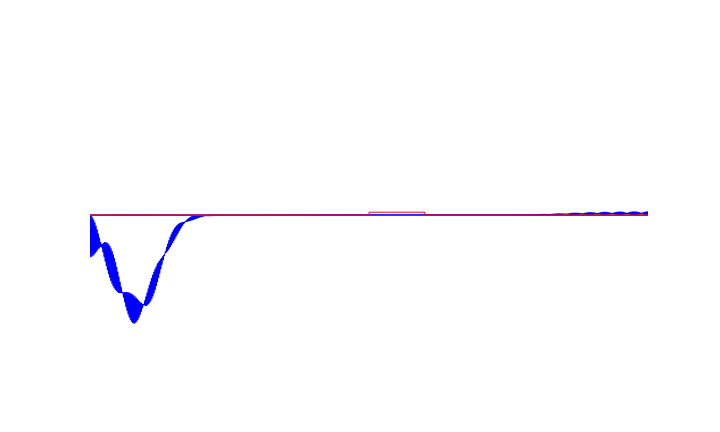
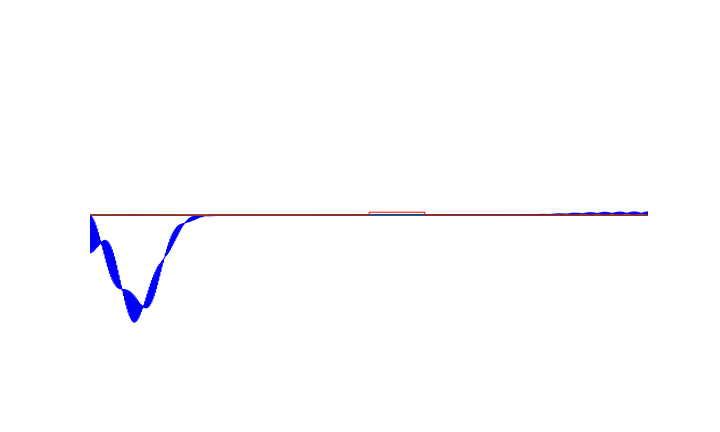
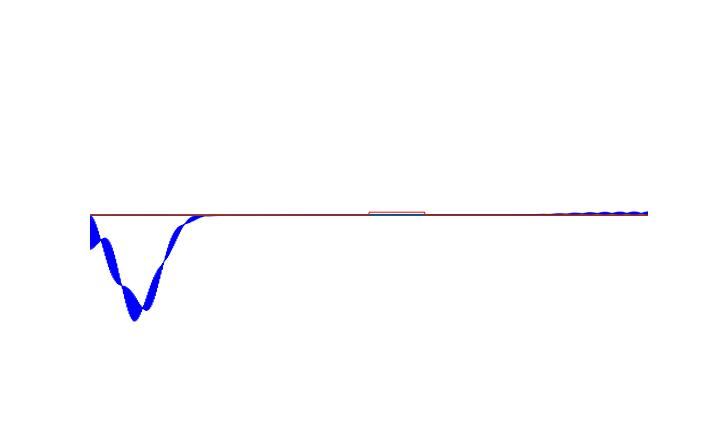
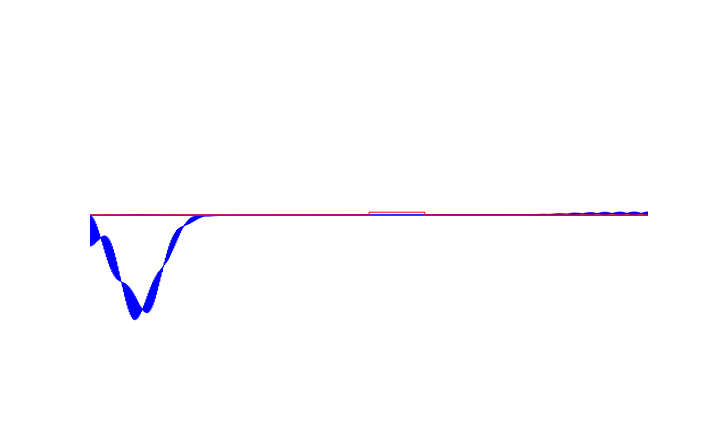
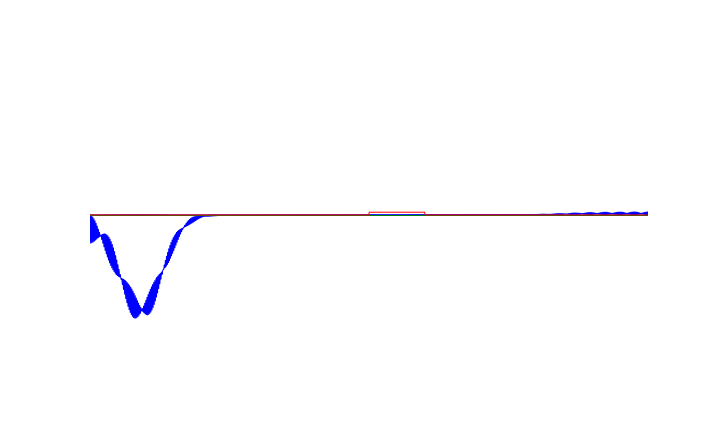
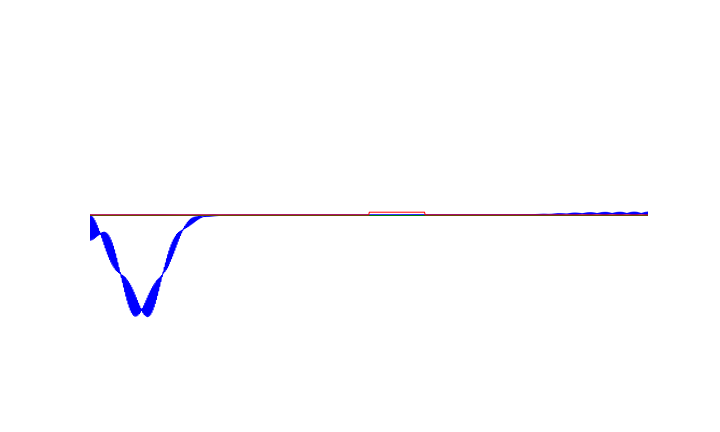
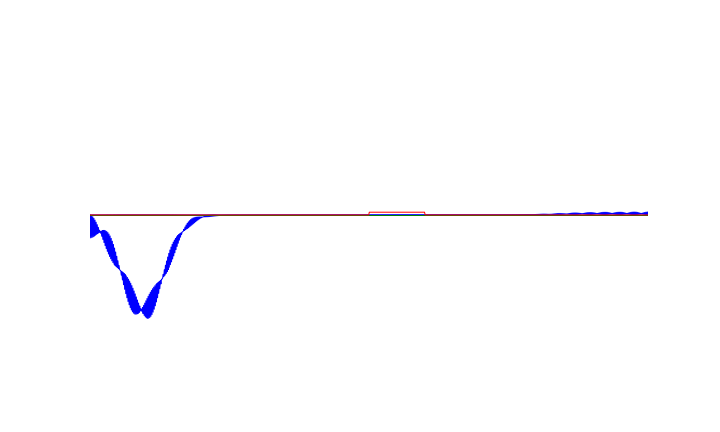
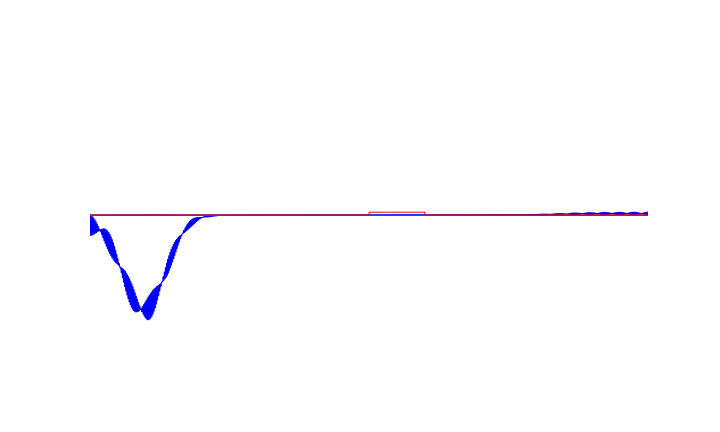
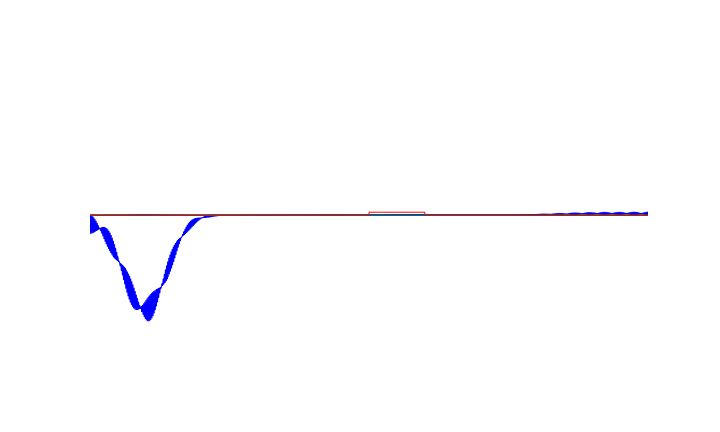
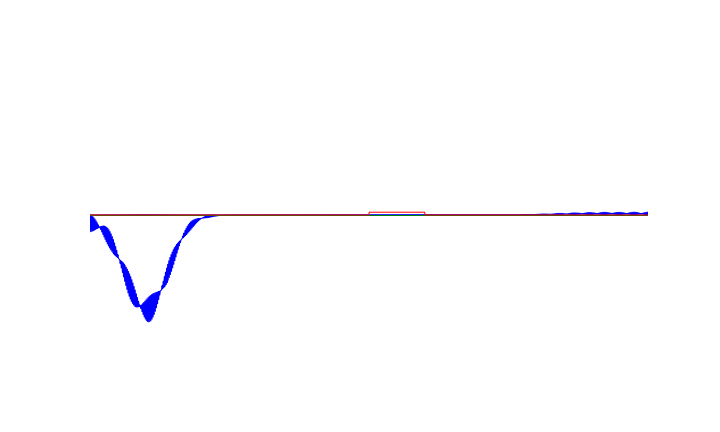
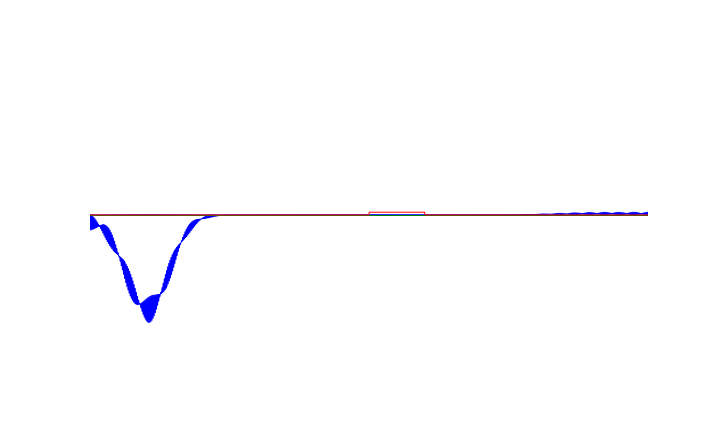
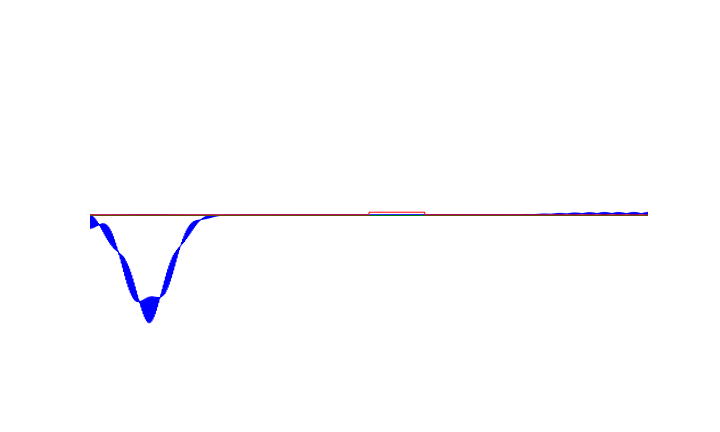
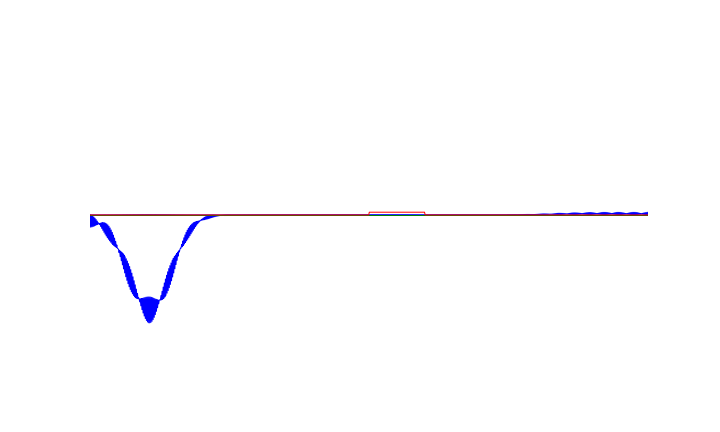
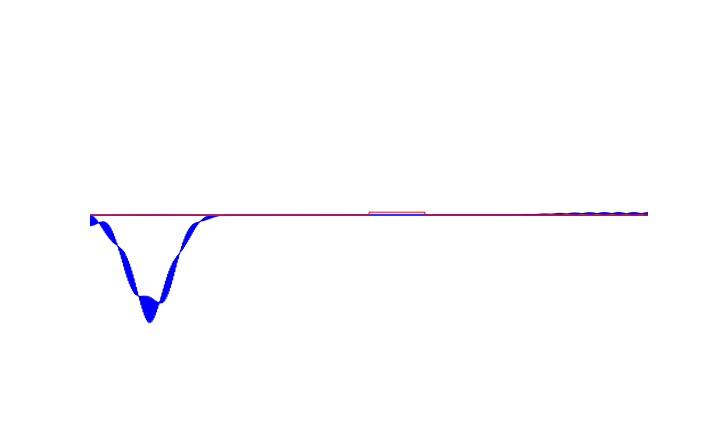
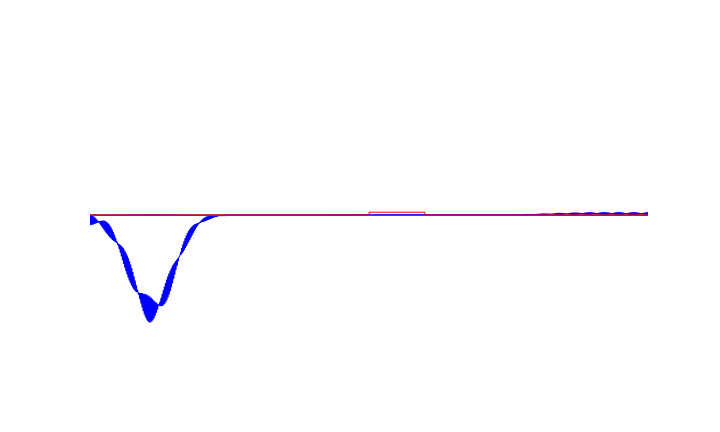
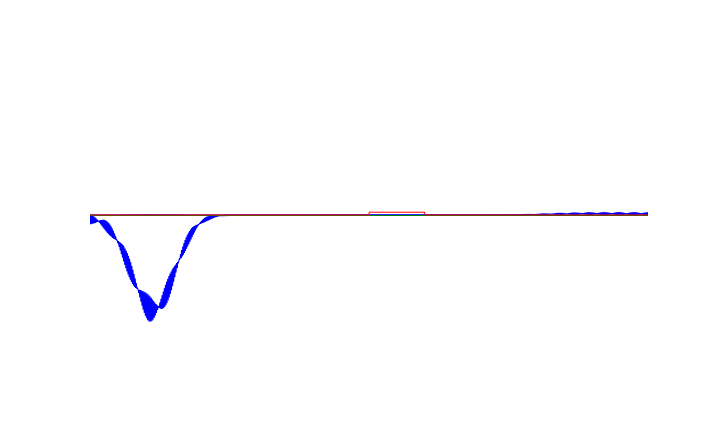
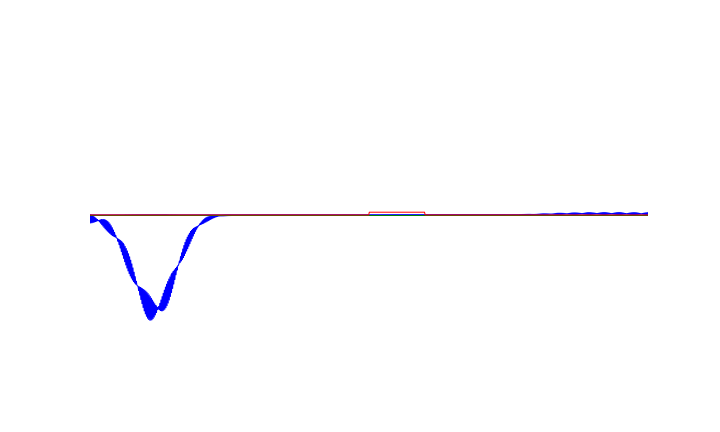
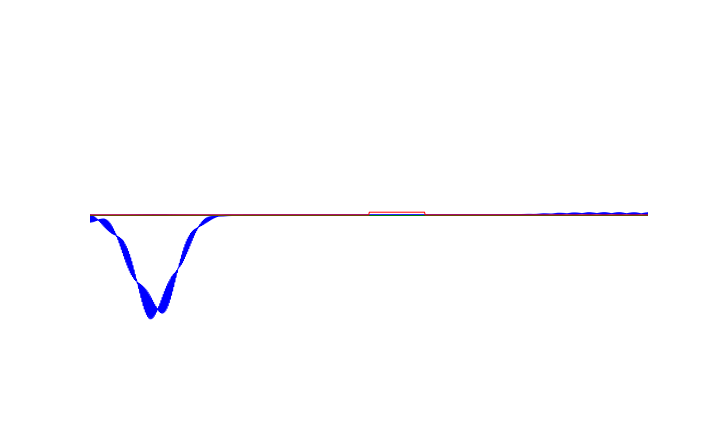
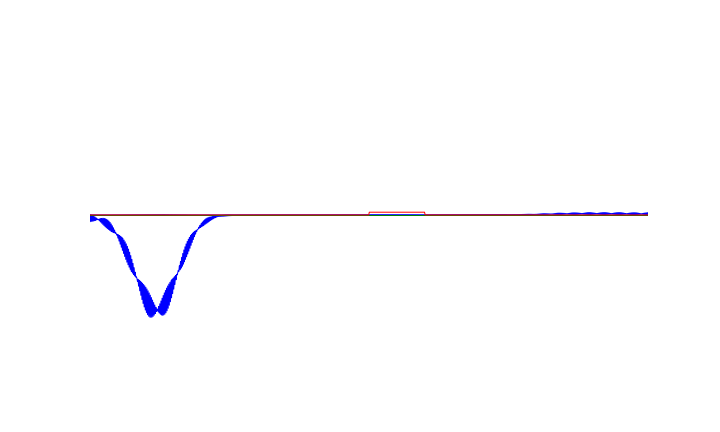
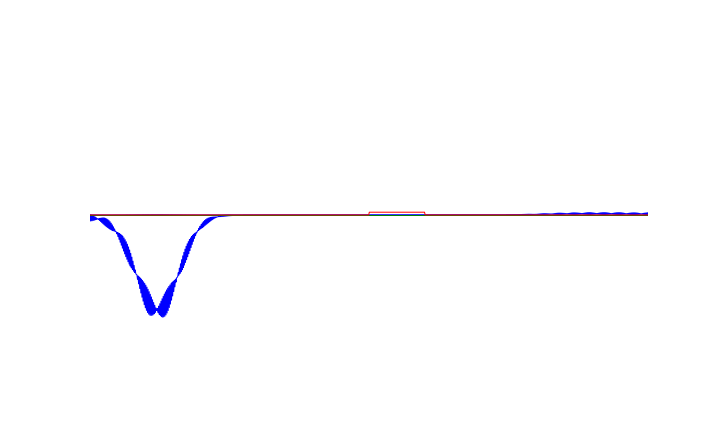
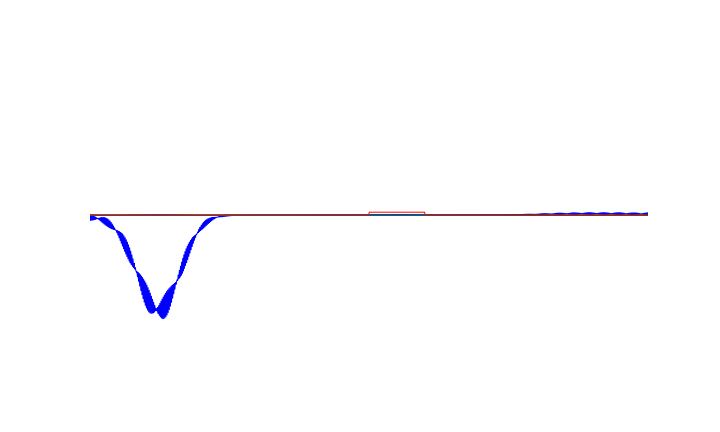

In [28]:
H , vo , potential, sup = hamiltonian_1d(M=1000,epsilon=0,delta=0.05,a=0,b=100,k=1.6,sigma=50,xo=150)
steps , x , vt = time_evolution(H,vo,dt=2,tMax=1000)
    
fig, ax, line, linh, = plotter()
animation.FuncAnimation(fig, animate, init_func=init, frames=int(steps), interval=25, blit=True)

In [54]:
vt[range(0,10,2),1]

array([  1.61840935e-04 +1.89249425e-05j,
        -2.46649875e-05 +6.61479760e-04j,
        -1.02694093e-03 +1.64140364e-05j,
        -9.24434073e-05 -1.21067632e-03j,   1.30848583e-03 -1.88287514e-04j])

In [18]:
-abs(vt[int(vt.shape[0]/2),vt.shape[0],0])**2

IndexError: too many indices for array